In [1]:
import random
import ast
from sklearn.metrics import classification_report
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import math
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series_dataset

/home/wally/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def distance(s, t):
    return (s - t)**2

In [3]:
def DTWDistance2(s, t, w):
    DTW = {}
    w = max(w, abs(len(s) - len(t)))
    for i in range(-1, len(s)):
        for j in range(-1, len(t)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s)):
        for j in range(max(0, i - w), min (len(t), i + w)):
            dist = distance(s[i], t[j])
            DTW[(i, j)] = dist + min(DTW[(i - 1, j)], DTW[(i, j - 1)], DTW[(i - 1, j - 1)])
    return math.sqrt(DTW[len(s) - 1, len(t) - 1])

In [4]:
def DTWDistance(s, t):
    DTW = {}
    for i in range(len(s)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(t)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s)):
        for j in range(len(t)):
            dist = distance(s[i], t[j])
            DTW[(i, j)] = dist + min(DTW[(i - 1, j)], DTW[(i, j - 1)], DTW[(i - 1, j - 1)])
    return math.sqrt(DTW[len(s) - 1, len(t) - 1])

In [5]:
def LBKeogh(s, t, r):
    LBSum = 0
    for ind, i in enumerate(s):
        lowerBound = min((t))
        upperBound = max((t))
        if i > upperBound:
            LBSum = LBSum + (i - upperBound)**2
        elif i < lowerBound:
            LBSum = LBSum + (i - lowerBound)**2
    return math.sqrt(LBSum)

In [6]:
def knn(train, test, w):
    preds = []
    for ind, i in enumerate(test):
        minDist = float('inf')
        closestSeq = []
        for j in train:
            if LBKeogh(i[:-1], j[:-1], 5) < minDist:
                dist = DTWDistance(i[:-1], j[:-1], w)
                if dist < minDist:
                    minDist = dist
                    closestSeq = j;
        preds.append(closestSeq[-1])
    return classification_report(test[:, -1], preds)

In [24]:
def Kmeans(data, centroids, clusters, iteractions, w = 5):
    counter = 0
    for n in range(iteractions):
        counter += 1
        print(counter)
        assignments = {}
        for ind, i in enumerate(data):
            minDist = float('inf')
            closestClust = None
            for key in centroids:
                if LBKeogh(i, centroids[key], 5) < minDist:
                    curDist = DTWDistance(i, centroids[key])
                    if curDist < minDist:
                        minDist = curDist
                        closestClust = key
            if closestClust in assignments:
                assignments[closestClust].append(ind)
            else:
                assignments[closestClust] = []        
    return assignments

In [8]:
scenario = 0
files = os.listdir('/home/wally/eclipse-workspace/pkmeansimulator/timer/global/'+str(scenario)+'/PER_HOUR/')
dataFrames = list()
dataFramesNames = list()
for j in range(len(files)):
    print(files[j])
    df = pd.read_csv("/home/wally/eclipse-workspace/pkmeansimulator/timer/global/"+str(scenario)+"/PER_HOUR/"+str(files[j]), delimiter = ";") 
    dataFrames.append(df)
    dataFramesNames.append(files[j])

79200-82800-2020-05-09T18:13:16.761362.csv
0-3600-2020-05-09T18:13:16.760262.csv
46800-50400-2020-05-09T18:13:16.759581.csv
61200-64800-2020-05-09T18:13:16.760141.csv
39600-43200-2020-05-09T18:13:16.759311.csv
25200-28800-2020-05-09T18:13:16.764139.csv
75600-79200-2020-05-09T18:13:16.761111.csv
7200-10800-2020-05-09T18:13:16.760758.csv
82800-86400-2020-05-09T18:13:16.761612.csv
68400-72000-2020-05-09T18:13:16.760624.csv
3600-7200-2020-05-09T18:13:16.760504.csv
50400-54000-2020-05-09T18:13:16.759734.csv
32400-36000-2020-05-09T18:13:16.758260.csv
64800-68400-2020-05-09T18:13:16.760381.csv
10800-14400-2020-05-09T18:13:16.760995.csv
36000-39600-2020-05-09T18:13:16.759152.csv
28800-32400-2020-05-09T18:13:16.764006.csv
54000-57600-2020-05-09T18:13:16.760017.csv
21600-25200-2020-05-09T18:13:16.763839.csv
57600-61200-2020-05-09T18:13:16.759878.csv
72000-75600-2020-05-09T18:13:16.760875.csv
43200-46800-2020-05-09T18:13:16.759450.csv
18000-21600-2020-05-09T18:13:16.761489.csv
14400-18000-2020-05

In [9]:
links = {}
type(links)

dict

In [32]:
def chartFirst(links,file, size, df):
    name = file.split("-")
    print(name[0]+"-"+name[1])
    l = df['link'].value_counts().head(size).index.tolist()
    print(df['link'].value_counts().head(size))
    links[name[0]+"-"+name[1]] = l
    print(l)

In [28]:
def chartLast(size, df):
    df = df['link'].value_counts()
    df.tail(size).plot(kind = 'bar')
    plt.show()

In [29]:
def chartFirst(size, df):
    df = df['link'].value_counts()
    df.head(size).plot(kind = 'bar')
    plt.show()

79200-82800-2020-05-09T18:13:16.761362.csv
Firsts: 



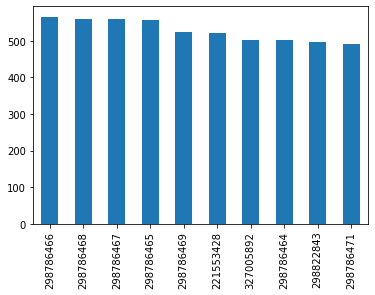

Lasts: 



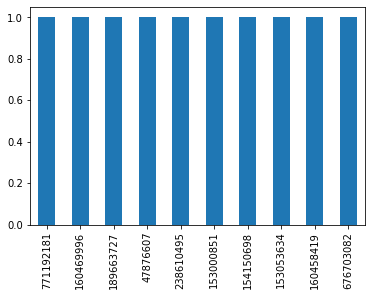

0-3600-2020-05-09T18:13:16.760262.csv
Firsts: 



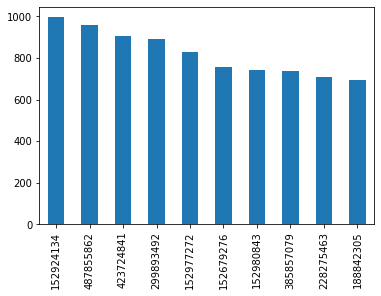

Lasts: 



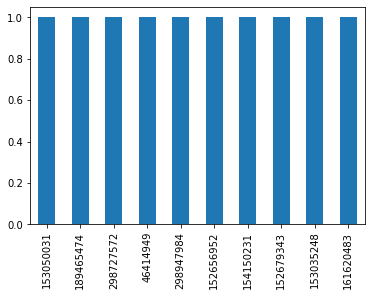

46800-50400-2020-05-09T18:13:16.759581.csv
Firsts: 



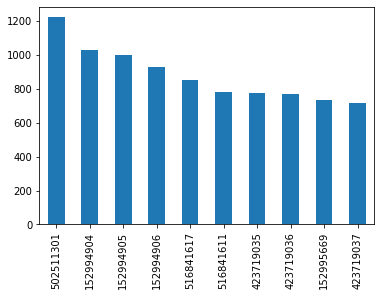

Lasts: 



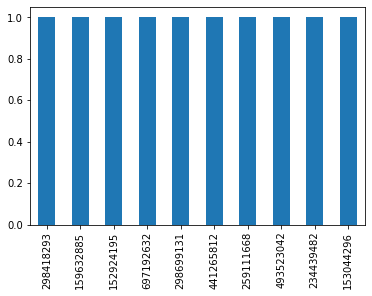

61200-64800-2020-05-09T18:13:16.760141.csv
Firsts: 



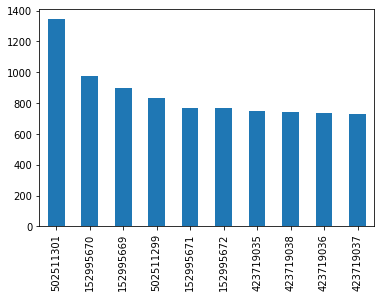

Lasts: 



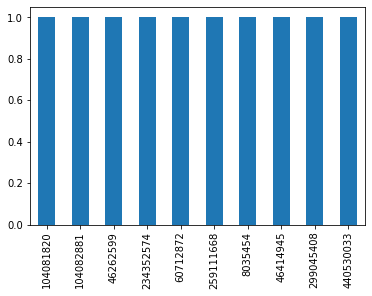

39600-43200-2020-05-09T18:13:16.759311.csv
Firsts: 



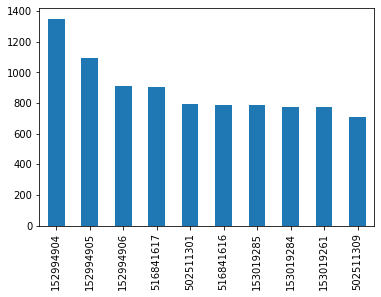

Lasts: 



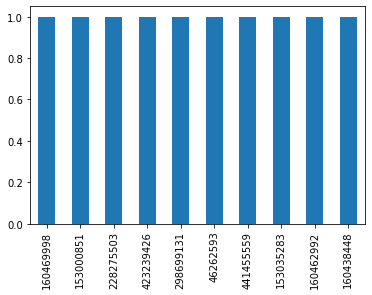

25200-28800-2020-05-09T18:13:16.764139.csv
Firsts: 



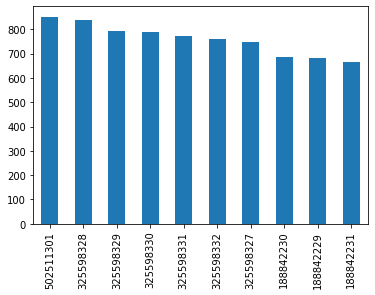

Lasts: 



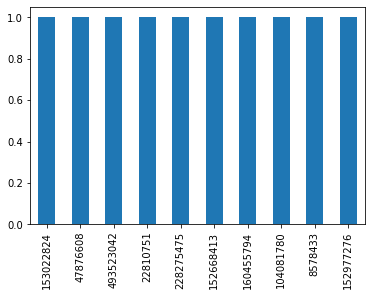

75600-79200-2020-05-09T18:13:16.761111.csv
Firsts: 



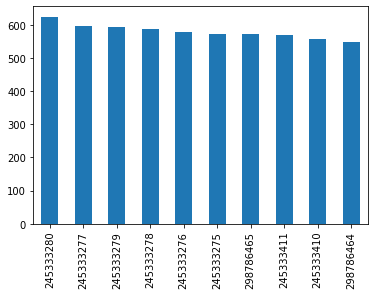

Lasts: 



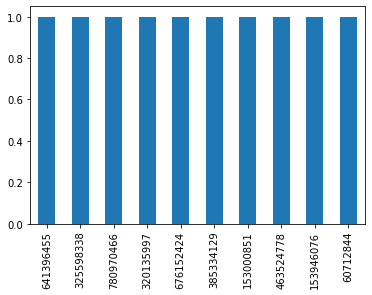

7200-10800-2020-05-09T18:13:16.760758.csv
Firsts: 



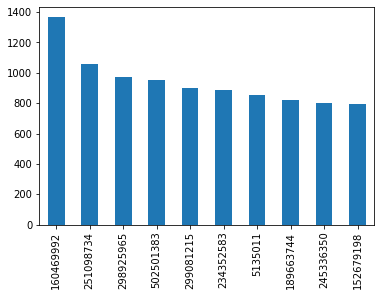

Lasts: 



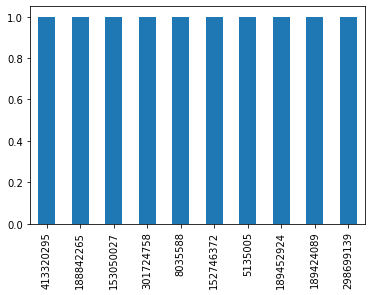

82800-86400-2020-05-09T18:13:16.761612.csv
Firsts: 



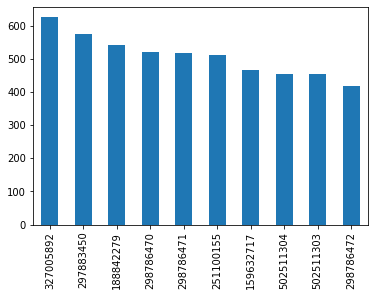

Lasts: 



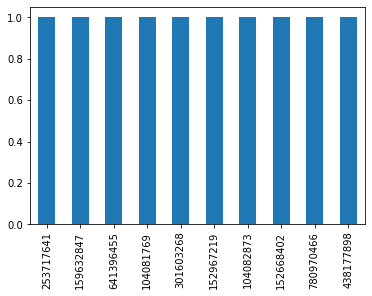

68400-72000-2020-05-09T18:13:16.760624.csv
Firsts: 



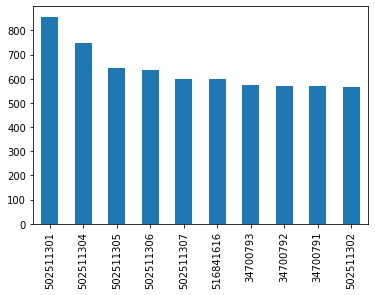

Lasts: 



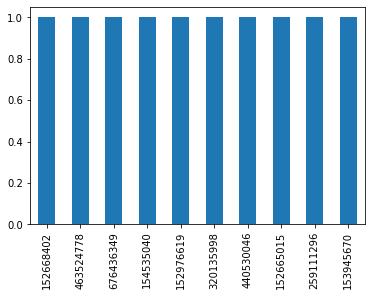

3600-7200-2020-05-09T18:13:16.760504.csv
Firsts: 



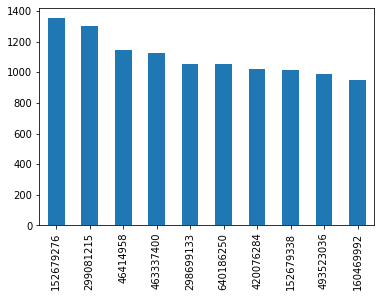

Lasts: 



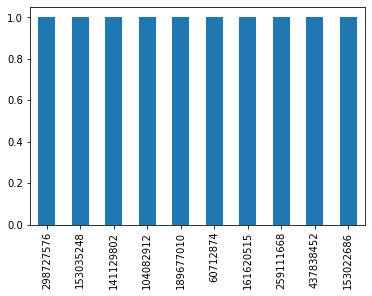

50400-54000-2020-05-09T18:13:16.759734.csv
Firsts: 



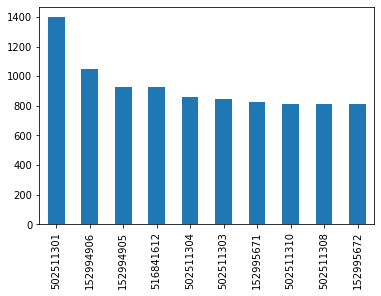

Lasts: 



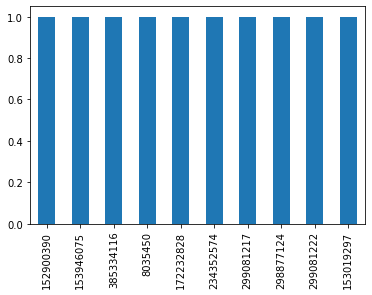

32400-36000-2020-05-09T18:13:16.758260.csv
Firsts: 



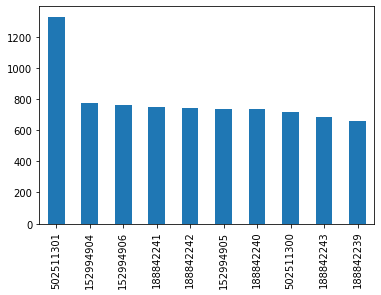

Lasts: 



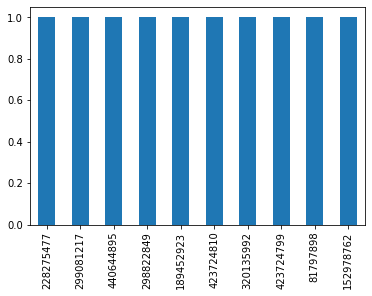

64800-68400-2020-05-09T18:13:16.760381.csv
Firsts: 



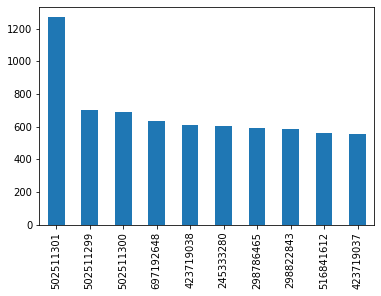

Lasts: 



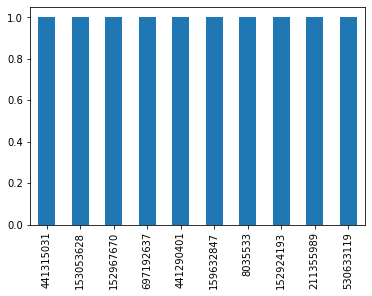

10800-14400-2020-05-09T18:13:16.760995.csv
Firsts: 



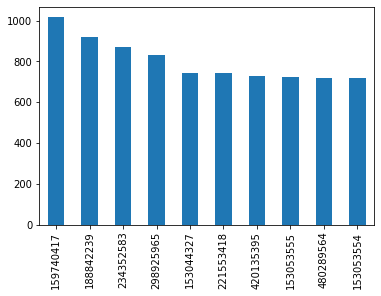

Lasts: 



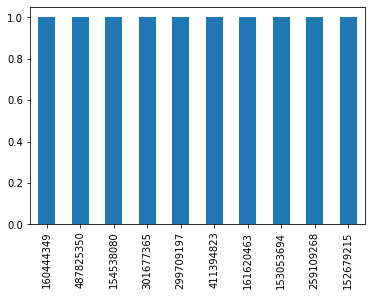

36000-39600-2020-05-09T18:13:16.759152.csv
Firsts: 



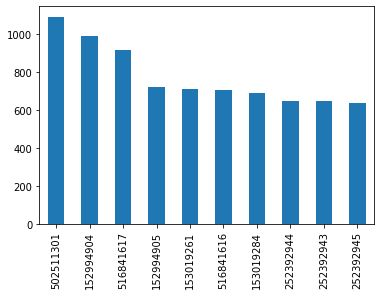

Lasts: 



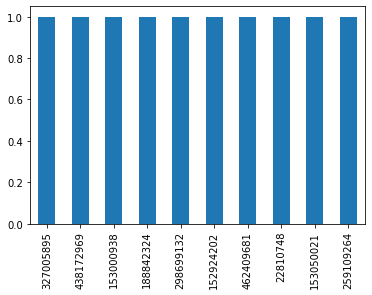

28800-32400-2020-05-09T18:13:16.764006.csv
Firsts: 



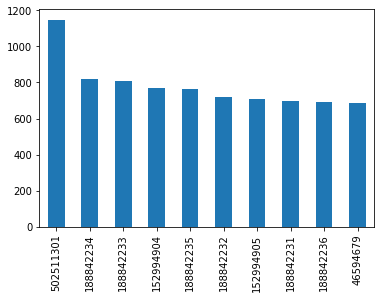

Lasts: 



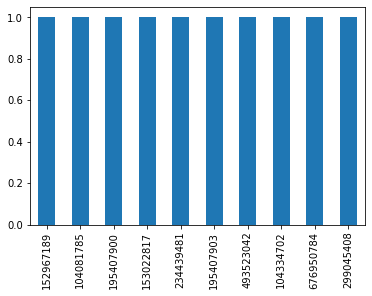

54000-57600-2020-05-09T18:13:16.760017.csv
Firsts: 



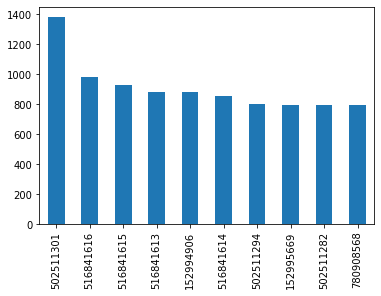

Lasts: 



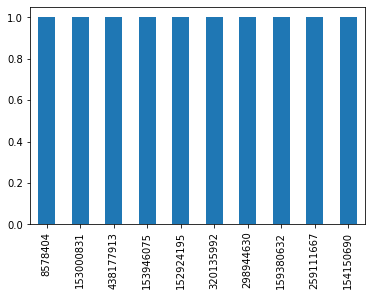

21600-25200-2020-05-09T18:13:16.763839.csv
Firsts: 



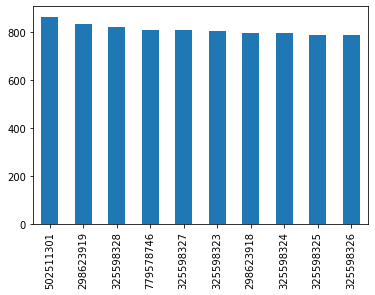

Lasts: 



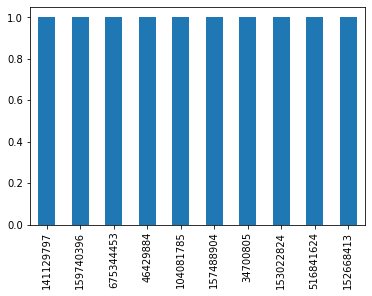

57600-61200-2020-05-09T18:13:16.759878.csv
Firsts: 



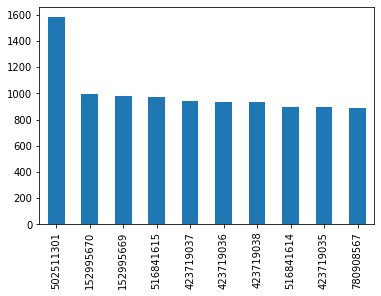

Lasts: 



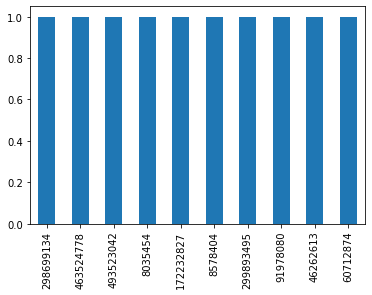

72000-75600-2020-05-09T18:13:16.760875.csv
Firsts: 



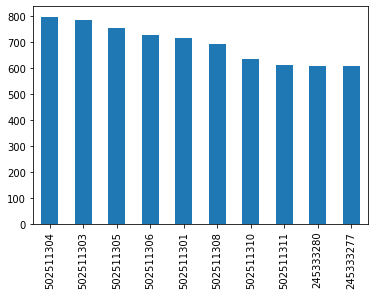

Lasts: 



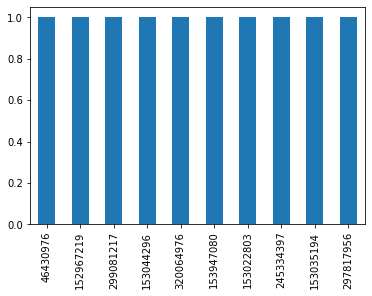

43200-46800-2020-05-09T18:13:16.759450.csv
Firsts: 



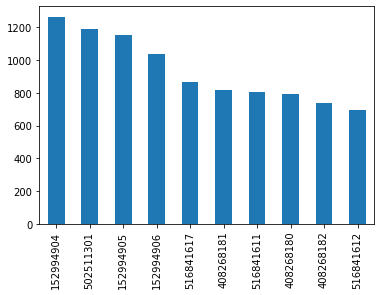

Lasts: 



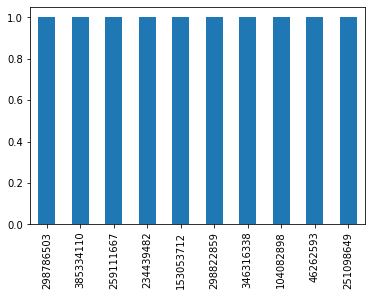

18000-21600-2020-05-09T18:13:16.761489.csv
Firsts: 



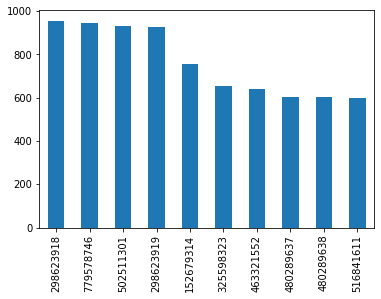

Lasts: 



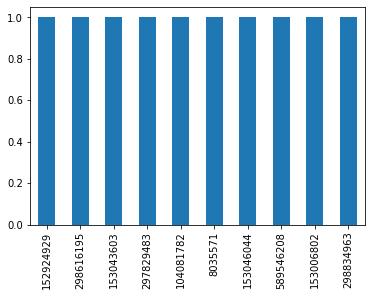

14400-18000-2020-05-09T18:13:16.761231.csv
Firsts: 



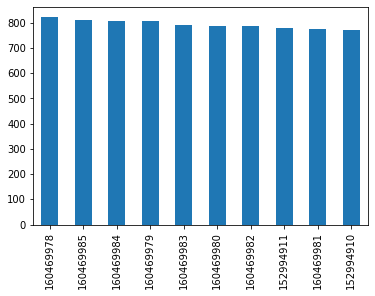

Lasts: 



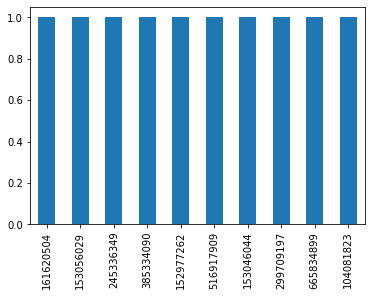

In [30]:
for i in range(len(dataFrames)):
    print(dataFramesNames[i])
    print("Firsts: \n")
    chartFirst(10, dataFrames[i])
    print("Lasts: \n")
    chartLast(10, dataFrames[i])

In [33]:
for i in range(len(dataFrames)):
    chartFirst(links, dataFramesNames[i], 10, dataFrames[i])

79200-82800
298786466    566
298786468    561
298786467    560
298786465    557
298786469    523
221553428    521
327005892    503
298786464    501
298822843    496
298786471    492
Name: link, dtype: int64
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
0-3600
152924134    995
487855862    957
423724841    906
299893492    891
152977272    830
152679276    758
152980843    743
385857079    738
228275463    709
188842305    696
Name: link, dtype: int64
[152924134, 487855862, 423724841, 299893492, 152977272, 152679276, 152980843, 385857079, 228275463, 188842305]
46800-50400
502511301    1223
152994904    1033
152994905    1003
152994906     928
516841617     854
516841611     783
423719035     775
423719036     768
152995669     737
423719037     715
Name: link, dtype: int64
[502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037]
61200-64800
502511301    1343
152995670  

In [34]:
data = []
most_accessed_sequence = {}
print(links)
with open("/home/wally/eclipse-workspace/pkmeansimulator/output/sequences/with-link-interval-2020-06-01T21:11:00.820515.csv","r") as f:
    for i in f.readlines():
        l = list(map(int, i.split(';')))
        print(l[0])
        print(str(l[1])+'-'+str(l[2]))
        print(links[str(l[1])+'-'+str(l[2])])
        if l[0] in links[str(l[1])+'-'+str(l[2])] and str(l[1])+'-'+str(l[2]) in links:
            most_accessed_sequence[str(l[0])+'-'+str(l[1])+'-'+str(l[2])] = l[3:]
        else:
            data.append(l)

{'79200-82800': [298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471], '0-3600': [152924134, 487855862, 423724841, 299893492, 152977272, 152679276, 152980843, 385857079, 228275463, 188842305], '46800-50400': [502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037], '61200-64800': [502511301, 152995670, 152995669, 502511299, 152995671, 152995672, 423719035, 423719038, 423719036, 423719037], '39600-43200': [152994904, 152994905, 152994906, 516841617, 502511301, 516841616, 153019285, 153019284, 153019261, 502511309], '25200-28800': [502511301, 325598328, 325598329, 325598330, 325598331, 325598332, 325598327, 188842230, 188842229, 188842231], '75600-79200': [245333280, 245333277, 245333279, 245333278, 245333276, 245333275, 298786465, 245333411, 245333410, 298786464], '7200-10800': [160469992, 251098734, 298925965, 502501383, 299081215, 234352583, 5135011, 189663744, 245336350, 152

[502511301, 152995670, 152995669, 502511299, 152995671, 152995672, 423719035, 423719038, 423719036, 423719037]
152967669
61200-64800
[502511301, 152995670, 152995669, 502511299, 152995671, 152995672, 423719035, 423719038, 423719036, 423719037]
298925985
75600-79200
[245333280, 245333277, 245333279, 245333278, 245333276, 245333275, 298786465, 245333411, 245333410, 298786464]
189663723
75600-79200
[245333280, 245333277, 245333279, 245333278, 245333276, 245333275, 298786465, 245333411, 245333410, 298786464]
189663724
75600-79200
[245333280, 245333277, 245333279, 245333278, 245333276, 245333275, 298786465, 245333411, 245333410, 298786464]
153053630
75600-79200
[245333280, 245333277, 245333279, 245333278, 245333276, 245333275, 298786465, 245333411, 245333410, 298786464]
252392916
75600-79200
[245333280, 245333277, 245333279, 245333278, 245333276, 245333275, 298786465, 245333411, 245333410, 298786464]
221553433
75600-79200
[245333280, 245333277, 245333279, 245333278, 245333276, 245333275, 29

[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
127127910
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
188842228
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
34700805
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
299024300
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
491822826
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
155685564
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
346316360
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327

299094967
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
152967194
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
152654160
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
191003444
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
441455573
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
188842335
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
320136007
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
589546202
79200-82800
[298786466, 298786468, 298786467, 298786465, 29

[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
385331948
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
153019283
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
153035284
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
153049969
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
152746454
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
298699133
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 327005892, 298786464, 298822843, 298786471]
423724825
79200-82800
[298786466, 298786468, 298786467, 298786465, 298786469, 221553428, 32

438172979
46800-50400
[502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037]
8578412
46800-50400
[502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037]
298877124
46800-50400
[502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037]
160448521
46800-50400
[502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037]
152980828
46800-50400
[502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037]
160448101
46800-50400
[502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037]
493523043
46800-50400
[502511301, 152994904, 152994905, 152994906, 516841617, 516841611, 423719035, 423719036, 152995669, 423719037]
385334112
46800-50400
[502511301, 152994904, 152994905, 152994906, 5168

In [13]:
def chartLinks(sz, link, data, link_interval):
    for xx in data:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(link.ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Link %s' % link_interval,
             transform=plt.gca().transAxes)
    plt.title(link_interval)
    plt.tight_layout()
    plt.show()

In [ ]:
def chartLink(link, link_interval):
    plt.plot(link.ravel(), "r-")
    plt.xlim(0, len(link))
    plt.ylim(link[0], link[len(link)-1])
    plt.text(0.55, 0.85,'Link %s' % link_interval,
             transform=plt.gca().transAxes)
    plt.title(link_interval)
    plt.tight_layout()
    plt.show()

159632717-82800-86400
[152746500, 82800, 86400]: 4.41492304114493
[547531528, 82800, 86400]: 4.398484897098091
[547531527, 82800, 86400]: 4.021114961239415
[420135389, 82800, 86400]: 4.41492304114493
[8838071, 82800, 86400]: 4.242855581438796
[301677886, 82800, 86400]: 4.41492304114493
[152978752, 82800, 86400]: 4.637914548980823
[547531535, 82800, 86400]: 4.41492304114493
[547531525, 82800, 86400]: 4.41492304114493
[159632718, 82800, 86400]: 3.8235226348341658
[547531531, 82800, 86400]: 4.056922733316818
[547531534, 82800, 86400]: 4.053764013476202
[547531536, 82800, 86400]: 4.424971046443676
[47876615, 82800, 86400]: 5.849274636839699
[515675204, 82800, 86400]: 4.34085490706691
[153947334, 82800, 86400]: 4.21626870742575
[103934334, 82800, 86400]: 4.41492304114493
[153947335, 82800, 86400]: 4.061226287160637
[301677885, 82800, 86400]: 4.41492304114493
[634307497, 82800, 86400]: 4.41492304114493
[157490277, 82800, 86400]: 4.41492304114493
[297830232, 82800, 86400]: 4.384759289346118
[

[152996534, 0, 3600]: 4.41492304114493
[104082880, 0, 3600]: 4.41492304114493
[152967646, 0, 3600]: 4.283676074706276
[423239438, 0, 3600]: 4.316983037700359
[675092020, 0, 3600]: 4.26884968707001
[697819363, 0, 3600]: 4.41492304114493
[423724842, 0, 3600]: 4.777221399976308
[157489834, 0, 3600]: 4.254073152999246
[152978672, 0, 3600]: 4.419885987889299
[547531516, 0, 3600]: 3.6961680673900235
[440521424, 0, 3600]: 3.966363327678473
[297971534, 0, 3600]: 5.849274636839699
[157488722, 0, 3600]: 4.41492304114493
[152967148, 0, 3600]: 5.849274636839699
[152679218, 0, 3600]: 4.327233840486075
[780911242, 0, 3600]: 4.313447166779434
[104081781, 0, 3600]: 4.41492304114493
[153019269, 0, 3600]: 4.1660696564643365
[152679413, 0, 3600]: 3.9260166252376623
[160451376, 0, 3600]: 4.41492304114493
[299893502, 0, 3600]: 4.2648191681652445
[174924979, 0, 3600]: 4.496337549897586
[718963842, 0, 3600]: 4.41492304114493
[104082865, 0, 3600]: 4.41492304114493
[718963897, 0, 3600]: 2.6979705582442928
[159

[299081200, 0, 3600]: 4.258362317185629
[104081780, 0, 3600]: 4.41492304114493
[385619164, 0, 3600]: 4.154236243442428
[299893499, 0, 3600]: 4.439587708345913
[420095474, 0, 3600]: 4.41492304114493
[438172985, 0, 3600]: 4.477194388936417
[153946072, 0, 3600]: 4.41492304114493
[152679414, 0, 3600]: 4.02954412111558
[711385801, 0, 3600]: 4.396445245987461
[152995654, 0, 3600]: 4.41492304114493
[344851269, 0, 3600]: 3.955599986500884
[152665029, 0, 3600]: 4.41492304114493
[153947088, 0, 3600]: 4.580258598701186
[423239431, 0, 3600]: 3.7107647542828466
[152679219, 0, 3600]: 4.883446126279002
[160451374, 0, 3600]: 5.831958738041088
[320136003, 0, 3600]: 4.41492304114493
[153019266, 0, 3600]: 4.282966689926122
[299893501, 0, 3600]: 4.567106837268835
[152651318, 0, 3600]: 4.34026576045771
[153019270, 0, 3600]: 4.456096253068843
[127127899, 0, 3600]: 4.810535297221311
[244021197, 0, 3600]: 4.41492304114493
[228275498, 0, 3600]: 4.277904579578143
[440530037, 0, 3600]: 4.41492304114493
[42323943

[153053593, 3600, 7200]: 4.41492304114493
[688769629, 3600, 7200]: 4.304636947448004
[234332718, 3600, 7200]: 4.41492304114493
[462617694, 3600, 7200]: 4.41492304114493
[462617691, 3600, 7200]: 4.41492304114493
[462617692, 3600, 7200]: 4.41492304114493
[234332716, 3600, 7200]: 4.41492304114493
[152928143, 3600, 7200]: 4.41492304114493
[153035117, 3600, 7200]: 4.41492304114493
[189465476, 3600, 7200]: 4.41492304114493
[160444150, 3600, 7200]: 4.41492304114493
[779578743, 3600, 7200]: 4.41492304114493
[134801096, 3600, 7200]: 4.41492304114493
[152925433, 3600, 7200]: 4.41492304114493
[153035243, 3600, 7200]: 4.41492304114493
[141129801, 3600, 7200]: 4.41492304114493
[440622911, 3600, 7200]: 4.41492304114493
[298623925, 25200, 28800]: 4.313557183214678
[154535093, 25200, 28800]: 4.184057985536525
[259111292, 25200, 28800]: 4.259279251124628
[104334702, 25200, 28800]: 3.874133311254747
[230916295, 25200, 28800]: 4.257091651274966
[153022658, 25200, 28800]: 4.41492304114493
[610942260, 2520

[228275501, 61200, 64800]: 4.41492304114493
[152924166, 61200, 64800]: 4.255158351142649
[152679383, 61200, 64800]: 4.317621280132368
[152679388, 61200, 64800]: 4.481773084479637
[515675215, 61200, 64800]: 3.8546460255929125
[152668419, 61200, 64800]: 4.41492304114493
[8578388, 61200, 64800]: 3.8560617634651084
[152668407, 61200, 64800]: 3.69681551086441
[152679275, 61200, 64800]: 4.41492304114493
[298930277, 61200, 64800]: 4.585086219638223
[228275500, 61200, 64800]: 4.41492304114493
[695018706, 61200, 64800]: 4.344831437173329
[154149776, 61200, 64800]: 4.159647323493472
[441315034, 61200, 64800]: 4.41492304114493
[152656719, 61200, 64800]: 4.171178331341934
[385619160, 61200, 64800]: 4.418348253533524
[298847947, 61200, 64800]: 4.41492304114493
[152924127, 61200, 64800]: 4.118282592611397
[152924173, 61200, 64800]: 4.238627345799511
[423729720, 61200, 64800]: 4.355275955990754
[228275502, 61200, 64800]: 4.41492304114493
[154149778, 61200, 64800]: 3.67716881864053
[298699138, 61200, 

[141129782, 7200, 10800]: 4.41492304114493
[221553423, 7200, 10800]: 4.41492304114493
[427846841, 7200, 10800]: 4.010093719758894
[385793313, 7200, 10800]: 3.595878656176631
[159632733, 7200, 10800]: 4.462475180138512
[286685268, 7200, 10800]: 3.9223514684401533
[298337587, 7200, 10800]: 4.41492304114493
[152900439, 7200, 10800]: 4.193314968595338
[443397610, 7200, 10800]: 2.6979705582442546
[238618776, 7200, 10800]: 4.41492304114493
[152746469, 7200, 10800]: 4.063473664032518
[160451379, 7200, 10800]: 3.986898034539222
[152977282, 7200, 10800]: 4.41492304114493
[780970462, 7200, 10800]: 4.41492304114493
[238611392, 7200, 10800]: 4.41492304114493
[152665036, 7200, 10800]: 3.934369889360875
[238618780, 7200, 10800]: 4.41492304114493
[152967197, 7200, 10800]: 4.207937877897986
[780970458, 7200, 10800]: 4.41492304114493
[423239443, 7200, 10800]: 3.97590259534468
[153043580, 7200, 10800]: 4.169356810777116
[319927897, 7200, 10800]: 3.494647422381525
[159632714, 7200, 10800]: 4.261370933181

[441455557, 79200, 82800]: 3.7653503799519257
[275345113, 79200, 82800]: 3.7312424836962674
[385334144, 79200, 82800]: 4.447304836025751
[437838454, 79200, 82800]: 4.4032265096112795
[153053625, 79200, 82800]: 4.41492304114493
[275345110, 79200, 82800]: 4.4218200415668685
[141130091, 79200, 82800]: 5.035472517100682
[153019296, 79200, 82800]: 4.574030953398008
[153019239, 79200, 82800]: 4.4161621099470025
[188842271, 79200, 82800]: 3.964507101988882
[153021404, 79200, 82800]: 3.9731427506604704
[297826867, 79200, 82800]: 4.255657221980353
[153035258, 79200, 82800]: 3.1886679392441386
[160438448, 79200, 82800]: 3.148664717169826
[153035184, 79200, 82800]: 4.114568117619634
[676441316, 79200, 82800]: 4.125584203323815
[153044307, 79200, 82800]: 4.129905000274116
[441341846, 79200, 82800]: 4.216419763368263
[153948153, 79200, 82800]: 4.1181960855630955
[153043605, 79200, 82800]: 3.3350188189044006
[152656953, 79200, 82800]: 3.8466735100517244
[275345115, 79200, 82800]: 4.41492304114493
[8

[152679348, 79200, 82800]: 4.3526100736899584
[5069455, 79200, 82800]: 3.6499865576002026
[674556449, 79200, 82800]: 3.5389393816488295
[152900395, 79200, 82800]: 3.8218645838461764
[251098781, 79200, 82800]: 4.41492304114493
[344864794, 79200, 82800]: 4.070919628644997
[547531545, 79200, 82800]: 4.282039659134775
[298925922, 79200, 82800]: 4.1276468300215905
[153022656, 79200, 82800]: 3.807486227072867
[8035555, 79200, 82800]: 3.624213518693602
[251098937, 79200, 82800]: 4.41492304114493
[697192634, 79200, 82800]: 4.294438941299728
[385334115, 79200, 82800]: 4.41492304114493
[442373722, 79200, 82800]: 3.4629752086784533
[299045397, 79200, 82800]: 4.41492304114493
[423239423, 79200, 82800]: 4.41492304114493
[153049961, 79200, 82800]: 3.663161374892623
[46414963, 79200, 82800]: 4.058938424343251
[443405863, 79200, 82800]: 4.780015144880187
[298237453, 79200, 82800]: 4.826005952585149
[81797661, 79200, 82800]: 3.571326605866891
[161620507, 79200, 82800]: 5.447434806941256
[154537302, 792

[298877134, 79200, 82800]: 4.206697618711428
[298925926, 79200, 82800]: 4.00298947385504
[780989738, 79200, 82800]: 4.657755425456022
[491822821, 79200, 82800]: 3.5829082969658006
[152746448, 79200, 82800]: 3.349476661619033
[408268176, 79200, 82800]: 3.745942564067191
[251098642, 79200, 82800]: 4.302236998941396
[159740342, 79200, 82800]: 4.499025942190749
[463524792, 79200, 82800]: 4.718938117183367
[320135998, 79200, 82800]: 4.424723281377961
[153945670, 79200, 82800]: 4.006470443923702
[344851275, 79200, 82800]: 4.123080135993673
[152994911, 79200, 82800]: 3.777359196143834
[298786507, 79200, 82800]: 4.202630287340359
[228275483, 79200, 82800]: 4.10408163301645
[152895051, 79200, 82800]: 4.336029002015205
[259109258, 79200, 82800]: 4.891533242778038
[152679378, 79200, 82800]: 4.41492304114493
[589546229, 79200, 82800]: 4.251940226325301
[127127910, 79200, 82800]: 3.879570468847208
[188842228, 79200, 82800]: 3.7417665939473377
[34700805, 79200, 82800]: 4.154478183104038
[299024300, 

[314499049, 79200, 82800]: 4.112847318144043
[314499050, 79200, 82800]: 3.9473053167609358
[480289613, 79200, 82800]: 3.0277731561706362
[251098778, 79200, 82800]: 4.79860707700432
[251098647, 79200, 82800]: 4.2004585229567715
[298703031, 79200, 82800]: 4.0865153035670545
[228275473, 79200, 82800]: 4.034845831338704
[480289605, 79200, 82800]: 4.982210110123645
[665834895, 79200, 82800]: 3.8195419190365
[298786479, 79200, 82800]: 4.436061407001579
[188842221, 79200, 82800]: 3.9765171294316453
[189452926, 79200, 82800]: 3.787833655335498
[259110128, 79200, 82800]: 4.41492304114493
[298877131, 79200, 82800]: 4.440849953625567
[248762950, 79200, 82800]: 4.110101156104001
[153049901, 79200, 82800]: 4.451918269442885
[8035564, 79200, 82800]: 4.620297933710769
[697192600, 79200, 82800]: 4.41492304114493
[152978772, 79200, 82800]: 4.746675848932793
[157489540, 79200, 82800]: 4.016880079987412
[589546205, 79200, 82800]: 2.636755534079327
[152679193, 79200, 82800]: 3.2966173847412574
[420076286,

[160443452, 79200, 82800]: 4.10847678409734
[346316354, 79200, 82800]: 4.4277388588401205
[418178089, 79200, 82800]: 3.940275010960646
[152980836, 79200, 82800]: 4.500207362400957
[8578429, 79200, 82800]: 4.401686541054476
[135719160, 79200, 82800]: 3.879680093961332
[441455564, 79200, 82800]: 4.547694438737311
[228275511, 79200, 82800]: 3.1529555761769403
[253717648, 79200, 82800]: 3.6307993785420845
[297826866, 79200, 82800]: 3.6695402754514865
[160438444, 79200, 82800]: 3.448751343394429
[589546221, 79200, 82800]: 4.259577070385038
[301724745, 79200, 82800]: 4.6512919300829605
[8035574, 79200, 82800]: 3.8876992141708993
[191003449, 79200, 82800]: 4.127867967802568
[152679347, 79200, 82800]: 4.508855509171509
[298786491, 79200, 82800]: 3.323161573149948
[161620503, 79200, 82800]: 5.138425209561768
[248762957, 79200, 82800]: 4.034665328766718
[251098063, 79200, 82800]: 3.6906606497807863
[480282278, 79200, 82800]: 3.2602083117250706
[480282274, 79200, 82800]: 4.060669495488533
[344864

[424918856, 79200, 82800]: 4.12210001834129
[298716242, 79200, 82800]: 3.9529602611240877
[275345105, 79200, 82800]: 4.321488957005579
[8035582, 79200, 82800]: 4.222375871799992
[152967191, 79200, 82800]: 4.459823428022939
[153053558, 79200, 82800]: 3.679655225891695
[325598322, 79200, 82800]: 4.361844444316724
[161620511, 79200, 82800]: 3.656929341366275
[152665058, 79200, 82800]: 4.3876266594017395
[152895080, 79200, 82800]: 4.146404846328902
[155685566, 79200, 82800]: 5.002507020994674
[697192638, 79200, 82800]: 5.393544953405022
[779578750, 79200, 82800]: 4.371867607734472
[439048440, 79200, 82800]: 4.194796172639346
[640180488, 79200, 82800]: 4.201411908804063
[298822860, 79200, 82800]: 3.477625812797399
[247141036, 79200, 82800]: 4.42487089482554
[152994906, 79200, 82800]: 4.353163644861532
[275345123, 79200, 82800]: 4.05850122666137
[188842243, 79200, 82800]: 3.6505661941725056
[221553429, 79200, 82800]: 2.946324904232745
[424918870, 79200, 82800]: 4.490485620404432
[780908568, 

[188842229, 79200, 82800]: 3.72963324460591
[195407897, 79200, 82800]: 3.760517135312321
[172232827, 79200, 82800]: 3.7808667891956835
[423729715, 79200, 82800]: 4.41492304114493
[152994904, 79200, 82800]: 3.7639796281836704
[515699251, 79200, 82800]: 2.4074306071435565
[373003231, 79200, 82800]: 4.975723958898887
[153041715, 79200, 82800]: 4.021498448380324
[298822861, 79200, 82800]: 3.2524460892437084
[195407898, 79200, 82800]: 3.9887170637007214
[516508096, 79200, 82800]: 3.4287706642041633
[152900386, 79200, 82800]: 4.08432747280324
[463337402, 79200, 82800]: 3.9644201284954876
[104082912, 79200, 82800]: 4.4197702707969055
[152976619, 79200, 82800]: 4.41492304114493
[160440586, 79200, 82800]: 4.230375499127728
[325598341, 79200, 82800]: 4.181303406056031
[248762944, 79200, 82800]: 4.248208831432013
[152746450, 79200, 82800]: 3.3360138388431126
[423724812, 79200, 82800]: 3.97289944184806
[298623917, 79200, 82800]: 3.6752633612467287
[152995665, 79200, 82800]: 4.201010737597009
[5069

[298926207, 79200, 82800]: 4.391940535907581
[160455779, 79200, 82800]: 4.089108607821823
[152900398, 79200, 82800]: 4.00933630327179
[153000838, 79200, 82800]: 3.645523204441409
[153945674, 79200, 82800]: 3.9231269687291235
[298786499, 79200, 82800]: 3.3306844251820884
[153053561, 79200, 82800]: 3.78992028662014
[248762958, 79200, 82800]: 3.9757401559547505
[195407910, 79200, 82800]: 3.554804126587468
[238609965, 79200, 82800]: 4.285776193468821
[152967746, 79200, 82800]: 4.556509653829106
[189663721, 79200, 82800]: 5.083627949362029
[104081820, 79200, 82800]: 4.010200204829353
[678316018, 79200, 82800]: 4.6995414849273685
[153004054, 79200, 82800]: 4.39827008544111
[188842320, 79200, 82800]: 4.127412509765574
[153053683, 79200, 82800]: 4.391916296973856
[251098936, 79200, 82800]: 4.41492304114493
[152924199, 79200, 82800]: 4.41492304114493
[153049970, 79200, 82800]: 3.8878447804353784
[8838080, 79200, 82800]: 3.093804704184859
[153000841, 79200, 82800]: 3.5362807132777268
[152679184,

[245337806, 79200, 82800]: 3.6475831207885476
[245334301, 79200, 82800]: 3.8079633004867923
[480289596, 79200, 82800]: 4.13228014194433
[251098935, 79200, 82800]: 4.41492304114493
[298234502, 79200, 82800]: 3.95661565579952
[104081823, 79200, 82800]: 3.4205087946079544
[153004067, 79200, 82800]: 4.259793600728981
[189677003, 79200, 82800]: 4.1453975720000305
[441315033, 79200, 82800]: 4.636707247404416
[298703034, 79200, 82800]: 4.2262213451671515
[152976630, 79200, 82800]: 4.41492304114493
[152967876, 79200, 82800]: 3.93722709745693
[8578424, 79200, 82800]: 4.41492304114493
[188842224, 79200, 82800]: 4.087923622044418
[299032769, 79200, 82800]: 4.15629086698476
[152651324, 79200, 82800]: 3.02214345122297
[676940741, 79200, 82800]: 4.05682701571442
[152746447, 79200, 82800]: 3.3376946856726297
[153053570, 79200, 82800]: 4.754392488297309
[298925969, 79200, 82800]: 3.344231256438736
[423724824, 79200, 82800]: 4.013894690911965
[188842319, 79200, 82800]: 4.122359628689614
[152679408, 792

[297883460, 79200, 82800]: 3.976596863511236
[152967878, 79200, 82800]: 4.046256000294348
[228275510, 79200, 82800]: 3.1018447045974162
[440644901, 79200, 82800]: 3.713812074676894
[153019284, 79200, 82800]: 4.070497059500764
[780577556, 79200, 82800]: 4.176820953000261
[298699137, 79200, 82800]: 4.3226437298421905
[191003447, 79200, 82800]: 3.9175822323283396
[152900435, 79200, 82800]: 4.129218250835105
[91978080, 79200, 82800]: 3.3691916975043443
[152746494, 79200, 82800]: 4.41492304114493
[153030225, 79200, 82800]: 4.164517347868883
[298786473, 79200, 82800]: 4.080374862604818
[152679207, 79200, 82800]: 4.4010523776556845
[441455562, 79200, 82800]: 4.313991473996465
[152679277, 79200, 82800]: 4.370920642984015
[610571172, 79200, 82800]: 4.329434226717848
[152746461, 79200, 82800]: 4.566176397949246
[298865290, 79200, 82800]: 4.001408909037605
[440521431, 79200, 82800]: 4.857980555602397
[298703054, 79200, 82800]: 4.1768526064491365
[385331945, 79200, 82800]: 3.7615322110586367
[1541

[152679194, 79200, 82800]: 4.5597176649775415
[346316348, 79200, 82800]: 4.115559551795553
[298825165, 79200, 82800]: 3.9086824321669296
[410013923, 79200, 82800]: 4.645517915770145
[298716241, 79200, 82800]: 4.049754645124704
[191003451, 79200, 82800]: 4.082747470114907
[46414947, 79200, 82800]: 3.9796041609909523
[191003445, 79200, 82800]: 3.851631468683289
[234439484, 79200, 82800]: 4.41492304114493
[298237450, 79200, 82800]: 4.8839861891922345
[462636856, 79200, 82800]: 4.164067877445484
[298027806, 79200, 82800]: 3.4639644942454426
[154151048, 79200, 82800]: 4.4872882012137305
[299024302, 79200, 82800]: 3.710063260020569
[442373713, 79200, 82800]: 4.012485029137279
[275345092, 79200, 82800]: 4.2583319125820065
[159740375, 79200, 82800]: 4.868221714995764
[153056000, 79200, 82800]: 2.3599703733186206
[424918874, 79200, 82800]: 4.631488454296487
[160469986, 79200, 82800]: 4.238726610454504
[153946073, 79200, 82800]: 4.41492304114493
[438177900, 79200, 82800]: 4.383347981394392
[4181

[153035166, 79200, 82800]: 3.6189259383427905
[152996542, 79200, 82800]: 3.8104970267914315
[442373622, 79200, 82800]: 4.41492304114493
[154539332, 79200, 82800]: 4.41492304114493
[60712870, 79200, 82800]: 3.6137913892726155
[443405853, 79200, 82800]: 3.882569941135174
[152668401, 79200, 82800]: 4.41492304114493
[480289571, 79200, 82800]: 5.452811449016513
[152967747, 79200, 82800]: 3.987820453801475
[153035255, 79200, 82800]: 4.41492304114493
[153004060, 79200, 82800]: 4.292179831179675
[344851268, 79200, 82800]: 4.079199330077719
[8578420, 79200, 82800]: 4.41492304114493
[780526398, 79200, 82800]: 5.285898892471841
[160451441, 79200, 82800]: 4.202357584091206
[547531544, 79200, 82800]: 4.247362593316499
[152994916, 79200, 82800]: 4.913113186856556
[46414936, 79200, 82800]: 4.156490965851803
[440522454, 79200, 82800]: 3.7758201837388734
[515699256, 79200, 82800]: 2.5926970872307633
[157490274, 79200, 82800]: 3.7032910758596134
[160438438, 79200, 82800]: 5.612194425398503
[493523049, 7

[525675119, 79200, 82800]: 4.37883315449654
[298616191, 79200, 82800]: 4.489999237279454
[385334116, 79200, 82800]: 4.41492304114493
[299094980, 79200, 82800]: 4.769641832576334
[441462660, 79200, 82800]: 4.573934996332232
[152656942, 79200, 82800]: 3.7004228097818155
[152967195, 79200, 82800]: 4.193924333695077
[153049967, 79200, 82800]: 3.8381011405352523
[298925977, 79200, 82800]: 4.811646644236561
[152653014, 79200, 82800]: 3.9571788975755235
[153044309, 79200, 82800]: 4.307858119034367
[8035566, 79200, 82800]: 3.9646035222059366
[152746381, 79200, 82800]: 4.846552655061078
[141130093, 79200, 82800]: 4.945160170404382
[463524781, 79200, 82800]: 4.41492304114493
[153049915, 79200, 82800]: 3.498400818168177
[572708712, 79200, 82800]: 3.816032518252449
[188842276, 79200, 82800]: 5.1740879355044225
[344851264, 79200, 82800]: 4.065575820413005
[298925923, 79200, 82800]: 4.456214514518387
[152924946, 79200, 82800]: 4.123720643968815
[245336353, 79200, 82800]: 5.391716448846999
[298932005

[686244249, 79200, 82800]: 4.41492304114493
[420076288, 79200, 82800]: 5.088857653585262
[259109270, 79200, 82800]: 4.229609325946577
[152679182, 79200, 82800]: 3.9901246192013833
[298786472, 79200, 82800]: 4.050406425296328
[161620489, 79200, 82800]: 4.141213752367922
[487855861, 79200, 82800]: 4.197820321987919
[188842248, 79200, 82800]: 4.303861447614521
[153053656, 79200, 82800]: 4.46122195600541
[152924197, 79200, 82800]: 3.8546185790482994
[480289610, 79200, 82800]: 4.3420613412407
[153019277, 79200, 82800]: 3.7675938716586033
[314499043, 79200, 82800]: 3.5176549978168157
[299759155, 79200, 82800]: 4.252983249217512
[46429887, 79200, 82800]: 4.314132681479388
[441455558, 79200, 82800]: 3.7729019285970957
[423724807, 79200, 82800]: 3.9211801150948755
[153053694, 79200, 82800]: 3.7322675615701946
[441265808, 79200, 82800]: 3.8496476853590598
[152995671, 79200, 82800]: 3.86741178880778
[153004066, 79200, 82800]: 4.286200668588636
[153030223, 79200, 82800]: 4.113968881327397
[6971926

[676152420, 79200, 82800]: 4.435020931688359
[697192597, 79200, 82800]: 3.3220519281574847
[442373709, 79200, 82800]: 4.05785483832903
[152967220, 79200, 82800]: 4.41492304114493
[152980878, 79200, 82800]: 3.8803315062842776
[248762946, 79200, 82800]: 4.508084084174313
[463321551, 79200, 82800]: 3.991092367816032
[172232822, 79200, 82800]: 3.336087129531354
[46414961, 79200, 82800]: 4.41492304114493
[152746430, 79200, 82800]: 4.057855042318782
[487855857, 79200, 82800]: 3.8596645737715622
[298925933, 79200, 82800]: 3.3348659002015193
[8035579, 79200, 82800]: 4.177174733277715
[160438439, 79200, 82800]: 5.116793132163475
[188842349, 79200, 82800]: 3.401994594833965
[152656947, 79200, 82800]: 3.4850483070541625
[152679317, 79200, 82800]: 4.632173932637475
[153001000, 79200, 82800]: 3.9326734297984784
[298623918, 79200, 82800]: 4.8433104238724685
[152668385, 79200, 82800]: 3.962462508311404
[153004048, 79200, 82800]: 4.291698739525949
[152665045, 79200, 82800]: 3.9383575727757245
[1529956

[8035464, 79200, 82800]: 3.978244194274269
[373003235, 79200, 82800]: 5.008813984555405
[245337809, 79200, 82800]: 3.8288872238321083
[46414946, 79200, 82800]: 3.566123643572475
[516508076, 79200, 82800]: 3.8346741450599477
[515699252, 79200, 82800]: 1.7702509653157612
[152656941, 79200, 82800]: 3.9288577349124734
[676152423, 79200, 82800]: 4.370727452261603
[152900396, 79200, 82800]: 3.1701903668225193
[423729713, 79200, 82800]: 4.41492304114493
[780211971, 79200, 82800]: 3.249324041272263
[153021398, 79200, 82800]: 4.41492304114493
[154539320, 79200, 82800]: 4.42126099622411
[153006805, 79200, 82800]: 4.4398715353113545
[547531553, 79200, 82800]: 4.41492304114493
[463337412, 79200, 82800]: 4.290717723182991
[152924134, 79200, 82800]: 3.6239565456117475
[8838079, 79200, 82800]: 3.0173819194740097
[443405852, 79200, 82800]: 4.104306571604551
[159740348, 18000, 21600]: 4.167672707938416
[298843839, 18000, 21600]: 4.41492304114493
[437982140, 18000, 21600]: 4.303716801085444
[491822827, 

[8169122, 46800, 50400]: 4.118838037751927
[480289590, 46800, 50400]: 4.623905665914187
[104334701, 46800, 50400]: 4.026934138651437
[298703026, 46800, 50400]: 4.422389720955928
[780970464, 46800, 50400]: 3.8345069234965385
[418178076, 46800, 50400]: 3.8186749941586617
[443414628, 46800, 50400]: 4.3369269084376825
[159632884, 46800, 50400]: 4.739626049523776
[516841624, 46800, 50400]: 4.41492304114493
[153035261, 46800, 50400]: 4.064677891332699
[160451464, 46800, 50400]: 4.017635040932911
[443397608, 46800, 50400]: 3.964224653450934
[385334097, 46800, 50400]: 3.9438144698743707
[298825161, 46800, 50400]: 4.010408447909803
[385334099, 46800, 50400]: 3.9738926137787915
[152967814, 46800, 50400]: 4.180986896910237
[152977280, 46800, 50400]: 3.791480755666647
[46594680, 46800, 50400]: 4.41492304114493
[515675212, 46800, 50400]: 4.047354833911883
[299081218, 46800, 50400]: 4.41492304114493
[244021209, 46800, 50400]: 3.2692446295815816
[299081219, 46800, 50400]: 4.41492304114493
[493523044,

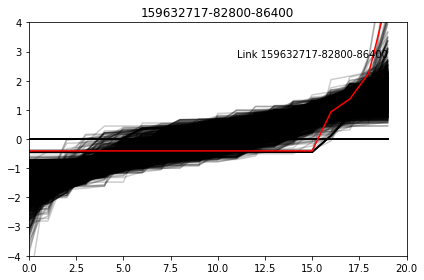

251100155-82800-86400
[152746500, 82800, 86400]: 2.7144835701531846
[547531528, 82800, 86400]: 3.947849496308585
[547531527, 82800, 86400]: 3.907012943800707
[420135389, 82800, 86400]: 2.7144835701531846
[8838071, 82800, 86400]: 3.3244535141049245
[301677886, 82800, 86400]: 2.7144835701531846
[152978752, 82800, 86400]: 4.145165232972365
[547531535, 82800, 86400]: 2.7144835701531846
[547531525, 82800, 86400]: 2.7144835701531846
[159632718, 82800, 86400]: 4.696654322826448
[547531531, 82800, 86400]: 3.7575231080097695
[547531534, 82800, 86400]: 3.763638083198257
[547531536, 82800, 86400]: 3.956376732893272
[47876615, 82800, 86400]: 0.0
[515675204, 82800, 86400]: 3.3229359303307833
[153947334, 82800, 86400]: 3.8104584324134736
[103934334, 82800, 86400]: 2.7144835701531846
[153947335, 82800, 86400]: 3.322012534397316
[301677885, 82800, 86400]: 2.7144835701531846
[634307497, 82800, 86400]: 2.7144835701531846
[157490277, 82800, 86400]: 2.7144835701531846
[297830232, 82800, 86400]: 3.32167866

[152996534, 0, 3600]: 2.7144835701531846
[104082880, 0, 3600]: 2.7144835701531846
[152967646, 0, 3600]: 3.8902251272036694
[423239438, 0, 3600]: 4.3024667575288085
[675092020, 0, 3600]: 3.5900477089323433
[697819363, 0, 3600]: 2.7144835701531846
[423724842, 0, 3600]: 4.041367170322697
[157489834, 0, 3600]: 4.251682291036562
[152978672, 0, 3600]: 4.4988460936573835
[547531516, 0, 3600]: 4.69172009674999
[440521424, 0, 3600]: 4.70586288649593
[297971534, 0, 3600]: 0.0
[157488722, 0, 3600]: 2.7144835701531846
[152967148, 0, 3600]: 0.0
[152679218, 0, 3600]: 4.334047226097243
[780911242, 0, 3600]: 3.989144307345816
[104081781, 0, 3600]: 2.7144835701531846
[153019269, 0, 3600]: 4.483501424397504
[152679413, 0, 3600]: 4.014586537997947
[160451376, 0, 3600]: 2.7144835701531846
[299893502, 0, 3600]: 3.324281039346503
[174924979, 0, 3600]: 4.477776458529839
[718963842, 0, 3600]: 2.7144835701531846
[104082865, 0, 3600]: 2.7144835701531846
[718963897, 0, 3600]: 3.351602750510581
[159632877, 0, 360

[441497930, 0, 3600]: 2.7144835701531846
[298337589, 0, 3600]: 4.11155030858536
[420095473, 0, 3600]: 3.480853628175335
[423239429, 0, 3600]: 4.619287740718841
[688769627, 0, 3600]: 4.677115362619557
[675092021, 0, 3600]: 3.5896486548550026
[299893498, 0, 3600]: 4.085038911338647
[159632858, 0, 3600]: 2.7144835701531846
[299081200, 0, 3600]: 4.500326753810272
[104081780, 0, 3600]: 2.7144835701531846
[385619164, 0, 3600]: 4.693437393720845
[299893499, 0, 3600]: 4.110229289460602
[420095474, 0, 3600]: 2.7144835701531846
[438172985, 0, 3600]: 4.168587119950123
[153946072, 0, 3600]: 2.7144835701531846
[152679414, 0, 3600]: 3.3207174956488426
[711385801, 0, 3600]: 4.578724838905983
[152995654, 0, 3600]: 2.7144835701531846
[344851269, 0, 3600]: 4.030846632482359
[152665029, 0, 3600]: 2.7144835701531846
[153947088, 0, 3600]: 4.72736965936736
[423239431, 0, 3600]: 4.544848506534786
[152679219, 0, 3600]: 4.098053530404785
[160451374, 0, 3600]: 4.1291983694762
[320136003, 0, 3600]: 2.71448357015

[441315037, 68400, 72000]: 3.3140373941698944
[234332717, 3600, 7200]: 2.7144835701531846
[153035119, 3600, 7200]: 2.7144835701531846
[152925434, 3600, 7200]: 2.7144835701531846
[160462985, 3600, 7200]: 2.7144835701531846
[153035249, 3600, 7200]: 2.7144835701531846
[153035118, 3600, 7200]: 2.7144835701531846
[160444149, 3600, 7200]: 2.7144835701531846
[298930273, 3600, 7200]: 2.7144835701531846
[160462988, 3600, 7200]: 2.7144835701531846
[160462986, 3600, 7200]: 2.7144835701531846
[153035250, 3600, 7200]: 2.7144835701531846
[298925920, 3600, 7200]: 2.7144835701531846
[126243421, 3600, 7200]: 2.7144835701531846
[189465475, 3600, 7200]: 2.7144835701531846
[238611390, 3600, 7200]: 2.7144835701531846
[134801094, 3600, 7200]: 2.7144835701531846
[780970456, 3600, 7200]: 3.3516027505105543
[154534953, 3600, 7200]: 2.7144835701531846
[152928147, 3600, 7200]: 3.31428290087936
[141129800, 3600, 7200]: 2.7144835701531846
[153022809, 3600, 7200]: 2.7144835701531846
[346316337, 3600, 7200]: 2.71448

[420076103, 61200, 64800]: 4.763333830867511
[152668404, 61200, 64800]: 4.778324768132759
[152967668, 61200, 64800]: 2.7144835701531846
[441250624, 61200, 64800]: 4.05955866079951
[519178541, 61200, 64800]: 3.3361112885799065
[152924165, 61200, 64800]: 3.919367549798476
[228275506, 61200, 64800]: 2.7144835701531846
[154149777, 61200, 64800]: 4.212522175703017
[298930275, 61200, 64800]: 2.7144835701531846
[441315035, 61200, 64800]: 3.863275668020794
[552008936, 61200, 64800]: 3.30384172097152
[8578406, 61200, 64800]: 2.7144835701531846
[152924176, 61200, 64800]: 3.284549021903998
[373003259, 61200, 64800]: 4.188187969396482
[441315036, 61200, 64800]: 2.7144835701531846
[298703037, 61200, 64800]: 4.202998053925527
[420076102, 61200, 64800]: 4.752182050188291
[441250622, 61200, 64800]: 4.539080409970462
[152924172, 61200, 64800]: 3.913094219503435
[441250625, 61200, 64800]: 4.122580925835956
[228275503, 61200, 64800]: 2.7144835701531846
[152924174, 61200, 64800]: 2.7144835701531846
[15292

[385793313, 7200, 10800]: 4.374485706661702
[159632733, 7200, 10800]: 4.676888098196531
[286685268, 7200, 10800]: 4.739602784991173
[298337587, 7200, 10800]: 2.7144835701531846
[152900439, 7200, 10800]: 3.3245112933357945
[443397610, 7200, 10800]: 3.3516027505105543
[238618776, 7200, 10800]: 2.7144835701531846
[152746469, 7200, 10800]: 3.8274172501854706
[160451379, 7200, 10800]: 4.669283869948087
[152977282, 7200, 10800]: 2.7144835701531846
[780970462, 7200, 10800]: 2.7144835701531846
[238611392, 7200, 10800]: 2.7144835701531846
[152665036, 7200, 10800]: 3.642193308860393
[238618780, 7200, 10800]: 2.7144835701531846
[152967197, 7200, 10800]: 4.0192894980748095
[780970458, 7200, 10800]: 2.7144835701531846
[423239443, 7200, 10800]: 4.671396154959374
[153043580, 7200, 10800]: 4.573945335361483
[319927897, 7200, 10800]: 4.480375332328703
[159632714, 7200, 10800]: 4.634459675644267
[153043516, 7200, 10800]: 2.7144835701531846
[152665053, 7200, 10800]: 2.7144835701531846
[238618787, 7200, 1

[160438448, 79200, 82800]: 4.581795150014798
[153035184, 79200, 82800]: 4.625231857554919
[676441316, 79200, 82800]: 4.117636867820498
[153044307, 79200, 82800]: 4.684918668913859
[441341846, 79200, 82800]: 4.625244288321988
[153948153, 79200, 82800]: 4.577889326041282
[153043605, 79200, 82800]: 4.669747109728973
[152656953, 79200, 82800]: 4.685627245236285
[275345115, 79200, 82800]: 2.7144835701531846
[8035570, 79200, 82800]: 4.587956201798506
[298237456, 79200, 82800]: 4.510575276938438
[152995672, 79200, 82800]: 4.6368545717495895
[46262602, 79200, 82800]: 3.929401453361979
[191003437, 79200, 82800]: 4.613106617440154
[189676997, 79200, 82800]: 4.583956431509221
[610571168, 79200, 82800]: 4.288809128772754
[252392937, 79200, 82800]: 4.63951437324807
[152651308, 79200, 82800]: 4.725041312354784
[153006813, 79200, 82800]: 4.579295797118898
[245334303, 79200, 82800]: 4.065480419704931
[502511292, 79200, 82800]: 3.9537407024959186
[153004052, 79200, 82800]: 3.746409540692537
[610949940,

[298932006, 79200, 82800]: 4.661554142225297
[161620498, 79200, 82800]: 4.559699092478978
[441265799, 79200, 82800]: 4.610372132037973
[160449037, 79200, 82800]: 4.436071269802176
[780483743, 79200, 82800]: 4.255171791614092
[487855864, 79200, 82800]: 4.170883508364882
[161620478, 79200, 82800]: 4.840693672128194
[781830254, 79200, 82800]: 4.47213595499958
[152679405, 79200, 82800]: 4.476967121666551
[153043599, 79200, 82800]: 4.158098495302151
[298703032, 79200, 82800]: 4.40998466732799
[160462990, 79200, 82800]: 4.200472588620794
[159740338, 79200, 82800]: 4.6048792249150585
[678035897, 79200, 82800]: 4.056858771186938
[298234501, 79200, 82800]: 4.612543282407635
[320136000, 79200, 82800]: 3.3194004169700624
[22810759, 79200, 82800]: 4.622512262781326
[298822858, 79200, 82800]: 4.102998936808978
[153019292, 79200, 82800]: 3.8425761727450576
[463524793, 79200, 82800]: 4.406029222743936
[160458424, 79200, 82800]: 3.5742269336662233
[153798137, 79200, 82800]: 4.563541657678551
[41817809

[320136009, 79200, 82800]: 4.6794622730331605
[299018407, 79200, 82800]: 4.684256869579807
[189452928, 79200, 82800]: 4.697922658450826
[152679372, 79200, 82800]: 4.701631428835556
[297996746, 79200, 82800]: 3.961261608591031
[228275509, 79200, 82800]: 4.1705526360715695
[320064977, 79200, 82800]: 2.7144835701531846
[160443450, 79200, 82800]: 4.645981208506698
[104081738, 79200, 82800]: 4.6436412699190255
[505168991, 79200, 82800]: 4.6128693182354485
[157489531, 79200, 82800]: 4.712756407811199
[780964776, 79200, 82800]: 4.657463775117197
[152679279, 79200, 82800]: 4.081699142280218
[344851273, 79200, 82800]: 4.517156769876743
[152746391, 79200, 82800]: 4.5790907128652245
[298877134, 79200, 82800]: 4.656550646894006
[298925926, 79200, 82800]: 4.504550300252951
[780989738, 79200, 82800]: 4.486427573855154
[491822821, 79200, 82800]: 4.396894304947728
[152746448, 79200, 82800]: 4.489580220716516
[408268176, 79200, 82800]: 4.664614578335043
[251098642, 79200, 82800]: 4.630232499703514
[159

[252835217, 79200, 82800]: 4.4772215314239245
[423724815, 79200, 82800]: 4.677854840872162
[424918855, 79200, 82800]: 4.579245277041879
[234439477, 79200, 82800]: 4.752556919663619
[385621391, 79200, 82800]: 4.778415390126525
[34700812, 79200, 82800]: 4.6735713199683735
[153035146, 79200, 82800]: 2.7144835701531846
[152995668, 79200, 82800]: 4.2848495502237425
[299081212, 79200, 82800]: 2.7144835701531846
[420076292, 79200, 82800]: 2.7144835701531846
[155685567, 79200, 82800]: 4.120755263837488
[153055990, 79200, 82800]: 4.672345970987194
[8035452, 79200, 82800]: 4.716275614140238
[248762962, 79200, 82800]: 4.646591572936785
[439048438, 79200, 82800]: 4.162470363827488
[46262600, 79200, 82800]: 4.592243625934497
[480289612, 79200, 82800]: 4.422680440461663
[781786569, 79200, 82800]: 4.562482451002098
[463524785, 79200, 82800]: 4.392338292648805
[81869222, 79200, 82800]: 4.629369544758863
[299094984, 79200, 82800]: 4.137272031081829
[152924204, 79200, 82800]: 2.7144835701531846
[1888423

[572708716, 79200, 82800]: 4.68635370572094
[502511306, 79200, 82800]: 4.216813071901452
[152900400, 79200, 82800]: 4.263586344761524
[298877136, 79200, 82800]: 4.632112264604332
[188842290, 79200, 82800]: 4.641788432138887
[155685561, 79200, 82800]: 4.47213595499958
[152994913, 79200, 82800]: 4.055344979484815
[159740335, 79200, 82800]: 4.6114329532106675
[159632882, 79200, 82800]: 4.251612372808633
[152654159, 79200, 82800]: 4.710016910788239
[440521428, 79200, 82800]: 4.3095215995886145
[153035198, 79200, 82800]: 2.7144835701531846
[385619277, 79200, 82800]: 5.206925148474558
[298029511, 79200, 82800]: 4.670489810445827
[697192601, 79200, 82800]: 3.3177374790346783
[152746492, 79200, 82800]: 4.515690177402125
[160443452, 79200, 82800]: 4.6308761580822155
[346316354, 79200, 82800]: 4.478054259072756
[418178089, 79200, 82800]: 4.495024090080846
[152980836, 79200, 82800]: 3.9900770573672455
[8578429, 79200, 82800]: 3.952274240906312
[135719160, 79200, 82800]: 4.632134244052171
[4414555

[439048440, 79200, 82800]: 4.025024364914855
[640180488, 79200, 82800]: 4.250716099288517
[298822860, 79200, 82800]: 4.103271889738458
[247141036, 79200, 82800]: 4.561446141309121
[152994906, 79200, 82800]: 4.683165137391574
[275345123, 79200, 82800]: 4.3043378986612755
[188842243, 79200, 82800]: 4.804222393157192
[221553429, 79200, 82800]: 4.68641704350614
[424918870, 79200, 82800]: 4.4826291242284295
[780908568, 79200, 82800]: 4.628515542593121
[155685560, 79200, 82800]: 4.482673006934555
[441265806, 79200, 82800]: 4.653131113107582
[152668388, 79200, 82800]: 4.509207153710378
[327005896, 79200, 82800]: 4.5760711823820515
[153019260, 79200, 82800]: 4.585502453315734
[153053637, 79200, 82800]: 3.960403851438508
[411394830, 79200, 82800]: 4.749255956859622
[665834894, 79200, 82800]: 4.520177141036281
[160469991, 79200, 82800]: 4.0478546810342255
[159740414, 79200, 82800]: 4.276903830505451
[697192669, 79200, 82800]: 4.035701600235537
[8035563, 79200, 82800]: 4.562520924243097
[91978079

[440521427, 79200, 82800]: 4.3057798812465515
[153045281, 79200, 82800]: 3.9466659081140794
[46932871, 79200, 82800]: 4.040732741345109
[153049973, 79200, 82800]: 4.670989860642922
[152967874, 79200, 82800]: 4.628471314399174
[160441412, 79200, 82800]: 2.7144835701531846
[221553412, 79200, 82800]: 4.428020310894962
[34700802, 79200, 82800]: 4.781269884197924
[297883457, 79200, 82800]: 4.434911941087027
[152656946, 79200, 82800]: 4.662821546527636
[8035584, 79200, 82800]: 4.685987028410924
[47876608, 79200, 82800]: 3.313448785655351
[188842229, 79200, 82800]: 4.672631446696338
[195407897, 79200, 82800]: 4.480437802859081
[172232827, 79200, 82800]: 4.610594394292583
[423729715, 79200, 82800]: 2.7144835701531846
[152994904, 79200, 82800]: 4.704875763734431
[515699251, 79200, 82800]: 4.504657713280512
[373003231, 79200, 82800]: 3.6188484056260584
[153041715, 79200, 82800]: 4.44583734346949
[298822861, 79200, 82800]: 3.7766398697699697
[195407898, 79200, 82800]: 4.472135954999579
[516508096

[459684532, 79200, 82800]: 3.817506329713182
[298926207, 79200, 82800]: 4.429195705603024
[160455779, 79200, 82800]: 4.447115685103619
[152900398, 79200, 82800]: 4.208377284279688
[153000838, 79200, 82800]: 4.2742819766891955
[153945674, 79200, 82800]: 4.674968603813895
[298786499, 79200, 82800]: 4.16714040323797
[153053561, 79200, 82800]: 4.687136840091299
[248762958, 79200, 82800]: 4.553240877139287
[195407910, 79200, 82800]: 4.47213595499958
[238609965, 79200, 82800]: 3.8988000149538786
[152967746, 79200, 82800]: 3.311967268161307
[189663721, 79200, 82800]: 4.27672956375151
[104081820, 79200, 82800]: 4.6046986265222305
[678316018, 79200, 82800]: 3.300057261233675
[153004054, 79200, 82800]: 3.9477737271483955
[188842320, 79200, 82800]: 4.371270870170932
[153053683, 79200, 82800]: 4.513216332654963
[251098936, 79200, 82800]: 2.7144835701531846
[152924199, 79200, 82800]: 2.7144835701531846
[153049970, 79200, 82800]: 4.647568432557804
[8838080, 79200, 82800]: 4.990607854833425
[15300084

[160458422, 79200, 82800]: 3.85409496436866
[152924206, 79200, 82800]: 4.566322202311557
[438177908, 79200, 82800]: 3.323910631084097
[152924944, 79200, 82800]: 4.192805307711538
[160443456, 79200, 82800]: 4.638319808845246
[298337593, 79200, 82800]: 4.066986613664205
[188842331, 79200, 82800]: 4.525234051597574
[46932864, 79200, 82800]: 4.042366851023666
[423729709, 79200, 82800]: 2.7144835701531846
[217603105, 79200, 82800]: 4.485761491251383
[252392947, 79200, 82800]: 4.433186131265419
[22810762, 79200, 82800]: 4.653087305722601
[297826869, 79200, 82800]: 4.5821210901880045
[153035158, 79200, 82800]: 4.47213595499958
[154149755, 79200, 82800]: 4.27554370436535
[301724762, 79200, 82800]: 4.486600612994336
[152994903, 79200, 82800]: 4.645346670890402
[154535120, 79200, 82800]: 4.534118874375719
[153049909, 79200, 82800]: 4.548244613613293
[153024147, 79200, 82800]: 4.630288654140608
[299045408, 79200, 82800]: 3.5354359967900457
[385334135, 79200, 82800]: 3.827557613236028
[188842253, 

[153000842, 79200, 82800]: 4.276328639270753
[8578430, 79200, 82800]: 4.052940430850192
[46429886, 79200, 82800]: 3.9567909007810758
[301724756, 79200, 82800]: 4.501178310770587
[420135396, 79200, 82800]: 4.523615990083009
[160444156, 79200, 82800]: 4.640546839546025
[589546214, 79200, 82800]: 4.796283325387424
[188842323, 79200, 82800]: 4.346330221705688
[152679346, 79200, 82800]: 4.472135954999579
[160466237, 79200, 82800]: 3.9639999002435298
[441455569, 79200, 82800]: 4.66853829734984
[442373726, 79200, 82800]: 4.536459029207571
[46262603, 79200, 82800]: 4.083040576783356
[189452942, 79200, 82800]: 4.085880191537603
[188842338, 79200, 82800]: 4.218630116512844
[502501397, 79200, 82800]: 4.537181670997779
[152656948, 79200, 82800]: 4.72671993557085
[385334136, 79200, 82800]: 4.08548446040885
[697192632, 79200, 82800]: 4.161835015140948
[154539316, 79200, 82800]: 4.0304603107159975
[780539489, 79200, 82800]: 4.670349706911005
[188842288, 79200, 82800]: 4.840779294360055
[153041734, 79

[459670496, 79200, 82800]: 4.62599695150799
[297975532, 79200, 82800]: 4.672710275203215
[238609961, 79200, 82800]: 3.964779153549663
[440644906, 79200, 82800]: 4.592234129756413
[676152421, 79200, 82800]: 3.581547472591251
[152995670, 79200, 82800]: 4.640354370838386
[161620474, 79200, 82800]: 4.229719310451548
[152679201, 79200, 82800]: 4.1130175025253575
[463337404, 79200, 82800]: 4.615648228716923
[502501400, 79200, 82800]: 4.775686217161486
[502511310, 79200, 82800]: 4.6315556141607885
[188842328, 79200, 82800]: 4.4706978948439655
[153043602, 79200, 82800]: 4.563579460539195
[153006812, 79200, 82800]: 4.583680016591337
[152668399, 79200, 82800]: 4.398003896527013
[152679349, 79200, 82800]: 4.531591077863541
[8578415, 79200, 82800]: 2.7144835701531846
[195407915, 79200, 82800]: 4.630743888619969
[301677361, 79200, 82800]: 4.644724687917468
[8035556, 79200, 82800]: 4.310160654850697
[320135996, 79200, 82800]: 2.7144835701531846
[385334146, 79200, 82800]: 3.307176790929896
[228275469

[153004060, 79200, 82800]: 4.080907175505226
[344851268, 79200, 82800]: 4.546987417459956
[8578420, 79200, 82800]: 2.7144835701531846
[780526398, 79200, 82800]: 4.056288264332666
[160451441, 79200, 82800]: 4.1899250612328816
[547531544, 79200, 82800]: 4.073055060877287
[152994916, 79200, 82800]: 4.069475103874128
[46414936, 79200, 82800]: 3.6926463123548423
[440522454, 79200, 82800]: 4.654372202619552
[515699256, 79200, 82800]: 5.215796376141497
[157490274, 79200, 82800]: 4.537337351516879
[160438438, 79200, 82800]: 4.148168542664334
[493523049, 79200, 82800]: 2.7144835701531846
[81797655, 79200, 82800]: 4.643983300232646
[188842237, 79200, 82800]: 4.630447260141706
[195407895, 79200, 82800]: 4.4943633933408265
[298925936, 79200, 82800]: 4.624149336356704
[104082895, 79200, 82800]: 3.6000055681013734
[152924201, 79200, 82800]: 4.78393431519591
[275345100, 79200, 82800]: 4.228874705136283
[153049910, 79200, 82800]: 4.578796072503718
[441455576, 79200, 82800]: 4.613562403924472
[61057117

[298925977, 79200, 82800]: 4.531466270180081
[152653014, 79200, 82800]: 4.625108718499728
[153044309, 79200, 82800]: 4.147814454529092
[8035566, 79200, 82800]: 4.49484218026626
[152746381, 79200, 82800]: 4.504792794144268
[141130093, 79200, 82800]: 4.2403599492588
[463524781, 79200, 82800]: 2.7144835701531846
[153049915, 79200, 82800]: 4.679982616994102
[572708712, 79200, 82800]: 4.055488880489703
[188842276, 79200, 82800]: 4.865612449767183
[344851264, 79200, 82800]: 4.426519918992885
[298925923, 79200, 82800]: 4.494661683332646
[152924946, 79200, 82800]: 4.291795480939936
[245336353, 79200, 82800]: 4.073698052395343
[298932005, 79200, 82800]: 4.65634432705497
[491822824, 79200, 82800]: 4.514798386366389
[152977264, 79200, 82800]: 3.6942928087588065
[649730255, 79200, 82800]: 4.621517392484273
[297971530, 79200, 82800]: 4.172467877741602
[195407908, 79200, 82800]: 4.47213595499958
[159740897, 79200, 82800]: 4.184930129205171
[154535121, 79200, 82800]: 4.440813831842822
[152978734, 792

[189452920, 79200, 82800]: 4.650706310059802
[440522450, 79200, 82800]: 4.66040480893575
[325598327, 79200, 82800]: 4.504706986040315
[674556441, 79200, 82800]: 4.640469141420151
[234439478, 79200, 82800]: 4.616910016045431
[610577097, 79200, 82800]: 4.394208516856523
[60712872, 79200, 82800]: 4.65945617024943
[297883458, 79200, 82800]: 4.428744651049084
[46414967, 79200, 82800]: 4.543945288595742
[152746496, 79200, 82800]: 2.7144835701531846
[152966818, 79200, 82800]: 4.622976087837988
[152746369, 79200, 82800]: 4.612705586688267
[286685247, 79200, 82800]: 4.601914319630859
[252835224, 79200, 82800]: 4.488612261634903
[385334127, 79200, 82800]: 2.7144835701531846
[676436350, 79200, 82800]: 4.555121190737709
[676950800, 79200, 82800]: 4.418390376584948
[154539318, 79200, 82800]: 4.052589112496056
[141130090, 79200, 82800]: 4.431533448422474
[153004046, 79200, 82800]: 3.771602208352258
[259109264, 79200, 82800]: 3.5809524835686726
[152900392, 79200, 82800]: 4.693477376597304
[160455782,

[160466238, 79200, 82800]: 3.9135585418708514
[46932865, 79200, 82800]: 4.059888359200686
[301724744, 79200, 82800]: 4.385595632067201
[480289640, 79200, 82800]: 4.293750280563127
[46932863, 79200, 82800]: 4.05850511221568
[152976626, 79200, 82800]: 4.518996377229908
[153044290, 79200, 82800]: 4.517750393418028
[298699135, 79200, 82800]: 4.612144490072335
[697192593, 79200, 82800]: 3.524486831938074
[547531551, 79200, 82800]: 3.680917285510389
[480289593, 79200, 82800]: 4.683144554431912
[259110129, 79200, 82800]: 2.7144835701531846
[153022657, 79200, 82800]: 4.618378474420606
[423729708, 79200, 82800]: 2.7144835701531846
[480289611, 79200, 82800]: 4.411751753254803
[152746411, 79200, 82800]: 4.559462393845921
[610571179, 79200, 82800]: 4.634093780877496
[152994907, 79200, 82800]: 4.6274931953167355
[780483748, 79200, 82800]: 4.291605344326103
[320135995, 79200, 82800]: 2.7144835701531846
[251098644, 79200, 82800]: 4.636792420018033
[152966817, 79200, 82800]: 4.613277176039482
[3856192

[157488906, 46800, 50400]: 3.301365401165206
[676950778, 46800, 50400]: 3.89938592725887
[676950791, 46800, 50400]: 2.7144835701531846
[152679412, 46800, 50400]: 3.614903016797507
[8035440, 46800, 50400]: 3.306873485442446
[385334113, 46800, 50400]: 2.7144835701531846
[418094196, 46800, 50400]: 4.560868052794502
[46594682, 46800, 50400]: 3.9361988393668788
[423239425, 46800, 50400]: 4.593664981289789
[385334111, 46800, 50400]: 2.7144835701531846
[441290399, 46800, 50400]: 2.7144835701531846
[252835227, 46800, 50400]: 3.3211005283419515
[152900408, 46800, 50400]: 2.7144835701531846
[299018413, 46800, 50400]: 3.8491535451937127
[160458426, 46800, 50400]: 2.7144835701531846
[152746398, 46800, 50400]: 4.045601979122427
[152980865, 46800, 50400]: 4.594176255897382
[780989737, 46800, 50400]: 2.7144835701531846
[153035200, 46800, 50400]: 2.7144835701531846
[649730256, 46800, 50400]: 3.9613024276087847
[152977281, 46800, 50400]: 2.7144835701531846
[438172979, 46800, 50400]: 2.7144835701531846


[152967902, 32400, 36000]: 3.750640014427922
[152967901, 32400, 36000]: 3.3023755701700375
[153021397, 32400, 36000]: 2.7144835701531846
[152656971, 32400, 36000]: 2.7144835701531846
[152978761, 32400, 36000]: 2.7144835701531846
[152967898, 32400, 36000]: 3.9166507949167753
[298549724, 32400, 36000]: 2.7144835701531846
[152656961, 32400, 36000]: 2.7144835701531846
[153050020, 32400, 36000]: 2.7144835701531846
[298623928, 32400, 36000]: 2.7144835701531846
[153050026, 32400, 36000]: 2.7144835701531846
[152656960, 32400, 36000]: 2.7144835701531846
[781830257, 32400, 36000]: 2.7144835701531846
[298424778, 32400, 36000]: 2.7144835701531846
[160451459, 32400, 36000]: 2.7144835701531846
[160451456, 32400, 36000]: 2.7144835701531846
[775436067, 32400, 36000]: 3.3069112631486743
[152656963, 32400, 36000]: 2.7144835701531846
[152967900, 32400, 36000]: 3.3085732973668867
[153050106, 32400, 36000]: 3.78001560193403
[152967899, 32400, 36000]: 3.6810691160516744
[153050021, 32400, 36000]: 2.71448357

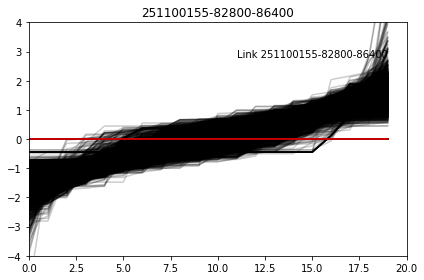

152980843-0-3600
[152746500, 82800, 86400]: 1.5033081662262628
[547531528, 82800, 86400]: 1.3721955862773532
[547531527, 82800, 86400]: 0.5640420939313858
[420135389, 82800, 86400]: 1.5033081662262628
[8838071, 82800, 86400]: 1.0178675670054602
[301677886, 82800, 86400]: 1.5033081662262628
[152978752, 82800, 86400]: 1.0120121572566998
[547531535, 82800, 86400]: 1.5033081662262628
[547531525, 82800, 86400]: 1.5033081662262628
[159632718, 82800, 86400]: 0.42109728264730806
[547531531, 82800, 86400]: 0.8478051466361823
[547531534, 82800, 86400]: 0.8297945509361461
[547531536, 82800, 86400]: 1.4221569591567438
[47876615, 82800, 86400]: 4.72267351464458
[515675204, 82800, 86400]: 1.0739141764320508
[153947334, 82800, 86400]: 0.9817091281926438
[103934334, 82800, 86400]: 1.5033081662262628
[153947335, 82800, 86400]: 1.0015198897852904
[301677885, 82800, 86400]: 1.5033081662262628
[634307497, 82800, 86400]: 1.5033081662262628
[157490277, 82800, 86400]: 1.5033081662262628
[297830232, 82800, 86

[160451372, 0, 3600]: 2.753313722777191
[440530050, 0, 3600]: 1.5033081662262628
[161620465, 0, 3600]: 0.6431303187064993
[153000853, 0, 3600]: 0.5578921324683851
[152980882, 0, 3600]: 0.5515691096245672
[228275491, 0, 3600]: 0.9197918412658806
[154150230, 0, 3600]: 1.9381622793455142
[152996534, 0, 3600]: 1.5033081662262628
[104082880, 0, 3600]: 1.5033081662262628
[152967646, 0, 3600]: 0.735818126085289
[423239438, 0, 3600]: 0.5965200307969448
[675092020, 0, 3600]: 0.85363120385337
[697819363, 0, 3600]: 1.5033081662262628
[423724842, 0, 3600]: 1.5823950199053978
[157489834, 0, 3600]: 0.7563731650972052
[152978672, 0, 3600]: 0.8684641376103144
[547531516, 0, 3600]: 0.35480735926231355
[440521424, 0, 3600]: 0.3900258596503495
[297971534, 0, 3600]: 4.72267351464458
[157488722, 0, 3600]: 1.5033081662262628
[152967148, 0, 3600]: 4.72267351464458
[152679218, 0, 3600]: 1.4034854838537538
[780911242, 0, 3600]: 0.7031820048890158
[104081781, 0, 3600]: 1.5033081662262628
[153019269, 0, 3600]: 0

[104082879, 0, 3600]: 2.1270970071782287
[441304011, 0, 3600]: 4.72267351464458
[152679382, 0, 3600]: 1.0015202235349374
[440530048, 0, 3600]: 1.5033081662262628
[104082858, 0, 3600]: 1.5572592764681592
[153947087, 0, 3600]: 0.9223882732770972
[154535124, 0, 3600]: 0.5516584041019094
[697819364, 0, 3600]: 1.5033081662262628
[154537265, 0, 3600]: 1.4788174523998436
[718963676, 0, 3600]: 1.5033081662262628
[234345996, 0, 3600]: 4.72267351464458
[441304001, 0, 3600]: 1.1977192367829663
[502501384, 0, 3600]: 1.5033081662262628
[153006793, 0, 3600]: 1.5500646834044296
[152895056, 0, 3600]: 1.5033081662262628
[134801107, 0, 3600]: 1.5033081662262628
[688769623, 0, 3600]: 0.4286497390967419
[152679221, 0, 3600]: 1.0070373848736247
[718963662, 0, 3600]: 1.5033081662262628
[681329980, 0, 3600]: 0.34195543664060224
[441497930, 0, 3600]: 1.5033081662262628
[298337589, 0, 3600]: 1.2705169147730728
[420095473, 0, 3600]: 1.2007505399555567
[423239429, 0, 3600]: 0.5660011994872856
[688769627, 0, 3600

[780970474, 10800, 14400]: 1.5033081662262628
[780970475, 10800, 14400]: 1.5033081662262628
[104081800, 10800, 14400]: 1.002036006748629
[234345983, 10800, 14400]: 1.5033081662262628
[780970468, 10800, 14400]: 1.5033081662262628
[8035490, 10800, 14400]: 1.5033081662262628
[189424065, 10800, 14400]: 1.5033081662262628
[22810921, 10800, 14400]: 1.3695454626789247
[298616215, 10800, 14400]: 1.5033081662262628
[711385802, 10800, 14400]: 0.4996572198700697
[153019248, 10800, 14400]: 1.5033081662262628
[238618789, 10800, 14400]: 1.5033081662262628
[298616195, 10800, 14400]: 1.5033081662262628
[697192649, 68400, 72000]: 1.3681075151216437
[697192648, 68400, 72000]: 1.5033081662262628
[153035114, 68400, 72000]: 1.5033081662262628
[697192623, 68400, 72000]: 1.0339252632205327
[441315037, 68400, 72000]: 1.272690303283014
[234332717, 3600, 7200]: 1.5033081662262628
[153035119, 3600, 7200]: 1.5033081662262628
[152925434, 3600, 7200]: 1.5033081662262628
[160462985, 3600, 7200]: 1.5033081662262628
[

[152679310, 61200, 64800]: 1.5033081662262628
[152679385, 61200, 64800]: 0.9397102798232801
[780577557, 61200, 64800]: 1.5033081662262628
[441250623, 61200, 64800]: 1.086000189501567
[47876616, 61200, 64800]: 0.3996650360787019
[152978663, 61200, 64800]: 0.4311105395383017
[297882686, 61200, 64800]: 0.3905288274091987
[152679274, 61200, 64800]: 0.7640832697484252
[298699139, 61200, 64800]: 0.6944867852484063
[373003260, 61200, 64800]: 0.6847428369517035
[695018705, 61200, 64800]: 1.2145540249354247
[420076103, 61200, 64800]: 0.9890933751030625
[152668404, 61200, 64800]: 0.4983189257261962
[152967668, 61200, 64800]: 1.5033081662262628
[441250624, 61200, 64800]: 0.6983516459198265
[519178541, 61200, 64800]: 0.7100067941989096
[152924165, 61200, 64800]: 1.2364653988044603
[228275506, 61200, 64800]: 1.5033081662262628
[154149777, 61200, 64800]: 0.4943365376119578
[298930275, 61200, 64800]: 1.5033081662262628
[441315035, 61200, 64800]: 1.0841188616005155
[552008936, 61200, 64800]: 0.6874460

[427846841, 7200, 10800]: 0.905746537425331
[385793313, 7200, 10800]: 0.4383306557303917
[159632733, 7200, 10800]: 0.629807058512305
[286685268, 7200, 10800]: 0.38973266537104556
[298337587, 7200, 10800]: 1.5033081662262628
[152900439, 7200, 10800]: 0.9997508767292083
[443397610, 7200, 10800]: 2.1270970071782282
[238618776, 7200, 10800]: 1.5033081662262628
[152746469, 7200, 10800]: 0.6949934223116497
[160451379, 7200, 10800]: 0.368691686788802
[152977282, 7200, 10800]: 1.5033081662262628
[780970462, 7200, 10800]: 1.5033081662262628
[238611392, 7200, 10800]: 1.5033081662262628
[152665036, 7200, 10800]: 0.573881522284019
[238618780, 7200, 10800]: 1.5033081662262628
[152967197, 7200, 10800]: 0.7600579092231626
[780970458, 7200, 10800]: 1.5033081662262628
[423239443, 7200, 10800]: 0.3294888971512205
[153043580, 7200, 10800]: 0.4694619433713018
[319927897, 7200, 10800]: 0.5285928558207194
[159632714, 7200, 10800]: 0.5210330551250075
[153043516, 7200, 10800]: 1.5033081662262628
[152665053, 7

[697192646, 64800, 68400]: 1.000275797770254
[440521435, 64800, 68400]: 1.5033081662262628
[441250618, 57600, 61200]: 0.7373242498061672
[152978699, 57600, 61200]: 1.5033081662262628
[441250617, 57600, 61200]: 0.4482851323450319
[441250616, 57600, 61200]: 0.45922011554250874
[191003438, 57600, 61200]: 1.5033081662262628
[441250615, 57600, 61200]: 0.70570668308874
[191003420, 57600, 61200]: 1.5033081662262628
[441250611, 57600, 61200]: 0.6001505139551343
[441250614, 57600, 61200]: 0.4620369022770946
[441250612, 57600, 61200]: 0.4106080427975795
[504476752, 57600, 61200]: 4.72267351464458
[441250613, 57600, 61200]: 0.5582004476317367
[483472252, 36000, 39600]: 0.8546618664612367
[319929468, 36000, 39600]: 1.5033081662262628
[298237463, 36000, 39600]: 1.5033081662262628
[319929467, 36000, 39600]: 1.5033081662262628
[515102686, 36000, 39600]: 1.5033081662262628
[104082905, 36000, 39600]: 1.5033081662262628
[298237466, 36000, 39600]: 1.0002757977696588
[483472250, 36000, 39600]: 4.722673514

[191620663, 79200, 82800]: 1.0955296904293186
[22810756, 79200, 82800]: 0.4231083921979346
[153053621, 79200, 82800]: 1.0237939123378414
[676950799, 79200, 82800]: 0.3917028250280849
[153019295, 79200, 82800]: 1.318445699704844
[154534951, 79200, 82800]: 0.6093703686205367
[459670471, 79200, 82800]: 0.6263528647090504
[346316341, 79200, 82800]: 0.5262995585012606
[418178084, 79200, 82800]: 0.8952447514102418
[440644896, 79200, 82800]: 0.5959301036118771
[153035274, 79200, 82800]: 0.5021899072631079
[160444349, 79200, 82800]: 0.6404139474364046
[152679374, 79200, 82800]: 0.6326578081975661
[153945673, 79200, 82800]: 0.34435545107996657
[275345111, 79200, 82800]: 1.3674116751042849
[297975534, 79200, 82800]: 0.39095517209032155
[298616206, 79200, 82800]: 0.3819233977138572
[711367803, 79200, 82800]: 0.8710780410128824
[153044324, 79200, 82800]: 0.44870393095380573
[301603270, 79200, 82800]: 0.7203663743207506
[189676995, 79200, 82800]: 0.5031664648565711
[141129799, 79200, 82800]: 0.9514

[298782716, 79200, 82800]: 0.7618676951448891
[298237460, 79200, 82800]: 1.4303320244247688
[152994909, 79200, 82800]: 1.3068320281756902
[298691897, 79200, 82800]: 0.4308106852137799
[188842324, 79200, 82800]: 0.5203477479067131
[154539333, 79200, 82800]: 1.5033081662262628
[152746376, 79200, 82800]: 1.2867775437516036
[152895082, 79200, 82800]: 0.6590879208996705
[152656912, 79200, 82800]: 0.3461348858509456
[385334145, 79200, 82800]: 1.2625835804229322
[441455568, 79200, 82800]: 0.985734669156469
[157489530, 79200, 82800]: 0.37193803458447455
[153049904, 79200, 82800]: 0.9113395031137338
[298611224, 79200, 82800]: 0.9719586093345342
[34700796, 79200, 82800]: 0.3014248276109355
[153019291, 79200, 82800]: 1.423866097760632
[298786501, 79200, 82800]: 1.1552866365082641
[480289643, 79200, 82800]: 0.8639099057103083
[697192672, 79200, 82800]: 0.5722131081011439
[152978773, 79200, 82800]: 0.9293645106802687
[189677012, 79200, 82800]: 0.39350146214418047
[153035193, 79200, 82800]: 0.800697

[153019255, 79200, 82800]: 0.5644033593183726
[153053687, 79200, 82800]: 0.5859815016985991
[221553418, 79200, 82800]: 0.45634894378161206
[153021411, 79200, 82800]: 0.3900524376056775
[245334390, 79200, 82800]: 0.49138066189453977
[22810768, 79200, 82800]: 0.775994450296015
[8035519, 79200, 82800]: 0.5698351902989771
[480289568, 79200, 82800]: 2.140643753385512
[424918859, 79200, 82800]: 0.7576610082775799
[502511275, 79200, 82800]: 1.5033081662262628
[46429874, 79200, 82800]: 1.680751365977678
[299045398, 79200, 82800]: 1.5033081662262628
[104082939, 79200, 82800]: 0.6834722477488331
[251098779, 79200, 82800]: 1.2762415907841025
[298029510, 79200, 82800]: 0.9669148336091307
[298925924, 79200, 82800]: 0.7503612959758075
[301677372, 79200, 82800]: 0.4865650618312231
[502511304, 79200, 82800]: 0.3530112022698568
[423239445, 79200, 82800]: 1.0246097930333908
[252835217, 79200, 82800]: 0.6300223729587477
[423724815, 79200, 82800]: 0.33958431606951356
[424918855, 79200, 82800]: 0.827632108

[152679189, 79200, 82800]: 1.0971645465669455
[441250609, 79200, 82800]: 0.447083522524168
[441455563, 79200, 82800]: 0.6141431850789337
[189452930, 79200, 82800]: 0.39192036343461206
[298925981, 79200, 82800]: 0.7248378518141145
[245336351, 79200, 82800]: 1.3185858383987874
[245333411, 79200, 82800]: 0.5164284172457267
[161620514, 79200, 82800]: 1.2665305879857494
[299094971, 79200, 82800]: 0.5048904651015592
[217603102, 79200, 82800]: 1.1116281255183982
[189677006, 79200, 82800]: 0.5402556229381841
[516841623, 79200, 82800]: 0.39784297329621965
[245336352, 79200, 82800]: 1.7474907861310225
[780483747, 79200, 82800]: 1.1145099148220035
[152976627, 79200, 82800]: 0.40923229347580975
[153035179, 79200, 82800]: 0.4548246213702531
[153947390, 79200, 82800]: 0.5618878650354019
[189452946, 79200, 82800]: 0.3895620092205359
[441250598, 79200, 82800]: 0.7504018088972557
[152668412, 79200, 82800]: 1.1997736649511128
[409377698, 79200, 82800]: 0.6808677058122474
[159740346, 79200, 82800]: 0.757

[251098780, 79200, 82800]: 1.167098673644835
[443405862, 79200, 82800]: 0.9314571929380873
[153053557, 79200, 82800]: 0.39064572010699167
[252835218, 79200, 82800]: 0.5650952389701003
[298944623, 79200, 82800]: 0.5503388387074183
[385334128, 79200, 82800]: 1.5033081662262628
[238610489, 79200, 82800]: 0.5888397391293848
[34700793, 79200, 82800]: 0.4008063448678982
[157489539, 79200, 82800]: 0.5227527987634786
[245333275, 79200, 82800]: 0.5286704047524736
[153044306, 79200, 82800]: 0.5865899488108653
[298834963, 79200, 82800]: 1.0890031912222449
[159740345, 79200, 82800]: 0.4398193169958831
[152978665, 79200, 82800]: 0.8622009111403994
[298925943, 79200, 82800]: 0.37713172549018975
[160469981, 79200, 82800]: 0.6839432867561537
[152679199, 79200, 82800]: 0.8420225754009275
[301724753, 79200, 82800]: 0.46070910658589476
[153945677, 79200, 82800]: 0.3846597109837164
[572708713, 79200, 82800]: 1.4891066118746403
[46429871, 79200, 82800]: 1.434429305520622
[298926209, 79200, 82800]: 0.473623

[516508075, 79200, 82800]: 0.38655391027787955
[60712865, 79200, 82800]: 0.6643843782031592
[153035148, 79200, 82800]: 1.5033081662262628
[153006767, 79200, 82800]: 0.39137344619294745
[22810770, 79200, 82800]: 0.9151080266164906
[459684533, 79200, 82800]: 0.8641358995703079
[385334139, 79200, 82800]: 1.399258445529289
[297998490, 79200, 82800]: 1.5033081662262628
[152668384, 79200, 82800]: 0.6480878848921645
[298822852, 79200, 82800]: 1.2132579568913004
[299081209, 79200, 82800]: 0.3243059108240746
[502511291, 79200, 82800]: 1.3472242750811132
[228275512, 79200, 82800]: 1.224280665483768
[423729707, 79200, 82800]: 1.5033081662262628
[154535087, 79200, 82800]: 0.4569108376867701
[188842283, 79200, 82800]: 0.49865972632209654
[440644894, 79200, 82800]: 0.7293859773843289
[252392913, 79200, 82800]: 1.433649321802777
[298703038, 79200, 82800]: 0.40975564291887134
[298337591, 79200, 82800]: 0.9218285696322005
[697192640, 79200, 82800]: 1.8137127580335421
[34700818, 79200, 82800]: 0.4392395

[157489533, 79200, 82800]: 0.9231342480945166
[195407885, 79200, 82800]: 1.5033081662262628
[189452943, 79200, 82800]: 0.3485247311823349
[298786478, 79200, 82800]: 0.586160749642363
[217603103, 79200, 82800]: 0.5575800713889147
[301677371, 79200, 82800]: 0.49333964126331553
[298786493, 79200, 82800]: 1.1526322702239802
[152651322, 79200, 82800]: 1.1129558397617598
[245333278, 79200, 82800]: 0.8606149340523271
[420076290, 79200, 82800]: 1.5033081662262628
[188842334, 79200, 82800]: 1.5033081662262628
[299045395, 79200, 82800]: 1.5993733462346513
[91978078, 79200, 82800]: 0.9920556754322372
[153053572, 79200, 82800]: 0.8790354916813385
[153004032, 79200, 82800]: 1.355953697722855
[153044308, 79200, 82800]: 0.5638957476241296
[34700809, 79200, 82800]: 0.3532910859470683
[8578427, 79200, 82800]: 1.5033081662262628
[153004053, 79200, 82800]: 1.3239794020583933
[152656921, 79200, 82800]: 0.39316331968867
[160455775, 79200, 82800]: 0.4936186520306485
[298786502, 79200, 82800]: 1.030454137285

[259111669, 79200, 82800]: 1.5033081662262628
[423239422, 79200, 82800]: 0.6827706162052691
[441455560, 79200, 82800]: 0.5317972169148093
[442372758, 79200, 82800]: 0.3385013458324301
[299032764, 79200, 82800]: 0.36104057451679755
[531743750, 79200, 82800]: 0.42064895689784115
[463524788, 79200, 82800]: 1.4303442984152939
[480289597, 79200, 82800]: 0.45453074822214096
[297975692, 79200, 82800]: 0.728983711848842
[320051565, 79200, 82800]: 1.4216978977605752
[252835209, 79200, 82800]: 0.542150376320728
[152679409, 79200, 82800]: 1.0466643067587345
[252392945, 79200, 82800]: 0.8954050360977516
[179351241, 79200, 82800]: 0.6831311667658374
[221553411, 79200, 82800]: 0.5881750697347156
[385331946, 79200, 82800]: 0.33810800424931114
[22810748, 79200, 82800]: 0.45511102538681003
[678316015, 79200, 82800]: 0.5262421689750466
[5069465, 79200, 82800]: 0.39395413549665104
[344864790, 79200, 82800]: 0.36722680859199536
[153030232, 79200, 82800]: 1.5033081662262628
[314499047, 79200, 82800]: 0.601

[152679211, 79200, 82800]: 1.18381357631156
[152656945, 79200, 82800]: 0.4863851793213432
[153041708, 79200, 82800]: 0.5952174929353147
[441304019, 79200, 82800]: 0.28113457258187213
[463337405, 79200, 82800]: 0.36924052075984354
[153053684, 79200, 82800]: 0.6327215309704717
[463321556, 79200, 82800]: 0.2790612726655121
[153019264, 79200, 82800]: 0.5603300702382976
[152665046, 79200, 82800]: 0.3490422840328998
[152654142, 79200, 82800]: 0.4428882998732496
[259109267, 79200, 82800]: 0.7742556342378267
[153049968, 79200, 82800]: 0.3535658085404132
[298877137, 79200, 82800]: 0.6657566876990421
[153001204, 79200, 82800]: 1.530278086403763
[314499044, 79200, 82800]: 0.47360425232339404
[252392946, 79200, 82800]: 1.1678982137262193
[251098777, 79200, 82800]: 1.1134596914525914
[160455783, 79200, 82800]: 1.2595548077985008
[153945672, 79200, 82800]: 0.3731672752849474
[153000828, 79200, 82800]: 0.41837609957725747
[442373705, 79200, 82800]: 1.5033081662262628
[152656913, 79200, 82800]: 0.3401

[319927912, 79200, 82800]: 1.5033081662262628
[779578746, 79200, 82800]: 0.8248355150621546
[441497927, 79200, 82800]: 0.9585516582080543
[8035530, 79200, 82800]: 0.9214339842653418
[46414937, 79200, 82800]: 0.7221441192710311
[374771720, 79200, 82800]: 1.5033081662262628
[228275476, 79200, 82800]: 0.36719818010829464
[780964775, 79200, 82800]: 0.3358133410629452
[160455776, 79200, 82800]: 0.5036788848654115
[189452934, 79200, 82800]: 0.8970059669128465
[154149754, 79200, 82800]: 0.7321451922086736
[191003448, 79200, 82800]: 0.45168890773825804
[301724764, 79200, 82800]: 0.9968019918508113
[409377703, 79200, 82800]: 0.518663762531334
[251101617, 79200, 82800]: 0.7315848010329681
[8578425, 79200, 82800]: 1.5033081662262628
[252392953, 79200, 82800]: 0.692290917296498
[153035167, 79200, 82800]: 0.7172228151242152
[8035460, 79200, 82800]: 0.6545519101344031
[676436349, 79200, 82800]: 0.5694658543217997
[480289638, 79200, 82800]: 0.7986842034034483
[153004065, 79200, 82800]: 0.796413573563

[299032768, 79200, 82800]: 0.4904385526678264
[152656857, 79200, 82800]: 0.4340820646324366
[153004047, 79200, 82800]: 0.9464905021634252
[153035180, 79200, 82800]: 0.4552460804820646
[525675118, 79200, 82800]: 0.9579270598322533
[152924141, 79200, 82800]: 1.5033081662262628
[252392956, 79200, 82800]: 0.4203280080530487
[46429876, 79200, 82800]: 0.8120171533395547
[153019261, 79200, 82800]: 0.6723127702898735
[189468782, 79200, 82800]: 0.7929105496824954
[154534954, 79200, 82800]: 0.5659563109083653
[298925927, 79200, 82800]: 0.6993832040331653
[463524783, 79200, 82800]: 1.5033081662262628
[152679361, 79200, 82800]: 0.3278769738855305
[385332400, 79200, 82800]: 0.6253797222143254
[301724746, 79200, 82800]: 0.6615374273331188
[152900397, 79200, 82800]: 0.9207178074832207
[153035275, 79200, 82800]: 0.45496846407821445
[438172973, 79200, 82800]: 1.4581334542688662
[491822820, 79200, 82800]: 0.7652115700698271
[153049962, 79200, 82800]: 0.3073806118108687
[153004036, 79200, 82800]: 1.35737

[153019278, 79200, 82800]: 0.8121358251934157
[153019242, 79200, 82800]: 1.4324451232428417
[188842345, 79200, 82800]: 0.48481805206699846
[531317456, 79200, 82800]: 0.4760763337449939
[154534950, 79200, 82800]: 0.3245903528218795
[153050035, 79200, 82800]: 0.3823782642874675
[152679281, 79200, 82800]: 0.7394792100416248
[423729712, 79200, 82800]: 1.5033081662262628
[411394827, 79200, 82800]: 0.5645073021094584
[412914962, 79200, 82800]: 1.5033081662262628
[286684918, 79200, 82800]: 1.051635287614547
[440521432, 79200, 82800]: 1.169072484189123
[487825347, 79200, 82800]: 0.43100081794290934
[153049902, 79200, 82800]: 1.0184856940406593
[103934328, 79200, 82800]: 0.3919163755860653
[152651325, 79200, 82800]: 0.9954040803851678
[297883452, 79200, 82800]: 1.2099793388421551
[228275472, 79200, 82800]: 0.36019729445746296
[437838455, 79200, 82800]: 0.7986006879843431
[385334122, 79200, 82800]: 1.5033081662262628
[480289573, 79200, 82800]: 1.836655307517031
[502501386, 79200, 82800]: 1.50330

[385334126, 79200, 82800]: 1.5033081662262628
[439048437, 79200, 82800]: 0.8785106879723885
[152665014, 79200, 82800]: 0.5750424158189061
[152977272, 79200, 82800]: 1.280342910503183
[410013929, 79200, 82800]: 1.320489398224704
[22810749, 79200, 82800]: 0.4850340899890687
[81797653, 79200, 82800]: 0.4675885367820595
[153049972, 79200, 82800]: 0.4202039241074992
[298237458, 79200, 82800]: 1.0302448928785284
[442373711, 79200, 82800]: 0.33745004763931963
[301677359, 79200, 82800]: 0.3809419929169416
[34700801, 79200, 82800]: 0.35096620032219633
[152966822, 79200, 82800]: 0.37142065388021184
[8578426, 79200, 82800]: 1.5033081662262628
[275345106, 79200, 82800]: 1.2670138962710455
[438177901, 79200, 82800]: 0.6925450162902231
[675344454, 79200, 82800]: 0.6276145138993653
[298925937, 79200, 82800]: 0.348774200344348
[547531547, 79200, 82800]: 0.9567763221683199
[408268173, 79200, 82800]: 0.5025663330602901
[195407907, 79200, 82800]: 0.5725353977144367
[298944610, 79200, 82800]: 0.5545410865

[420076282, 79200, 82800]: 1.3712573715969083
[297975537, 79200, 82800]: 0.3973935479130386
[459670498, 79200, 82800]: 0.36372187248077975
[298703042, 79200, 82800]: 0.4405539132577108
[104081819, 79200, 82800]: 0.41680521962554834
[245334396, 79200, 82800]: 0.8728531154023315
[188842291, 79200, 82800]: 0.421183658844157
[159740340, 79200, 82800]: 1.0796213619486397
[34700799, 79200, 82800]: 0.31515059009122104
[298234503, 79200, 82800]: 1.5033081662262628
[780908567, 79200, 82800]: 0.37135946429497096
[34700814, 79200, 82800]: 0.275049503734988
[440522459, 79200, 82800]: 0.6034618277214078
[299024305, 79200, 82800]: 0.3325058108656642
[676945184, 79200, 82800]: 0.3155688081948473
[154539319, 79200, 82800]: 0.9295369224709543
[152654162, 79200, 82800]: 0.531054323310476
[411394828, 79200, 82800]: 0.5545836686477255
[154535133, 79200, 82800]: 1.105423121031463
[298925961, 79200, 82800]: 0.8796824295872109
[228275481, 79200, 82800]: 1.222036965173656
[781786570, 79200, 82800]: 0.87037278

[189677007, 79200, 82800]: 0.5302532193086311
[408268178, 79200, 82800]: 0.2897927802828792
[442373621, 79200, 82800]: 0.42495001288627254
[286684920, 79200, 82800]: 1.7558458124830894
[424918857, 79200, 82800]: 0.6360235568771102
[298822856, 79200, 82800]: 1.169938465815268
[153000824, 79200, 82800]: 0.3369001976460362
[531317454, 79200, 82800]: 0.5630106097695822
[502501399, 79200, 82800]: 0.5812000552274654
[459670480, 79200, 82800]: 1.0324354202357309
[297996745, 79200, 82800]: 1.5033081662262628
[104082942, 79200, 82800]: 0.7802509993677205
[152746363, 79200, 82800]: 0.4744387165767668
[152978742, 79200, 82800]: 0.684450868429937
[319927892, 79200, 82800]: 1.2920779687755473
[189452941, 79200, 82800]: 0.6318136898112858
[153000941, 79200, 82800]: 0.5264810816233643
[238610491, 79200, 82800]: 0.5715850160140618
[153021407, 79200, 82800]: 1.1367219281035885
[252835212, 79200, 82800]: 0.4884877622012575
[104082945, 79200, 82800]: 1.1573944745131652
[160438447, 79200, 82800]: 0.982134

[153043525, 46800, 50400]: 0.4666525479421259
[153022677, 46800, 50400]: 1.2078599109103307
[299081220, 46800, 50400]: 1.5033081662262628
[8035531, 46800, 50400]: 0.8031750722682706
[153043528, 46800, 50400]: 1.6644651154199621
[152679216, 46800, 50400]: 1.5231758294471307
[152679329, 46800, 50400]: 1.1281420110100953
[46414930, 46800, 50400]: 1.148963945009711
[152924137, 46800, 50400]: 1.5033081662262628
[152967815, 46800, 50400]: 0.6597061212001059
[480289589, 46800, 50400]: 1.0523319613762814
[152679327, 46800, 50400]: 1.1242772592641221
[152980827, 46800, 50400]: 0.4903191430631899
[298727574, 46800, 50400]: 0.49995692389719626
[443397609, 46800, 50400]: 0.6136656348547046
[385334092, 46800, 50400]: 1.12437034326383
[676950794, 46800, 50400]: 1.5033081662262628
[152967648, 46800, 50400]: 1.1477289402684516
[160451443, 46800, 50400]: 0.6123824699173138
[152960506, 46800, 50400]: 0.5488934901544346
[152960505, 46800, 50400]: 0.7065091784862746
[153947326, 46800, 50400]: 0.8654248013

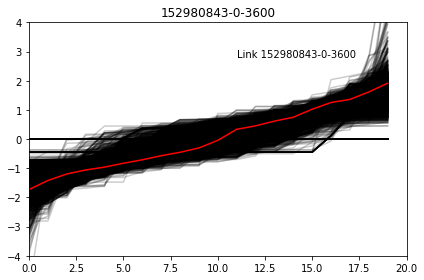

423724841-0-3600
[152746500, 82800, 86400]: 2.7144835701531846
[547531528, 82800, 86400]: 3.947849496308585
[547531527, 82800, 86400]: 3.907012943800707
[420135389, 82800, 86400]: 2.7144835701531846
[8838071, 82800, 86400]: 3.3244535141049245
[301677886, 82800, 86400]: 2.7144835701531846
[152978752, 82800, 86400]: 4.145165232972365
[547531535, 82800, 86400]: 2.7144835701531846
[547531525, 82800, 86400]: 2.7144835701531846
[159632718, 82800, 86400]: 4.696654322826448
[547531531, 82800, 86400]: 3.7575231080097695
[547531534, 82800, 86400]: 3.763638083198257
[547531536, 82800, 86400]: 3.956376732893272
[47876615, 82800, 86400]: 0.0
[515675204, 82800, 86400]: 3.3229359303307833
[153947334, 82800, 86400]: 3.8104584324134736
[103934334, 82800, 86400]: 2.7144835701531846
[153947335, 82800, 86400]: 3.322012534397316
[301677885, 82800, 86400]: 2.7144835701531846
[634307497, 82800, 86400]: 2.7144835701531846
[157490277, 82800, 86400]: 2.7144835701531846
[297830232, 82800, 86400]: 3.3216786622672

[440522456, 0, 3600]: 4.4039430134370905
[688769640, 0, 3600]: 4.642174307642924
[441497928, 0, 3600]: 3.942823913894124
[234352586, 0, 3600]: 4.677895024498781
[298930274, 0, 3600]: 3.3516027505105566
[299893503, 0, 3600]: 4.183409976122034
[320136012, 0, 3600]: 2.7144835701531846
[189465472, 0, 3600]: 2.7144835701531846
[423239436, 0, 3600]: 4.517046669830852
[286685257, 0, 3600]: 2.7144835701531846
[718963898, 0, 3600]: 2.7144835701531846
[160470002, 0, 3600]: 2.7144835701531846
[189424091, 0, 3600]: 2.7144835701531846
[298947986, 0, 3600]: 2.7144835701531846
[141129788, 0, 3600]: 4.420694726862558
[244021194, 0, 3600]: 2.7144835701531846
[480289624, 0, 3600]: 3.6128585081205475
[153035247, 0, 3600]: 2.7144835701531846
[134801100, 0, 3600]: 2.7144835701531846
[697819360, 0, 3600]: 0.0
[320136013, 0, 3600]: 2.7144835701531846
[423724843, 0, 3600]: 3.960855071174904
[440530035, 0, 3600]: 2.7144835701531846
[547531517, 0, 3600]: 4.4781130125527
[152978668, 0, 3600]: 4.314831955784855
[

[299081201, 0, 3600]: 4.0113995644986264
[154535038, 0, 3600]: 3.3516027505105543
[160455794, 0, 3600]: 4.229118788018292
[423239427, 0, 3600]: 4.609879966719683
[152967149, 0, 3600]: 2.7144835701531846
[320136014, 0, 3600]: 2.7144835701531846
[228275494, 0, 3600]: 4.05771143960243
[688769626, 0, 3600]: 4.647790662613776
[152665027, 0, 3600]: 2.7144835701531846
[141129796, 0, 3600]: 4.037455590079634
[441497933, 0, 3600]: 2.7144835701531846
[153947328, 0, 3600]: 4.6643224779393275
[46262615, 0, 3600]: 4.679482953667514
[157489830, 0, 3600]: 4.193134349899108
[46414959, 0, 3600]: 4.154336553050459
[152980845, 0, 3600]: 4.7527547826072745
[154537266, 0, 3600]: 3.9641994045636673
[438172980, 0, 3600]: 4.68011486407802
[157489828, 0, 3600]: 4.262962212070549
[189465471, 0, 3600]: 2.7144835701531846
[420095470, 0, 3600]: 3.4928287563885716
[441497932, 0, 3600]: 2.7144835701531846
[228275499, 0, 3600]: 2.7144835701531846
[423239439, 0, 3600]: 3.3222705735854463
[441497931, 0, 3600]: 2.714483

[768569228, 10800, 14400]: 4.617846874815974
[768569226, 10800, 14400]: 4.656358049343445
[153056031, 10800, 14400]: 2.7144835701531846
[440536718, 10800, 14400]: 3.324435750954862
[298549717, 10800, 14400]: 3.320515531396376
[440536723, 10800, 14400]: 2.7144835701531846
[104081740, 10800, 14400]: 3.303573908583124
[437982138, 10800, 14400]: 4.002214682484569
[344864780, 10800, 14400]: 4.16415781584826
[230916284, 10800, 14400]: 3.9960045475905037
[780970470, 10800, 14400]: 2.7144835701531846
[344864779, 10800, 14400]: 4.213244006181403
[298337583, 10800, 14400]: 3.5647864793980872
[309449105, 10800, 14400]: 4.3412470013416655
[286684914, 10800, 14400]: 2.7144835701531846
[152895102, 10800, 14400]: 3.9309635192100334
[230916285, 10800, 14400]: 4.1528826555300595
[230916282, 10800, 14400]: 4.1530423825499465
[440536717, 10800, 14400]: 2.7144835701531846
[230916286, 10800, 14400]: 4.282460167334663
[230916283, 10800, 14400]: 4.075515817077748
[47876612, 10800, 14400]: 4.521955137089932
[

[251100152, 25200, 28800]: 3.9024589765461286
[8035451, 25200, 28800]: 2.7144835701531846
[189677026, 25200, 28800]: 2.7144835701531846
[243630883, 25200, 28800]: 2.7144835701531846
[60712847, 25200, 28800]: 2.7144835701531846
[160451435, 25200, 28800]: 3.7130447314687722
[286685261, 25200, 28800]: 4.609303477280821
[153050008, 25200, 28800]: 3.8336874214551133
[8035434, 25200, 28800]: 2.7144835701531846
[153050006, 25200, 28800]: 3.324548220261851
[153022759, 25200, 28800]: 2.7144835701531846
[441250601, 25200, 28800]: 4.675938129743379
[104082909, 25200, 28800]: 4.47213595499958
[299081198, 25200, 28800]: 3.9332519366556173
[189677020, 25200, 28800]: 2.7144835701531846
[259111293, 25200, 28800]: 3.9371325832813895
[8035514, 25200, 28800]: 3.2993552715129204
[152895086, 25200, 28800]: 3.9471724977652736
[674573656, 25200, 28800]: 4.6569311531771085
[665834892, 25200, 28800]: 2.7144835701531846
[153050009, 25200, 28800]: 3.988540354319063
[154535040, 25200, 28800]: 4.259397311189916
[8

[153053633, 75600, 79200]: 4.525118867445688
[298925984, 75600, 79200]: 3.3046739833918743
[221553440, 75600, 79200]: 4.272481458437127
[319927896, 75600, 79200]: 5.247997675900522
[221553436, 75600, 79200]: 3.840862298315988
[589546195, 75600, 79200]: 4.080843872261396
[189677032, 75600, 79200]: 2.7144835701531846
[319927895, 75600, 79200]: 6.26618575012878
[152978739, 14400, 18000]: 2.7144835701531846
[243630880, 14400, 18000]: 2.7144835701531846
[152978740, 14400, 18000]: 2.7144835701531846
[515863915, 14400, 18000]: 2.7144835701531846
[152978741, 14400, 18000]: 2.7144835701531846
[245336348, 14400, 18000]: 2.7144835701531846
[423729097, 7200, 10800]: 3.9249579069345786
[152967216, 7200, 10800]: 3.8159855343323326
[547531554, 7200, 10800]: 2.7144835701531846
[189677018, 7200, 10800]: 2.7144835701531846
[152900440, 7200, 10800]: 3.284733426658953
[153021408, 7200, 10800]: 4.568979677051692
[152900414, 7200, 10800]: 3.3721061200147937
[159740405, 7200, 10800]: 0.0
[533580372, 7200, 10

[153021405, 7200, 10800]: 4.8500358985158805
[610577103, 7200, 10800]: 3.369275690882865
[298616189, 7200, 10800]: 3.7895414032611963
[530633120, 7200, 10800]: 3.3516027505105677
[298549750, 7200, 10800]: 2.7144835701531846
[153044291, 7200, 10800]: 4.2973216731988
[515863911, 7200, 10800]: 2.7144835701531846
[153043514, 7200, 10800]: 4.369854374106464
[152900425, 7200, 10800]: 0.0
[104334698, 7200, 10800]: 4.6653887340038835
[152967213, 7200, 10800]: 3.317453665340492
[441308431, 7200, 10800]: 2.7144835701531846
[104334706, 7200, 10800]: 4.684146851358328
[245334305, 7200, 10800]: 2.7144835701531846
[189677019, 7200, 10800]: 2.7144835701531846
[420135403, 7200, 10800]: 2.7144835701531846
[152960502, 7200, 10800]: 3.293346022029155
[152995675, 7200, 10800]: 3.3045689996160545
[319899456, 7200, 10800]: 2.7144835701531846
[245334307, 7200, 10800]: 2.7144835701531846
[420135406, 7200, 10800]: 2.7144835701531846
[493523039, 7200, 10800]: 4.231812282460459
[104334707, 7200, 10800]: 4.704855

[286684919, 79200, 82800]: 4.056951481894679
[442373732, 79200, 82800]: 4.655738457991232
[191003417, 79200, 82800]: 4.141445501076702
[8035474, 79200, 82800]: 4.829675305028693
[34700811, 79200, 82800]: 4.679525684730959
[327005897, 79200, 82800]: 4.550296544982597
[153041105, 79200, 82800]: 2.7144835701531846
[188842272, 79200, 82800]: 4.561760774043062
[238609958, 79200, 82800]: 4.07563722130626
[697192671, 79200, 82800]: 3.981261660749484
[420135387, 79200, 82800]: 4.459809583276752
[8035529, 79200, 82800]: 3.2973505823787486
[298337590, 79200, 82800]: 4.018042373002655
[161620509, 79200, 82800]: 4.39753814300172
[152924209, 79200, 82800]: 4.6456508227959565
[152895048, 79200, 82800]: 4.6491267050903415
[298944624, 79200, 82800]: 4.788771826751973
[189424093, 79200, 82800]: 4.628080270001283
[152995663, 79200, 82800]: 3.2889241341926674
[152980837, 79200, 82800]: 2.7144835701531846
[320136004, 79200, 82800]: 4.653984562054405
[228275463, 79200, 82800]: 4.32602660910611
[91978057, 7

[480289608, 79200, 82800]: 4.349094347409745
[298944626, 79200, 82800]: 4.752661952616013
[344851280, 79200, 82800]: 4.535253006423598
[160438440, 79200, 82800]: 4.034698467890924
[153043604, 79200, 82800]: 4.432378217554279
[252392912, 79200, 82800]: 4.232185030757645
[81797662, 79200, 82800]: 4.132156528474708
[440522455, 79200, 82800]: 4.677899458433237
[298237676, 79200, 82800]: 4.4736925738279645
[152679284, 79200, 82800]: 3.763274996468275
[243630881, 79200, 82800]: 4.507947964862525
[153053559, 79200, 82800]: 4.621419684069572
[589546215, 79200, 82800]: 4.8056753547329265
[152976622, 79200, 82800]: 4.4721359549995805
[589546230, 79200, 82800]: 4.546246383628075
[298925975, 79200, 82800]: 4.530848622288285
[211355986, 79200, 82800]: 2.7144835701531846
[152980834, 79200, 82800]: 4.6502567223830065
[259110130, 79200, 82800]: 2.7144835701531846
[301677360, 79200, 82800]: 4.639748327535104
[153043583, 79200, 82800]: 4.584569302548176
[298877133, 79200, 82800]: 4.638875772310348
[1530

[252392955, 79200, 82800]: 4.443891553495777
[487855859, 79200, 82800]: 4.536922982460726
[154535088, 79200, 82800]: 4.442966594381296
[420076280, 79200, 82800]: 4.515120557503081
[252392914, 79200, 82800]: 4.241764450466228
[153021401, 79200, 82800]: 4.547656119701359
[779578757, 79200, 82800]: 4.654664888027371
[299094979, 79200, 82800]: 4.546916954269373
[153035151, 79200, 82800]: 4.547982873620056
[298925976, 79200, 82800]: 4.550393588862703
[441265809, 79200, 82800]: 4.669233156480818
[245337810, 79200, 82800]: 4.440718751250071
[152967877, 79200, 82800]: 4.634244446961571
[442373708, 79200, 82800]: 4.650545789725061
[188842309, 79200, 82800]: 4.526015045702277
[297996749, 79200, 82800]: 2.7144835701531846
[314499046, 79200, 82800]: 4.5352194615711445
[385334131, 79200, 82800]: 2.7144835701531846
[8035456, 79200, 82800]: 4.677929811003718
[153030228, 79200, 82800]: 2.7144835701531846
[8578385, 79200, 82800]: 4.635316678419245
[412914961, 79200, 82800]: 4.373038575904948
[152679197

[610571159, 79200, 82800]: 4.644213086087559
[297998494, 79200, 82800]: 3.9478430907042754
[502511269, 79200, 82800]: 2.7144835701531846
[153004039, 79200, 82800]: 3.958153751414988
[314499049, 79200, 82800]: 4.529111922390867
[314499050, 79200, 82800]: 4.5414234259800255
[480289613, 79200, 82800]: 4.4151857874501435
[251098778, 79200, 82800]: 4.075829886298431
[251098647, 79200, 82800]: 4.633237331377448
[298703031, 79200, 82800]: 4.389025498606477
[228275473, 79200, 82800]: 4.51462373195239
[480289605, 79200, 82800]: 4.063617144958602
[665834895, 79200, 82800]: 4.631009580125335
[298786479, 79200, 82800]: 4.637852113341079
[188842221, 79200, 82800]: 4.644777153404484
[189452926, 79200, 82800]: 4.69728143916203
[259110128, 79200, 82800]: 2.7144835701531846
[298877131, 79200, 82800]: 4.634310939256656
[248762950, 79200, 82800]: 4.6759885146904345
[153049901, 79200, 82800]: 4.4325243708014535
[8035564, 79200, 82800]: 4.270708304333753
[697192600, 79200, 82800]: 2.7144835701531846
[15297

[153050032, 79200, 82800]: 4.678050181019945
[781786568, 79200, 82800]: 4.187002999666099
[297883462, 79200, 82800]: 4.302801105370599
[135719159, 79200, 82800]: 4.603509710580865
[442373724, 79200, 82800]: 4.57200916681829
[697192639, 79200, 82800]: 4.106634258857584
[298925962, 79200, 82800]: 4.547322581185714
[228275514, 79200, 82800]: 4.336366912172433
[410013926, 79200, 82800]: 4.734161375772041
[516508077, 79200, 82800]: 4.66224240445511
[228275508, 79200, 82800]: 3.5397460744134013
[516841609, 79200, 82800]: 3.6485083210873324
[245333283, 79200, 82800]: 5.066965308745171
[459670500, 79200, 82800]: 4.615156553186215
[259111670, 79200, 82800]: 2.7144835701531846
[298786506, 79200, 82800]: 4.374078002997953
[153019301, 79200, 82800]: 4.589424359899794
[8035569, 79200, 82800]: 4.5556750795284096
[418178093, 79200, 82800]: 2.7144835701531846
[441341839, 79200, 82800]: 3.95625833854146
[153053573, 79200, 82800]: 4.466883743240752
[161620506, 79200, 82800]: 4.346594078015538
[443405860

[189424082, 79200, 82800]: 4.655080734572895
[220393428, 79200, 82800]: 4.677698288562149
[572708714, 79200, 82800]: 4.616290842564469
[46430970, 79200, 82800]: 4.504862671946678
[153945671, 79200, 82800]: 4.545264811034597
[152665037, 79200, 82800]: 4.580387407414431
[189452945, 79200, 82800]: 4.687399215102897
[152654158, 79200, 82800]: 4.70334549121516
[649730259, 79200, 82800]: 3.9721593556967596
[480289603, 79200, 82800]: 3.2983599248613067
[153019289, 79200, 82800]: 4.083858569926317
[423724803, 79200, 82800]: 4.652123433762463
[195407912, 79200, 82800]: 4.578481941604666
[325598325, 79200, 82800]: 4.61930311565449
[299094972, 79200, 82800]: 4.312448500181936
[152679276, 79200, 82800]: 2.7144835701531846
[188842230, 79200, 82800]: 4.646885256641902
[320136001, 79200, 82800]: 4.679040447923053
[153035259, 79200, 82800]: 4.2283782526460225
[46932862, 79200, 82800]: 4.056049698870445
[298930268, 79200, 82800]: 4.62522358340166
[153948621, 79200, 82800]: 4.703209057148728
[152966823,

[154537285, 79200, 82800]: 4.5880310230014985
[420076289, 79200, 82800]: 3.931811188666486
[189452924, 79200, 82800]: 4.584654827286889
[153044305, 79200, 82800]: 3.985716047077157
[152967875, 79200, 82800]: 4.615733672354791
[298237454, 79200, 82800]: 4.486948504076231
[153030227, 79200, 82800]: 2.7144835701531846
[502511308, 79200, 82800]: 4.573587456919019
[195407914, 79200, 82800]: 4.666477684813632
[344851288, 79200, 82800]: 4.51911071048001
[152967871, 79200, 82800]: 4.626069731738175
[160469994, 79200, 82800]: 2.7144835701531846
[440521434, 79200, 82800]: 4.364958712170978
[160443455, 79200, 82800]: 4.64555671848383
[463337423, 79200, 82800]: 4.423210273986234
[516841622, 79200, 82800]: 4.632022170145188
[487855865, 79200, 82800]: 4.188410523903146
[234352587, 79200, 82800]: 4.4938747553124925
[160469978, 79200, 82800]: 4.522067217389161
[424918869, 79200, 82800]: 4.65363168804356
[153035159, 79200, 82800]: 4.453793137595919
[153053560, 79200, 82800]: 4.65456619372119
[238610488

[152656858, 79200, 82800]: 4.052590897912678
[152977274, 79200, 82800]: 3.745824170029168
[22810753, 79200, 82800]: 4.643531520819823
[298786497, 79200, 82800]: 4.165572681296784
[152679406, 79200, 82800]: 4.4665374654202585
[152746364, 79200, 82800]: 4.589628701592669
[344851266, 79200, 82800]: 4.116679948896348
[487825344, 79200, 82800]: 4.683022267400127
[325598336, 79200, 82800]: 3.9099516498136517
[385334090, 79200, 82800]: 4.60365056302364
[153006804, 79200, 82800]: 3.9350151449687423
[46932868, 79200, 82800]: 4.060624848889868
[438177912, 79200, 82800]: 3.936020286131274
[152679316, 79200, 82800]: 4.644490562266201
[442373620, 79200, 82800]: 4.479128603528042
[34700791, 79200, 82800]: 4.690819829700501
[441455570, 79200, 82800]: 4.663669863883599
[252835487, 79200, 82800]: 4.437613552451821
[297998496, 79200, 82800]: 3.9590623959414133
[188842315, 79200, 82800]: 4.421295742895596
[152679402, 79200, 82800]: 4.505083078576508
[480289592, 79200, 82800]: 4.7155888216215285
[8035471,

[320064976, 79200, 82800]: 2.7144835701531846
[153053639, 79200, 82800]: 4.2845270069580845
[298703051, 79200, 82800]: 4.590560942634472
[410013916, 79200, 82800]: 4.235887346607254
[152651323, 79200, 82800]: 4.157535822454507
[46262606, 79200, 82800]: 4.1644497503350015
[188842343, 79200, 82800]: 4.289666353549439
[152746365, 79200, 82800]: 4.631308785416664
[275345120, 79200, 82800]: 3.6729568024400696
[158618966, 79200, 82800]: 4.598320766350342
[159740412, 79200, 82800]: 4.412278791423684
[423239447, 79200, 82800]: 4.085396132756103
[228275485, 79200, 82800]: 3.3017467890637535
[299081223, 79200, 82800]: 2.7144835701531846
[297883451, 79200, 82800]: 4.8647987457151345
[152746493, 79200, 82800]: 4.289356211483984
[320136005, 79200, 82800]: 4.653564641841345
[152679190, 79200, 82800]: 4.5094811211687755
[152995678, 79200, 82800]: 2.7144835701531846
[298786477, 79200, 82800]: 4.64310045366154
[153021394, 79200, 82800]: 5.241161338311925
[152994908, 79200, 82800]: 4.621756345201251
[15

[297882687, 79200, 82800]: 4.626662638227304
[152895046, 79200, 82800]: 4.666844145202851
[410013913, 79200, 82800]: 4.490035318037079
[104082907, 79200, 82800]: 4.522436044844196
[298925982, 79200, 82800]: 4.491818330472998
[46414962, 79200, 82800]: 4.063372892123399
[46262599, 79200, 82800]: 2.7144835701531846
[188842252, 79200, 82800]: 4.705464981807862
[463524795, 79200, 82800]: 4.429739728338343
[251098646, 79200, 82800]: 4.654345960387124
[487825346, 79200, 82800]: 4.674042900756754
[188842348, 79200, 82800]: 4.412465044697637
[423724830, 79200, 82800]: 4.698483917073586
[344864788, 79200, 82800]: 4.70799264127676
[228275478, 79200, 82800]: 4.5248514792184675
[297883459, 79200, 82800]: 4.33808510128571
[252835223, 79200, 82800]: 4.501895885736133
[161620479, 79200, 82800]: 5.118511184582074
[152746484, 79200, 82800]: 4.5681118166902435
[423724835, 79200, 82800]: 4.663308800715357
[160451442, 79200, 82800]: 4.18601156415886
[188842296, 79200, 82800]: 4.582609844156985
[8838078, 79

[153006812, 79200, 82800]: 4.583680016591337
[152668399, 79200, 82800]: 4.398003896527013
[152679349, 79200, 82800]: 4.531591077863541
[8578415, 79200, 82800]: 2.7144835701531846
[195407915, 79200, 82800]: 4.630743888619969
[301677361, 79200, 82800]: 4.644724687917468
[8035556, 79200, 82800]: 4.310160654850697
[320135996, 79200, 82800]: 2.7144835701531846
[385334146, 79200, 82800]: 3.307176790929896
[228275469, 79200, 82800]: 4.505903362026378
[385619276, 79200, 82800]: 4.533789066646535
[152652991, 79200, 82800]: 4.081522096901228
[676950777, 79200, 82800]: 4.47213595499958
[245337808, 79200, 82800]: 4.43821860316921
[245336355, 79200, 82800]: 3.963928758957824
[297826870, 79200, 82800]: 4.628019904283452
[152924210, 79200, 82800]: 4.689770337531118
[441265804, 79200, 82800]: 4.629553149821598
[298699136, 79200, 82800]: 4.5679969626502865
[463337398, 79200, 82800]: 4.676892544129444
[152995662, 79200, 82800]: 2.7144835701531846
[188842305, 79200, 82800]: 4.337011128083629
[423724810, 

[5069462, 79200, 82800]: 4.73679319327678
[480289616, 79200, 82800]: 4.714491846413673
[480289601, 79200, 82800]: 3.7726898679332863
[161620475, 79200, 82800]: 4.243056225106598
[298703045, 79200, 82800]: 4.612766857304512
[298703029, 79200, 82800]: 4.44201144887034
[385331948, 79200, 82800]: 4.570085786405796
[153019283, 79200, 82800]: 4.248011039656686
[153035284, 79200, 82800]: 2.7144835701531846
[153049969, 79200, 82800]: 4.601462620179892
[152746454, 79200, 82800]: 4.204292876697522
[298699133, 79200, 82800]: 4.517866391475866
[423724825, 79200, 82800]: 4.691015170538614
[344851274, 79200, 82800]: 4.538843588042886
[189452921, 79200, 82800]: 4.650527676844583
[253717644, 79200, 82800]: 4.432791308698787
[286685249, 79200, 82800]: 4.535848731405224
[153053638, 79200, 82800]: 3.9363262293905232
[152679341, 79200, 82800]: 3.7564794591846447
[153053668, 79200, 82800]: 4.382790033673182
[153019263, 79200, 82800]: 4.615248392803429
[153043581, 79200, 82800]: 4.51414119192309
[297883450,

[152978734, 79200, 82800]: 4.7494571973360395
[152665065, 79200, 82800]: 4.833149093029548
[153019274, 79200, 82800]: 4.337351522013642
[152746362, 79200, 82800]: 4.593806812055329
[301677368, 79200, 82800]: 4.633179980749713
[298237447, 79200, 82800]: 4.7497367854741475
[228275466, 79200, 82800]: 4.4825480401279085
[440644899, 79200, 82800]: 4.114273246961541
[191003453, 79200, 82800]: 4.588419605687609
[441462656, 79200, 82800]: 4.599461099206098
[8578387, 79200, 82800]: 4.674365517517233
[248762951, 79200, 82800]: 4.676696422455357
[385334132, 79200, 82800]: 2.7144835701531846
[438172968, 79200, 82800]: 4.675045124276947
[188842347, 79200, 82800]: 4.362996836985552
[253717649, 79200, 82800]: 4.240734604851993
[152679343, 79200, 82800]: 3.787046974979592
[161620482, 79200, 82800]: 4.966627861396799
[47876605, 79200, 82800]: 4.121690566978141
[153043584, 79200, 82800]: 4.410430485019437
[252392948, 79200, 82800]: 4.483590345514887
[385334124, 79200, 82800]: 2.7144835701531846
[1596328

[665834901, 79200, 82800]: 4.5844335680837265
[152967674, 79200, 82800]: 2.7144835701531846
[152679315, 79200, 82800]: 4.65368957021146
[589546227, 79200, 82800]: 4.702929316073047
[298925960, 79200, 82800]: 4.564211886949377
[153004062, 79200, 82800]: 3.792937880410541
[152746378, 79200, 82800]: 4.523616010209629
[298944609, 79200, 82800]: 4.457178644513453
[152976632, 79200, 82800]: 3.28739529226478
[189452920, 79200, 82800]: 4.650706310059802
[440522450, 79200, 82800]: 4.66040480893575
[325598327, 79200, 82800]: 4.504706986040315
[674556441, 79200, 82800]: 4.640469141420151
[234439478, 79200, 82800]: 4.616910016045431
[610577097, 79200, 82800]: 4.394208516856523
[60712872, 79200, 82800]: 4.65945617024943
[297883458, 79200, 82800]: 4.428744651049084
[46414967, 79200, 82800]: 4.543945288595742
[152746496, 79200, 82800]: 2.7144835701531846
[152966818, 79200, 82800]: 4.622976087837988
[152746369, 79200, 82800]: 4.612705586688267
[286685247, 79200, 82800]: 4.601914319630859
[252835224, 7

[153045278, 79200, 82800]: 4.0782058818003035
[152966819, 79200, 82800]: 4.609849303973814
[153798138, 79200, 82800]: 4.555597292407768
[502511305, 79200, 82800]: 4.573830326844424
[298932012, 79200, 82800]: 4.456752658354227
[154539317, 79200, 82800]: 4.069370892129906
[298925934, 79200, 82800]: 4.541624767462065
[589546220, 79200, 82800]: 4.700997511959387
[34700815, 79200, 82800]: 4.703744465779736
[228275467, 79200, 82800]: 4.5317960917347495
[298822845, 79200, 82800]: 4.681701351803353
[76191275, 79200, 82800]: 4.447217150249063
[152900394, 79200, 82800]: 4.090124265256172
[344864803, 79200, 82800]: 2.7144835701531846
[299094965, 79200, 82800]: 4.510753189571961
[179351238, 79200, 82800]: 4.290131773251979
[298616207, 79200, 82800]: 4.657393785019075
[441341845, 79200, 82800]: 4.6305605918163515
[438172976, 79200, 82800]: 4.18698347903632
[298559016, 79200, 82800]: 4.477840537758504
[299081208, 79200, 82800]: 3.9533663854388634
[153035278, 79200, 82800]: 2.7144835701531846
[188842

[153049906, 79200, 82800]: 4.568232494202972
[298616192, 79200, 82800]: 4.345719403877082
[157489542, 79200, 82800]: 4.443721618366684
[5069466, 79200, 82800]: 4.6546862249384136
[463524786, 79200, 82800]: 4.389765726423206
[46414943, 79200, 82800]: 4.4276547415042415
[153053671, 79200, 82800]: 4.437513252206436
[8578346, 79200, 82800]: 3.947900040445818
[189468781, 79200, 82800]: 4.227373970083265
[8035461, 79200, 82800]: 4.596890838929002
[462409677, 79200, 82800]: 4.434783578410706
[188842299, 79200, 82800]: 4.567975399263349
[153000840, 79200, 82800]: 4.274543192276522
[188842317, 79200, 82800]: 4.346674117225682
[480289594, 79200, 82800]: 4.6736616218659055
[46430969, 79200, 82800]: 4.508837655799282
[245333281, 79200, 82800]: 4.983270726660081
[297883456, 79200, 82800]: 4.462969508362141
[298727576, 79200, 82800]: 4.650681102583174
[298947984, 79200, 82800]: 4.44816453759597
[438172978, 79200, 82800]: 4.48111540870804
[153041334, 79200, 82800]: 3.321293048524119
[153043582, 79200

[480289589, 46800, 50400]: 3.3237294609091568
[152679327, 46800, 50400]: 3.8855114275159908
[152980827, 46800, 50400]: 4.149914262463106
[298727574, 46800, 50400]: 4.686170596934631
[443397609, 46800, 50400]: 3.980918856877023
[385334092, 46800, 50400]: 4.292466519967432
[676950794, 46800, 50400]: 2.7144835701531846
[152967648, 46800, 50400]: 3.468808964347586
[160451443, 46800, 50400]: 4.760407922734411
[152960506, 46800, 50400]: 3.797931214469821
[152960505, 46800, 50400]: 3.776213122930324
[153947326, 46800, 50400]: 4.334294273365823
[259111300, 46800, 50400]: 4.003463575698973
[153043527, 46800, 50400]: 4.612729230659933
[385857089, 46800, 50400]: 4.186621099748207
[502502574, 46800, 50400]: 4.652853636878586
[298944630, 46800, 50400]: 3.3185661548117125
[515675213, 46800, 50400]: 4.553360842592117
[780574378, 46800, 50400]: 2.7144835701531846
[676950785, 46800, 50400]: 3.3032411264625705
[46430976, 46800, 50400]: 3.303967481425259
[8578411, 46800, 50400]: 4.312565626329446
[152960

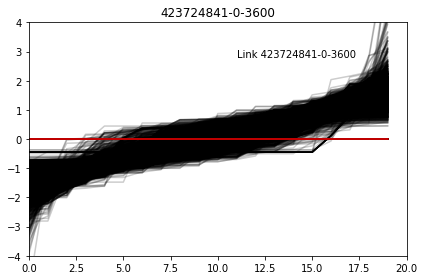

385857079-0-3600
[152746500, 82800, 86400]: 2.0640538010245715
[547531528, 82800, 86400]: 1.960927540723011
[547531527, 82800, 86400]: 1.1449084274638912
[420135389, 82800, 86400]: 2.0640538010245715
[8838071, 82800, 86400]: 1.6355740132899146
[301677886, 82800, 86400]: 2.0640538010245715
[152978752, 82800, 86400]: 1.5812261737223647
[547531535, 82800, 86400]: 2.0640538010245715
[547531525, 82800, 86400]: 2.0640538010245715
[159632718, 82800, 86400]: 0.8064235108593422
[547531531, 82800, 86400]: 1.3449259756216077
[547531534, 82800, 86400]: 1.3359485700226397
[547531536, 82800, 86400]: 2.0076460351010814
[47876615, 82800, 86400]: 4.93452706251623
[515675204, 82800, 86400]: 1.6896797440306406
[153947334, 82800, 86400]: 1.5984165071499887
[103934334, 82800, 86400]: 2.0640538010245715
[153947335, 82800, 86400]: 1.6037637294939184
[301677885, 82800, 86400]: 2.0640538010245715
[634307497, 82800, 86400]: 2.0640538010245715
[157490277, 82800, 86400]: 2.0640538010245715
[297830232, 82800, 8640

[152746451, 0, 3600]: 1.391176975858945
[718964925, 0, 3600]: 2.0640538010245715
[681329981, 0, 3600]: 1.7820259452349387
[152977263, 0, 3600]: 1.0592804578260688
[104082897, 0, 3600]: 2.0640538010245715
[697819362, 0, 3600]: 2.0640538010245715
[440530040, 0, 3600]: 2.0640538010245715
[462409678, 0, 3600]: 1.4709646437740584
[299045404, 0, 3600]: 1.6008547014737162
[154537264, 0, 3600]: 2.0706813339810863
[286685259, 0, 3600]: 1.3982602183249113
[161620472, 0, 3600]: 0.7813888987145547
[153035112, 0, 3600]: 2.0640538010245715
[547531512, 0, 3600]: 0.8035864351321432
[154534948, 0, 3600]: 2.0640538010245715
[154149756, 0, 3600]: 1.001713718365358
[152679220, 0, 3600]: 1.6848244725461443
[141129794, 0, 3600]: 0.8895218289025001
[779578736, 0, 3600]: 0.8658905759160309
[160451372, 0, 3600]: 2.8736967329986065
[440530050, 0, 3600]: 2.0640538010245715
[161620465, 0, 3600]: 1.1640664772560014
[153000853, 0, 3600]: 0.9915400287808681
[152980882, 0, 3600]: 0.5942469500326502
[228275491, 0, 360

[160451388, 0, 3600]: 2.0640538010245715
[153947367, 0, 3600]: 0.9534963004844864
[153041120, 0, 3600]: 4.93452706251623
[299045401, 0, 3600]: 1.3851010077195063
[152679224, 0, 3600]: 1.6089190845315042
[681329978, 0, 3600]: 0.7932522651253511
[152996533, 0, 3600]: 2.0640538010245715
[134801097, 0, 3600]: 2.0057475740535997
[154150691, 0, 3600]: 0.9416407657339099
[297971531, 0, 3600]: 1.6840685511754552
[153030233, 0, 3600]: 2.2923006985191514
[174924975, 0, 3600]: 1.9223009680197927
[780908703, 0, 3600]: 1.5376709373810518
[104082879, 0, 3600]: 2.2923006985191505
[441304011, 0, 3600]: 4.93452706251623
[152679382, 0, 3600]: 1.6298419085688727
[440530048, 0, 3600]: 2.0640538010245715
[104082858, 0, 3600]: 1.9783469351622327
[153947087, 0, 3600]: 1.4272038433517469
[154535124, 0, 3600]: 0.5473258835907987
[697819364, 0, 3600]: 2.0640538010245715
[154537265, 0, 3600]: 2.0567727653116825
[718963676, 0, 3600]: 2.0640538010245715
[234345996, 0, 3600]: 4.93452706251623
[441304001, 0, 3600]: 

[771192183, 10800, 14400]: 2.0640538010245715
[189424066, 10800, 14400]: 2.0640538010245715
[153053665, 10800, 14400]: 2.0640538010245715
[309449104, 10800, 14400]: 4.93452706251623
[152746471, 10800, 14400]: 1.4940230558358072
[780970472, 10800, 14400]: 2.0640538010245715
[104081741, 10800, 14400]: 1.7629091702806665
[780526402, 10800, 14400]: 1.3982683985008086
[238618792, 10800, 14400]: 2.0640538010245715
[440536721, 10800, 14400]: 2.2360366253746253
[153019254, 10800, 14400]: 2.0640538010245715
[230916281, 10800, 14400]: 1.2196266347548688
[154538079, 10800, 14400]: 2.0640538010245715
[47876613, 10800, 14400]: 0.8965265113508881
[153019265, 10800, 14400]: 2.0640538010245715
[344864777, 10800, 14400]: 0.7938478617638792
[22810922, 10800, 14400]: 2.0640538010245715
[152895100, 10800, 14400]: 1.6114890266862596
[768569227, 10800, 14400]: 0.8749507032292929
[780970474, 10800, 14400]: 2.0640538010245715
[780970475, 10800, 14400]: 2.0640538010245715
[104081800, 10800, 14400]: 1.588655593

[8035514, 25200, 28800]: 2.0854343682908083
[152895086, 25200, 28800]: 1.9575689290905356
[674573656, 25200, 28800]: 0.9749401852038946
[665834892, 25200, 28800]: 2.0640538010245715
[153050009, 25200, 28800]: 1.2549881506897564
[154535040, 25200, 28800]: 1.2479675422110068
[8035447, 25200, 28800]: 1.661155799522201
[152665033, 25200, 28800]: 2.0640538010245715
[674573659, 25200, 28800]: 1.2714533301797624
[779578739, 25200, 28800]: 2.0239927653672156
[152895087, 25200, 28800]: 1.867231772516027
[152967673, 25200, 28800]: 1.3225863861515983
[160451394, 25200, 28800]: 0.7810941264564678
[251100151, 25200, 28800]: 1.8220069828039005
[189424071, 25200, 28800]: 1.4157878407714493
[515675221, 25200, 28800]: 1.5877651987934749
[619535885, 25200, 28800]: 2.0640538010245715
[189424072, 25200, 28800]: 1.5138752586192965
[286685263, 25200, 28800]: 1.0524859202747354
[697192602, 25200, 28800]: 1.6052404373487277
[152679311, 25200, 28800]: 1.5733697741479689
[153050014, 25200, 28800]: 1.25448150924

[441479961, 7200, 10800]: 1.6851898241582344
[152967198, 7200, 10800]: 2.0640538010245715
[46430964, 7200, 10800]: 1.6070927358950753
[211355996, 7200, 10800]: 1.9588667557706798
[780970467, 7200, 10800]: 1.2939162639386175
[442372756, 7200, 10800]: 1.04955894333836
[152654141, 7200, 10800]: 2.0640538010245715
[152665052, 7200, 10800]: 1.8277826441416571
[420135405, 7200, 10800]: 2.0640538010245715
[610577102, 7200, 10800]: 1.5751225477597695
[160444151, 7200, 10800]: 2.555323030652274
[238618784, 7200, 10800]: 2.0640538010245715
[238618778, 7200, 10800]: 2.0640538010245715
[397153548, 7200, 10800]: 1.8600233036261211
[161620466, 7200, 10800]: 1.015440609801912
[152900431, 7200, 10800]: 2.1207492241513157
[504476753, 7200, 10800]: 1.034964372347324
[441250592, 7200, 10800]: 1.5896495428925863
[157489811, 7200, 10800]: 2.0640538010245715
[152967201, 7200, 10800]: 1.0723264341383891
[779578741, 7200, 10800]: 1.0604437534167215
[443397606, 7200, 10800]: 1.8692586683052401
[8035485, 7200, 

[152665008, 7200, 10800]: 4.93452706251623
[152746487, 7200, 10800]: 4.93452706251623
[221553424, 7200, 10800]: 1.0209223408487635
[221553427, 7200, 10800]: 1.2144706758372885
[153021405, 7200, 10800]: 1.1256672040318134
[610577103, 7200, 10800]: 1.7037081173901512
[298616189, 7200, 10800]: 1.60533356797429
[530633120, 7200, 10800]: 2.2923006985191114
[298549750, 7200, 10800]: 2.0640538010245715
[153044291, 7200, 10800]: 2.3220662821031794
[515863911, 7200, 10800]: 2.0640538010245715
[153043514, 7200, 10800]: 0.8752121866791366
[152900425, 7200, 10800]: 4.93452706251623
[104334698, 7200, 10800]: 0.8680845342043628
[152967213, 7200, 10800]: 1.8025954510264022
[441308431, 7200, 10800]: 2.0640538010245715
[104334706, 7200, 10800]: 0.7963132612983878
[245334305, 7200, 10800]: 2.0640538010245715
[189677019, 7200, 10800]: 2.0640538010245715
[420135403, 7200, 10800]: 2.0640538010245715
[152960502, 7200, 10800]: 2.1709376251301857
[152995675, 7200, 10800]: 2.005807679657793
[319899456, 7200, 1

[314499045, 79200, 82800]: 1.1912131285938288
[245334393, 79200, 82800]: 1.8378167649719346
[252835207, 79200, 82800]: 1.2034392754128493
[153947386, 79200, 82800]: 0.96708976741199
[480289621, 79200, 82800]: 1.0971232079549877
[153004061, 79200, 82800]: 1.2544346689631576
[153035191, 79200, 82800]: 1.5954481436004098
[188842330, 79200, 82800]: 1.2023627831961334
[442373710, 79200, 82800]: 0.9031091786701011
[160438442, 79200, 82800]: 1.8887093530650358
[152976624, 79200, 82800]: 0.9717906966743135
[440644904, 79200, 82800]: 1.0896981561514816
[480289637, 79200, 82800]: 1.4768017326422043
[298930270, 79200, 82800]: 0.8156613880467127
[423653691, 79200, 82800]: 0.9970327777996862
[298822844, 79200, 82800]: 1.0639890926891076
[480282277, 79200, 82800]: 1.1819937623406218
[104081824, 79200, 82800]: 0.9725185800272128
[153022720, 79200, 82800]: 0.9511381133517715
[152679208, 79200, 82800]: 1.6352405021700855
[275345125, 79200, 82800]: 1.9145792357150349
[780483751, 79200, 82800]: 1.3768828

[152679284, 79200, 82800]: 1.3291598699156313
[243630881, 79200, 82800]: 1.5240298632049192
[153053559, 79200, 82800]: 0.869511778776638
[589546215, 79200, 82800]: 0.49732157872705174
[152976622, 79200, 82800]: 0.8222284447842739
[589546230, 79200, 82800]: 0.9292196587011009
[298925975, 79200, 82800]: 1.5263744152103085
[211355986, 79200, 82800]: 2.0640538010245715
[152980834, 79200, 82800]: 0.9296040777360753
[259110130, 79200, 82800]: 2.0640538010245715
[301677360, 79200, 82800]: 0.9088239818180757
[153043583, 79200, 82800]: 1.130592818580496
[298877133, 79200, 82800]: 1.255768766796446
[153044332, 79200, 82800]: 1.4121909097118062
[441465379, 79200, 82800]: 0.5974921557598017
[188842325, 79200, 82800]: 1.1448360885270248
[8035455, 79200, 82800]: 1.000121784257057
[385796161, 79200, 82800]: 1.554753691500579
[104082881, 79200, 82800]: 1.8029452503718888
[463524787, 79200, 82800]: 1.1380766845937533
[411394824, 79200, 82800]: 0.9730554577718887
[385334134, 79200, 82800]: 1.60309946269

[152900436, 79200, 82800]: 1.5739101147316987
[441265800, 79200, 82800]: 1.0869306744246756
[161620481, 79200, 82800]: 1.1816522825308178
[154534963, 79200, 82800]: 0.8058587152883376
[459684531, 79200, 82800]: 1.9844968039195503
[259109269, 79200, 82800]: 1.2449064826946363
[152924142, 79200, 82800]: 2.0640538010245715
[298623913, 79200, 82800]: 1.1504963720980401
[188842313, 79200, 82800]: 1.3893552051957265
[8035580, 79200, 82800]: 0.8998260174960517
[152679344, 79200, 82800]: 1.0091222863510434
[191003435, 79200, 82800]: 0.9727278824349777
[153049914, 79200, 82800]: 0.8527080169757776
[188842274, 79200, 82800]: 0.9609699950155998
[188842239, 79200, 82800]: 0.9996485172220673
[152679188, 79200, 82800]: 1.5453593254501312
[152895049, 79200, 82800]: 1.3115578327519788
[275539104, 79200, 82800]: 1.4529698475348685
[152668395, 79200, 82800]: 1.2726303815179827
[459670472, 79200, 82800]: 1.2917209710909043
[439048436, 79200, 82800]: 1.6050384642874898
[152665039, 79200, 82800]: 1.0727988

[346316350, 79200, 82800]: 0.959235312891139
[440521430, 79200, 82800]: 1.6985260156967492
[191620662, 79200, 82800]: 1.7360212160573394
[189677010, 79200, 82800]: 0.831227150640436
[547531546, 79200, 82800]: 1.5814354491517046
[152654161, 79200, 82800]: 0.8706133661057148
[152656903, 79200, 82800]: 1.2718031936745398
[154150684, 79200, 82800]: 2.0640538010245715
[8035583, 79200, 82800]: 0.9997684852100323
[195407918, 79200, 82800]: 0.9176315776822276
[34700794, 79200, 82800]: 1.000508777554325
[188842225, 79200, 82800]: 1.04645668923078
[153035164, 79200, 82800]: 1.291189351395702
[298925963, 79200, 82800]: 1.4026824535289002
[189677005, 79200, 82800]: 1.0231711184590904
[161620504, 79200, 82800]: 1.9859296132418163
[346316342, 79200, 82800]: 1.002462153281084
[251098648, 79200, 82800]: 1.0232604917307049
[420076114, 79200, 82800]: 2.775015404690139
[153053556, 79200, 82800]: 0.812905389946047
[152994917, 79200, 82800]: 1.6278747806078162
[298237446, 79200, 82800]: 1.3848607033025149


[463524791, 79200, 82800]: 1.5998614247138978
[463524779, 79200, 82800]: 2.0640538010245715
[153004057, 79200, 82800]: 1.9719349232779688
[152651319, 79200, 82800]: 1.7369100170926663
[153044329, 79200, 82800]: 1.1094392794772003
[189663722, 79200, 82800]: 1.6081251973462625
[153035194, 79200, 82800]: 1.8176109522327297
[152746373, 79200, 82800]: 1.6333311657449179
[81869221, 79200, 82800]: 0.9727421220297315
[153035189, 79200, 82800]: 1.4814791810767507
[238609963, 79200, 82800]: 2.0640538010245715
[160440587, 79200, 82800]: 1.40126507367332
[443405854, 79200, 82800]: 0.6954314196281035
[8035463, 79200, 82800]: 1.2091653476270419
[152978744, 79200, 82800]: 1.3124773435950445
[346316359, 79200, 82800]: 1.1771762914016362
[8035483, 79200, 82800]: 1.033308808339423
[589546200, 79200, 82800]: 1.3650842502490275
[188842340, 79200, 82800]: 1.3036427565039876
[385331944, 79200, 82800]: 0.8697741896968875
[60712867, 79200, 82800]: 0.7512759881041114
[344864791, 79200, 82800]: 0.87958647520566

[153001158, 79200, 82800]: 1.3499493736077675
[5135003, 79200, 82800]: 0.9254749015719034
[103934326, 79200, 82800]: 0.887254271896237
[572708717, 79200, 82800]: 0.9118986661577716
[531278237, 79200, 82800]: 0.867761737833446
[160466236, 79200, 82800]: 1.9504710107798815
[299094985, 79200, 82800]: 1.4735293361246868
[153044300, 79200, 82800]: 1.3908583634005793
[420076112, 79200, 82800]: 2.7629696099180108
[152679192, 79200, 82800]: 1.2110176821711145
[502511311, 79200, 82800]: 0.7961044191035617
[228275464, 79200, 82800]: 2.012985161953272
[153945667, 79200, 82800]: 0.9153598773644881
[298926206, 79200, 82800]: 1.3810657563756545
[103933159, 79200, 82800]: 1.1402083216563854
[234352597, 79200, 82800]: 2.2577623080993616
[188842286, 79200, 82800]: 0.9165937880004635
[320136010, 79200, 82800]: 1.1220138232654884
[153053609, 79200, 82800]: 0.7909568437943918
[153004042, 79200, 82800]: 1.8110305461594343
[34700816, 79200, 82800]: 0.8201998225365296
[297996750, 79200, 82800]: 2.06405380102

[188842263, 79200, 82800]: 0.8061608489822871
[34700806, 79200, 82800]: 0.8894732737746687
[297975531, 79200, 82800]: 1.0862115602491342
[298786463, 79200, 82800]: 0.9904804453321426
[188842332, 79200, 82800]: 2.0640538010245715
[298716243, 79200, 82800]: 1.0115749182568239
[346316356, 79200, 82800]: 1.119884220572472
[298786517, 79200, 82800]: 1.1256795413007645
[188842292, 79200, 82800]: 0.9214758646461144
[8035443, 79200, 82800]: 0.6179100941156093
[161620512, 79200, 82800]: 1.4266539711374273
[160458420, 79200, 82800]: 2.0640538010245715
[141130092, 79200, 82800]: 1.7138760382245166
[610976574, 79200, 82800]: 1.3318431641577833
[152978666, 79200, 82800]: 1.2432412222988098
[188842260, 79200, 82800]: 0.8027689670851846
[423724804, 79200, 82800]: 0.960997094145044
[157489533, 79200, 82800]: 1.2870089025275482
[195407885, 79200, 82800]: 2.0640538010245715
[189452943, 79200, 82800]: 0.7978621115520701
[298786478, 79200, 82800]: 1.0615998835627796
[217603103, 79200, 82800]: 1.1811574664

[298925968, 79200, 82800]: 0.5322929544555556
[320064973, 79200, 82800]: 2.0640538010245715
[154534955, 79200, 82800]: 1.1467685648729091
[297881923, 79200, 82800]: 2.0640538010245715
[252835225, 79200, 82800]: 1.038552247763949
[297998499, 79200, 82800]: 2.0640538010245715
[443405857, 79200, 82800]: 1.214763810921503
[516841620, 79200, 82800]: 1.4997672377991642
[252392941, 79200, 82800]: 0.9254090523101663
[152924184, 79200, 82800]: 1.6749350512468766
[153041116, 79200, 82800]: 1.2903896404568558
[189677004, 79200, 82800]: 0.9536353287587297
[439048432, 79200, 82800]: 1.6841121596519564
[299045396, 79200, 82800]: 1.810132258126114
[189676999, 79200, 82800]: 1.0862774908723591
[441462658, 79200, 82800]: 1.227622465438808
[298237459, 79200, 82800]: 1.942050553552923
[301677373, 79200, 82800]: 1.0050006836006513
[298822851, 79200, 82800]: 1.4974468788574555
[153946074, 79200, 82800]: 2.0640538010245715
[160462991, 79200, 82800]: 1.417119378343735
[8578417, 79200, 82800]: 2.0640538010245

[152895079, 79200, 82800]: 1.1858993273100207
[127127911, 79200, 82800]: 0.9377116378124797
[189424076, 79200, 82800]: 2.0640538010245715
[153798135, 79200, 82800]: 0.984663269325521
[46932873, 79200, 82800]: 1.8727597495398145
[152679404, 79200, 82800]: 1.9223899832130638
[697192637, 79200, 82800]: 2.218935566845591
[442373719, 79200, 82800]: 1.6854696053587763
[259109266, 79200, 82800]: 1.460425887908124
[301677375, 79200, 82800]: 1.004143186550773
[502511302, 79200, 82800]: 0.7261083554710944
[320064976, 79200, 82800]: 2.0640538010245715
[153053639, 79200, 82800]: 1.3586756324803075
[298703051, 79200, 82800]: 1.2708902422603032
[410013916, 79200, 82800]: 1.267997356700935
[152651323, 79200, 82800]: 1.3930360258312062
[46262606, 79200, 82800]: 1.2722359106316603
[188842343, 79200, 82800]: 1.2087743893083975
[152746365, 79200, 82800]: 0.7989418097679879
[275345120, 79200, 82800]: 1.6312882669684416
[158618966, 79200, 82800]: 0.9517337452478905
[159740412, 79200, 82800]: 1.273680270017

[188842288, 79200, 82800]: 0.8206079026009531
[153041734, 79200, 82800]: 0.8738719477648054
[5135002, 79200, 82800]: 0.9212163926611573
[251100072, 79200, 82800]: 2.0640538010245715
[160451432, 79200, 82800]: 1.5508127838304273
[502501396, 79200, 82800]: 0.7607501393278665
[154534961, 79200, 82800]: 1.0279946366517392
[775436079, 79200, 82800]: 1.7973534410152812
[127127912, 79200, 82800]: 0.9282608453920405
[8035437, 79200, 82800]: 0.9408107088739158
[480289570, 79200, 82800]: 2.3566392221607297
[153004040, 79200, 82800]: 1.9002765354315592
[153041119, 79200, 82800]: 1.505787502417233
[373003236, 79200, 82800]: 2.135889437246723
[152679314, 79200, 82800]: 1.1242757119439977
[159632880, 79200, 82800]: 1.3164233367702702
[487855860, 79200, 82800]: 0.9485689734995448
[298237448, 79200, 82800]: 1.5424985320222862
[189424089, 79200, 82800]: 2.0640538010245715
[153022666, 79200, 82800]: 0.8306912942745551
[298925980, 79200, 82800]: 1.5488828948358475
[154149748, 79200, 82800]: 1.45806114324

[298926210, 79200, 82800]: 0.8936243444990061
[152895050, 79200, 82800]: 1.308786680487962
[297975695, 79200, 82800]: 1.4544475121669014
[188842321, 79200, 82800]: 0.9919624252034821
[153021391, 79200, 82800]: 2.0640538010245715
[153021400, 79200, 82800]: 2.0640538010245715
[152668409, 79200, 82800]: 1.5343561363713945
[46429882, 79200, 82800]: 1.6179775452821485
[160438434, 79200, 82800]: 0.6542768848276777
[153041335, 79200, 82800]: 2.172966390792179
[104081774, 79200, 82800]: 2.0640538010245715
[228275468, 79200, 82800]: 0.6927342913091872
[154535115, 79200, 82800]: 0.9404076716644808
[161620502, 79200, 82800]: 1.8286040417190768
[298703024, 79200, 82800]: 1.0555998667668254
[153053711, 79200, 82800]: 1.7683688638706767
[275345097, 79200, 82800]: 1.892276015176623
[420076106, 79200, 82800]: 2.2558167382873378
[420135395, 79200, 82800]: 1.6728697230208616
[153041707, 79200, 82800]: 1.1986791351234558
[189677000, 79200, 82800]: 1.0143132912522503
[22810752, 79200, 82800]: 0.7352836934

[649730261, 79200, 82800]: 1.5112699018150568
[159740339, 79200, 82800]: 1.5637066021631256
[161620518, 79200, 82800]: 1.3658243829233656
[301724755, 79200, 82800]: 1.0048247745565917
[154535119, 79200, 82800]: 0.8692250298465715
[301724758, 79200, 82800]: 0.9981526582348937
[572708720, 79200, 82800]: 1.4036824097063239
[220393427, 79200, 82800]: 0.8876908155374155
[153030230, 79200, 82800]: 2.2168752347470084
[188842275, 79200, 82800]: 1.268385749285192
[188842293, 79200, 82800]: 0.7770459591778641
[245337805, 79200, 82800]: 1.130373207111943
[252392943, 79200, 82800]: 1.4472599880853345
[251098938, 79200, 82800]: 2.0640538010245715
[159632734, 79200, 82800]: 0.7116542081479547
[152966820, 79200, 82800]: 0.9404400211438995
[172232825, 79200, 82800]: 0.7080859135707596
[153044296, 79200, 82800]: 1.6066519958678331
[157488904, 79200, 82800]: 0.9337590718201589
[440522453, 79200, 82800]: 0.8622165484614751
[221553413, 79200, 82800]: 1.409816968014442
[298786500, 79200, 82800]: 1.40136184

[275345112, 79200, 82800]: 1.971676560024389
[493523046, 79200, 82800]: 1.6558478496873767
[298786516, 79200, 82800]: 1.091971665379428
[104081825, 79200, 82800]: 1.316997104841176
[245334388, 79200, 82800]: 1.3432952683243073
[152665043, 79200, 82800]: 0.9404189182306136
[297883455, 79200, 82800]: 1.4003213057894968
[153021412, 79200, 82800]: 0.9547842951368091
[298925971, 79200, 82800]: 0.8434795398916456
[5069464, 79200, 82800]: 0.704284931522257
[320135991, 79200, 82800]: 1.5779099326808768
[480289644, 79200, 82800]: 0.7190803375780274
[60712871, 79200, 82800]: 0.6460988424313341
[298786519, 79200, 82800]: 1.2924612857834143
[385331942, 79200, 82800]: 0.8963929748254158
[420076113, 79200, 82800]: 2.7358128994188062
[252835489, 79200, 82800]: 1.2298743468594484
[188842258, 79200, 82800]: 0.7900800002641368
[676166104, 79200, 82800]: 1.1657811650350303
[160469984, 79200, 82800]: 0.8862912434083146
[228275484, 79200, 82800]: 1.5087361834190995
[298703047, 79200, 82800]: 0.911427046446

[589546223, 79200, 82800]: 0.9464053386308966
[299094983, 79200, 82800]: 0.9835118334354604
[298623912, 79200, 82800]: 0.9954027432322246
[8035468, 79200, 82800]: 1.071070892484667
[46430974, 79200, 82800]: 1.7271286867097513
[154149752, 79200, 82800]: 1.234858836000215
[160449031, 79200, 82800]: 1.3080008117739437
[22810754, 79200, 82800]: 0.7022923564362721
[298926211, 79200, 82800]: 1.1794337431923054
[152665044, 79200, 82800]: 0.940887469954258
[161620491, 79200, 82800]: 0.9903462969555752
[385334117, 79200, 82800]: 2.0640538010245715
[188842284, 79200, 82800]: 2.2707354470525836
[275345104, 79200, 82800]: 2.0089227846460798
[251098645, 79200, 82800]: 1.0139035410390995
[463524790, 79200, 82800]: 1.8292920878767602
[152746498, 79200, 82800]: 2.0640538010245715
[188842322, 79200, 82800]: 0.9811108235550356
[152994901, 79200, 82800]: 0.9649749853175982
[191003446, 79200, 82800]: 0.8408385981970571
[480289620, 79200, 82800]: 1.0857454348625935
[301677374, 79200, 82800]: 0.991986601750

[8578354, 79200, 82800]: 1.740184413016928
[152679370, 79200, 82800]: 0.6673174846625182
[610571173, 79200, 82800]: 1.9210238900192786
[76191298, 79200, 82800]: 1.2650937796981434
[8035469, 79200, 82800]: 1.035409647840224
[160449034, 79200, 82800]: 1.6378141633843943
[46932857, 79200, 82800]: 2.0640538010245715
[297975693, 79200, 82800]: 0.6452487002617459
[153041333, 79200, 82800]: 2.0640538010245715
[299709197, 79200, 82800]: 0.6513475221196076
[297993206, 79200, 82800]: 1.1202764854039629
[780964781, 79200, 82800]: 2.0640538010245715
[153041104, 79200, 82800]: 1.9681784987855735
[297970846, 79200, 82800]: 1.9774321293985613
[440521433, 79200, 82800]: 1.572093177823396
[153001127, 79200, 82800]: 1.1386010555764796
[34700789, 79200, 82800]: 1.3686589309616675
[245333410, 79200, 82800]: 0.8567693272342524
[610571160, 79200, 82800]: 0.9273402860905932
[298699134, 79200, 82800]: 0.9243727162024044
[157489534, 79200, 82800]: 1.6223447686263632
[252835220, 79200, 82800]: 1.05221782791932


[275345122, 79200, 82800]: 1.5888770693843872
[423719038, 79200, 82800]: 1.011946330964521
[385334142, 79200, 82800]: 2.0555069144812865
[674556443, 79200, 82800]: 1.3798006887824064
[8578437, 79200, 82800]: 1.790325900222957
[346316353, 79200, 82800]: 1.2280700266282123
[297998498, 79200, 82800]: 2.0640538010245715
[153022771, 79200, 82800]: 0.8925944843816153
[8838081, 79200, 82800]: 1.2022691121857239
[674556445, 79200, 82800]: 1.8263424185538746
[252392938, 79200, 82800]: 1.330779742987856
[515699255, 79200, 82800]: 2.400881095539326
[298925972, 79200, 82800]: 1.4082837412321894
[153035305, 79200, 82800]: 0.8953624021737013
[299018408, 79200, 82800]: 0.9217246787206221
[34700813, 79200, 82800]: 0.8437494171270207
[153798140, 79200, 82800]: 1.1798640380021215
[153041327, 79200, 82800]: 1.6970673129927587
[252392942, 79200, 82800]: 1.032239620705422
[104081818, 79200, 82800]: 1.0630048951856226
[298925964, 79200, 82800]: 1.0444521451652191
[385619275, 79200, 82800]: 1.178545334293389

[152980827, 46800, 50400]: 0.8577496667920834
[298727574, 46800, 50400]: 0.6961249034926862
[443397609, 46800, 50400]: 1.2187577736255755
[385334092, 46800, 50400]: 1.7149686474613517
[676950794, 46800, 50400]: 2.0640538010245715
[152967648, 46800, 50400]: 1.4645514744252586
[160451443, 46800, 50400]: 0.7286457109371216
[152960506, 46800, 50400]: 1.1077314037006618
[152960505, 46800, 50400]: 1.270350141489744
[153947326, 46800, 50400]: 1.4226812955171917
[259111300, 46800, 50400]: 1.2729837398136679
[153043527, 46800, 50400]: 0.9301712453161385
[385857089, 46800, 50400]: 0.8770430924183593
[502502574, 46800, 50400]: 0.7000826019837714
[298944630, 46800, 50400]: 1.6130318348412078
[515675213, 46800, 50400]: 0.9703774038449243
[780574378, 46800, 50400]: 2.0640538010245715
[676950785, 46800, 50400]: 1.7667048835623014
[46430976, 46800, 50400]: 1.7583920955247665
[8578411, 46800, 50400]: 1.5967462383315987
[152960509, 46800, 50400]: 1.2425994651029146
[299081205, 46800, 50400]: 1.768860387

[153050021, 32400, 36000]: 2.0640538010245715
[153050023, 32400, 36000]: 2.0640538010245715
[161620468, 21600, 25200]: 2.0640538010245715
[397153550, 21600, 25200]: 0.725460925737355
[8089855, 21600, 25200]: 1.8541519552363455
[491822829, 21600, 25200]: 2.0640538010245715
[491822830, 21600, 25200]: 0.8836206278670444
[152978660, 21600, 25200]: 1.172641760429762
[8089857, 21600, 25200]: 1.4668081763638463
[160440585, 21600, 25200]: 1.666854311385881
[8089853, 21600, 25200]: 4.93452706251623
[8089854, 21600, 25200]: 1.4259980740254468
[8089858, 21600, 25200]: 1.6575982050413443
[160440584, 21600, 25200]: 0.9833516851989984
[397153552, 21600, 25200]: 0.7514890396538249
[8089856, 21600, 25200]: 2.0640538010245715
[397153551, 21600, 25200]: 0.7334352186311215
[46594678, 21600, 25200]: 1.6166247461504986
[152668378, 21600, 25200]: 2.0640538010245715
[154537320, 72000, 75600]: 2.0640538010245715
[152900421, 72000, 75600]: 4.93452706251623
[154537318, 72000, 75600]: 2.0640538010245715
[1545372

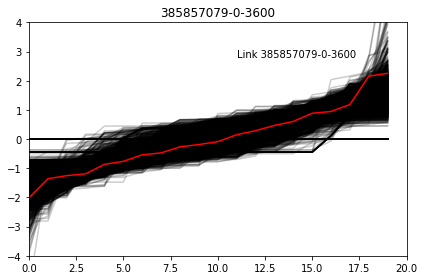

298786465-79200-82800
[152746500, 82800, 86400]: 1.6971208668754059
[547531528, 82800, 86400]: 1.5718032661016987
[547531527, 82800, 86400]: 0.7926821516362943
[420135389, 82800, 86400]: 1.6971208668754059
[8838071, 82800, 86400]: 1.2498204573703586
[301677886, 82800, 86400]: 1.6971208668754059
[152978752, 82800, 86400]: 1.2963245704708992
[547531535, 82800, 86400]: 1.6971208668754059
[547531525, 82800, 86400]: 1.6971208668754059
[159632718, 82800, 86400]: 0.42499054859862856
[547531531, 82800, 86400]: 0.8755347048318163
[547531534, 82800, 86400]: 0.872485455637327
[547531536, 82800, 86400]: 1.6223732079739501
[47876615, 82800, 86400]: 4.756533867604665
[515675204, 82800, 86400]: 1.3290596026308528
[153947334, 82800, 86400]: 1.206412068063746
[103934334, 82800, 86400]: 1.6971208668754059
[153947335, 82800, 86400]: 1.1639230970038434
[301677885, 82800, 86400]: 1.6971208668754059
[634307497, 82800, 86400]: 1.6971208668754059
[157490277, 82800, 86400]: 1.6971208668754059
[297830232, 82800

[161620472, 0, 3600]: 0.5940183861376038
[153035112, 0, 3600]: 1.6971208668754059
[547531512, 0, 3600]: 0.3940916150845368
[154534948, 0, 3600]: 1.6971208668754059
[154149756, 0, 3600]: 0.6792042170703485
[152679220, 0, 3600]: 1.4759372640799657
[141129794, 0, 3600]: 0.4625135194618303
[779578736, 0, 3600]: 0.5184768341512799
[160451372, 0, 3600]: 3.1236522113691163
[440530050, 0, 3600]: 1.6971208668754059
[161620465, 0, 3600]: 0.9598110813272768
[153000853, 0, 3600]: 0.621229942896648
[152980882, 0, 3600]: 0.7040967381159043
[228275491, 0, 3600]: 1.2286305783419984
[154150230, 0, 3600]: 1.8192470904555806
[152996534, 0, 3600]: 1.6971208668754059
[104082880, 0, 3600]: 1.6971208668754059
[152967646, 0, 3600]: 1.0479025317281099
[423239438, 0, 3600]: 0.8448136527279636
[675092020, 0, 3600]: 1.1153156337502579
[697819363, 0, 3600]: 1.6971208668754059
[423724842, 0, 3600]: 1.8454226099493896
[157489834, 0, 3600]: 1.023032090924877
[152978672, 0, 3600]: 1.133924278669272
[547531516, 0, 3600

[152925430, 0, 3600]: 1.6971208668754059
[153947081, 0, 3600]: 0.49783519261167763
[141130095, 0, 3600]: 4.756533867604665
[423239435, 0, 3600]: 0.5796987053235272
[244021195, 0, 3600]: 1.0802230687094758
[299893500, 0, 3600]: 0.8079323858966977
[174924978, 0, 3600]: 1.1171036733468735
[462409673, 0, 3600]: 1.266803824179566
[775436080, 0, 3600]: 0.6959548026046679
[502508508, 0, 3600]: 4.756533867604665
[154537262, 0, 3600]: 1.8731930359282545
[152900416, 0, 3600]: 1.110940834660629
[152924905, 0, 3600]: 1.8321981919820391
[228275495, 0, 3600]: 0.9192052601347804
[152895058, 0, 3600]: 1.6971208668754059
[298503433, 0, 3600]: 4.756533867604665
[718966273, 0, 3600]: 0.7366093961409261
[160451388, 0, 3600]: 1.6971208668754059
[153947367, 0, 3600]: 0.6640887658720082
[153041120, 0, 3600]: 4.756533867604665
[299045401, 0, 3600]: 1.1732227730552285
[152679224, 0, 3600]: 1.4940540371361777
[681329978, 0, 3600]: 0.6482559875006425
[152996533, 0, 3600]: 1.6971208668754059
[134801097, 0, 3600]:

[189424066, 10800, 14400]: 1.6971208668754059
[153053665, 10800, 14400]: 1.6971208668754059
[309449104, 10800, 14400]: 4.756533867604665
[152746471, 10800, 14400]: 1.0979578325475217
[780970472, 10800, 14400]: 1.6971208668754059
[104081741, 10800, 14400]: 1.2948663579049096
[780526402, 10800, 14400]: 1.004503110198114
[238618792, 10800, 14400]: 1.6971208668754059
[440536721, 10800, 14400]: 2.0294410367986373
[153019254, 10800, 14400]: 1.6971208668754059
[230916281, 10800, 14400]: 1.004350850654593
[154538079, 10800, 14400]: 1.6971208668754059
[47876613, 10800, 14400]: 0.5625448476734705
[153019265, 10800, 14400]: 1.6971208668754059
[344864777, 10800, 14400]: 0.350748489056458
[22810922, 10800, 14400]: 1.6971208668754059
[152895100, 10800, 14400]: 1.1589539538045037
[768569227, 10800, 14400]: 0.663485040564155
[780970474, 10800, 14400]: 1.6971208668754059
[780970475, 10800, 14400]: 1.6971208668754059
[104081800, 10800, 14400]: 1.356040187542973
[234345983, 10800, 14400]: 1.6971208668754

[153044316, 25200, 28800]: 1.2292805683018428
[153050010, 25200, 28800]: 1.137486415409888
[160444153, 25200, 28800]: 1.1104107374689702
[160444157, 25200, 28800]: 0.3487094379723228
[252392921, 25200, 28800]: 1.6971208668754059
[480282272, 25200, 28800]: 1.6971208668754059
[515675224, 25200, 28800]: 0.7407146044973288
[153050011, 25200, 28800]: 0.8303122763097371
[298549719, 25200, 28800]: 0.8457220455102057
[678035904, 25200, 28800]: 0.6588994115419453
[251100152, 25200, 28800]: 1.5646048874481056
[8035451, 25200, 28800]: 1.6971208668754059
[189677026, 25200, 28800]: 1.6971208668754059
[243630883, 25200, 28800]: 1.6971208668754059
[60712847, 25200, 28800]: 1.6971208668754059
[160451435, 25200, 28800]: 0.8808006270874192
[286685261, 25200, 28800]: 0.8393910715416453
[153050008, 25200, 28800]: 1.0041615561267327
[8035434, 25200, 28800]: 1.6971208668754059
[153050006, 25200, 28800]: 1.2244217356321718
[153022759, 25200, 28800]: 1.6971208668754059
[441250601, 25200, 28800]: 0.53086997866

[152967201, 7200, 10800]: 0.7316106093865267
[779578741, 7200, 10800]: 0.7677984941301698
[443397606, 7200, 10800]: 1.6315385415891988
[8035485, 7200, 10800]: 1.6971208668754059
[297829486, 7200, 10800]: 1.6971208668754059
[152656825, 7200, 10800]: 1.6971208668754059
[440536713, 7200, 10800]: 1.6971208668754059
[152900441, 7200, 10800]: 1.3738959407028972
[417068017, 7200, 10800]: 1.6971208668754059
[397153549, 7200, 10800]: 1.0903963019846261
[298549749, 7200, 10800]: 0.8000038131354112
[153043517, 7200, 10800]: 0.3377184535543953
[463524776, 7200, 10800]: 1.0379025459969722
[238618777, 7200, 10800]: 1.6971208668754059
[385793312, 7200, 10800]: 0.5897548882128197
[159740419, 7200, 10800]: 1.6971208668754059
[154149772, 7200, 10800]: 1.6971208668754059
[438177907, 7200, 10800]: 0.4551374939214107
[441304006, 7200, 10800]: 1.6971208668754059
[247141051, 7200, 10800]: 1.1685668145793267
[221553422, 7200, 10800]: 1.3310051162254326
[319899452, 7200, 10800]: 1.6971208668754059
[159632887, 

[319899456, 7200, 10800]: 1.6971208668754059
[245334307, 7200, 10800]: 1.6971208668754059
[420135406, 7200, 10800]: 1.6971208668754059
[493523039, 7200, 10800]: 1.251185917459638
[104334707, 7200, 10800]: 0.5294613493096588
[221553425, 7200, 10800]: 0.9316829068373242
[298549748, 7200, 10800]: 0.5912463291912624
[427846840, 7200, 10800]: 1.6838104057681182
[152679225, 7200, 10800]: 1.6971208668754059
[515863913, 7200, 10800]: 1.6971208668754059
[152960501, 7200, 10800]: 2.2491176527432972
[189468780, 7200, 10800]: 1.2923220412793706
[152967202, 7200, 10800]: 0.8713703687053923
[530633123, 7200, 10800]: 1.1724419005437892
[157489810, 7200, 10800]: 0.9272390882270879
[441250590, 7200, 10800]: 0.9584208728653755
[153044292, 7200, 10800]: 1.1636606417344837
[152900383, 7200, 10800]: 1.599764022157104
[438177909, 7200, 10800]: 0.958022368343239
[437986296, 54000, 57600]: 1.6971208668754059
[161620525, 28800, 32400]: 1.6971208668754059
[161620523, 28800, 32400]: 1.6971208668754059
[516841608

[298932007, 79200, 82800]: 0.552333239342785
[46429865, 79200, 82800]: 1.4967042980452199
[8035562, 79200, 82800]: 0.994048725068381
[46594674, 79200, 82800]: 0.9502107385943448
[8578386, 79200, 82800]: 0.7673182094639319
[22810767, 79200, 82800]: 1.0997429414319186
[437986295, 79200, 82800]: 1.5257393641679828
[410013922, 79200, 82800]: 1.4295052214078015
[344851285, 79200, 82800]: 0.5656650843524224
[152679401, 79200, 82800]: 2.0369468588152846
[298932016, 79200, 82800]: 0.9016446659514474
[301724749, 79200, 82800]: 0.8667076831861985
[346316357, 79200, 82800]: 0.9085194088553951
[779578755, 79200, 82800]: 0.7992445980335424
[188842308, 79200, 82800]: 1.0204968165338484
[299081210, 79200, 82800]: 1.6971208668754059
[234352577, 79200, 82800]: 1.2538464207348674
[160455781, 79200, 82800]: 0.7282100148359232
[188842277, 79200, 82800]: 1.7694680216486363
[234352579, 79200, 82800]: 1.2781700801252525
[301677369, 79200, 82800]: 0.7762649823037621
[298786492, 79200, 82800]: 1.01131127437258

[152679376, 79200, 82800]: 0.3485036749010099
[299081214, 79200, 82800]: 1.6971208668754059
[385619274, 79200, 82800]: 0.419341754687378
[154150696, 79200, 82800]: 1.6971208668754059
[248762948, 79200, 82800]: 0.6243382327633719
[385796149, 79200, 82800]: 1.1115229331256267
[678035898, 79200, 82800]: 1.8656720297881502
[676950803, 79200, 82800]: 0.612848372204434
[247141037, 79200, 82800]: 0.840468171762644
[344851270, 79200, 82800]: 1.0742187460731623
[463321554, 79200, 82800]: 0.4479940579474578
[410013924, 79200, 82800]: 1.4463361834127206
[779578747, 79200, 82800]: 0.9660052622231194
[252392939, 79200, 82800]: 1.212355793160053
[780483750, 79200, 82800]: 1.061496652144516
[188842250, 79200, 82800]: 0.8342477104774245
[459670469, 79200, 82800]: 1.6971208668754059
[153035181, 79200, 82800]: 0.7108290331822278
[298782716, 79200, 82800]: 0.8695575172408847
[298237460, 79200, 82800]: 1.6307126523074533
[152994909, 79200, 82800]: 1.3622838466404121
[298691897, 79200, 82800]: 0.4466937431

[299045398, 79200, 82800]: 1.6971208668754059
[104082939, 79200, 82800]: 0.9238813891218807
[251098779, 79200, 82800]: 1.5743500667203212
[298029510, 79200, 82800]: 0.7673850423073357
[298925924, 79200, 82800]: 0.9945010208920654
[301677372, 79200, 82800]: 0.7425850537296751
[502511304, 79200, 82800]: 0.47307495904072067
[423239445, 79200, 82800]: 1.2374891597910591
[252835217, 79200, 82800]: 0.9250128845197172
[423724815, 79200, 82800]: 0.40471453561774146
[424918855, 79200, 82800]: 1.1531726073861182
[234439477, 79200, 82800]: 1.1372532169434897
[385621391, 79200, 82800]: 0.9820227814336578
[34700812, 79200, 82800]: 0.4696717082341155
[153035146, 79200, 82800]: 1.6971208668754059
[152995668, 79200, 82800]: 1.3258092168337399
[299081212, 79200, 82800]: 1.6971208668754059
[420076292, 79200, 82800]: 1.6971208668754059
[155685567, 79200, 82800]: 0.9032287705406853
[153055990, 79200, 82800]: 0.2753786140253092
[8035452, 79200, 82800]: 0.36494927092010404
[248762962, 79200, 82800]: 0.63763

[189452930, 79200, 82800]: 0.34494564709457526
[298925981, 79200, 82800]: 1.0661882367936013
[245336351, 79200, 82800]: 1.6729195578561533
[245333411, 79200, 82800]: 0.3887789516115783
[161620514, 79200, 82800]: 0.9716081569605691
[299094971, 79200, 82800]: 0.4597918531827689
[217603102, 79200, 82800]: 1.5248052033999508
[189677006, 79200, 82800]: 0.8895271678999657
[516841623, 79200, 82800]: 0.37988251960207625
[245336352, 79200, 82800]: 2.104348116555018
[780483747, 79200, 82800]: 0.9333459028610082
[152976627, 79200, 82800]: 0.6613834687196162
[153035179, 79200, 82800]: 0.7139065342035013
[153947390, 79200, 82800]: 0.8459627212602583
[189452946, 79200, 82800]: 0.38693502974236427
[441250598, 79200, 82800]: 1.06638365266525
[152668412, 79200, 82800]: 1.4055716574365351
[409377698, 79200, 82800]: 0.9533040792022485
[159740346, 79200, 82800]: 0.8049243201728633
[420076291, 79200, 82800]: 1.6971208668754059
[8035500, 79200, 82800]: 1.6971208668754059
[299024303, 79200, 82800]: 0.4688858

[299094981, 79200, 82800]: 1.2685365123272545
[298822854, 79200, 82800]: 1.5707309513693077
[408924183, 79200, 82800]: 0.5214313335623232
[780483744, 79200, 82800]: 1.0390689711835495
[153044321, 79200, 82800]: 1.6098887670736328
[439048434, 79200, 82800]: 0.8113359104249411
[46429877, 79200, 82800]: 1.6164406342843016
[299024301, 79200, 82800]: 0.5383826748950502
[157488905, 79200, 82800]: 0.7824699832275918
[423724808, 79200, 82800]: 0.547087505052178
[245337807, 79200, 82800]: 0.6919931137695642
[160469975, 79200, 82800]: 1.4256948025092222
[22810751, 79200, 82800]: 0.3610377643327336
[441265805, 79200, 82800]: 0.5500252785178077
[297883448, 79200, 82800]: 0.596940555228987
[153004031, 79200, 82800]: 1.5953250987547298
[153044299, 79200, 82800]: 0.8370053481341855
[298786518, 79200, 82800]: 0.8014631858411569
[234352576, 79200, 82800]: 0.8650432560927808
[423729711, 79200, 82800]: 1.6971208668754059
[248762955, 79200, 82800]: 0.6967353392863822
[188842316, 79200, 82800]: 0.770045234

[152967873, 79200, 82800]: 0.5872744998116012
[141130089, 79200, 82800]: 0.39886478067707276
[516508075, 79200, 82800]: 0.47846970179328224
[60712865, 79200, 82800]: 0.2995316828540982
[153035148, 79200, 82800]: 1.6971208668754059
[153006767, 79200, 82800]: 0.6506635979751084
[22810770, 79200, 82800]: 1.3439149118636915
[459684533, 79200, 82800]: 1.1061230231213086
[385334139, 79200, 82800]: 1.5993723502837647
[297998490, 79200, 82800]: 1.6971208668754059
[152668384, 79200, 82800]: 0.6266733734018185
[298822852, 79200, 82800]: 1.5527002600902813
[299081209, 79200, 82800]: 0.47533515064947673
[502511291, 79200, 82800]: 1.5462567292125036
[228275512, 79200, 82800]: 1.0022698794767224
[423729707, 79200, 82800]: 1.6971208668754059
[154535087, 79200, 82800]: 0.6600446458921617
[188842283, 79200, 82800]: 0.7179929447856778
[440644894, 79200, 82800]: 0.7213631247081252
[252392913, 79200, 82800]: 1.1820824006443957
[298703038, 79200, 82800]: 0.588145107646546
[298337591, 79200, 82800]: 0.83657

[420135394, 79200, 82800]: 1.5367959041843708
[160443453, 79200, 82800]: 0.5952574594229446
[344851278, 79200, 82800]: 0.680720171233113
[195407919, 79200, 82800]: 0.5589146444199709
[153022665, 79200, 82800]: 0.4161013757067501
[153035304, 79200, 82800]: 0.6225375264830473
[189676996, 79200, 82800]: 0.8624844322597073
[516841613, 79200, 82800]: 0.5933979255338251
[153035152, 79200, 82800]: 1.2814432881637992
[152978733, 79200, 82800]: 0.7245105594622705
[8838082, 79200, 82800]: 1.0799645958385808
[8035581, 79200, 82800]: 0.6881253582869691
[188842232, 79200, 82800]: 0.4131268940108064
[697192670, 79200, 82800]: 0.9095762816585634
[502511274, 79200, 82800]: 1.6971208668754059
[153045282, 79200, 82800]: 0.9438280651231579
[502501398, 79200, 82800]: 0.5895582059246796
[152679204, 79200, 82800]: 1.4178799861065094
[480289642, 79200, 82800]: 1.2567212845545326
[531317457, 79200, 82800]: 0.6858690130651417
[385793295, 79200, 82800]: 0.8198274917586026
[298925970, 79200, 82800]: 0.6643523812

[441265801, 79200, 82800]: 0.638283564294114
[297993203, 79200, 82800]: 0.7074584336939501
[423724819, 79200, 82800]: 0.4605630338006899
[191003452, 79200, 82800]: 0.782220589495942
[152995666, 79200, 82800]: 0.9295332387782332
[153004059, 79200, 82800]: 0.9447037828213551
[275345101, 79200, 82800]: 1.4301520620797838
[259111669, 79200, 82800]: 1.6971208668754059
[423239422, 79200, 82800]: 1.005637068781318
[441455560, 79200, 82800]: 0.8591646839235818
[442372758, 79200, 82800]: 0.5680046067279506
[299032764, 79200, 82800]: 0.5904284544550878
[531743750, 79200, 82800]: 0.4661485837251775
[463524788, 79200, 82800]: 1.8376079334458997
[480289597, 79200, 82800]: 0.6972048632106432
[297975692, 79200, 82800]: 0.7000462276102384
[320051565, 79200, 82800]: 1.7155929336270543
[252835209, 79200, 82800]: 0.7291273180811811
[152679409, 79200, 82800]: 1.3580209868286726
[252392945, 79200, 82800]: 1.0482583604329612
[179351241, 79200, 82800]: 0.9515053378395529
[221553411, 79200, 82800]: 0.92405621

[442373705, 79200, 82800]: 1.6971208668754059
[152656913, 79200, 82800]: 0.5990032626008013
[516841616, 79200, 82800]: 0.8357502099779229
[189676994, 79200, 82800]: 0.5550565994229373
[327005894, 79200, 82800]: 1.021369480936438
[610571158, 79200, 82800]: 0.4994011247065066
[60712874, 79200, 82800]: 3.288900963353511
[153043549, 79200, 82800]: 1.265442566349038
[423719034, 79200, 82800]: 1.4717174100737591
[610571161, 79200, 82800]: 0.5324371798257361
[438177910, 79200, 82800]: 1.4556483927263169
[298786037, 79200, 82800]: 0.9595442135183654
[152924945, 79200, 82800]: 0.8255118203790497
[440522452, 79200, 82800]: 0.9686447348122829
[297881922, 79200, 82800]: 1.6971208668754059
[153050030, 79200, 82800]: 0.44054106245795216
[572708711, 79200, 82800]: 1.0794193696854306
[298930269, 79200, 82800]: 0.46497309127443526
[161620484, 79200, 82800]: 1.2864882124115522
[152654144, 79200, 82800]: 0.6199346495834342
[5135020, 79200, 82800]: 1.1261962851112575
[152895084, 79200, 82800]: 0.793397289

[385334121, 79200, 82800]: 1.6971208668754059
[423724826, 79200, 82800]: 0.6552593307328531
[60712863, 79200, 82800]: 0.28039478256049394
[463524789, 79200, 82800]: 1.8126304136376903
[409377662, 79200, 82800]: 0.47937359308053634
[152900387, 79200, 82800]: 0.6832711696953866
[259109265, 79200, 82800]: 1.0873471753072543
[152976628, 79200, 82800]: 0.6531827946814681
[385796150, 79200, 82800]: 1.1644080851154883
[152994918, 79200, 82800]: 1.215806485250957
[8035577, 79200, 82800]: 0.672662585742268
[238610490, 79200, 82800]: 0.9715942563087615
[780964783, 79200, 82800]: 0.7123298719980241
[153945666, 79200, 82800]: 0.5698906085953758
[779578754, 79200, 82800]: 0.6229971876081077
[325598335, 79200, 82800]: 1.4112280410634173
[189452944, 79200, 82800]: 0.33597856740739057
[152924185, 79200, 82800]: 1.4054473054287093
[188842310, 79200, 82800]: 1.1220571275021851
[153019300, 79200, 82800]: 0.6330137761407051
[152656865, 79200, 82800]: 0.5637347512831177
[152977273, 79200, 82800]: 1.0646685

[298925940, 79200, 82800]: 0.45999545158492616
[442373712, 79200, 82800]: 0.5702797715391347
[160469993, 79200, 82800]: 1.6971208668754059
[152746443, 79200, 82800]: 0.5794585648960252
[152978778, 79200, 82800]: 0.5618860726490552
[438172971, 79200, 82800]: 0.6551871690495844
[153043601, 79200, 82800]: 0.999429298148235
[104082941, 79200, 82800]: 0.9480824823871493
[152679287, 79200, 82800]: 1.6188770266208954
[153035160, 79200, 82800]: 0.9816804478382954
[298925967, 79200, 82800]: 0.5418380759145621
[516841610, 79200, 82800]: 0.9273088271761029
[191003457, 79200, 82800]: 1.2534263257554958
[423724805, 79200, 82800]: 0.5638217475155981
[188842236, 79200, 82800]: 0.6691381484142649
[141129797, 79200, 82800]: 1.222308577859913
[589546201, 79200, 82800]: 1.2697728796659442
[188842268, 79200, 82800]: 0.4302145994351083
[441465377, 79200, 82800]: 0.809905779121195
[299032768, 79200, 82800]: 0.657952698777626
[152656857, 79200, 82800]: 0.6184760126953515
[153004047, 79200, 82800]: 1.17793336

[487855858, 79200, 82800]: 0.609691945911315
[424918875, 79200, 82800]: 1.1527792840845499
[423239444, 79200, 82800]: 1.2174464027171483
[76191271, 79200, 82800]: 2.0508818853492707
[152679345, 79200, 82800]: 0.6559996102570248
[153043603, 79200, 82800]: 0.88286082011088
[325598333, 79200, 82800]: 1.3434931970704687
[154534949, 79200, 82800]: 0.9034921010969696
[161620488, 79200, 82800]: 1.0136105232829251
[46429866, 79200, 82800]: 2.0674009126651876
[344851282, 79200, 82800]: 0.6995148503763906
[298930271, 79200, 82800]: 0.5581432455293223
[152668394, 79200, 82800]: 1.2123464916282602
[152656952, 79200, 82800]: 0.4230791225050536
[8035465, 79200, 82800]: 0.6489300763714324
[319927893, 79200, 82800]: 0.630816863142977
[676152424, 79200, 82800]: 1.3918574622380173
[153022715, 79200, 82800]: 0.6191294542964966
[248762954, 79200, 82800]: 0.723641907554512
[408268174, 79200, 82800]: 0.4044138996425646
[153035154, 79200, 82800]: 1.0651596114864248
[159740341, 79200, 82800]: 1.40110617810728

[298786482, 79200, 82800]: 0.9047975490747447
[252835211, 79200, 82800]: 0.586324657762745
[547531552, 79200, 82800]: 1.3106582829383213
[320064975, 79200, 82800]: 1.6971208668754059
[462636859, 79200, 82800]: 1.3539797905736122
[195407896, 79200, 82800]: 0.548527891550901
[152978777, 79200, 82800]: 0.466489762133511
[480289641, 79200, 82800]: 1.210211473980227
[152656950, 79200, 82800]: 0.337430885007437
[259111672, 79200, 82800]: 0.799924929730766
[423729706, 79200, 82800]: 1.6971208668754059
[161620492, 79200, 82800]: 0.5653331689647635
[153035279, 79200, 82800]: 1.6971208668754059
[153035253, 79200, 82800]: 0.510095979686331
[410013918, 79200, 82800]: 1.075641811405295
[159740413, 79200, 82800]: 1.2470001690640304
[442373717, 79200, 82800]: 2.1339035430765425
[408268179, 79200, 82800]: 0.5651178225796766
[780483752, 79200, 82800]: 1.0068559279659788
[491822823, 79200, 82800]: 0.7475488811398054
[188842279, 79200, 82800]: 1.8225445853370086
[153055989, 79200, 82800]: 0.4180246150960

[153004062, 79200, 82800]: 1.3352849084281047
[152746378, 79200, 82800]: 1.4031768907176918
[298944609, 79200, 82800]: 0.7356053921530834
[152976632, 79200, 82800]: 2.0580551994671676
[189452920, 79200, 82800]: 0.7290306807741977
[440522450, 79200, 82800]: 0.4854219228588458
[325598327, 79200, 82800]: 0.5979490168409611
[674556441, 79200, 82800]: 0.5739369252572705
[234439478, 79200, 82800]: 1.222475237352993
[610577097, 79200, 82800]: 0.9903511241079219
[60712872, 79200, 82800]: 0.849067599653525
[297883458, 79200, 82800]: 0.5833291443807748
[46414967, 79200, 82800]: 0.5439794926118788
[152746496, 79200, 82800]: 1.6971208668754059
[152966818, 79200, 82800]: 0.5635973620021723
[152746369, 79200, 82800]: 1.1136215238770293
[286685247, 79200, 82800]: 0.5176114873820511
[252835224, 79200, 82800]: 0.6069799683384085
[385334127, 79200, 82800]: 1.6971208668754059
[676436350, 79200, 82800]: 1.146894237615798
[676950800, 79200, 82800]: 0.5112429595173436
[154539318, 79200, 82800]: 1.3960699840

[299081208, 79200, 82800]: 1.603290401098057
[153035278, 79200, 82800]: 1.6971208668754059
[188842220, 79200, 82800]: 0.52184426154983
[154150685, 79200, 82800]: 1.6971208668754059
[781830256, 79200, 82800]: 0.8112982931355143
[8035568, 79200, 82800]: 1.226615005845816
[152679286, 79200, 82800]: 1.6729375513151592
[153000939, 79200, 82800]: 0.8393167190755094
[301677365, 79200, 82800]: 0.7743334220307236
[153019302, 79200, 82800]: 1.6686117224458261
[297829488, 79200, 82800]: 0.6354514224235072
[299024304, 79200, 82800]: 0.4948920844904342
[252392950, 79200, 82800]: 1.0673446830806765
[34700804, 79200, 82800]: 0.969245264785361
[252835213, 79200, 82800]: 0.7091793183116148
[159740377, 79200, 82800]: 1.3752155005629052
[298703050, 79200, 82800]: 1.2300544326611664
[423729717, 79200, 82800]: 1.6971208668754059
[442373720, 79200, 82800]: 0.9168843278143876
[153019243, 79200, 82800]: 1.0508244546245469
[504476756, 79200, 82800]: 1.1036441913723545
[228275470, 79200, 82800]: 0.5112524216177

[152967817, 46800, 50400]: 1.6971208668754059
[159380623, 46800, 50400]: 1.6971208668754059
[153947329, 46800, 50400]: 2.595951505696509
[153947331, 46800, 50400]: 2.326686858356149
[676950788, 46800, 50400]: 1.6971208668754059
[135719163, 46800, 50400]: 0.8352047192185779
[298237443, 46800, 50400]: 1.1498404634365496
[346307028, 46800, 50400]: 0.5767350926447041
[152679217, 46800, 50400]: 1.7250661795580717
[160458429, 46800, 50400]: 1.6971208668754059
[104334700, 46800, 50400]: 0.45435317967188044
[546853682, 46800, 50400]: 1.6971208668754059
[152654155, 46800, 50400]: 1.1107584553093408
[8578409, 46800, 50400]: 0.6860156357104809
[81797897, 46800, 50400]: 0.9261617531512217
[157488906, 46800, 50400]: 1.3247383414035676
[676950778, 46800, 50400]: 1.4205972304612835
[676950791, 46800, 50400]: 1.6971208668754059
[152679412, 46800, 50400]: 1.4994620812911883
[8035440, 46800, 50400]: 1.253872549875091
[385334113, 46800, 50400]: 1.6971208668754059
[418094196, 46800, 50400]: 0.536228671087

[160451454, 32400, 36000]: 1.6060077906171564
[160451458, 32400, 36000]: 1.6971208668754059
[152967902, 32400, 36000]: 1.1214990375460827
[152967901, 32400, 36000]: 1.3108810549703125
[153021397, 32400, 36000]: 1.6971208668754059
[152656971, 32400, 36000]: 1.6971208668754059
[152978761, 32400, 36000]: 1.6971208668754059
[152967898, 32400, 36000]: 1.4300815533842344
[298549724, 32400, 36000]: 1.6971208668754059
[152656961, 32400, 36000]: 1.6971208668754059
[153050020, 32400, 36000]: 1.6971208668754059
[298623928, 32400, 36000]: 1.6971208668754059
[153050026, 32400, 36000]: 1.6971208668754059
[152656960, 32400, 36000]: 1.6971208668754059
[781830257, 32400, 36000]: 1.6971208668754059
[298424778, 32400, 36000]: 1.6971208668754059
[160451459, 32400, 36000]: 1.6971208668754059
[160451456, 32400, 36000]: 1.6971208668754059
[775436067, 32400, 36000]: 1.7122462648601273
[152656963, 32400, 36000]: 1.6971208668754059
[152967900, 32400, 36000]: 1.678715041285273
[153050106, 32400, 36000]: 1.072261

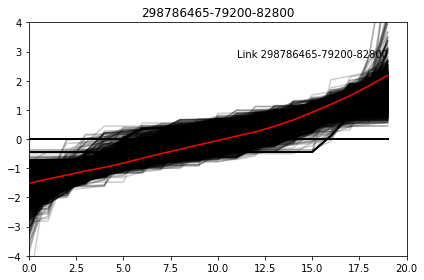

327005892-79200-82800
[152746500, 82800, 86400]: 1.4076282470239434
[547531528, 82800, 86400]: 1.2707525110884554
[547531527, 82800, 86400]: 0.38124697714879696
[420135389, 82800, 86400]: 1.4076282470239434
[8838071, 82800, 86400]: 0.8814662162813675
[301677886, 82800, 86400]: 1.4076282470239434
[152978752, 82800, 86400]: 0.757128475580026
[547531535, 82800, 86400]: 1.4076282470239434
[547531525, 82800, 86400]: 1.4076282470239434
[159632718, 82800, 86400]: 0.5236156131634934
[547531531, 82800, 86400]: 0.8959506984532277
[547531534, 82800, 86400]: 0.8750335469535322
[547531536, 82800, 86400]: 1.3229671886823824
[47876615, 82800, 86400]: 4.684278123493312
[515675204, 82800, 86400]: 0.9007666455077402
[153947334, 82800, 86400]: 0.8316152492953206
[103934334, 82800, 86400]: 1.4076282470239434
[153947335, 82800, 86400]: 0.9349832743948796
[301677885, 82800, 86400]: 1.4076282470239434
[634307497, 82800, 86400]: 1.4076282470239434
[157490277, 82800, 86400]: 1.4076282470239434
[297830232, 8280

[157489834, 0, 3600]: 0.6038127679882861
[152978672, 0, 3600]: 0.6176586056609041
[547531516, 0, 3600]: 0.4281115025437784
[440521424, 0, 3600]: 0.40275951564485185
[297971534, 0, 3600]: 4.684278123493312
[157488722, 0, 3600]: 1.4076282470239434
[152967148, 0, 3600]: 4.684278123493312
[152679218, 0, 3600]: 1.4189923188010094
[780911242, 0, 3600]: 0.498167391654286
[104081781, 0, 3600]: 1.4076282470239434
[153019269, 0, 3600]: 0.36136857161740005
[152679413, 0, 3600]: 0.6116111226478844
[160451376, 0, 3600]: 1.4076282470239434
[299893502, 0, 3600]: 0.8818812199887766
[174924979, 0, 3600]: 0.4591233130705836
[718963842, 0, 3600]: 1.4076282470239434
[104082865, 0, 3600]: 1.4076282470239434
[718963897, 0, 3600]: 2.3404893288874584
[159632877, 0, 3600]: 1.0418421700861613
[547531510, 0, 3600]: 0.4619551222463309
[152978671, 0, 3600]: 0.5021111182550816
[275539107, 0, 3600]: 1.525406379534466
[104082923, 0, 3600]: 0.798837635961945
[157489829, 0, 3600]: 0.44304815670790504
[5135005, 0, 3600]

[159632858, 0, 3600]: 1.4076282470239434
[299081200, 0, 3600]: 0.3288014188110481
[104081780, 0, 3600]: 1.4076282470239434
[385619164, 0, 3600]: 0.334877585286619
[299893499, 0, 3600]: 0.5395181815161618
[420095474, 0, 3600]: 1.4076282470239434
[438172985, 0, 3600]: 1.4061010868972939
[153946072, 0, 3600]: 1.4076282470239434
[152679414, 0, 3600]: 0.9643866473645983
[711385801, 0, 3600]: 1.3039227547819823
[152995654, 0, 3600]: 1.4076282470239434
[344851269, 0, 3600]: 0.8900404473989066
[152665029, 0, 3600]: 1.4076282470239434
[153947088, 0, 3600]: 0.6314672404587532
[423239431, 0, 3600]: 0.44443254522464265
[152679219, 0, 3600]: 0.9879253498405749
[160451374, 0, 3600]: 2.1080178231441007
[320136003, 0, 3600]: 1.4076282470239434
[153019266, 0, 3600]: 0.5490811375562669
[299893501, 0, 3600]: 0.7933505982806933
[152651318, 0, 3600]: 0.4723472835662217
[153019270, 0, 3600]: 0.6741420700614313
[127127899, 0, 3600]: 0.8098198207473367
[244021197, 0, 3600]: 1.4076282470239434
[228275498, 0, 3

[153022809, 3600, 7200]: 1.4076282470239434
[346316337, 3600, 7200]: 1.4076282470239434
[152928148, 3600, 7200]: 1.165377915484059
[462617693, 3600, 7200]: 1.4076282470239434
[126243422, 3600, 7200]: 1.4076282470239434
[298930272, 3600, 7200]: 1.4076282470239434
[346316336, 3600, 7200]: 1.4076282470239434
[153053593, 3600, 7200]: 1.4076282470239434
[688769629, 3600, 7200]: 0.8955703958596414
[234332718, 3600, 7200]: 1.4076282470239434
[462617694, 3600, 7200]: 1.4076282470239434
[462617691, 3600, 7200]: 1.4076282470239434
[462617692, 3600, 7200]: 1.4076282470239434
[234332716, 3600, 7200]: 1.4076282470239434
[152928143, 3600, 7200]: 1.4076282470239434
[153035117, 3600, 7200]: 1.4076282470239434
[189465476, 3600, 7200]: 1.4076282470239434
[160444150, 3600, 7200]: 1.4076282470239434
[779578743, 3600, 7200]: 1.4076282470239434
[134801096, 3600, 7200]: 1.4076282470239434
[152925433, 3600, 7200]: 1.4076282470239434
[153035243, 3600, 7200]: 1.4076282470239434
[141129801, 3600, 7200]: 1.407628

[373003259, 61200, 64800]: 0.3099101040483945
[441315036, 61200, 64800]: 1.4076282470239434
[298703037, 61200, 64800]: 1.0890485312483198
[420076102, 61200, 64800]: 1.2874310175645631
[441250622, 61200, 64800]: 0.4668021038315382
[152924172, 61200, 64800]: 1.1065820482400615
[441250625, 61200, 64800]: 0.3169190188155334
[228275503, 61200, 64800]: 1.4076282470239434
[152924174, 61200, 64800]: 1.4076282470239434
[152924170, 61200, 64800]: 1.0219460982294946
[152679242, 61200, 64800]: 1.3265366434318653
[60712852, 61200, 64800]: 2.1049186896981165
[152924168, 61200, 64800]: 1.2941165180255763
[298703035, 61200, 64800]: 1.4605426184359243
[298703036, 61200, 64800]: 1.1475771875875311
[253717640, 61200, 64800]: 0.6838494429931217
[385619159, 61200, 64800]: 0.8574957248750436
[519178542, 61200, 64800]: 0.5436936121877194
[152679386, 61200, 64800]: 1.1968065741258032
[298847948, 61200, 64800]: 1.4076282470239434
[46262610, 61200, 64800]: 0.9984376457265125
[218911655, 61200, 64800]: 0.8969876

[238618780, 7200, 10800]: 1.4076282470239434
[152967197, 7200, 10800]: 0.5411860779248773
[780970458, 7200, 10800]: 1.4076282470239434
[423239443, 7200, 10800]: 0.2875105619097361
[153043580, 7200, 10800]: 0.30724019937825536
[319927897, 7200, 10800]: 0.6313522298429648
[159632714, 7200, 10800]: 0.3621818665916189
[153043516, 7200, 10800]: 1.4076282470239434
[152665053, 7200, 10800]: 1.4076282470239434
[238618787, 7200, 10800]: 1.4076282470239434
[153001014, 7200, 10800]: 1.4076282470239434
[504476754, 7200, 10800]: 0.4222447393865718
[189452929, 7200, 10800]: 1.4076282470239434
[234352578, 7200, 10800]: 0.36954251638879665
[771192182, 7200, 10800]: 0.902418589245384
[547531508, 7200, 10800]: 1.4076282470239434
[417068019, 7200, 10800]: 1.4076282470239434
[159740421, 7200, 10800]: 1.4076282470239434
[152900380, 7200, 10800]: 1.592375783312675
[153043579, 7200, 10800]: 0.6323809549043423
[159740418, 7200, 10800]: 1.4076282470239434
[159740420, 7200, 10800]: 1.4076282470239434
[152665023

[385334144, 79200, 82800]: 1.3676155930148675
[437838454, 79200, 82800]: 0.7673311374942576
[153053625, 79200, 82800]: 1.4076282470239434
[275345110, 79200, 82800]: 1.3291776526971817
[141130091, 79200, 82800]: 1.0804463648332647
[153019296, 79200, 82800]: 0.6940377153095361
[153019239, 79200, 82800]: 0.6144071485520057
[188842271, 79200, 82800]: 0.3373983857159727
[153021404, 79200, 82800]: 0.39306288017818924
[297826867, 79200, 82800]: 0.806317089285289
[153035258, 79200, 82800]: 1.4146380922825956
[160438448, 79200, 82800]: 0.9516340059281867
[153035184, 79200, 82800]: 0.20254972633553067
[676441316, 79200, 82800]: 0.41914310248012415
[153044307, 79200, 82800]: 0.3891861360353349
[441341846, 79200, 82800]: 0.2981771788458001
[153948153, 79200, 82800]: 0.3869689740599462
[153043605, 79200, 82800]: 0.8861292834137672
[152656953, 79200, 82800]: 0.3677284602667738
[275345115, 79200, 82800]: 1.4076282470239434
[8035570, 79200, 82800]: 0.8359399981842023
[298237456, 79200, 82800]: 0.84882

[420076278, 79200, 82800]: 0.6657148165560922
[649730262, 79200, 82800]: 1.013488830376153
[153053682, 79200, 82800]: 0.3558834847022541
[443439115, 79200, 82800]: 0.22679362995725683
[161620496, 79200, 82800]: 0.2731658671522313
[153022679, 79200, 82800]: 0.12857340797591138
[153035149, 79200, 82800]: 0.565524280272682
[179333326, 79200, 82800]: 0.6645612913201832
[153035175, 79200, 82800]: 0.3617706445924224
[298623927, 79200, 82800]: 1.1742472705619489
[439048439, 79200, 82800]: 0.6532805089617088
[195407911, 79200, 82800]: 0.43314963683085983
[152978678, 79200, 82800]: 0.6056853149909308
[572708721, 79200, 82800]: 0.8965531024946312
[160444346, 79200, 82800]: 0.552251697848791
[299094970, 79200, 82800]: 0.7775672247131601
[297881924, 79200, 82800]: 1.4076282470239434
[152967192, 79200, 82800]: 1.3299265239650575
[153050031, 79200, 82800]: 0.3912380710990085
[189452922, 79200, 82800]: 0.2614765259513552
[459670497, 79200, 82800]: 0.11266190762626707
[153044303, 79200, 82800]: 0.6083

[234439480, 79200, 82800]: 0.5667622060580729
[463524794, 79200, 82800]: 0.86328295280656
[152668413, 79200, 82800]: 1.360111576040747
[152668418, 79200, 82800]: 1.4514186063037713
[8035462, 79200, 82800]: 0.6103993978415971
[8035572, 79200, 82800]: 0.43802618882828365
[298925966, 79200, 82800]: 1.1377652416888815
[443439117, 79200, 82800]: 0.2019493084071523
[516508098, 79200, 82800]: 1.3541826486267814
[275345107, 79200, 82800]: 1.192708470990456
[252392955, 79200, 82800]: 0.42528158081923106
[487855859, 79200, 82800]: 0.5566905720205181
[154535088, 79200, 82800]: 0.35851784665868913
[420076280, 79200, 82800]: 0.51130365136356
[252392914, 79200, 82800]: 1.7828358274475065
[153021401, 79200, 82800]: 0.718641654399474
[779578757, 79200, 82800]: 1.130821325726815
[299094979, 79200, 82800]: 0.8385523447218783
[153035151, 79200, 82800]: 0.5840948661164292
[298925976, 79200, 82800]: 0.8257818914952824
[441265809, 79200, 82800]: 0.4388786523897712
[245337810, 79200, 82800]: 0.61806012177404

[234352599, 79200, 82800]: 1.4076282470239434
[298703049, 79200, 82800]: 0.30412765787256496
[298786498, 79200, 82800]: 1.3299308238208343
[152665013, 79200, 82800]: 0.484320501168724
[234352600, 79200, 82800]: 1.4076282470239434
[160438443, 79200, 82800]: 0.9613826704254582
[152746445, 79200, 82800]: 0.9658950166560796
[441455561, 79200, 82800]: 0.3612522710726483
[780989736, 79200, 82800]: 1.565206332349723
[610976577, 79200, 82800]: 0.4941684747496481
[152746410, 79200, 82800]: 0.8827923841027654
[152679212, 79200, 82800]: 1.2447149021369468
[46932866, 79200, 82800]: 1.4314190733223202
[418178081, 79200, 82800]: 1.0837135220309877
[153947391, 79200, 82800]: 0.3847835951375781
[298027805, 79200, 82800]: 3.0827457258366304
[153043607, 79200, 82800]: 0.9584578255287602
[298786503, 79200, 82800]: 0.7598935793921762
[160469990, 79200, 82800]: 0.8471466508892865
[516841618, 79200, 82800]: 0.7318354782810362
[411394829, 79200, 82800]: 0.6125171921879266
[228275480, 79200, 82800]: 0.3540259

[301724752, 79200, 82800]: 0.5802924606063389
[104082937, 79200, 82800]: 0.6798899910129396
[104082898, 79200, 82800]: 1.1889443932118118
[502501390, 79200, 82800]: 0.5976164666915991
[152966821, 79200, 82800]: 0.17815007754201906
[153053626, 79200, 82800]: 1.4076282470239434
[251098065, 79200, 82800]: 0.4469217554235934
[153019257, 79200, 82800]: 1.500136770863713
[480289566, 79200, 82800]: 2.1149181350929056
[649730263, 79200, 82800]: 1.0460083846363375
[152656949, 79200, 82800]: 0.5272236541711881
[189452925, 79200, 82800]: 0.38804653450448084
[463337415, 79200, 82800]: 0.8708158003058265
[610571163, 79200, 82800]: 0.6766538402955529
[153035196, 79200, 82800]: 1.0385335685004793
[298786494, 79200, 82800]: 1.312194976800846
[152679410, 79200, 82800]: 0.796522428463191
[152665016, 79200, 82800]: 0.6835469495099301
[298822855, 79200, 82800]: 1.3849955747764917
[153004063, 79200, 82800]: 0.8505705529936405
[153053635, 79200, 82800]: 1.4076282470239434
[275345116, 79200, 82800]: 1.407628

[440644897, 79200, 82800]: 0.638726866544237
[153044323, 79200, 82800]: 0.31267808755362886
[5069461, 79200, 82800]: 0.571053525347716
[188842307, 79200, 82800]: 0.5920426376383496
[8035565, 79200, 82800]: 0.8237680831851681
[153004069, 79200, 82800]: 0.8878163810463585
[153004050, 79200, 82800]: 0.8227517068337289
[8578347, 79200, 82800]: 0.9605750138914675
[409377699, 79200, 82800]: 0.5249211473939004
[298926205, 79200, 82800]: 0.2691484997858697
[234439481, 79200, 82800]: 0.5371439718186769
[154539329, 79200, 82800]: 1.4076282470239434
[442373715, 79200, 82800]: 1.3505433831270437
[153053712, 79200, 82800]: 0.9958668543620774
[153053571, 79200, 82800]: 0.6672037620962086
[298616193, 79200, 82800]: 0.6643045828620248
[22810763, 79200, 82800]: 0.2343642811640217
[344851287, 79200, 82800]: 0.5081202515781067
[374833924, 79200, 82800]: 0.5495249377795384
[675344453, 79200, 82800]: 0.5547294449907613
[589546207, 79200, 82800]: 0.6552891271732658
[191003458, 79200, 82800]: 0.8681430705030

[153045277, 79200, 82800]: 0.5890598029699337
[91978059, 79200, 82800]: 0.41025390970145487
[22810772, 79200, 82800]: 0.5263896604859332
[153945669, 79200, 82800]: 0.2784986303765789
[641396455, 79200, 82800]: 1.4076282470239434
[152900433, 79200, 82800]: 0.9251935341621003
[152665011, 79200, 82800]: 0.15890379489051612
[259109263, 79200, 82800]: 0.40271126892184933
[423724832, 79200, 82800]: 0.48566434147475107
[103934329, 79200, 82800]: 0.5637952398564038
[301677357, 79200, 82800]: 0.17904387002836106
[245334399, 79200, 82800]: 1.4076282470239434
[152746489, 79200, 82800]: 0.454028253377543
[172232828, 79200, 82800]: 0.3331289017507965
[188842329, 79200, 82800]: 0.9249220652129306
[8035554, 79200, 82800]: 0.6053650359797589
[697192627, 79200, 82800]: 1.7236036059856985
[153049911, 79200, 82800]: 0.4369460089086722
[247141044, 79200, 82800]: 0.4190385617448421
[439048430, 79200, 82800]: 0.979245919176419
[438172969, 79200, 82800]: 0.17838116410688964
[189424081, 79200, 82800]: 0.44464

[188842282, 79200, 82800]: 0.47536740966193947
[46429878, 79200, 82800]: 0.9671321820960969
[325598323, 79200, 82800]: 1.186224087510917
[298925968, 79200, 82800]: 0.9545046601749425
[320064973, 79200, 82800]: 1.4076282470239434
[154534955, 79200, 82800]: 0.39328893706514717
[297881923, 79200, 82800]: 1.4076282470239434
[252835225, 79200, 82800]: 0.3746657828841764
[297998499, 79200, 82800]: 1.4076282470239434
[443405857, 79200, 82800]: 0.5667848155624444
[516841620, 79200, 82800]: 1.0560133708419002
[252392941, 79200, 82800]: 1.143872628892474
[152924184, 79200, 82800]: 0.8430239713759493
[153041116, 79200, 82800]: 0.5608856234364952
[189677004, 79200, 82800]: 0.25765832879369904
[439048432, 79200, 82800]: 0.9634947822815715
[299045396, 79200, 82800]: 1.002690195185977
[189676999, 79200, 82800]: 0.3165095422998036
[441462658, 79200, 82800]: 0.8922057164585485
[298237459, 79200, 82800]: 1.249504222386809
[301677373, 79200, 82800]: 0.21008227612532562
[298822851, 79200, 82800]: 0.963583

[188842297, 79200, 82800]: 0.37268123727384916
[60712864, 79200, 82800]: 0.8334678836040011
[301724765, 79200, 82800]: 1.0270796126803758
[238610493, 79200, 82800]: 0.4944566109847506
[409377701, 79200, 82800]: 0.8540223546479526
[152679211, 79200, 82800]: 1.2515212797590969
[152656945, 79200, 82800]: 0.5655288686780935
[153041708, 79200, 82800]: 0.412555803109041
[441304019, 79200, 82800]: 0.40720641178602357
[463337405, 79200, 82800]: 0.18870156688749803
[153053684, 79200, 82800]: 0.6164875502136252
[463321556, 79200, 82800]: 0.42362375858696805
[153019264, 79200, 82800]: 0.56604984411239
[152665046, 79200, 82800]: 0.3327588394573203
[152654142, 79200, 82800]: 0.5036500853553361
[259109267, 79200, 82800]: 0.6325076864425954
[153049968, 79200, 82800]: 0.317221990240901
[298877137, 79200, 82800]: 0.42392815832935
[153001204, 79200, 82800]: 1.286107778460202
[314499044, 79200, 82800]: 0.44398189612620126
[252392946, 79200, 82800]: 1.139066290536297
[251098777, 79200, 82800]: 0.856135592

[153041107, 79200, 82800]: 1.4076282470239434
[297998492, 79200, 82800]: 0.8822361781954242
[152665062, 79200, 82800]: 0.8596572472440847
[298925974, 79200, 82800]: 0.9731969581238086
[480289619, 79200, 82800]: 0.46215080514711754
[8035436, 79200, 82800]: 0.4807343877519218
[5069456, 79200, 82800]: 0.33077807951921184
[385334121, 79200, 82800]: 1.4076282470239434
[423724826, 79200, 82800]: 0.2466025987053425
[60712863, 79200, 82800]: 0.8126156148104884
[463524789, 79200, 82800]: 1.2079903511045809
[409377662, 79200, 82800]: 0.587091992595753
[152900387, 79200, 82800]: 0.32200177006093833
[259109265, 79200, 82800]: 0.7115195442323403
[152976628, 79200, 82800]: 0.13242950309825413
[385796150, 79200, 82800]: 0.9277415817605037
[152994918, 79200, 82800]: 0.8262215797654516
[8035577, 79200, 82800]: 0.314548458484189
[238610490, 79200, 82800]: 0.5131482901881625
[780964783, 79200, 82800]: 0.37918657227894753
[153945666, 79200, 82800]: 0.14734271724024361
[779578754, 79200, 82800]: 1.11208628

[152900397, 79200, 82800]: 0.9492768285809564
[153035275, 79200, 82800]: 0.2988392293521583
[438172973, 79200, 82800]: 1.3392105429702212
[491822820, 79200, 82800]: 0.8433209003218617
[153049962, 79200, 82800]: 0.3805920989396725
[153004036, 79200, 82800]: 1.2545647254319363
[152967600, 79200, 82800]: 1.0688768106411641
[153053620, 79200, 82800]: 1.1049904784767695
[152994912, 79200, 82800]: 0.8851710962083249
[299094982, 79200, 82800]: 0.45591134216277657
[153019240, 79200, 82800]: 1.2302171426619157
[152966816, 79200, 82800]: 0.18626087215585097
[298503438, 79200, 82800]: 1.4076282470239434
[153035195, 79200, 82800]: 0.640999827600644
[153035283, 79200, 82800]: 1.4076282470239434
[189663728, 79200, 82800]: 1.1680018838038038
[153000940, 79200, 82800]: 0.36611722376610617
[301854511, 79200, 82800]: 0.3747454282131693
[158618965, 79200, 82800]: 0.18902383905746878
[153049913, 79200, 82800]: 0.5672122537908935
[76191291, 79200, 82800]: 0.6499088501898632
[649730260, 79200, 82800]: 0.644

[154534950, 79200, 82800]: 0.2523304989910602
[153050035, 79200, 82800]: 0.35761295510208624
[152679281, 79200, 82800]: 0.586066390725027
[423729712, 79200, 82800]: 1.4076282470239434
[411394827, 79200, 82800]: 0.7214189702317552
[412914962, 79200, 82800]: 1.4076282470239434
[286684918, 79200, 82800]: 0.9224224422371822
[440521432, 79200, 82800]: 0.9060176742339358
[487825347, 79200, 82800]: 0.11515977636325789
[153049902, 79200, 82800]: 0.9029572256763588
[103934328, 79200, 82800]: 0.277916485131883
[152651325, 79200, 82800]: 1.1846958302849275
[297883452, 79200, 82800]: 1.0947603377298598
[228275472, 79200, 82800]: 0.3667371386395386
[437838455, 79200, 82800]: 0.7792462266540109
[385334122, 79200, 82800]: 1.4076282470239434
[480289573, 79200, 82800]: 1.6075989811149667
[502501386, 79200, 82800]: 1.4076282470239434
[438177898, 79200, 82800]: 1.271287258042584
[153055999, 79200, 82800]: 4.042185839188637
[160466239, 79200, 82800]: 1.2868108061388213
[152679373, 79200, 82800]: 0.9784842

[440522451, 79200, 82800]: 0.9678121946867585
[153000843, 79200, 82800]: 0.8286591368031295
[152895047, 79200, 82800]: 0.5215634102445165
[5069458, 79200, 82800]: 0.36130027884248694
[245330477, 79200, 82800]: 0.4704251556948678
[531293333, 79200, 82800]: 0.4268258534207723
[505168800, 79200, 82800]: 0.6121158851470413
[676152422, 79200, 82800]: 1.3038800942230215
[423724818, 79200, 82800]: 0.3903960595427896
[676148902, 79200, 82800]: 0.23992190118199458
[423724817, 79200, 82800]: 0.3778006469089626
[441462657, 79200, 82800]: 0.8940262106092971
[779578742, 79200, 82800]: 1.037994740784552
[344851277, 79200, 82800]: 0.5108513334376534
[8578433, 79200, 82800]: 1.4626030836540869
[152924908, 79200, 82800]: 0.26619824417471133
[441250594, 79200, 82800]: 0.6531661644150393
[298925925, 79200, 82800]: 0.7108186287261811
[686244249, 79200, 82800]: 1.4076282470239434
[420076288, 79200, 82800]: 1.5647279502386437
[259109270, 79200, 82800]: 0.45196336376407303
[152679182, 79200, 82800]: 0.286248

[188842301, 79200, 82800]: 0.22573757128655533
[159380626, 79200, 82800]: 1.0354969232244742
[252835208, 79200, 82800]: 0.5357976551413882
[153019280, 79200, 82800]: 0.7148526697605282
[420076282, 79200, 82800]: 1.214553936893158
[297975537, 79200, 82800]: 0.3971417150422322
[459670498, 79200, 82800]: 0.11768254196175236
[298703042, 79200, 82800]: 0.39297001872804826
[104081819, 79200, 82800]: 0.4222702305744756
[245334396, 79200, 82800]: 0.7328415180323251
[188842291, 79200, 82800]: 0.4503806543350726
[159740340, 79200, 82800]: 0.874219444074022
[34700799, 79200, 82800]: 0.33232423035159364
[298234503, 79200, 82800]: 1.4076282470239434
[780908567, 79200, 82800]: 0.3732937546243712
[34700814, 79200, 82800]: 0.24315538239778697
[440522459, 79200, 82800]: 0.5004912326733322
[299024305, 79200, 82800]: 0.3417822867525543
[676945184, 79200, 82800]: 0.2628474157857917
[154539319, 79200, 82800]: 0.6947476337271508
[152654162, 79200, 82800]: 0.5621861690550748
[411394828, 79200, 82800]: 0.7183

[298925929, 79200, 82800]: 0.9595317406816285
[443439116, 79200, 82800]: 0.21862473713379268
[154151045, 79200, 82800]: 0.4018865974107836
[46932870, 79200, 82800]: 1.4796916442828076
[780918888, 79200, 82800]: 0.638007200986764
[189677007, 79200, 82800]: 0.3717701868436674
[408268178, 79200, 82800]: 0.4074241727646566
[442373621, 79200, 82800]: 0.42602135142851605
[286684920, 79200, 82800]: 1.5412008326774316
[424918857, 79200, 82800]: 0.6161427926406937
[298822856, 79200, 82800]: 1.227775804469155
[153000824, 79200, 82800]: 0.4401714359772595
[531317454, 79200, 82800]: 0.49364842228116707
[502501399, 79200, 82800]: 0.7329299531165157
[459670480, 79200, 82800]: 1.0753818774530008
[297996745, 79200, 82800]: 1.4076282470239434
[104082942, 79200, 82800]: 0.6361283818792379
[152746363, 79200, 82800]: 0.5142058101891289
[152978742, 79200, 82800]: 0.8609685770274468
[319927892, 79200, 82800]: 1.2617465971436563
[189452941, 79200, 82800]: 0.47542295395680073
[153000941, 79200, 82800]: 0.3478

[152977281, 46800, 50400]: 1.4076282470239434
[438172979, 46800, 50400]: 1.4076282470239434
[8578412, 46800, 50400]: 0.7826262320764121
[298877124, 46800, 50400]: 1.271815428309217
[160448521, 46800, 50400]: 0.41964916110143463
[152980828, 46800, 50400]: 0.9726032889008782
[160448101, 46800, 50400]: 0.5560329608501812
[493523043, 46800, 50400]: 1.4076282470239434
[385334112, 46800, 50400]: 1.4076282470239434
[546853688, 46800, 50400]: 1.5772849506587918
[152967816, 46800, 50400]: 0.7045885859830289
[152977276, 46800, 50400]: 1.4076282470239434
[152967256, 46800, 50400]: 0.5859631837417048
[259111295, 46800, 50400]: 0.43930872925196246
[152679411, 46800, 50400]: 1.1389159530995314
[676950804, 46800, 50400]: 0.5967204299911644
[8578407, 46800, 50400]: 1.29445453153222
[676950805, 46800, 50400]: 1.240888275353122
[153022675, 46800, 50400]: 1.1667445722732874
[441304010, 46800, 50400]: 0.8923963864579993
[515675214, 46800, 50400]: 0.31170493594974813
[60712859, 46800, 50400]: 0.38954086773

[152978660, 21600, 25200]: 0.4116042097973704
[8089857, 21600, 25200]: 0.6316476147814909
[160440585, 21600, 25200]: 0.8877699728471867
[8089853, 21600, 25200]: 4.684278123493312
[8089854, 21600, 25200]: 0.6484463880120922
[8089858, 21600, 25200]: 0.8351737425949066
[160440584, 21600, 25200]: 0.8990433697930077
[397153552, 21600, 25200]: 0.24717552746279797
[8089856, 21600, 25200]: 1.4076282470239434
[397153551, 21600, 25200]: 0.5000620704884381
[46594678, 21600, 25200]: 1.0175634932557065
[152668378, 21600, 25200]: 1.4076282470239434
[154537320, 72000, 75600]: 1.4076282470239434
[152900421, 72000, 75600]: 4.684278123493312
[154537318, 72000, 75600]: 1.4076282470239434
[154537297, 72000, 75600]: 1.4076282470239434
[154537319, 72000, 75600]: 1.4076282470239434
[154537321, 72000, 75600]: 1.4076282470239434
[154537296, 72000, 75600]: 1.4076282470239434
[152900422, 72000, 75600]: 1.4076282470239434


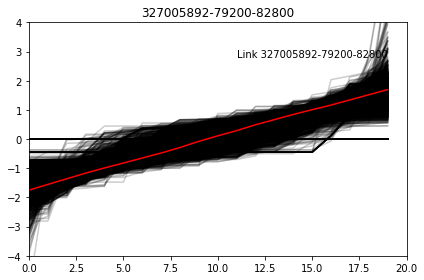

298786467-79200-82800
[152746500, 82800, 86400]: 1.4896796163955346
[547531528, 82800, 86400]: 1.3519047798041204
[547531527, 82800, 86400]: 0.4458091759445844
[420135389, 82800, 86400]: 1.4896796163955346
[8838071, 82800, 86400]: 0.9642062243375978
[301677886, 82800, 86400]: 1.4896796163955346
[152978752, 82800, 86400]: 0.8855854497527376
[547531535, 82800, 86400]: 1.4896796163955346
[547531525, 82800, 86400]: 1.4896796163955346
[159632718, 82800, 86400]: 0.45959902257565
[547531531, 82800, 86400]: 0.8976856104279695
[547531534, 82800, 86400]: 0.8739386405713512
[547531536, 82800, 86400]: 1.4033937461315
[47876615, 82800, 86400]: 4.710632994777079
[515675204, 82800, 86400]: 0.9984798835238702
[153947334, 82800, 86400]: 0.9336198770970708
[103934334, 82800, 86400]: 1.4896796163955346
[153947335, 82800, 86400]: 0.9917841435053149
[301677885, 82800, 86400]: 1.4896796163955346
[634307497, 82800, 86400]: 1.4896796163955346
[157490277, 82800, 86400]: 1.4896796163955346
[297830232, 82800, 86

[697819363, 0, 3600]: 1.4896796163955346
[423724842, 0, 3600]: 1.4934221436471782
[157489834, 0, 3600]: 0.6704644153476549
[152978672, 0, 3600]: 0.7506474603692972
[547531516, 0, 3600]: 0.38268168848638373
[440521424, 0, 3600]: 0.36241765163677986
[297971534, 0, 3600]: 4.710632994777079
[157488722, 0, 3600]: 1.4896796163955346
[152967148, 0, 3600]: 4.710632994777079
[152679218, 0, 3600]: 1.5030609000733135
[780911242, 0, 3600]: 0.6082942120297564
[104081781, 0, 3600]: 1.4896796163955346
[153019269, 0, 3600]: 0.41497230688955433
[152679413, 0, 3600]: 0.6428879449878223
[160451376, 0, 3600]: 1.4896796163955346
[299893502, 0, 3600]: 0.9689864482805166
[174924979, 0, 3600]: 0.565316451887367
[718963842, 0, 3600]: 1.4896796163955346
[104082865, 0, 3600]: 1.4896796163955346
[718963897, 0, 3600]: 2.2777302594767037
[159632877, 0, 3600]: 1.1242114134502978
[547531510, 0, 3600]: 0.3975440472910861
[152978671, 0, 3600]: 0.4324034783737884
[275539107, 0, 3600]: 1.642121192193812
[104082923, 0, 36

[688769623, 0, 3600]: 0.31850352351259653
[152679221, 0, 3600]: 1.005265989046289
[718963662, 0, 3600]: 1.4896796163955346
[681329980, 0, 3600]: 0.33206578070031323
[441497930, 0, 3600]: 1.4896796163955346
[298337589, 0, 3600]: 1.3769316214349263
[420095473, 0, 3600]: 1.3427788094785271
[423239429, 0, 3600]: 0.44721856067194504
[688769627, 0, 3600]: 0.36617224670280324
[675092021, 0, 3600]: 0.7438565483137217
[299893498, 0, 3600]: 0.5451279018975733
[159632858, 0, 3600]: 1.4896796163955346
[299081200, 0, 3600]: 0.3778948538663526
[104081780, 0, 3600]: 1.4896796163955346
[385619164, 0, 3600]: 0.3953274672188164
[299893499, 0, 3600]: 0.657142136861646
[420095474, 0, 3600]: 1.4896796163955346
[438172985, 0, 3600]: 1.481464693972397
[153946072, 0, 3600]: 1.4896796163955346
[152679414, 0, 3600]: 1.0169285997106534
[711385801, 0, 3600]: 1.218993875839345
[152995654, 0, 3600]: 1.4896796163955346
[344851269, 0, 3600]: 0.9362518504338248
[152665029, 0, 3600]: 1.4896796163955346
[153947088, 0, 3

[189465475, 3600, 7200]: 1.4896796163955346
[238611390, 3600, 7200]: 1.4896796163955346
[134801094, 3600, 7200]: 1.4896796163955346
[780970456, 3600, 7200]: 2.2777302594767983
[154534953, 3600, 7200]: 1.4896796163955346
[152928147, 3600, 7200]: 1.1167993108804033
[141129800, 3600, 7200]: 1.4896796163955346
[153022809, 3600, 7200]: 1.4896796163955346
[346316337, 3600, 7200]: 1.4896796163955346
[152928148, 3600, 7200]: 1.1818102537709478
[462617693, 3600, 7200]: 1.4896796163955346
[126243422, 3600, 7200]: 1.4896796163955346
[298930272, 3600, 7200]: 1.4896796163955346
[346316336, 3600, 7200]: 1.4896796163955346
[153053593, 3600, 7200]: 1.4896796163955346
[688769629, 3600, 7200]: 0.8923578779733696
[234332718, 3600, 7200]: 1.4896796163955346
[462617694, 3600, 7200]: 1.4896796163955346
[462617691, 3600, 7200]: 1.4896796163955346
[462617692, 3600, 7200]: 1.4896796163955346
[234332716, 3600, 7200]: 1.4896796163955346
[152928143, 3600, 7200]: 1.4896796163955346
[153035117, 3600, 7200]: 1.48967

[243630883, 25200, 28800]: 1.4896796163955346
[60712847, 25200, 28800]: 1.4896796163955346
[160451435, 25200, 28800]: 0.5311717739631515
[286685261, 25200, 28800]: 0.4002272447253322
[153050008, 25200, 28800]: 0.6151695027502663
[8035434, 25200, 28800]: 1.4896796163955346
[153050006, 25200, 28800]: 0.96437034726299
[153022759, 25200, 28800]: 1.4896796163955346
[441250601, 25200, 28800]: 0.300275555422077
[104082909, 25200, 28800]: 0.3875464256690474
[299081198, 25200, 28800]: 1.2890317569999474
[189677020, 25200, 28800]: 1.4896796163955346
[259111293, 25200, 28800]: 0.9273256812449292
[8035514, 25200, 28800]: 1.4528704980352767
[152895086, 25200, 28800]: 1.3480912423999882
[674573656, 25200, 28800]: 0.35868239988277495
[665834892, 25200, 28800]: 1.4896796163955346
[153050009, 25200, 28800]: 0.5511702315889708
[154535040, 25200, 28800]: 0.5462632490984655
[8035447, 25200, 28800]: 0.9759932434746287
[152665033, 25200, 28800]: 1.4896796163955346
[674573659, 25200, 28800]: 0.63118425558923

[221553440, 75600, 79200]: 0.4900870861615459
[319927896, 75600, 79200]: 2.939104265784174
[221553436, 75600, 79200]: 0.7470234893840183
[589546195, 75600, 79200]: 1.0459937169389861
[189677032, 75600, 79200]: 1.4896796163955346
[319927895, 75600, 79200]: 4.070487624591129
[152978739, 14400, 18000]: 1.4896796163955346
[243630880, 14400, 18000]: 1.4896796163955346
[152978740, 14400, 18000]: 1.4896796163955346
[515863915, 14400, 18000]: 1.4896796163955346
[152978741, 14400, 18000]: 1.4896796163955346
[245336348, 14400, 18000]: 1.4896796163955346
[423729097, 7200, 10800]: 0.4752667733617597
[152967216, 7200, 10800]: 0.8499743626382111
[547531554, 7200, 10800]: 1.4896796163955346
[189677018, 7200, 10800]: 1.4896796163955346
[152900440, 7200, 10800]: 1.64584417829713
[153021408, 7200, 10800]: 0.49707688888555657
[152900414, 7200, 10800]: 0.8292628945022118
[159740405, 7200, 10800]: 4.710632994777079
[533580372, 7200, 10800]: 1.4896796163955346
[152900428, 7200, 10800]: 1.1583992987993394
[4

[299094973, 7200, 10800]: 0.3477387135583812
[189663745, 7200, 10800]: 1.0995681913934598
[420135404, 7200, 10800]: 1.4896796163955346
[238618785, 7200, 10800]: 1.4896796163955346
[410326582, 7200, 10800]: 1.0066426531436556
[157489809, 7200, 10800]: 1.4896796163955346
[438177904, 7200, 10800]: 0.46223654258322566
[286685260, 7200, 10800]: 0.565783687507055
[547531507, 7200, 10800]: 1.4896796163955346
[238618783, 7200, 10800]: 1.4896796163955346
[154535105, 7200, 10800]: 1.0214120162902462
[299094964, 7200, 10800]: 0.5060112077877599
[443397605, 7200, 10800]: 1.377866107338057
[154150233, 7200, 10800]: 0.5400234450330498
[152665021, 7200, 10800]: 1.4896796163955346
[440644907, 7200, 10800]: 0.8002761497777057
[463524775, 7200, 10800]: 0.4353439422588628
[153946077, 7200, 10800]: 0.6384636248383158
[152665008, 7200, 10800]: 4.710632994777079
[152746487, 7200, 10800]: 4.710632994777079
[221553424, 7200, 10800]: 0.4855738344800862
[221553427, 7200, 10800]: 0.5715150588003884
[153021405, 7

[172232823, 79200, 82800]: 0.6703933804964102
[253717647, 79200, 82800]: 0.6901207306057666
[325598328, 79200, 82800]: 0.6901239733976042
[697192628, 79200, 82800]: 1.6470362465989883
[8035560, 79200, 82800]: 0.9416148891547537
[152665064, 79200, 82800]: 0.901605364793587
[443405859, 79200, 82800]: 0.3374287800061189
[160458423, 79200, 82800]: 1.2589388061978732
[153004045, 79200, 82800]: 1.2392025199110621
[438172975, 79200, 82800]: 2.00947821556284
[188842287, 79200, 82800]: 1.1386487924126978
[161620493, 79200, 82800]: 0.14687922320241778
[298877854, 79200, 82800]: 0.2259453179488702
[502511312, 79200, 82800]: 0.5989013316240539
[152900393, 79200, 82800]: 0.6752875709774545
[385334089, 79200, 82800]: 0.4232578602390375
[8035466, 79200, 82800]: 0.3999371525202719
[153049908, 79200, 82800]: 0.6009922209015864
[418178080, 79200, 82800]: 0.6774500468134621
[153019287, 79200, 82800]: 0.9403162359051941
[298822842, 79200, 82800]: 0.44561188335487684
[298217939, 79200, 82800]: 0.2269177239

[22810759, 79200, 82800]: 0.3544764064533434
[298822858, 79200, 82800]: 1.3189321954770201
[153019292, 79200, 82800]: 0.5647396039712713
[463524793, 79200, 82800]: 0.775077162348751
[160458424, 79200, 82800]: 0.6841020083318309
[153798137, 79200, 82800]: 0.37704946136371065
[418178094, 79200, 82800]: 1.4896796163955346
[373003234, 79200, 82800]: 1.1046978999671915
[438172970, 79200, 82800]: 0.23114888072979545
[423724814, 79200, 82800]: 0.2887580188906983
[423724836, 79200, 82800]: 0.6100713436379325
[298237461, 79200, 82800]: 1.356963839625302
[297998491, 79200, 82800]: 0.894321638110034
[188842265, 79200, 82800]: 0.47893896682990444
[152652992, 79200, 82800]: 1.311677878788983
[152668416, 79200, 82800]: 1.3635547484177712
[153019273, 79200, 82800]: 0.7790998143954804
[158618961, 79200, 82800]: 0.32775069749396285
[22810747, 79200, 82800]: 0.5438577062642946
[34700807, 79200, 82800]: 0.37873154172219403
[298786481, 79200, 82800]: 0.416688654928129
[34700783, 79200, 82800]: 0.865604104

[344851273, 79200, 82800]: 0.496095278736929
[152746391, 79200, 82800]: 0.43864228932681254
[298877134, 79200, 82800]: 0.36682414038909644
[298925926, 79200, 82800]: 0.7727612166533642
[780989738, 79200, 82800]: 1.5589827193675598
[491822821, 79200, 82800]: 0.9603044780063283
[152746448, 79200, 82800]: 0.8996640874512605
[408268176, 79200, 82800]: 0.49376796116313487
[251098642, 79200, 82800]: 0.4142240899357819
[159740342, 79200, 82800]: 0.8103005559142438
[463524792, 79200, 82800]: 0.9474759555057837
[320135998, 79200, 82800]: 1.3611584571392628
[153945670, 79200, 82800]: 0.21161390753136847
[344851275, 79200, 82800]: 0.5737641692463847
[152994911, 79200, 82800]: 1.370490456263989
[298786507, 79200, 82800]: 0.8435504376711722
[228275483, 79200, 82800]: 0.39863576583344323
[152895051, 79200, 82800]: 0.47837956044725327
[259109258, 79200, 82800]: 1.3663808943803617
[152679378, 79200, 82800]: 1.4896796163955346
[589546229, 79200, 82800]: 0.4211149127716327
[127127910, 79200, 82800]: 0.3

[155685567, 79200, 82800]: 0.4634234525525379
[153055990, 79200, 82800]: 0.6440431488925161
[8035452, 79200, 82800]: 0.6743203368392775
[248762962, 79200, 82800]: 0.23969284768323817
[439048438, 79200, 82800]: 0.7488695128169433
[46262600, 79200, 82800]: 0.30456181011059485
[480289612, 79200, 82800]: 1.0540307069155603
[781786569, 79200, 82800]: 0.52917487805295
[463524785, 79200, 82800]: 1.0128464211411439
[81869222, 79200, 82800]: 0.4069136833849309
[299094984, 79200, 82800]: 1.4150079862531069
[152924204, 79200, 82800]: 1.4896796163955346
[188842344, 79200, 82800]: 0.5428196360591768
[152679198, 79200, 82800]: 0.6997313266493301
[153035280, 79200, 82800]: 1.4896796163955346
[676950801, 79200, 82800]: 0.4555934651536587
[259109259, 79200, 82800]: 1.2277336784134498
[493523047, 79200, 82800]: 0.6918830393398037
[299081213, 79200, 82800]: 1.4896796163955346
[104082873, 79200, 82800]: 0.8531015371767745
[104081786, 79200, 82800]: 1.0909429419072345
[152900399, 79200, 82800]: 0.884809688

[188842346, 79200, 82800]: 0.5060418657064429
[34700803, 79200, 82800]: 0.47340945793796313
[152679318, 79200, 82800]: 0.5806506835559314
[780483745, 79200, 82800]: 1.203103438882455
[516508097, 79200, 82800]: 1.4969257741713136
[152900417, 79200, 82800]: 1.4896796163955346
[153053686, 79200, 82800]: 0.7951076827991549
[153035199, 79200, 82800]: 1.4896796163955346
[8578423, 79200, 82800]: 1.4896796163955346
[152668415, 79200, 82800]: 1.429780854307616
[420076116, 79200, 82800]: 2.424766106901402
[153000826, 79200, 82800]: 0.4082995269301854
[152924205, 79200, 82800]: 1.4896796163955346
[153035254, 79200, 82800]: 0.3370464495172542
[153947387, 79200, 82800]: 0.37824898987950145
[441250589, 79200, 82800]: 0.9494065369642392
[153021410, 79200, 82800]: 0.4228712709124893
[502511294, 79200, 82800]: 0.37134635515782866
[480289617, 79200, 82800]: 0.3422030004079162
[441265802, 79200, 82800]: 0.2845185404279783
[46429888, 79200, 82800]: 0.5884566318682236
[154149753, 79200, 82800]: 1.246652112

[502501390, 79200, 82800]: 0.5749252215385771
[152966821, 79200, 82800]: 0.18416996965250346
[153053626, 79200, 82800]: 1.4896796163955346
[251098065, 79200, 82800]: 0.3631048747742288
[153019257, 79200, 82800]: 1.4860398203917449
[480289566, 79200, 82800]: 2.223901896018864
[649730263, 79200, 82800]: 1.0530092587173234
[152656949, 79200, 82800]: 0.4039805442734101
[189452925, 79200, 82800]: 0.4341171247274228
[463337415, 79200, 82800]: 0.9638961845865048
[610571163, 79200, 82800]: 0.5722911903166779
[153035196, 79200, 82800]: 1.0811568240903207
[298786494, 79200, 82800]: 1.2450072315638139
[152679410, 79200, 82800]: 0.7670960363920017
[152665016, 79200, 82800]: 0.7736975573610219
[298822855, 79200, 82800]: 1.4658555739051293
[153004063, 79200, 82800]: 0.9130104004088878
[153053635, 79200, 82800]: 1.4896796163955346
[275345116, 79200, 82800]: 1.4896796163955346
[502511309, 79200, 82800]: 0.33395313095359336
[153053636, 79200, 82800]: 1.5639324453936385
[238609962, 79200, 82800]: 1.4754

[780483749, 79200, 82800]: 1.416550217956226
[153019279, 79200, 82800]: 1.131325385078682
[47876603, 79200, 82800]: 0.6787354526231826
[441265812, 79200, 82800]: 0.8898445546594742
[153035282, 79200, 82800]: 1.4896796163955346
[505168801, 79200, 82800]: 0.6887513247744015
[152679308, 79200, 82800]: 0.39824160114658763
[610571170, 79200, 82800]: 1.1285781579243888
[34700797, 79200, 82800]: 0.2547837940502499
[418178088, 79200, 82800]: 1.1082250065500558
[152679283, 79200, 82800]: 0.9587567792991697
[189424082, 79200, 82800]: 0.23030225322484943
[220393428, 79200, 82800]: 0.48896798288817267
[572708714, 79200, 82800]: 1.530281923663441
[46430970, 79200, 82800]: 0.404332478018673
[153945671, 79200, 82800]: 0.25962864592575463
[152665037, 79200, 82800]: 0.3577610494535394
[189452945, 79200, 82800]: 0.3916751478624635
[152654158, 79200, 82800]: 0.47071494146312803
[649730259, 79200, 82800]: 0.5840017325470784
[480289603, 79200, 82800]: 1.47154840656096
[153019289, 79200, 82800]: 0.960539210

[152976619, 79200, 82800]: 1.4896796163955346
[160440586, 79200, 82800]: 0.9749279036876407
[325598341, 79200, 82800]: 0.6417119392879906
[248762944, 79200, 82800]: 0.48747883867585723
[152746450, 79200, 82800]: 0.8757740350035399
[423724812, 79200, 82800]: 0.29892912940674893
[298623917, 79200, 82800]: 0.9018710025879189
[152995665, 79200, 82800]: 0.6819744210262525
[5069463, 79200, 82800]: 0.4605422731949668
[189677002, 79200, 82800]: 0.3171930276701878
[298843857, 79200, 82800]: 1.0601415900834261
[152967676, 79200, 82800]: 1.3218834641119046
[152746380, 79200, 82800]: 0.8965436899193184
[152746413, 79200, 82800]: 0.3115568563013982
[152679309, 79200, 82800]: 0.46487217486440924
[188842240, 79200, 82800]: 0.7486387207609695
[220393423, 79200, 82800]: 0.5122159226451048
[8035557, 79200, 82800]: 0.7712816618653178
[153004056, 79200, 82800]: 1.3093592575729716
[320136006, 79200, 82800]: 0.5213082158112118
[325598338, 79200, 82800]: 1.9775189145676648
[344864793, 79200, 82800]: 0.214501

[188842251, 79200, 82800]: 0.40984398720200665
[298822846, 79200, 82800]: 0.5219305332237246
[298822848, 79200, 82800]: 0.44966700764377754
[297998497, 79200, 82800]: 1.4896796163955346
[172232826, 79200, 82800]: 0.3403988297023819
[442373728, 79200, 82800]: 0.7390435997164508
[502511307, 79200, 82800]: 0.4192299074340429
[153050034, 79200, 82800]: 0.2845927930830776
[780989739, 79200, 82800]: 1.5222686199306479
[152656805, 79200, 82800]: 0.38731372339091397
[172232824, 79200, 82800]: 0.26022580868979595
[158618963, 79200, 82800]: 0.3450029949648268
[158618962, 79200, 82800]: 0.5627421293020166
[188842318, 79200, 82800]: 0.7036834818919885
[344864787, 79200, 82800]: 0.2634735616142669
[441304018, 79200, 82800]: 0.32043403581115176
[217603104, 79200, 82800]: 0.41718103461218836
[252835216, 79200, 82800]: 0.3611831544414952
[781786566, 79200, 82800]: 1.0266762123262967
[153798134, 79200, 82800]: 0.37571951457194724
[779578745, 79200, 82800]: 1.0641436780832856
[298237452, 79200, 82800]: 

[217531002, 79200, 82800]: 1.4896796163955346
[297970845, 79200, 82800]: 0.41493778643225687
[441304020, 79200, 82800]: 0.30994685724399723
[152746495, 79200, 82800]: 1.4896796163955346
[298703044, 79200, 82800]: 0.29669877716961923
[152967193, 79200, 82800]: 1.3314421078866603
[298786505, 79200, 82800]: 0.8637254812769901
[188842311, 79200, 82800]: 0.6329365117514322
[491822822, 79200, 82800]: 0.9726977097975431
[298932014, 79200, 82800]: 0.45256087190023003
[530633117, 79200, 82800]: 0.8381265875231256
[299094968, 79200, 82800]: 0.632574356121106
[22810755, 79200, 82800]: 0.46128774043807325
[46932858, 79200, 82800]: 1.5938431844996312
[160451431, 79200, 82800]: 1.4896796163955346
[221553431, 79200, 82800]: 0.41159131131476373
[442373718, 79200, 82800]: 1.5454933513030347
[245330481, 79200, 82800]: 0.5491322877815656
[298925931, 79200, 82800]: 0.8187110454158236
[253717646, 79200, 82800]: 0.5203569028776439
[46430966, 79200, 82800]: 0.3828533189752399
[610571165, 79200, 82800]: 1.369

[610571161, 79200, 82800]: 0.26119002844803274
[438177910, 79200, 82800]: 1.2243660088647956
[298786037, 79200, 82800]: 0.4764235332348016
[152924945, 79200, 82800]: 0.8548099644260965
[440522452, 79200, 82800]: 0.49101273335374035
[297881922, 79200, 82800]: 1.4896796163955346
[153050030, 79200, 82800]: 0.3181188977977246
[572708711, 79200, 82800]: 1.0315408884108621
[298930269, 79200, 82800]: 0.14283924085665065
[161620484, 79200, 82800]: 1.41831819674922
[152654144, 79200, 82800]: 0.2415139955070554
[5135020, 79200, 82800]: 0.7106791511486698
[152895084, 79200, 82800]: 0.46111399711181117
[188842294, 79200, 82800]: 0.3276000530161925
[153035153, 79200, 82800]: 0.6885509918970393
[152651306, 79200, 82800]: 0.2827168761317604
[153043548, 79200, 82800]: 0.5621669102647462
[234352574, 79200, 82800]: 0.5057348138062302
[252835221, 79200, 82800]: 0.3469809875301129
[152978743, 79200, 82800]: 0.9089200663231617
[153044322, 79200, 82800]: 0.4375467297821226
[676703083, 79200, 82800]: 1.07304

[440644905, 79200, 82800]: 0.5088790183720414
[157488898, 79200, 82800]: 0.158242868927199
[301724748, 79200, 82800]: 0.5370204953275637
[46594679, 79200, 82800]: 0.7242897405672611
[385334123, 79200, 82800]: 1.4896796163955346
[346316345, 79200, 82800]: 0.3158761923509125
[152977271, 79200, 82800]: 1.4896796163955346
[34700790, 79200, 82800]: 0.4960288957927619
[141129798, 79200, 82800]: 0.92724849694018
[8035480, 79200, 82800]: 0.3646742674229397
[319927912, 79200, 82800]: 1.4896796163955346
[779578746, 79200, 82800]: 0.9199808225029633
[441497927, 79200, 82800]: 0.8433797555464488
[8035530, 79200, 82800]: 0.8123338054757556
[46414937, 79200, 82800]: 0.6280443837096852
[374771720, 79200, 82800]: 1.4896796163955346
[228275476, 79200, 82800]: 0.31031517215180976
[780964775, 79200, 82800]: 0.2909982284174349
[160455776, 79200, 82800]: 0.5071755498077326
[189452934, 79200, 82800]: 0.8552413823729154
[154149754, 79200, 82800]: 0.698169834613067
[191003448, 79200, 82800]: 0.391479291870253

[152995662, 79200, 82800]: 1.4896796163955346
[188842305, 79200, 82800]: 0.6228768560738961
[423724810, 79200, 82800]: 0.26705777560616883
[779578751, 79200, 82800]: 0.6220942090820224
[160440591, 79200, 82800]: 1.2252348905439048
[697192630, 79200, 82800]: 0.719738562580906
[299081215, 79200, 82800]: 1.4896796163955346
[779578752, 79200, 82800]: 0.8540482342173529
[153019282, 79200, 82800]: 1.1669324278019821
[152679407, 79200, 82800]: 0.39200743268669314
[153019285, 79200, 82800]: 0.4233739237635082
[589546210, 79200, 82800]: 0.547522545304692
[152995669, 79200, 82800]: 0.3393558653510572
[411394826, 79200, 82800]: 0.599595438596606
[410013921, 79200, 82800]: 1.047390354016544
[463337397, 79200, 82800]: 0.30401850339383885
[443439114, 79200, 82800]: 0.27773059184214466
[441265803, 79200, 82800]: 0.3186630740990968
[8578418, 79200, 82800]: 1.4896796163955346
[104081821, 79200, 82800]: 0.41020987646727175
[160469983, 79200, 82800]: 0.385313682655576
[298932011, 79200, 82800]: 0.5124341

[252392943, 79200, 82800]: 0.9933647286566505
[251098938, 79200, 82800]: 1.4896796163955346
[159632734, 79200, 82800]: 0.5988714615939732
[152966820, 79200, 82800]: 0.2078360361844932
[172232825, 79200, 82800]: 0.3182820966172433
[153044296, 79200, 82800]: 1.0029009159992373
[157488904, 79200, 82800]: 0.33271321685554206
[440522453, 79200, 82800]: 0.41697818319899704
[221553413, 79200, 82800]: 0.8051270427973307
[298786500, 79200, 82800]: 1.2718752725170643
[160449030, 79200, 82800]: 1.2717128472449766
[153004041, 79200, 82800]: 1.264207736456574
[589546209, 79200, 82800]: 0.5239665894956423
[572708715, 79200, 82800]: 0.8340036145747136
[153041109, 79200, 82800]: 1.4896796163955346
[441265814, 79200, 82800]: 0.9894354474887642
[22810757, 79200, 82800]: 0.45582764570804585
[275345118, 79200, 82800]: 1.018624424885603
[152967748, 79200, 82800]: 1.4896796163955346
[153798141, 79200, 82800]: 0.3926523155796082
[5069462, 79200, 82800]: 0.4546691701866006
[480289616, 79200, 82800]: 0.4045852

[385331942, 79200, 82800]: 0.44046896994508006
[420076113, 79200, 82800]: 2.3881065037639297
[252835489, 79200, 82800]: 0.6902374610966271
[188842258, 79200, 82800]: 0.4137274472345528
[676166104, 79200, 82800]: 0.4196922632325096
[160469984, 79200, 82800]: 0.5257774074231882
[228275484, 79200, 82800]: 0.8164844406437753
[298703047, 79200, 82800]: 0.3145807489665751
[251098939, 79200, 82800]: 1.4896796163955346
[423724811, 79200, 82800]: 0.29200001274530235
[297882692, 79200, 82800]: 0.9792554059250794
[152679369, 79200, 82800]: 0.8483677521050729
[344851281, 79200, 82800]: 0.4705854852066337
[153035150, 79200, 82800]: 0.677990747348181
[320064979, 79200, 82800]: 1.4896796163955346
[301724759, 79200, 82800]: 0.42384994264396425
[259109260, 79200, 82800]: 1.4084533433031579
[610571166, 79200, 82800]: 1.266971096147075
[161620483, 79200, 82800]: 1.3190076954056629
[245333280, 79200, 82800]: 1.141892396685802
[252835230, 79200, 82800]: 0.678384207259894
[459670501, 79200, 82800]: 0.180006

[188842322, 79200, 82800]: 0.705296117843109
[152994901, 79200, 82800]: 0.3740416704919831
[191003446, 79200, 82800]: 0.27017640548922084
[480289620, 79200, 82800]: 0.4596505395174607
[301677374, 79200, 82800]: 0.30600706845366493
[153030229, 79200, 82800]: 1.4896796163955346
[153030739, 79200, 82800]: 1.4896796163955346
[531743749, 79200, 82800]: 0.4026052330143247
[298337592, 79200, 82800]: 0.9158903288032497
[463337399, 79200, 82800]: 0.31108497289248355
[463337408, 79200, 82800]: 0.28257519913983653
[385334126, 79200, 82800]: 1.4896796163955346
[439048437, 79200, 82800]: 0.751678457033818
[152665014, 79200, 82800]: 0.5078663505900778
[152977272, 79200, 82800]: 1.2505327100684283
[410013929, 79200, 82800]: 1.223079748286774
[22810749, 79200, 82800]: 0.46764310986572943
[81797653, 79200, 82800]: 0.33960376172857576
[153049972, 79200, 82800]: 0.38174627884261747
[298237458, 79200, 82800]: 0.9290866147574396
[442373711, 79200, 82800]: 0.16083136679417387
[301677359, 79200, 82800]: 0.25

[530633118, 79200, 82800]: 0.8545003507401425
[153021414, 79200, 82800]: 2.448503084462565
[441455572, 79200, 82800]: 0.7028662170427644
[346316344, 79200, 82800]: 0.40388655179978983
[22810750, 79200, 82800]: 0.3991925447311141
[153019297, 79200, 82800]: 1.4896796163955346
[153019241, 79200, 82800]: 1.387326670020588
[152668391, 79200, 82800]: 0.60033601741353
[158618964, 79200, 82800]: 0.16514203706895053
[238609964, 79200, 82800]: 1.4896796163955346
[22810766, 79200, 82800]: 0.5163955292847288
[440644898, 79200, 82800]: 0.7234130007260081
[46429885, 79200, 82800]: 1.3689729860809245
[298503412, 79200, 82800]: 0.42555488026363886
[420076281, 79200, 82800]: 0.5623183302170555
[8035467, 79200, 82800]: 0.5329467202127939
[153041108, 79200, 82800]: 1.4896796163955346
[259110133, 79200, 82800]: 1.4896796163955346
[8035578, 79200, 82800]: 0.32043577836399467
[161620515, 79200, 82800]: 1.177810042996951
[238610486, 79200, 82800]: 1.566924558504283
[154535132, 79200, 82800]: 1.09067478175305

[781830256, 79200, 82800]: 0.8631713376925207
[8035568, 79200, 82800]: 0.7871185265924617
[152679286, 79200, 82800]: 1.4555526253270272
[153000939, 79200, 82800]: 0.4001144015644626
[301677365, 79200, 82800]: 0.3786887640764252
[153019302, 79200, 82800]: 1.2017131006750599
[297829488, 79200, 82800]: 0.31180054121503953
[299024304, 79200, 82800]: 0.3324158702672769
[252392950, 79200, 82800]: 1.5088926671132734
[34700804, 79200, 82800]: 0.6424041153569952
[252835213, 79200, 82800]: 0.35093107666088075
[159740377, 79200, 82800]: 1.124271772356543
[298703050, 79200, 82800]: 0.785207368809409
[423729717, 79200, 82800]: 1.4896796163955346
[442373720, 79200, 82800]: 0.9512241602349417
[153019243, 79200, 82800]: 0.7680447904838263
[504476756, 79200, 82800]: 0.7140744816701944
[228275470, 79200, 82800]: 0.3067746047586394
[252392952, 79200, 82800]: 0.5898073525430719
[153019294, 79200, 82800]: 0.6894314818010407
[423724799, 79200, 82800]: 0.18177358098194
[153035197, 79200, 82800]: 1.4896796163

[5069467, 79200, 82800]: 0.3174503874627763
[34700810, 79200, 82800]: 0.24112125174319438
[418178083, 79200, 82800]: 0.8527292030500817
[152668397, 79200, 82800]: 0.6720979702144891
[547531550, 79200, 82800]: 0.8351474307339415
[153021403, 79200, 82800]: 0.648684462472468
[8035464, 79200, 82800]: 0.4544083101028811
[373003235, 79200, 82800]: 1.5433039686089935
[245337809, 79200, 82800]: 0.6378728971378173
[46414946, 79200, 82800]: 0.6233615485419907
[516508076, 79200, 82800]: 0.3057369064181283
[515699252, 79200, 82800]: 2.70879411834429
[152656941, 79200, 82800]: 0.3184663720002137
[676152423, 79200, 82800]: 1.2959232764405344
[152900396, 79200, 82800]: 1.157940745497819
[423729713, 79200, 82800]: 1.4896796163955346
[780211971, 79200, 82800]: 1.5141857643916934
[153021398, 79200, 82800]: 1.4896796163955346
[154539320, 79200, 82800]: 1.003463663826147
[153006805, 79200, 82800]: 1.4332381987350558
[547531553, 79200, 82800]: 1.4896796163955346
[463337412, 79200, 82800]: 0.382779807448076

[298237442, 46800, 50400]: 0.446824598746548
[298726735, 46800, 50400]: 0.302640681335929
[502511268, 46800, 50400]: 0.41601851975282744
[244021208, 46800, 50400]: 1.0623700873845694
[298237444, 46800, 50400]: 0.5396274073562287
[160458427, 46800, 50400]: 1.4896796163955346
[780970465, 46800, 50400]: 0.4702802054552479
[8578408, 46800, 50400]: 1.0092543816084139
[160458428, 46800, 50400]: 1.4896796163955346
[81797896, 46800, 50400]: 0.8206233885899215
[298703052, 46800, 50400]: 0.25419932045382
[298418289, 46800, 50400]: 1.4896796163955346
[298418291, 46800, 50400]: 1.4896796163955346
[385334100, 46800, 50400]: 1.5593109109930785
[8169122, 46800, 50400]: 0.27599536410720754
[480289590, 46800, 50400]: 1.33205024744615
[104334701, 46800, 50400]: 0.3077641263170604
[298703026, 46800, 50400]: 0.48141870562055555
[780970464, 46800, 50400]: 0.3684494856434052
[418178076, 46800, 50400]: 1.5486068619851177
[443414628, 46800, 50400]: 0.876016059609001
[159632884, 46800, 50400]: 1.50525720248510

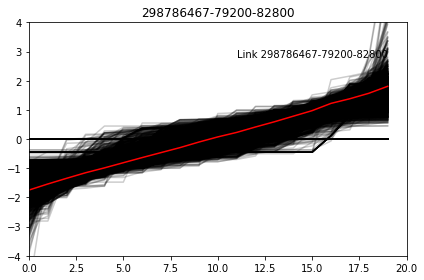

221553428-79200-82800
[152746500, 82800, 86400]: 4.935223187002909
[547531528, 82800, 86400]: 4.965981722793764
[547531527, 82800, 86400]: 4.6906975645145295
[420135389, 82800, 86400]: 4.935223187002909
[8838071, 82800, 86400]: 4.841023393160069
[301677886, 82800, 86400]: 4.935223187002909
[152978752, 82800, 86400]: 5.22142656580883
[547531535, 82800, 86400]: 4.935223187002909
[547531525, 82800, 86400]: 4.935223187002909
[159632718, 82800, 86400]: 4.538710173114927
[547531531, 82800, 86400]: 4.550122543225471
[547531534, 82800, 86400]: 4.557790506307354
[547531536, 82800, 86400]: 4.983517005638187
[47876615, 82800, 86400]: 5.915168726144757
[515675204, 82800, 86400]: 4.957931989721774
[153947334, 82800, 86400]: 4.841330221944815
[103934334, 82800, 86400]: 4.935223187002909
[153947335, 82800, 86400]: 4.631890326235797
[301677885, 82800, 86400]: 4.935223187002909
[634307497, 82800, 86400]: 4.935223187002909
[157490277, 82800, 86400]: 4.935223187002909
[297830232, 82800, 86400]: 5.0119666

[160451376, 0, 3600]: 4.935223187002909
[299893502, 0, 3600]: 4.867250814499691
[174924979, 0, 3600]: 5.1663466127117115
[718963842, 0, 3600]: 4.935223187002909
[104082865, 0, 3600]: 4.935223187002909
[718963897, 0, 3600]: 3.2147696484136046
[159632877, 0, 3600]: 4.902374147541285
[547531510, 0, 3600]: 4.248656887795407
[152978671, 0, 3600]: 4.482720429101306
[275539107, 0, 3600]: 5.582753425455344
[104082923, 0, 3600]: 5.282716991903064
[157489829, 0, 3600]: 4.865467238438788
[5135005, 0, 3600]: 5.537679099455596
[153947337, 0, 3600]: 4.8311157386262
[420135390, 0, 3600]: 6.034528171460289
[298503435, 0, 3600]: 5.748193142145413
[718963664, 0, 3600]: 4.935223187002909
[780908702, 0, 3600]: 3.2147696484135655
[46414952, 0, 3600]: 5.915168726144757
[547531519, 0, 3600]: 5.02588671983359
[610577096, 0, 3600]: 4.935223187002909
[153035109, 0, 3600]: 5.915168726144757
[228275490, 0, 3600]: 5.041954662176513
[134801106, 0, 3600]: 4.935223187002909
[688769630, 0, 3600]: 4.614052709682017
[16

[675092019, 0, 3600]: 4.84462314752215
[299081199, 0, 3600]: 5.215889309947528
[160455795, 0, 3600]: 4.994811170210601
[493523037, 0, 3600]: 4.7075373684138455
[152679297, 0, 3600]: 3.214769648413529
[245338047, 0, 3600]: 4.771066466387318
[319950437, 0, 3600]: 4.935223187002909
[251098736, 0, 3600]: 4.935223187002909
[159632856, 0, 3600]: 4.9583390095645195
[675346499, 0, 3600]: 5.16978613135098
[440530041, 0, 3600]: 4.935223187002909
[104082860, 0, 3600]: 5.102650554473897
[533580369, 0, 3600]: 4.644239508593808
[152679223, 0, 3600]: 4.949479404983338
[516917908, 0, 3600]: 4.737915090496124
[252392826, 0, 3600]: 4.410174819848944
[532966826, 0, 3600]: 5.047562103616328
[153053654, 0, 3600]: 4.935223187002909
[152900443, 0, 3600]: 4.935223187002909
[298029518, 0, 3600]: 4.669236723504579
[681329979, 0, 3600]: 5.01139086598488
[189677015, 0, 3600]: 5.249177669427094
[610577095, 0, 3600]: 4.935223187002909
[320136018, 0, 3600]: 4.935223187002909
[320136015, 0, 3600]: 4.935223187002909
[

[160451453, 25200, 28800]: 4.612234013413098
[195407902, 25200, 28800]: 4.935223187002909
[153044317, 25200, 28800]: 4.949808844444714
[153022803, 25200, 28800]: 4.935223187002909
[152977252, 25200, 28800]: 4.401862177708296
[515675220, 25200, 28800]: 4.7560847112364595
[46262594, 25200, 28800]: 4.372913988287318
[397153554, 25200, 28800]: 4.196424515819673
[515675218, 25200, 28800]: 4.847470936858507
[297817954, 25200, 28800]: 4.642705117379837
[674573654, 25200, 28800]: 4.81853410073145
[189677022, 25200, 28800]: 4.935223187002909
[153946955, 25200, 28800]: 4.586486667905643
[153050017, 25200, 28800]: 4.796101090181001
[5135012, 25200, 28800]: 5.5810070745515725
[298549718, 25200, 28800]: 4.935223187002909
[459670484, 25200, 28800]: 4.935223187002909
[46262596, 25200, 28800]: 4.935223187002909
[674573655, 25200, 28800]: 4.819240665745041
[152967672, 25200, 28800]: 4.6777045773040875
[153044334, 25200, 28800]: 5.618356437450355
[780526396, 25200, 28800]: 4.6188201707266
[515675226, 25

[46262611, 61200, 64800]: 4.58009137887446
[152967196, 61200, 64800]: 4.935223187002909
[8578404, 61200, 64800]: 4.935223187002909
[413320310, 61200, 64800]: 4.701680399487895
[47876609, 61200, 64800]: 5.185249035250783
[60712851, 61200, 64800]: 2.0717985490535216
[47876617, 61200, 64800]: 4.602915320706818
[152679244, 61200, 64800]: 4.972236901745215
[152924167, 61200, 64800]: 4.935223187002909
[152679243, 61200, 64800]: 4.940023541493423
[152967669, 61200, 64800]: 4.935223187002909
[298925985, 75600, 79200]: 4.69434395692056
[189663723, 75600, 79200]: 4.196123473075501
[189663724, 75600, 79200]: 4.100319289997501
[153053630, 75600, 79200]: 4.453044714937121
[252392916, 75600, 79200]: 4.418980399545071
[221553433, 75600, 79200]: 4.6854319607908
[589546192, 75600, 79200]: 4.640251828648583
[46414951, 75600, 79200]: 4.935223187002909
[298925983, 75600, 79200]: 4.856825105983389
[610949942, 75600, 79200]: 4.935223187002909
[589546194, 75600, 79200]: 4.4641914931895785
[189677031, 75600, 

[160451381, 7200, 10800]: 4.522481435497715
[298692636, 7200, 10800]: 3.760291509813575
[697192618, 7200, 10800]: 5.6260294632585675
[22810920, 7200, 10800]: 4.555085911501454
[152995676, 7200, 10800]: 4.935223187002909
[152967200, 7200, 10800]: 4.649866956679043
[675346501, 7200, 10800]: 4.935223187002909
[153022799, 7200, 10800]: 4.935223187002909
[440536714, 7200, 10800]: 5.945825717431584
[153055965, 7200, 10800]: 5.915168726144757
[423729098, 7200, 10800]: 5.5260714509586935
[697819357, 7200, 10800]: 4.748280835878482
[238618786, 7200, 10800]: 4.935223187002909
[610577099, 7200, 10800]: 3.9972663943268185
[245334308, 7200, 10800]: 4.935223187002909
[438177906, 7200, 10800]: 4.907897492114097
[515863909, 7200, 10800]: 4.935223187002909
[152967214, 7200, 10800]: 4.935223187002909
[438177905, 7200, 10800]: 4.825689875793331
[141129781, 7200, 10800]: 4.935223187002909
[319899460, 7200, 10800]: 4.935223187002909
[780970461, 7200, 10800]: 4.935223187002909
[189677017, 7200, 10800]: 4.93

[153035184, 79200, 82800]: 4.67323394228059
[676441316, 79200, 82800]: 4.63042186435613
[153044307, 79200, 82800]: 4.763405009742706
[441341846, 79200, 82800]: 4.767738915047402
[153948153, 79200, 82800]: 4.664182375883856
[153043605, 79200, 82800]: 3.8194368132495304
[152656953, 79200, 82800]: 4.460636487323889
[275345115, 79200, 82800]: 4.935223187002909
[8035570, 79200, 82800]: 4.119829012386295
[298237456, 79200, 82800]: 5.441609608330681
[152995672, 79200, 82800]: 4.449739470362051
[46262602, 79200, 82800]: 4.529064796129731
[191003437, 79200, 82800]: 4.694153052244677
[189676997, 79200, 82800]: 4.850258718320304
[610571168, 79200, 82800]: 5.29463935528845
[252392937, 79200, 82800]: 5.429310585336072
[152651308, 79200, 82800]: 4.302145699050248
[153006813, 79200, 82800]: 4.751807614086583
[245334303, 79200, 82800]: 4.2511168239055905
[502511292, 79200, 82800]: 4.977701479367708
[153004052, 79200, 82800]: 4.482290036586979
[610949940, 79200, 82800]: 4.392954362200947
[152651320, 79

[781830254, 79200, 82800]: 5.059080622651546
[152679405, 79200, 82800]: 5.628494467398067
[153043599, 79200, 82800]: 5.171039947841492
[298703032, 79200, 82800]: 4.774265994175044
[160462990, 79200, 82800]: 4.626968684157797
[159740338, 79200, 82800]: 5.47952266553729
[678035897, 79200, 82800]: 5.875007231118382
[298234501, 79200, 82800]: 4.531392681145031
[320136000, 79200, 82800]: 5.089840824663111
[22810759, 79200, 82800]: 4.462761642489431
[298822858, 79200, 82800]: 3.940977728556902
[153019292, 79200, 82800]: 4.444424604048101
[463524793, 79200, 82800]: 5.395592372950384
[160458424, 79200, 82800]: 4.70734180408913
[153798137, 79200, 82800]: 4.929378660894219
[418178094, 79200, 82800]: 4.935223187002909
[373003234, 79200, 82800]: 5.721658872192049
[438172970, 79200, 82800]: 4.633121793831262
[423724814, 79200, 82800]: 4.440454625380974
[423724836, 79200, 82800]: 5.052534809387
[298237461, 79200, 82800]: 4.967634455705949
[297998491, 79200, 82800]: 4.813643336047608
[188842265, 7920

[157489531, 79200, 82800]: 4.979073741288713
[780964776, 79200, 82800]: 4.371016192965991
[152679279, 79200, 82800]: 4.767966451626178
[344851273, 79200, 82800]: 4.832510579597274
[152746391, 79200, 82800]: 4.908532342052638
[298877134, 79200, 82800]: 4.759746704891774
[298925926, 79200, 82800]: 4.760621517178593
[780989738, 79200, 82800]: 5.309070903809987
[491822821, 79200, 82800]: 4.044323410720752
[152746448, 79200, 82800]: 4.044790443113956
[408268176, 79200, 82800]: 4.3048021570868755
[251098642, 79200, 82800]: 4.899887090764817
[159740342, 79200, 82800]: 5.098173665348294
[463524792, 79200, 82800]: 5.3988443265397
[320135998, 79200, 82800]: 4.975306727934778
[153945670, 79200, 82800]: 4.626747073183373
[344851275, 79200, 82800]: 4.729658627180574
[152994911, 79200, 82800]: 4.226261939837189
[298786507, 79200, 82800]: 4.9104486252781605
[228275483, 79200, 82800]: 4.715195138017327
[152895051, 79200, 82800]: 4.908903030924031
[259109258, 79200, 82800]: 5.655888173960829
[152679378

[420076292, 79200, 82800]: 4.935223187002909
[155685567, 79200, 82800]: 4.749571217579987
[153055990, 79200, 82800]: 4.012151409377256
[8035452, 79200, 82800]: 4.151047369864997
[248762962, 79200, 82800]: 4.739607571176389
[439048438, 79200, 82800]: 5.027117426276805
[46262600, 79200, 82800]: 4.694336964367581
[480289612, 79200, 82800]: 3.60960061303464
[781786569, 79200, 82800]: 4.180767560863631
[463524785, 79200, 82800]: 3.8017066965652786
[81869222, 79200, 82800]: 4.897461861012582
[299094984, 79200, 82800]: 5.800802073534639
[152924204, 79200, 82800]: 4.935223187002909
[188842344, 79200, 82800]: 4.645032311570256
[152679198, 79200, 82800]: 4.5557294845600795
[153035280, 79200, 82800]: 4.935223187002909
[676950801, 79200, 82800]: 4.606581818295333
[259109259, 79200, 82800]: 5.377598102270104
[493523047, 79200, 82800]: 4.718725000600877
[299081213, 79200, 82800]: 4.935223187002909
[104082873, 79200, 82800]: 5.146357712008017
[104081786, 79200, 82800]: 4.114630442766433
[152900399, 7

[152900417, 79200, 82800]: 4.935223187002909
[153053686, 79200, 82800]: 4.177046766380823
[153035199, 79200, 82800]: 4.935223187002909
[8578423, 79200, 82800]: 4.935223187002909
[152668415, 79200, 82800]: 4.992436651661345
[420076116, 79200, 82800]: 6.4783137920461575
[153000826, 79200, 82800]: 4.353327238079028
[152924205, 79200, 82800]: 4.935223187002909
[153035254, 79200, 82800]: 4.6035184195462495
[153947387, 79200, 82800]: 4.764442166655425
[441250589, 79200, 82800]: 4.750347884346588
[153021410, 79200, 82800]: 4.260397371627609
[502511294, 79200, 82800]: 4.88788439070019
[480289617, 79200, 82800]: 4.385738138203813
[441265802, 79200, 82800]: 4.658039253508409
[46429888, 79200, 82800]: 4.679999098173917
[154149753, 79200, 82800]: 3.633521905901688
[104082910, 79200, 82800]: 5.469736232843361
[47877709, 79200, 82800]: 4.935223187002909
[298029512, 79200, 82800]: 4.562958595361452
[410013920, 79200, 82800]: 4.957272277210494
[385621389, 79200, 82800]: 4.733899251910636
[160449033, 7

[152966821, 79200, 82800]: 4.614699911119274
[153053626, 79200, 82800]: 4.935223187002909
[251098065, 79200, 82800]: 4.202215568301136
[153019257, 79200, 82800]: 4.035208563686987
[480289566, 79200, 82800]: 6.311041468344363
[649730263, 79200, 82800]: 4.197826317451757
[152656949, 79200, 82800]: 4.237633420116039
[189452925, 79200, 82800]: 4.77771993423796
[463337415, 79200, 82800]: 4.9383354494045255
[610571163, 79200, 82800]: 4.055252175622564
[153035196, 79200, 82800]: 4.528676056090658
[298786494, 79200, 82800]: 3.755874490337065
[152679410, 79200, 82800]: 4.133364115798722
[152665016, 79200, 82800]: 5.3276520691369145
[298822855, 79200, 82800]: 5.004497750356486
[153004063, 79200, 82800]: 4.736137275200598
[153053635, 79200, 82800]: 4.935223187002909
[275345116, 79200, 82800]: 4.935223187002909
[502511309, 79200, 82800]: 4.4877669100401505
[153053636, 79200, 82800]: 5.545082743166849
[238609962, 79200, 82800]: 5.007671382851391
[344864789, 79200, 82800]: 4.589448987668532
[8578438

[47876603, 79200, 82800]: 4.691821337732623
[441265812, 79200, 82800]: 5.268191728759636
[153035282, 79200, 82800]: 4.935223187002909
[505168801, 79200, 82800]: 5.022401475913059
[152679308, 79200, 82800]: 4.709959871528924
[610571170, 79200, 82800]: 3.8005917852606173
[34700797, 79200, 82800]: 4.540333680452236
[418178088, 79200, 82800]: 4.117054683553233
[152679283, 79200, 82800]: 4.787997982143924
[189424082, 79200, 82800]: 4.662566035148724
[220393428, 79200, 82800]: 4.165675964706354
[572708714, 79200, 82800]: 5.9969994163492295
[46430970, 79200, 82800]: 4.875240317775272
[153945671, 79200, 82800]: 4.547776902135303
[152665037, 79200, 82800]: 4.776396012135318
[189452945, 79200, 82800]: 4.290505076150885
[152654158, 79200, 82800]: 4.226176816530889
[649730259, 79200, 82800]: 4.75687178952126
[480289603, 79200, 82800]: 5.499609936672817
[153019289, 79200, 82800]: 4.937344489306495
[423724803, 79200, 82800]: 4.6653165205055895
[195407912, 79200, 82800]: 4.1403911732788234
[325598325

[152746450, 79200, 82800]: 4.026432557659446
[423724812, 79200, 82800]: 4.572883187708286
[298623917, 79200, 82800]: 4.227117540167295
[152995665, 79200, 82800]: 4.619135897382643
[5069463, 79200, 82800]: 4.185412408851803
[189677002, 79200, 82800]: 4.674595696993584
[298843857, 79200, 82800]: 4.419286054700675
[152967676, 79200, 82800]: 4.956160709867041
[152746380, 79200, 82800]: 5.456578334709688
[152746413, 79200, 82800]: 4.72191883571807
[152679309, 79200, 82800]: 4.677133790906873
[188842240, 79200, 82800]: 3.9608428917756027
[220393423, 79200, 82800]: 4.296165667413539
[8035557, 79200, 82800]: 5.274430137479661
[153004056, 79200, 82800]: 4.952117710767282
[320136006, 79200, 82800]: 5.055854754061203
[325598338, 79200, 82800]: 6.071431597288193
[344864793, 79200, 82800]: 4.551030186556566
[195407888, 79200, 82800]: 4.9579765354684735
[153947395, 79200, 82800]: 4.854444578279592
[589546216, 79200, 82800]: 4.491226062073103
[160443446, 79200, 82800]: 4.810005647411703
[161620505, 7

[189452943, 79200, 82800]: 4.253702230508076
[298786478, 79200, 82800]: 4.986496489820502
[217603103, 79200, 82800]: 4.692275477423143
[301677371, 79200, 82800]: 4.8521091720397065
[298786493, 79200, 82800]: 3.7582335489235144
[152651322, 79200, 82800]: 4.13919569332818
[245333278, 79200, 82800]: 3.8239841456998374
[420076290, 79200, 82800]: 4.935223187002909
[188842334, 79200, 82800]: 4.935223187002909
[299045395, 79200, 82800]: 5.8245082912516315
[91978078, 79200, 82800]: 3.4516605023446156
[153053572, 79200, 82800]: 5.38127830109566
[153004032, 79200, 82800]: 4.96013971304643
[153044308, 79200, 82800]: 4.767506348543094
[34700809, 79200, 82800]: 4.690560912599249
[8578427, 79200, 82800]: 4.935223187002909
[153004053, 79200, 82800]: 4.949194520496738
[152656921, 79200, 82800]: 4.661762033061509
[160455775, 79200, 82800]: 4.581417449695144
[298786502, 79200, 82800]: 3.713352113713123
[259109271, 79200, 82800]: 4.58974577572426
[152994915, 79200, 82800]: 5.054412988330528
[22810746, 79

[259109261, 79200, 82800]: 4.619544106829521
[152900391, 79200, 82800]: 4.0654877008533346
[152668375, 79200, 82800]: 4.708636679568321
[610976578, 79200, 82800]: 4.9305551195356605
[154537304, 79200, 82800]: 4.8428283997155885
[420076283, 79200, 82800]: 5.909684101162881
[409377700, 79200, 82800]: 4.435445428957852
[8578421, 79200, 82800]: 4.935223187002909
[152679280, 79200, 82800]: 4.785060463349437
[411394825, 79200, 82800]: 4.006117862192943
[441265801, 79200, 82800]: 4.661788349390366
[297993203, 79200, 82800]: 4.719104803929822
[423724819, 79200, 82800]: 4.451418714795087
[191003452, 79200, 82800]: 4.698143931230924
[152995666, 79200, 82800]: 4.622579536018245
[153004059, 79200, 82800]: 4.686067302684163
[275345101, 79200, 82800]: 5.027419250827802
[259111669, 79200, 82800]: 4.935223187002909
[423239422, 79200, 82800]: 4.970785314927781
[441455560, 79200, 82800]: 4.905264357161503
[442372758, 79200, 82800]: 4.654238699791302
[299032764, 79200, 82800]: 4.707397530785251
[53174375

[228275485, 79200, 82800]: 5.455338462002469
[299081223, 79200, 82800]: 4.935223187002909
[297883451, 79200, 82800]: 5.1332476128003925
[152746493, 79200, 82800]: 4.190857956264698
[320136005, 79200, 82800]: 5.003895307333676
[152679190, 79200, 82800]: 3.7911293067427674
[152995678, 79200, 82800]: 4.935223187002909
[298786477, 79200, 82800]: 4.923570428295592
[153021394, 79200, 82800]: 3.668033423764044
[152994908, 79200, 82800]: 4.420478272404062
[152746352, 79200, 82800]: 4.935223187002909
[34700800, 79200, 82800]: 4.561139789237141
[385334133, 79200, 82800]: 4.935223187002909
[275345102, 79200, 82800]: 4.995180148857023
[159740411, 79200, 82800]: 4.826555845461586
[423724833, 79200, 82800]: 4.9665319377272485
[385331943, 79200, 82800]: 4.234673596986476
[153798139, 79200, 82800]: 4.939326617840665
[325598332, 79200, 82800]: 4.494423465838045
[515699258, 79200, 82800]: 4.029439593754034
[153000830, 79200, 82800]: 4.202849976667241
[301724740, 79200, 82800]: 5.510238156519452
[1530307

[374771720, 79200, 82800]: 4.935223187002909
[228275476, 79200, 82800]: 4.519667919775018
[780964775, 79200, 82800]: 4.380594173684783
[160455776, 79200, 82800]: 4.717842744188598
[189452934, 79200, 82800]: 4.676707185818518
[154149754, 79200, 82800]: 4.981145393193082
[191003448, 79200, 82800]: 4.73904450747187
[301724764, 79200, 82800]: 5.412750534356747
[409377703, 79200, 82800]: 4.223635769899262
[251101617, 79200, 82800]: 5.184064904258031
[8578425, 79200, 82800]: 4.935223187002909
[252392953, 79200, 82800]: 3.8011067668529974
[153035167, 79200, 82800]: 3.948078131059174
[8035460, 79200, 82800]: 4.722541136519424
[676436349, 79200, 82800]: 4.926809535356289
[480289638, 79200, 82800]: 5.092265428773934
[153004065, 79200, 82800]: 4.686929332041558
[424918873, 79200, 82800]: 5.101371726116585
[46262605, 79200, 82800]: 4.341386685826254
[245334386, 79200, 82800]: 4.254819241367399
[153041716, 79200, 82800]: 4.435359570720947
[243630882, 79200, 82800]: 5.514696364908267
[34700786, 7920

[441265803, 79200, 82800]: 4.6087924810450565
[8578418, 79200, 82800]: 4.935223187002909
[104081821, 79200, 82800]: 4.777590096960272
[160469983, 79200, 82800]: 4.2786183036128556
[298932011, 79200, 82800]: 4.7505733403818455
[161620485, 79200, 82800]: 3.9896113193091196
[152967238, 79200, 82800]: 4.374540793699922
[463321553, 79200, 82800]: 4.488287497369668
[665834898, 79200, 82800]: 5.867279333042619
[385334125, 79200, 82800]: 4.935223187002909
[152656943, 79200, 82800]: 4.23580332155593
[152995655, 79200, 82800]: 5.67712592834408
[46414945, 79200, 82800]: 4.289994824525272
[410013925, 79200, 82800]: 5.4309334809933905
[152679183, 79200, 82800]: 4.486697388482297
[547531549, 79200, 82800]: 4.751074454877836
[252835488, 79200, 82800]: 4.1907517800660825
[610571164, 79200, 82800]: 5.476518424067521
[320136008, 79200, 82800]: 5.040105462180404
[298237445, 79200, 82800]: 5.315575115516671
[385334140, 79200, 82800]: 4.822031851205536
[385334137, 79200, 82800]: 4.799119661653293
[29797084

[160469987, 79200, 82800]: 4.830491595982831
[152924139, 79200, 82800]: 4.935223187002909
[516841615, 79200, 82800]: 4.921337766884964
[780989733, 79200, 82800]: 4.198052891755666
[153035163, 79200, 82800]: 4.438273947349801
[153004049, 79200, 82800]: 4.75397336250951
[298925932, 79200, 82800]: 3.8440663546142915
[245334389, 79200, 82800]: 4.5423666508212195
[46429879, 79200, 82800]: 5.367864957945135
[320135997, 79200, 82800]: 4.935223187002909
[547531548, 79200, 82800]: 4.755061540304469
[153044330, 79200, 82800]: 4.83306868281384
[320136152, 79200, 82800]: 6.098857249788002
[515699257, 79200, 82800]: 4.035502491358296
[248762961, 79200, 82800]: 4.670690765026812
[161620476, 79200, 82800]: 4.3265315423044655
[780918889, 79200, 82800]: 4.131034588229773
[8035479, 79200, 82800]: 4.877374955520349
[153053562, 79200, 82800]: 4.412023941162718
[674556442, 79200, 82800]: 4.734932295533341
[8035518, 79200, 82800]: 4.608572602208956
[188842270, 79200, 82800]: 4.6424568525654
[245333279, 7920

[188842222, 79200, 82800]: 4.545861252231548
[438177902, 79200, 82800]: 4.935223187002909
[159740415, 79200, 82800]: 4.646583238138255
[442373714, 79200, 82800]: 4.5678742174519575
[298932013, 79200, 82800]: 4.876747871892302
[152665061, 79200, 82800]: 5.086160847326552
[298925928, 79200, 82800]: 3.6924466525482327
[441290397, 79200, 82800]: 4.904677874549879
[157489538, 79200, 82800]: 4.521692082380125
[153044298, 79200, 82800]: 4.833159616958126
[153021402, 79200, 82800]: 4.358372099298824
[60712866, 79200, 82800]: 3.9028614651236344
[81797659, 79200, 82800]: 4.0096922222492175
[152746383, 79200, 82800]: 5.451744791528388
[297975533, 79200, 82800]: 4.932347777857148
[152665018, 79200, 82800]: 5.376884847873026
[238610494, 79200, 82800]: 4.885213908298026
[346316349, 79200, 82800]: 4.695557029205038
[153947388, 79200, 82800]: 5.396357090699176
[160469998, 79200, 82800]: 4.935223187002909
[480289614, 79200, 82800]: 4.178785404701589
[152679200, 79200, 82800]: 4.430130895560976
[1529241

[158618964, 79200, 82800]: 4.641633436422447
[238609964, 79200, 82800]: 4.935223187002909
[22810766, 79200, 82800]: 4.977305571681452
[440644898, 79200, 82800]: 4.656050926889788
[46429885, 79200, 82800]: 4.97171053957537
[298503412, 79200, 82800]: 4.520666718801574
[420076281, 79200, 82800]: 5.111319175284565
[8035467, 79200, 82800]: 4.162830655217953
[153041108, 79200, 82800]: 4.935223187002909
[259110133, 79200, 82800]: 4.935223187002909
[8035578, 79200, 82800]: 4.750648353610538
[161620515, 79200, 82800]: 3.837890675060434
[238610486, 79200, 82800]: 4.96784078770354
[154535132, 79200, 82800]: 5.703270485032008
[152924196, 79200, 82800]: 4.383388012265143
[152679377, 79200, 82800]: 4.27441862541521
[589546219, 79200, 82800]: 4.794114136025813
[220393424, 79200, 82800]: 4.303690435222224
[152746463, 79200, 82800]: 4.7744912636622665
[346316352, 79200, 82800]: 4.917494285053612
[299045406, 79200, 82800]: 5.544711164406075
[298727572, 79200, 82800]: 4.495281056637005
[8035472, 79200, 8

[298703050, 79200, 82800]: 5.2755184142090155
[423729717, 79200, 82800]: 4.935223187002909
[442373720, 79200, 82800]: 4.267878773683644
[153019243, 79200, 82800]: 4.749699105853734
[504476756, 79200, 82800]: 4.793221685413605
[228275470, 79200, 82800]: 4.4943197581775305
[252392952, 79200, 82800]: 4.704660235031799
[153019294, 79200, 82800]: 5.213253585652048
[423724799, 79200, 82800]: 4.64829610147688
[153035197, 79200, 82800]: 4.935223187002909
[516841614, 79200, 82800]: 4.780764505589255
[22810769, 79200, 82800]: 5.330332941613132
[160466238, 79200, 82800]: 4.91911985139685
[46932865, 79200, 82800]: 4.218661953589743
[301724744, 79200, 82800]: 5.297533217770034
[480289640, 79200, 82800]: 5.1447579218290596
[46932863, 79200, 82800]: 4.210127785840043
[152976626, 79200, 82800]: 4.81884790364873
[153044290, 79200, 82800]: 4.667354654066366
[298699135, 79200, 82800]: 5.012126323222412
[697192593, 79200, 82800]: 3.124398851832897
[547531551, 79200, 82800]: 4.9764963175812795
[480289593, 

[423729713, 79200, 82800]: 4.935223187002909
[780211971, 79200, 82800]: 3.7041431369539253
[153021398, 79200, 82800]: 4.935223187002909
[154539320, 79200, 82800]: 5.268003147857871
[153006805, 79200, 82800]: 4.993598579288827
[547531553, 79200, 82800]: 4.935223187002909
[463337412, 79200, 82800]: 4.896099035271869
[152924134, 79200, 82800]: 4.384873908014444
[8838079, 79200, 82800]: 3.64427102869352
[443405852, 79200, 82800]: 4.697583048991586
[159740348, 18000, 21600]: 4.748516795894572
[298843839, 18000, 21600]: 4.935223187002909
[437982140, 18000, 21600]: 4.90634428381106
[491822827, 18000, 21600]: 4.790296505522978
[152978767, 18000, 21600]: 4.678505661013367
[298925953, 18000, 21600]: 4.47739259494161
[152978768, 18000, 21600]: 4.935223187002909
[298865291, 18000, 21600]: 4.935223187002909
[676940734, 18000, 21600]: 4.935223187002909
[298865292, 18000, 21600]: 4.935223187002909
[298843840, 18000, 21600]: 4.935223187002909
[491822828, 18000, 21600]: 4.820140513238276
[437982139, 18

[159740426, 46800, 50400]: 4.935223187002909
[81797898, 46800, 50400]: 4.935223187002909
[779578735, 46800, 50400]: 4.233592648901698
[153043526, 46800, 50400]: 4.935223187002909
[154150699, 46800, 50400]: 5.413954808670123
[676166103, 46800, 50400]: 4.481882618913633
[159380622, 46800, 50400]: 4.935223187002909
[546853681, 46800, 50400]: 4.471655989885553
[385334094, 46800, 50400]: 4.477476081078254
[443397607, 46800, 50400]: 4.74883198784021
[60712858, 46800, 50400]: 4.181772711311947
[244021203, 46800, 50400]: 4.7813938135313565
[502502575, 46800, 50400]: 4.581769824325853
[160444159, 46800, 50400]: 4.225314257887418
[441304013, 46800, 50400]: 4.751392860549989
[385334104, 46800, 50400]: 4.656885522185204
[152967818, 46800, 50400]: 4.515204080946902
[676950786, 46800, 50400]: 4.935223187002909
[153022674, 46800, 50400]: 4.924997453093536
[780970466, 46800, 50400]: 4.557167602869142
[153022673, 46800, 50400]: 4.384330247945635
[515675209, 46800, 50400]: 5.044234014839918
[152746397, 

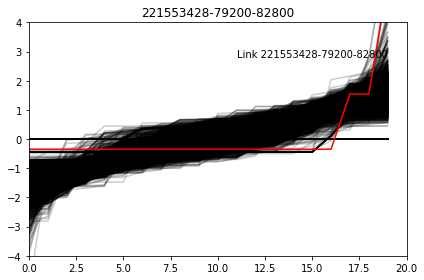

298786469-79200-82800
[152746500, 82800, 86400]: 1.5053141004702115
[547531528, 82800, 86400]: 1.3702660359340237
[547531527, 82800, 86400]: 0.4430905184058344
[420135389, 82800, 86400]: 1.5053141004702115
[8838071, 82800, 86400]: 0.9860913618322165
[301677886, 82800, 86400]: 1.5053141004702115
[152978752, 82800, 86400]: 0.8804544430375166
[547531535, 82800, 86400]: 1.5053141004702115
[547531525, 82800, 86400]: 1.5053141004702115
[159632718, 82800, 86400]: 0.5002948139000927
[547531531, 82800, 86400]: 0.9431743028846546
[547531534, 82800, 86400]: 0.9216855124307035
[547531536, 82800, 86400]: 1.4249501491211944
[47876615, 82800, 86400]: 4.708310889973178
[515675204, 82800, 86400]: 1.0108941961732714
[153947334, 82800, 86400]: 0.957560926042545
[103934334, 82800, 86400]: 1.5053141004702115
[153947335, 82800, 86400]: 1.0257747690751995
[301677885, 82800, 86400]: 1.5053141004702115
[634307497, 82800, 86400]: 1.5053141004702115
[157490277, 82800, 86400]: 1.5053141004702115
[297830232, 82800

[161620465, 0, 3600]: 0.45253126927144405
[153000853, 0, 3600]: 0.4924937992970562
[152980882, 0, 3600]: 0.556199589989347
[228275491, 0, 3600]: 0.7805337088298671
[154150230, 0, 3600]: 2.142977792244109
[152996534, 0, 3600]: 1.5053141004702115
[104082880, 0, 3600]: 1.5053141004702115
[152967646, 0, 3600]: 0.5925901157732797
[423239438, 0, 3600]: 0.539777678511205
[675092020, 0, 3600]: 0.7519602311463425
[697819363, 0, 3600]: 1.5053141004702115
[423724842, 0, 3600]: 1.4856273582388377
[157489834, 0, 3600]: 0.6809399850718763
[152978672, 0, 3600]: 0.7261080081472212
[547531516, 0, 3600]: 0.3869210906105002
[440521424, 0, 3600]: 0.3240465878058548
[297971534, 0, 3600]: 4.708310889973178
[157488722, 0, 3600]: 1.5053141004702115
[152967148, 0, 3600]: 4.708310889973178
[152679218, 0, 3600]: 1.5244070227713022
[780911242, 0, 3600]: 0.602541996402463
[104081781, 0, 3600]: 1.5053141004702115
[153019269, 0, 3600]: 0.4351011717606865
[152679413, 0, 3600]: 0.6741187158886676
[160451376, 0, 3600]:

[688769623, 0, 3600]: 0.33581344529170065
[152679221, 0, 3600]: 1.0406189591319397
[718963662, 0, 3600]: 1.5053141004702115
[681329980, 0, 3600]: 0.35737744962053186
[441497930, 0, 3600]: 1.5053141004702115
[298337589, 0, 3600]: 1.4380298465260948
[420095473, 0, 3600]: 1.3856288098685354
[423239429, 0, 3600]: 0.4060759204262341
[688769627, 0, 3600]: 0.3436448405226381
[675092021, 0, 3600]: 0.7430159608998237
[299893498, 0, 3600]: 0.5370134165926294
[159632858, 0, 3600]: 1.5053141004702115
[299081200, 0, 3600]: 0.35529314638348775
[104081780, 0, 3600]: 1.5053141004702115
[385619164, 0, 3600]: 0.36886196638628016
[299893499, 0, 3600]: 0.6383509959807571
[420095474, 0, 3600]: 1.5053141004702115
[438172985, 0, 3600]: 1.5005732739831035
[153946072, 0, 3600]: 1.5053141004702115
[152679414, 0, 3600]: 1.0523151001411777
[711385801, 0, 3600]: 1.2400299717020427
[152995654, 0, 3600]: 1.5053141004702115
[344851269, 0, 3600]: 0.9727341827753749
[152665029, 0, 3600]: 1.5053141004702115
[153947088, 

[780970456, 3600, 7200]: 2.3272060179588565
[154534953, 3600, 7200]: 1.5053141004702115
[152928147, 3600, 7200]: 1.1556967331996808
[141129800, 3600, 7200]: 1.5053141004702115
[153022809, 3600, 7200]: 1.5053141004702115
[346316337, 3600, 7200]: 1.5053141004702115
[152928148, 3600, 7200]: 1.226442653901004
[462617693, 3600, 7200]: 1.5053141004702115
[126243422, 3600, 7200]: 1.5053141004702115
[298930272, 3600, 7200]: 1.5053141004702115
[346316336, 3600, 7200]: 1.5053141004702115
[153053593, 3600, 7200]: 1.5053141004702115
[688769629, 3600, 7200]: 0.865030614771074
[234332718, 3600, 7200]: 1.5053141004702115
[462617694, 3600, 7200]: 1.5053141004702115
[462617691, 3600, 7200]: 1.5053141004702115
[462617692, 3600, 7200]: 1.5053141004702115
[234332716, 3600, 7200]: 1.5053141004702115
[152928143, 3600, 7200]: 1.5053141004702115
[153035117, 3600, 7200]: 1.5053141004702115
[189465476, 3600, 7200]: 1.5053141004702115
[160444150, 3600, 7200]: 1.5053141004702115
[779578743, 3600, 7200]: 1.5053141

[286685261, 25200, 28800]: 0.3898097213785121
[153050008, 25200, 28800]: 0.623486037482838
[8035434, 25200, 28800]: 1.5053141004702115
[153050006, 25200, 28800]: 0.9819422904824154
[153022759, 25200, 28800]: 1.5053141004702115
[441250601, 25200, 28800]: 0.2817375066465453
[104082909, 25200, 28800]: 0.3694055024191838
[299081198, 25200, 28800]: 1.3131596974142554
[189677020, 25200, 28800]: 1.5053141004702115
[259111293, 25200, 28800]: 0.974909190592365
[8035514, 25200, 28800]: 1.432581481585101
[152895086, 25200, 28800]: 1.366386913331726
[674573656, 25200, 28800]: 0.3206385664660596
[665834892, 25200, 28800]: 1.5053141004702115
[153050009, 25200, 28800]: 0.5703239988385641
[154535040, 25200, 28800]: 0.5455491961123278
[8035447, 25200, 28800]: 0.9941070522289454
[152665033, 25200, 28800]: 1.5053141004702115
[674573659, 25200, 28800]: 0.619596947857783
[779578739, 25200, 28800]: 1.4450954832272604
[152895087, 25200, 28800]: 1.2620342556565607
[152967673, 25200, 28800]: 0.7289327247184829

[221553436, 75600, 79200]: 0.7881878446986953
[589546195, 75600, 79200]: 1.0830970801653226
[189677032, 75600, 79200]: 1.5053141004702115
[319927895, 75600, 79200]: 4.113353493293998
[152978739, 14400, 18000]: 1.5053141004702115
[243630880, 14400, 18000]: 1.5053141004702115
[152978740, 14400, 18000]: 1.5053141004702115
[515863915, 14400, 18000]: 1.5053141004702115
[152978741, 14400, 18000]: 1.5053141004702115
[245336348, 14400, 18000]: 1.5053141004702115
[423729097, 7200, 10800]: 0.502715615579395
[152967216, 7200, 10800]: 0.9100494093557963
[547531554, 7200, 10800]: 1.5053141004702115
[189677018, 7200, 10800]: 1.5053141004702115
[152900440, 7200, 10800]: 1.6914582622999625
[153021408, 7200, 10800]: 0.5442026870941913
[152900414, 7200, 10800]: 0.8773789073447087
[159740405, 7200, 10800]: 4.708310889973178
[533580372, 7200, 10800]: 1.5053141004702115
[152900428, 7200, 10800]: 1.153501527896763
[409870158, 7200, 10800]: 1.1103918128587087
[780487321, 7200, 10800]: 1.5053141004702115
[442

[152665008, 7200, 10800]: 4.708310889973178
[152746487, 7200, 10800]: 4.708310889973178
[221553424, 7200, 10800]: 0.4517936236775011
[221553427, 7200, 10800]: 0.6158437969733649
[153021405, 7200, 10800]: 1.232237045680558
[610577103, 7200, 10800]: 1.506534275965953
[298616189, 7200, 10800]: 0.9281761086410337
[530633120, 7200, 10800]: 2.3272060179588165
[298549750, 7200, 10800]: 1.5053141004702115
[153044291, 7200, 10800]: 2.0211881326312455
[515863911, 7200, 10800]: 1.5053141004702115
[153043514, 7200, 10800]: 0.3288325949897138
[152900425, 7200, 10800]: 4.708310889973178
[104334698, 7200, 10800]: 0.2787755836331016
[152967213, 7200, 10800]: 1.1089517459189293
[441308431, 7200, 10800]: 1.5053141004702115
[104334706, 7200, 10800]: 0.29883594048641526
[245334305, 7200, 10800]: 1.5053141004702115
[189677019, 7200, 10800]: 1.5053141004702115
[420135403, 7200, 10800]: 1.5053141004702115
[152960502, 7200, 10800]: 1.542574234743774
[152995675, 7200, 10800]: 1.3433354553388692
[319899456, 720

[252835207, 79200, 82800]: 0.5745339690843905
[153947386, 79200, 82800]: 0.2724693736299169
[480289621, 79200, 82800]: 0.4886172065223011
[153004061, 79200, 82800]: 0.7314210820783644
[153035191, 79200, 82800]: 0.9648418426307553
[188842330, 79200, 82800]: 1.0699681304176716
[442373710, 79200, 82800]: 0.16909197981057247
[160438442, 79200, 82800]: 1.515531023034595
[152976624, 79200, 82800]: 0.41864789204501346
[440644904, 79200, 82800]: 0.788075145656192
[480289637, 79200, 82800]: 0.7627582373652284
[298930270, 79200, 82800]: 0.15513593188689598
[423653691, 79200, 82800]: 0.8511496849152104
[298822844, 79200, 82800]: 0.5186875999181416
[480282277, 79200, 82800]: 1.1872742368314466
[104081824, 79200, 82800]: 0.7789222937527884
[153022720, 79200, 82800]: 0.1723935890163403
[152679208, 79200, 82800]: 1.2016456113680583
[275345125, 79200, 82800]: 1.3175765310321643
[780483751, 79200, 82800]: 1.389675208117461
[408504582, 79200, 82800]: 0.6407017631784637
[325598326, 79200, 82800]: 1.14977

[189424077, 79200, 82800]: 1.5053141004702115
[463337407, 79200, 82800]: 0.21154663940493135
[152668396, 79200, 82800]: 0.5086330240010051
[480289600, 79200, 82800]: 0.7000080973855975
[153035177, 79200, 82800]: 0.30793576201972905
[160465360, 79200, 82800]: 1.034744828241152
[153004055, 79200, 82800]: 1.3914120164683792
[391669022, 79200, 82800]: 0.6910727171949057
[152966824, 79200, 82800]: 0.20605057635744536
[5069460, 79200, 82800]: 0.32126917196742
[516508095, 79200, 82800]: 1.5561149687586895
[160443454, 79200, 82800]: 0.14885792250219118
[442373727, 79200, 82800]: 0.5647152599761501
[298703043, 79200, 82800]: 1.1752082443652496
[153000938, 79200, 82800]: 0.2845782484195435
[153043600, 79200, 82800]: 0.49464444994276446
[480289608, 79200, 82800]: 0.6050922160849257
[298944626, 79200, 82800]: 0.5322890268885
[344851280, 79200, 82800]: 0.5483106405404612
[160438440, 79200, 82800]: 1.3856737790364428
[153043604, 79200, 82800]: 1.150771778527625
[252392912, 79200, 82800]: 1.688004744

[245337810, 79200, 82800]: 0.6624956463585643
[152967877, 79200, 82800]: 0.3426316783354336
[442373708, 79200, 82800]: 0.15188576102780826
[188842309, 79200, 82800]: 0.952927608442834
[297996749, 79200, 82800]: 1.5053141004702115
[314499046, 79200, 82800]: 0.567000104394484
[385334131, 79200, 82800]: 1.5053141004702115
[8035456, 79200, 82800]: 0.6073095272788069
[153030228, 79200, 82800]: 1.5053141004702115
[8578385, 79200, 82800]: 0.3967182015585891
[412914961, 79200, 82800]: 0.7491561131302683
[152679197, 79200, 82800]: 0.51768423121845
[46429873, 79200, 82800]: 1.8376697315247665
[8578416, 79200, 82800]: 1.5053141004702115
[441265811, 79200, 82800]: 0.8844844740892287
[152656824, 79200, 82800]: 0.4567062291563083
[152679210, 79200, 82800]: 1.3072021113482117
[547531504, 79200, 82800]: 0.5711172503711934
[153000825, 79200, 82800]: 0.4333170227660884
[154534960, 79200, 82800]: 0.663167771654333
[298503411, 79200, 82800]: 0.4761501994644014
[160469976, 79200, 82800]: 0.9104297432054049

[411394829, 79200, 82800]: 0.5267106093489474
[228275480, 79200, 82800]: 0.31418361176651416
[487825353, 79200, 82800]: 0.21361998937930216
[160449035, 79200, 82800]: 1.0888892176772769
[344851286, 79200, 82800]: 0.4065009943569151
[160440240, 79200, 82800]: 0.6744954310438515
[153041118, 79200, 82800]: 0.7294491243615606
[610976572, 79200, 82800]: 0.8835600903952077
[153041106, 79200, 82800]: 1.5053141004702115
[46429884, 79200, 82800]: 1.2141224002281097
[298944620, 79200, 82800]: 0.6027422074144682
[697192596, 79200, 82800]: 1.2422495292132554
[152679203, 79200, 82800]: 0.4534310560324899
[188842234, 79200, 82800]: 0.3551602711202668
[152746384, 79200, 82800]: 0.7622556109201456
[441250599, 79200, 82800]: 0.38853543326295226
[153035178, 79200, 82800]: 0.3573881626811597
[152665059, 79200, 82800]: 0.4671580358018272
[248762959, 79200, 82800]: 0.38522310306499014
[104081822, 79200, 82800]: 1.0572364250797521
[320064978, 79200, 82800]: 1.5053141004702115
[46414960, 79200, 82800]: 1.383

[516508077, 79200, 82800]: 0.3527252045975737
[228275508, 79200, 82800]: 1.706655104483972
[516841609, 79200, 82800]: 0.7535137157991316
[245333283, 79200, 82800]: 1.278304845309669
[459670500, 79200, 82800]: 0.18349836221062166
[259111670, 79200, 82800]: 1.5053141004702115
[298786506, 79200, 82800]: 0.8465436206646594
[153019301, 79200, 82800]: 0.4871278142306094
[8035569, 79200, 82800]: 0.5203980608703885
[418178093, 79200, 82800]: 1.5053141004702115
[441341839, 79200, 82800]: 1.4241066520578105
[153053573, 79200, 82800]: 0.7483591441331837
[161620506, 79200, 82800]: 1.6610231701093092
[443405860, 79200, 82800]: 0.722801608442651
[153022714, 79200, 82800]: 0.16703942156717538
[160469988, 79200, 82800]: 0.7954596544253532
[161620508, 79200, 82800]: 1.3093132090943238
[161620500, 79200, 82800]: 0.307348626987129
[463337401, 79200, 82800]: 0.26510787204139086
[160438436, 79200, 82800]: 2.0928557625930932
[152746371, 79200, 82800]: 0.5137195453045245
[153053622, 79200, 82800]: 0.95319206

[325598325, 79200, 82800]: 2.2601049527602872
[299094972, 79200, 82800]: 0.6652933147953508
[152679276, 79200, 82800]: 1.5053141004702115
[188842230, 79200, 82800]: 0.38554581413652617
[320136001, 79200, 82800]: 0.3087984899416069
[153035259, 79200, 82800]: 0.7796682686519231
[46932862, 79200, 82800]: 1.4670848685776574
[298930268, 79200, 82800]: 0.2676496551776645
[153948621, 79200, 82800]: 0.22752317174496858
[152966823, 79200, 82800]: 0.21212150672514324
[153019303, 79200, 82800]: 1.1686118572649529
[152746412, 79200, 82800]: 0.29874406565245687
[420076107, 79200, 82800]: 0.8409213236684477
[8578436, 79200, 82800]: 1.5155943105053722
[153022728, 79200, 82800]: 0.7764220628597994
[298925965, 79200, 82800]: 1.2032677844807886
[154539330, 79200, 82800]: 1.5053141004702115
[152679202, 79200, 82800]: 0.8260904960963157
[188842249, 79200, 82800]: 0.3751369291943191
[251098641, 79200, 82800]: 0.3608135342151521
[487855856, 79200, 82800]: 0.5504411460667216
[463321552, 79200, 82800]: 0.2814

[320136006, 79200, 82800]: 0.47672729608717535
[325598338, 79200, 82800]: 1.9371410425638842
[344864793, 79200, 82800]: 0.2546998775488248
[195407888, 79200, 82800]: 0.3523943887440149
[153947395, 79200, 82800]: 0.4210503156287992
[589546216, 79200, 82800]: 0.38227422481589224
[160443446, 79200, 82800]: 0.32199575834760374
[161620505, 79200, 82800]: 1.6923418921356523
[8578419, 79200, 82800]: 1.5053141004702115
[152656944, 79200, 82800]: 0.5551772968159138
[299094966, 79200, 82800]: 0.7186786562548517
[245330480, 79200, 82800]: 0.43855744688871484
[154535131, 79200, 82800]: 1.0207551056786015
[152679209, 79200, 82800]: 1.1508958404845437
[157488897, 79200, 82800]: 0.11688875613000269
[104082940, 79200, 82800]: 0.8177833795296555
[297975536, 79200, 82800]: 0.4070867215852722
[153006806, 79200, 82800]: 1.483123765429262
[420135398, 79200, 82800]: 0.9807432817154145
[711385803, 79200, 82800]: 1.0935647645987008
[160449036, 79200, 82800]: 0.8097921539984102
[160440589, 79200, 82800]: 0.855

[153004032, 79200, 82800]: 1.3521447463246525
[153044308, 79200, 82800]: 0.4823035689709096
[34700809, 79200, 82800]: 0.20177554835473865
[8578427, 79200, 82800]: 1.5053141004702115
[153004053, 79200, 82800]: 1.3184335874517086
[152656921, 79200, 82800]: 0.21331415143293717
[160455775, 79200, 82800]: 0.44641779992810915
[298786502, 79200, 82800]: 1.1835678949186292
[259109271, 79200, 82800]: 0.6402008296586202
[152994915, 79200, 82800]: 1.0528536644390936
[22810746, 79200, 82800]: 0.5043120988194637
[152668393, 79200, 82800]: 0.43400196408323005
[153041114, 79200, 82800]: 0.44199586952749903
[480289582, 79200, 82800]: 2.4012746946068897
[505168799, 79200, 82800]: 0.45469514656270277
[298944625, 79200, 82800]: 0.6021671905664062
[153019258, 79200, 82800]: 2.000986008202441
[245336354, 79200, 82800]: 1.637241117886908
[152651298, 79200, 82800]: 0.5600366760736968
[47877710, 79200, 82800]: 1.558777432689926
[153945676, 79200, 82800]: 0.3816025741048031
[234837224, 79200, 82800]: 0.6579327

[441250597, 79200, 82800]: 0.5317910022114396
[152665012, 79200, 82800]: 0.18648889274066166
[234352585, 79200, 82800]: 1.0013587002930984
[373003233, 79200, 82800]: 1.3078615167614585
[195407899, 79200, 82800]: 0.7328239759619085
[697192633, 79200, 82800]: 0.5853405083113286
[286684917, 79200, 82800]: 0.6807211226214656
[152679185, 79200, 82800]: 0.43082077937624563
[299024299, 79200, 82800]: 0.5233677751803324
[516508094, 79200, 82800]: 1.5006168552597892
[463321548, 79200, 82800]: 0.40795532515990374
[228275513, 79200, 82800]: 0.7849242083243183
[298786476, 79200, 82800]: 0.43087647861663664
[385334088, 79200, 82800]: 0.4018504289437862
[678035893, 79200, 82800]: 1.4604109249592863
[188842327, 79200, 82800]: 0.6262753299095326
[252835206, 79200, 82800]: 0.6131448999801561
[152679206, 79200, 82800]: 0.9819643822659481
[217531002, 79200, 82800]: 1.5053141004702115
[297970845, 79200, 82800]: 0.37464118911135286
[441304020, 79200, 82800]: 0.34406557159184453
[152746495, 79200, 82800]: 1

[298786470, 79200, 82800]: 0.047304149137054094
[480289639, 79200, 82800]: 0.5604130224697097
[286684916, 79200, 82800]: 0.7496230201443197
[152967749, 79200, 82800]: 0.9232895800293179
[160455784, 79200, 82800]: 1.060221614967885
[298699132, 79200, 82800]: 0.8625828372876067
[157488900, 79200, 82800]: 0.13954723175655587
[153006802, 79200, 82800]: 1.0469382889432
[298623919, 79200, 82800]: 1.2329773819340768
[385332402, 79200, 82800]: 0.5638517179704164
[153045279, 79200, 82800]: 0.512037254991175
[423729718, 79200, 82800]: 1.5053141004702115
[298616205, 79200, 82800]: 0.13563955475023998
[298822859, 79200, 82800]: 1.1985136203913143
[442373730, 79200, 82800]: 0.3210388526940592
[301677362, 79200, 82800]: 0.20983674619252832
[440644903, 79200, 82800]: 1.3360214117673148
[8035558, 79200, 82800]: 0.7606393082497862
[153004034, 79200, 82800]: 0.6439732948913638
[459670473, 79200, 82800]: 1.051901381922536
[516841611, 79200, 82800]: 0.5669753372959924
[442373721, 79200, 82800]: 1.08004874

[152656865, 79200, 82800]: 0.250442753118649
[152977273, 79200, 82800]: 0.785604537602067
[152995659, 79200, 82800]: 1.5053141004702115
[385334143, 79200, 82800]: 1.4906185076809328
[487825351, 79200, 82800]: 0.3313599926814761
[385334086, 79200, 82800]: 0.9587072129933984
[252392949, 79200, 82800]: 1.1813365202106982
[188842350, 79200, 82800]: 0.8228112736225225
[46429883, 79200, 82800]: 1.4772323796321982
[385332399, 79200, 82800]: 0.7011089856935391
[152994910, 79200, 82800]: 1.3035197588096759
[298926210, 79200, 82800]: 0.3414668411934715
[152895050, 79200, 82800]: 0.6083474313446781
[297975695, 79200, 82800]: 1.4142166138855865
[188842321, 79200, 82800]: 0.7236715075992554
[153021391, 79200, 82800]: 1.5053141004702115
[153021400, 79200, 82800]: 1.5053141004702115
[152668409, 79200, 82800]: 1.0745458026237713
[46429882, 79200, 82800]: 0.9143250698060118
[160438434, 79200, 82800]: 1.0542409272158413
[153041335, 79200, 82800]: 1.5452522459552718
[104081774, 79200, 82800]: 1.505314100

[152978778, 79200, 82800]: 0.6469477902335258
[438172971, 79200, 82800]: 0.23868409066654794
[153043601, 79200, 82800]: 0.5291274978242742
[104082941, 79200, 82800]: 0.6708248491621855
[152679287, 79200, 82800]: 1.4211664036646703
[153035160, 79200, 82800]: 0.5641437389240792
[298925967, 79200, 82800]: 0.8590575218142801
[516841610, 79200, 82800]: 0.6289266854762835
[191003457, 79200, 82800]: 1.0085491420635184
[423724805, 79200, 82800]: 0.25039415594015246
[188842236, 79200, 82800]: 0.36729077988830683
[141129797, 79200, 82800]: 1.2347251652335631
[589546201, 79200, 82800]: 1.7222659805377691
[188842268, 79200, 82800]: 0.5288832738636997
[441465377, 79200, 82800]: 0.8818259960865501
[299032768, 79200, 82800]: 0.34903795128167203
[152656857, 79200, 82800]: 0.2658868034075773
[153004047, 79200, 82800]: 0.9303708673325055
[153035180, 79200, 82800]: 0.3335179906218474
[525675118, 79200, 82800]: 0.8015552143540673
[152924141, 79200, 82800]: 1.5053141004702115
[252392956, 79200, 82800]: 0.3

[487855858, 79200, 82800]: 0.5485197435794761
[424918875, 79200, 82800]: 0.6381545914534169
[423239444, 79200, 82800]: 0.9827443176908055
[76191271, 79200, 82800]: 1.4689611161976388
[152679345, 79200, 82800]: 0.7510456529710765
[153043603, 79200, 82800]: 0.4671759564316068
[325598333, 79200, 82800]: 1.4815337291215545
[154534949, 79200, 82800]: 0.5127862194723315
[161620488, 79200, 82800]: 0.6781151560009249
[46429866, 79200, 82800]: 1.579754502263881
[344851282, 79200, 82800]: 0.5953266844333432
[298930271, 79200, 82800]: 0.10439832684810414
[152668394, 79200, 82800]: 0.7085816297331101
[152656952, 79200, 82800]: 0.28672863591318926
[8035465, 79200, 82800]: 0.4402907631949574
[319927893, 79200, 82800]: 0.5585464701987283
[676152424, 79200, 82800]: 0.9274176503292246
[153022715, 79200, 82800]: 0.17707702372703552
[248762954, 79200, 82800]: 0.3124914787764859
[408268174, 79200, 82800]: 0.4125624948109731
[153035154, 79200, 82800]: 0.5600128713773643
[159740341, 79200, 82800]: 0.8886648

[298237447, 79200, 82800]: 0.7486103595484107
[228275466, 79200, 82800]: 1.7060029015194516
[440644899, 79200, 82800]: 0.5005582565097003
[191003453, 79200, 82800]: 0.4176379905783455
[441462656, 79200, 82800]: 0.8870532887365568
[8578387, 79200, 82800]: 0.39198907145392464
[248762951, 79200, 82800]: 0.31025881754757134
[385334132, 79200, 82800]: 1.5053141004702115
[438172968, 79200, 82800]: 0.2667136287103078
[188842347, 79200, 82800]: 0.5184461076750063
[253717649, 79200, 82800]: 0.7635842476945593
[152679343, 79200, 82800]: 0.4473067201005532
[161620482, 79200, 82800]: 1.345167807049092
[47876605, 79200, 82800]: 1.3845260866172127
[153043584, 79200, 82800]: 0.6246687736921075
[252392948, 79200, 82800]: 1.4350776610897575
[385334124, 79200, 82800]: 1.5053141004702115
[159632881, 79200, 82800]: 1.1759506080519213
[245334392, 79200, 82800]: 0.42482298956048975
[418178085, 79200, 82800]: 1.3016520629971935
[153004038, 79200, 82800]: 1.4614389435417459
[234439482, 79200, 82800]: 0.717567

[234439478, 79200, 82800]: 0.6496642066632449
[610577097, 79200, 82800]: 0.4886422455841679
[60712872, 79200, 82800]: 0.357987080022848
[297883458, 79200, 82800]: 0.6180281461018693
[46414967, 79200, 82800]: 0.8023714136407167
[152746496, 79200, 82800]: 1.5053141004702115
[152966818, 79200, 82800]: 0.22555924196901606
[152746369, 79200, 82800]: 0.5815654254486059
[286685247, 79200, 82800]: 0.4400889263907309
[252835224, 79200, 82800]: 0.2790423399155086
[385334127, 79200, 82800]: 1.5053141004702115
[676436350, 79200, 82800]: 0.6040488448860253
[676950800, 79200, 82800]: 0.4628326098100398
[154539318, 79200, 82800]: 0.9731653029199839
[141130090, 79200, 82800]: 0.7919062740397218
[153004046, 79200, 82800]: 0.8971691216748705
[259109264, 79200, 82800]: 1.2183141089450207
[152900392, 79200, 82800]: 0.70539818917289
[160455782, 79200, 82800]: 0.6812957729247914
[103934327, 79200, 82800]: 0.26637371064934806
[423724802, 79200, 82800]: 0.1547778792022049
[438172972, 79200, 82800]: 0.54893259

[301724744, 79200, 82800]: 0.867018272719779
[480289640, 79200, 82800]: 0.8135945793455481
[46932863, 79200, 82800]: 1.506073559735243
[152976626, 79200, 82800]: 0.41182995391765403
[153044290, 79200, 82800]: 0.2966502281351599
[298699135, 79200, 82800]: 0.4516644936679122
[697192593, 79200, 82800]: 1.769102217859816
[547531551, 79200, 82800]: 0.5562408766157764
[480289593, 79200, 82800]: 0.3218219473193499
[259110129, 79200, 82800]: 1.5053141004702115
[153022657, 79200, 82800]: 0.4660296076758384
[423729708, 79200, 82800]: 1.5053141004702115
[480289611, 79200, 82800]: 0.8079423799915642
[152746411, 79200, 82800]: 0.5781837542193542
[610571179, 79200, 82800]: 0.13134383099422756
[152994907, 79200, 82800]: 0.46046752886096365
[780483748, 79200, 82800]: 1.3845170964179723
[320135995, 79200, 82800]: 1.5053141004702115
[251098644, 79200, 82800]: 0.2894837632211338
[152966817, 79200, 82800]: 0.23591504053877688
[385619278, 79200, 82800]: 0.497889019440756
[252392909, 79200, 82800]: 1.505314

[152978767, 18000, 21600]: 0.448741286971804
[298925953, 18000, 21600]: 0.41290314552129714
[152978768, 18000, 21600]: 1.5053141004702115
[298865291, 18000, 21600]: 1.5053141004702115
[676940734, 18000, 21600]: 1.5053141004702115
[298865292, 18000, 21600]: 1.5053141004702115
[298843840, 18000, 21600]: 1.5053141004702115
[491822828, 18000, 21600]: 0.36082989195224485
[437982139, 18000, 21600]: 0.48670680560257545
[152895105, 18000, 21600]: 1.5053141004702115
[159740349, 18000, 21600]: 1.5053141004702115
[152895104, 18000, 21600]: 1.0221152711319894
[159740347, 18000, 21600]: 1.4516051797778662
[251098655, 18000, 21600]: 1.5053141004702115
[676950795, 46800, 50400]: 1.3670788428906873
[299081216, 46800, 50400]: 1.5053141004702115
[152960504, 46800, 50400]: 1.5053141004702115
[385334110, 46800, 50400]: 1.5053141004702115
[440530027, 46800, 50400]: 0.7496906671756036
[299081206, 46800, 50400]: 0.9545979374318027
[153035262, 46800, 50400]: 0.9163528678373783
[160458425, 46800, 50400]: 1.505

[159632884, 46800, 50400]: 1.4814042754803747
[516841624, 46800, 50400]: 1.5053141004702115
[153035261, 46800, 50400]: 0.489052030776649
[160451464, 46800, 50400]: 0.552862154766226
[443397608, 46800, 50400]: 1.1174035310017727
[385334097, 46800, 50400]: 1.1471930336741334
[298825161, 46800, 50400]: 0.264844610399512
[385334099, 46800, 50400]: 1.4166156021004612
[152967814, 46800, 50400]: 0.6799687006779922
[152977280, 46800, 50400]: 0.9836038069486305
[46594680, 46800, 50400]: 1.5053141004702115
[515675212, 46800, 50400]: 0.4986961677706142
[299081218, 46800, 50400]: 1.5053141004702115
[244021209, 46800, 50400]: 1.3475967067577603
[299081219, 46800, 50400]: 1.5053141004702115
[493523044, 46800, 50400]: 1.0809134047963604
[468702769, 46800, 50400]: 0.354468069815981
[153022672, 46800, 50400]: 1.5053141004702115
[299018411, 46800, 50400]: 0.9241498408200877
[152977278, 46800, 50400]: 1.5053141004702115
[153947325, 46800, 50400]: 1.3444548236360205
[443414626, 46800, 50400]: 1.1739227108

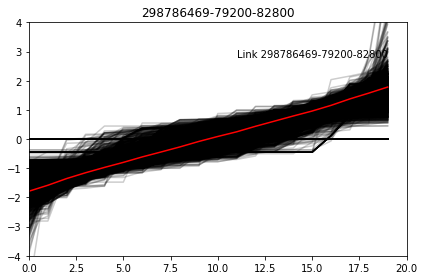

298786468-79200-82800
[152746500, 82800, 86400]: 1.501178214722633
[547531528, 82800, 86400]: 1.3642124131711055
[547531527, 82800, 86400]: 0.4457261089378319
[420135389, 82800, 86400]: 1.501178214722633
[8838071, 82800, 86400]: 0.9810980766614187
[301677886, 82800, 86400]: 1.501178214722633
[152978752, 82800, 86400]: 0.8758295456883606
[547531535, 82800, 86400]: 1.501178214722633
[547531525, 82800, 86400]: 1.501178214722633
[159632718, 82800, 86400]: 0.5092358623232544
[547531531, 82800, 86400]: 0.9410363871444619
[547531534, 82800, 86400]: 0.9194957187016171
[547531536, 82800, 86400]: 1.41840214363529
[47876615, 82800, 86400]: 4.709497098801752
[515675204, 82800, 86400]: 1.0063851147354173
[153947334, 82800, 86400]: 0.9501087689172717
[103934334, 82800, 86400]: 1.501178214722633
[153947335, 82800, 86400]: 1.01789237963196
[301677885, 82800, 86400]: 1.501178214722633
[634307497, 82800, 86400]: 1.501178214722633
[157490277, 82800, 86400]: 1.501178214722633
[297830232, 82800, 86400]: 1.

[423239438, 0, 3600]: 0.5401386106243966
[675092020, 0, 3600]: 0.7481661460991498
[697819363, 0, 3600]: 1.501178214722633
[423724842, 0, 3600]: 1.4862719864038108
[157489834, 0, 3600]: 0.6782207326517913
[152978672, 0, 3600]: 0.7232177513480585
[547531516, 0, 3600]: 0.39107919564769406
[440521424, 0, 3600]: 0.3303533903349059
[297971534, 0, 3600]: 4.709497098801752
[157488722, 0, 3600]: 1.501178214722633
[152967148, 0, 3600]: 4.709497098801752
[152679218, 0, 3600]: 1.5193035942045476
[780911242, 0, 3600]: 0.595120128132362
[104081781, 0, 3600]: 1.501178214722633
[153019269, 0, 3600]: 0.4323066885165201
[152679413, 0, 3600]: 0.6709244762950298
[160451376, 0, 3600]: 1.501178214722633
[299893502, 0, 3600]: 0.9841781794336226
[174924979, 0, 3600]: 0.5267236487205825
[718963842, 0, 3600]: 1.501178214722633
[104082865, 0, 3600]: 1.501178214722633
[718963897, 0, 3600]: 2.3241706804454636
[159632877, 0, 3600]: 1.1436832084508202
[547531510, 0, 3600]: 0.41836015667893256
[152978671, 0, 3600]: 0

[420095473, 0, 3600]: 1.3830352459130721
[423239429, 0, 3600]: 0.40671465876489016
[688769627, 0, 3600]: 0.34401687665410097
[675092021, 0, 3600]: 0.7383242121728475
[299893498, 0, 3600]: 0.5215541968719922
[159632858, 0, 3600]: 1.501178214722633
[299081200, 0, 3600]: 0.33900582221772824
[104081780, 0, 3600]: 1.501178214722633
[385619164, 0, 3600]: 0.37826075990297053
[299893499, 0, 3600]: 0.6303897020876184
[420095474, 0, 3600]: 1.501178214722633
[438172985, 0, 3600]: 1.4952177902315946
[153946072, 0, 3600]: 1.501178214722633
[152679414, 0, 3600]: 1.045277312916176
[711385801, 0, 3600]: 1.2424622384702515
[152995654, 0, 3600]: 1.501178214722633
[344851269, 0, 3600]: 0.9634591618322682
[152665029, 0, 3600]: 1.501178214722633
[153947088, 0, 3600]: 0.6687392322503627
[423239431, 0, 3600]: 0.4527725466817224
[152679219, 0, 3600]: 1.095329171244182
[160451374, 0, 3600]: 2.1693555031845007
[320136003, 0, 3600]: 1.501178214722633
[153019266, 0, 3600]: 0.5300980066238209
[299893501, 0, 3600]:

[152928147, 3600, 7200]: 1.1479369349155863
[141129800, 3600, 7200]: 1.501178214722633
[153022809, 3600, 7200]: 1.501178214722633
[346316337, 3600, 7200]: 1.501178214722633
[152928148, 3600, 7200]: 1.2172834401654593
[462617693, 3600, 7200]: 1.501178214722633
[126243422, 3600, 7200]: 1.501178214722633
[298930272, 3600, 7200]: 1.501178214722633
[346316336, 3600, 7200]: 1.501178214722633
[153053593, 3600, 7200]: 1.501178214722633
[688769629, 3600, 7200]: 0.8520982376531817
[234332718, 3600, 7200]: 1.501178214722633
[462617694, 3600, 7200]: 1.501178214722633
[462617691, 3600, 7200]: 1.501178214722633
[462617692, 3600, 7200]: 1.501178214722633
[234332716, 3600, 7200]: 1.501178214722633
[152928143, 3600, 7200]: 1.501178214722633
[153035117, 3600, 7200]: 1.501178214722633
[189465476, 3600, 7200]: 1.501178214722633
[160444150, 3600, 7200]: 1.501178214722633
[779578743, 3600, 7200]: 1.501178214722633
[134801096, 3600, 7200]: 1.501178214722633
[152925433, 3600, 7200]: 1.501178214722633
[1530352

[152924174, 61200, 64800]: 1.501178214722633
[152924170, 61200, 64800]: 1.097554532917116
[152679242, 61200, 64800]: 1.422212953471857
[60712852, 61200, 64800]: 2.0542628336579867
[152924168, 61200, 64800]: 1.3352946287487948
[298703035, 61200, 64800]: 1.545419878094257
[298703036, 61200, 64800]: 1.2519889849572838
[253717640, 61200, 64800]: 0.6564112926365613
[385619159, 61200, 64800]: 0.9185872334804527
[519178542, 61200, 64800]: 0.6256263673181833
[152679386, 61200, 64800]: 1.2964818102500428
[298847948, 61200, 64800]: 1.501178214722633
[46262610, 61200, 64800]: 1.1122449298064618
[218911655, 61200, 64800]: 0.9879239195047332
[47876618, 61200, 64800]: 0.7025648863796764
[373003261, 61200, 64800]: 1.501178214722633
[152924175, 61200, 64800]: 1.4037749518932823
[298930276, 61200, 64800]: 1.501178214722633
[298865281, 61200, 64800]: 0.27213224570922856
[228275501, 61200, 64800]: 1.501178214722633
[152924166, 61200, 64800]: 1.0552835034058172
[152679383, 61200, 64800]: 0.807206324609027

[189452929, 7200, 10800]: 1.501178214722633
[234352578, 7200, 10800]: 0.4115758269737338
[771192182, 7200, 10800]: 1.00802185847466
[547531508, 7200, 10800]: 1.501178214722633
[417068019, 7200, 10800]: 1.501178214722633
[159740421, 7200, 10800]: 1.501178214722633
[152900380, 7200, 10800]: 1.6971387527011155
[153043579, 7200, 10800]: 0.7469993723102201
[159740418, 7200, 10800]: 1.501178214722633
[159740420, 7200, 10800]: 1.501178214722633
[152665023, 7200, 10800]: 1.501178214722633
[711142886, 7200, 10800]: 0.5646191577635981
[152980842, 7200, 10800]: 0.3266420113473074
[238618779, 7200, 10800]: 1.501178214722633
[152967199, 7200, 10800]: 1.501178214722633
[697819358, 7200, 10800]: 1.501178214722633
[152967206, 7200, 10800]: 1.501178214722633
[297829487, 7200, 10800]: 1.501178214722633
[152900426, 7200, 10800]: 1.172138177386446
[152980840, 7200, 10800]: 0.2793004278371476
[104081804, 7200, 10800]: 0.9674448283324504
[530633121, 7200, 10800]: 0.8499442262018182
[189663746, 7200, 10800]:

[253717647, 79200, 82800]: 0.7483969005219034
[325598328, 79200, 82800]: 0.6999734553441637
[697192628, 79200, 82800]: 1.6941522198545376
[8035560, 79200, 82800]: 0.9021679320919543
[152665064, 79200, 82800]: 0.8402264733205852
[443405859, 79200, 82800]: 0.33351070970801067
[160458423, 79200, 82800]: 1.2755010077160154
[153004045, 79200, 82800]: 1.2561987435915047
[438172975, 79200, 82800]: 1.9511255112585668
[188842287, 79200, 82800]: 1.1741369524025076
[161620493, 79200, 82800]: 0.14284208097095083
[298877854, 79200, 82800]: 0.2720667259571382
[502511312, 79200, 82800]: 0.6568134151047879
[152900393, 79200, 82800]: 0.7356924002243698
[385334089, 79200, 82800]: 0.4684438634223968
[8035466, 79200, 82800]: 0.4023176968163851
[153049908, 79200, 82800]: 0.593507987721834
[418178080, 79200, 82800]: 0.6651673589938003
[153019287, 79200, 82800]: 0.9907078945310783
[298822842, 79200, 82800]: 0.4731208360976954
[298217939, 79200, 82800]: 0.2923515013159611
[286684919, 79200, 82800]: 1.22186118

[298822858, 79200, 82800]: 1.3731672548778993
[153019292, 79200, 82800]: 0.5582530028974131
[463524793, 79200, 82800]: 0.7302567672856493
[160458424, 79200, 82800]: 0.7022464686618971
[153798137, 79200, 82800]: 0.3538640148276556
[418178094, 79200, 82800]: 1.501178214722633
[373003234, 79200, 82800]: 1.0849724823603322
[438172970, 79200, 82800]: 0.2275935506591644
[423724814, 79200, 82800]: 0.3503145154735069
[423724836, 79200, 82800]: 0.5631797114034488
[298237461, 79200, 82800]: 1.3693192287939076
[297998491, 79200, 82800]: 0.9123579831741107
[188842265, 79200, 82800]: 0.4847938226951993
[152652992, 79200, 82800]: 1.3664344899834482
[152668416, 79200, 82800]: 1.3761031331120088
[153019273, 79200, 82800]: 0.8280058454638571
[158618961, 79200, 82800]: 0.36761419241993826
[22810747, 79200, 82800]: 0.5557980507330528
[34700807, 79200, 82800]: 0.40037002096772134
[298786481, 79200, 82800]: 0.38648105154907986
[34700783, 79200, 82800]: 0.8919499914460601
[188842273, 79200, 82800]: 1.329584

[547531504, 79200, 82800]: 0.5676271847830363
[153000825, 79200, 82800]: 0.4439299208925601
[154534960, 79200, 82800]: 0.6654415666823043
[298503411, 79200, 82800]: 0.49052825365281794
[160469976, 79200, 82800]: 0.904752751342087
[420076110, 79200, 82800]: 1.3160820529002422
[286685266, 79200, 82800]: 0.38889879059026033
[674556446, 79200, 82800]: 0.9075754635666303
[8578353, 79200, 82800]: 1.4085963833836088
[153004058, 79200, 82800]: 0.7800068014014766
[160440590, 79200, 82800]: 0.8620897711590477
[8578345, 79200, 82800]: 0.8573889071702235
[188842306, 79200, 82800]: 0.5733530020407327
[439048431, 79200, 82800]: 0.9460640570109431
[153021399, 79200, 82800]: 1.501178214722633
[152668398, 79200, 82800]: 0.5307672042563286
[152967750, 79200, 82800]: 1.3906962251526114
[161620517, 79200, 82800]: 1.2523885622458728
[441250600, 79200, 82800]: 0.4563689639747981
[152654143, 79200, 82800]: 0.17396595233754011
[8035575, 79200, 82800]: 0.23307290536145603
[665834900, 79200, 82800]: 0.632333910

[320064980, 79200, 82800]: 1.2732171366917056
[301724747, 79200, 82800]: 0.4836334023800378
[188842302, 79200, 82800]: 0.19330480004416783
[297993204, 79200, 82800]: 0.3971584888920543
[46932869, 79200, 82800]: 1.5401262053677145
[459670499, 79200, 82800]: 0.154671235678583
[420076108, 79200, 82800]: 1.0716997904293848
[589546208, 79200, 82800]: 0.6584403691830514
[22810765, 79200, 82800]: 0.4386731287090036
[8035561, 79200, 82800]: 0.5599889013582808
[245330478, 79200, 82800]: 0.5131448777207492
[153035155, 79200, 82800]: 0.49010065284360693
[251098643, 79200, 82800]: 0.3491831964627015
[127127908, 79200, 82800]: 1.501178214722633
[153019244, 79200, 82800]: 1.0173368949890773
[248762945, 79200, 82800]: 0.392955497435084
[189677001, 79200, 82800]: 0.4860638551767521
[234352599, 79200, 82800]: 1.501178214722633
[298703049, 79200, 82800]: 0.24559485471132622
[298786498, 79200, 82800]: 1.321386237476183
[152665013, 79200, 82800]: 0.43357675410300706
[234352600, 79200, 82800]: 1.5011782147

[152994913, 79200, 82800]: 1.3329214742744668
[159740335, 79200, 82800]: 1.1910848679613601
[159632882, 79200, 82800]: 1.1280861990302335
[152654159, 79200, 82800]: 0.5973160203575014
[440521428, 79200, 82800]: 0.9518704490312202
[153035198, 79200, 82800]: 1.501178214722633
[385619277, 79200, 82800]: 2.4803910786193586
[298029511, 79200, 82800]: 0.359012343413049
[697192601, 79200, 82800]: 1.0920613035527742
[152746492, 79200, 82800]: 0.4838020781483959
[160443452, 79200, 82800]: 0.16332335714666296
[346316354, 79200, 82800]: 0.4911893745797059
[418178089, 79200, 82800]: 0.4144725899068269
[152980836, 79200, 82800]: 0.7305897725395718
[8578429, 79200, 82800]: 1.3912622920172508
[135719160, 79200, 82800]: 0.33890865355832
[441455564, 79200, 82800]: 0.6667880634109077
[228275511, 79200, 82800]: 1.7765417700219712
[253717648, 79200, 82800]: 0.872481326486606
[297826866, 79200, 82800]: 0.6042216180892475
[160438444, 79200, 82800]: 0.932071082092325
[589546221, 79200, 82800]: 0.317337446041

[301724753, 79200, 82800]: 0.6075181981033883
[153945677, 79200, 82800]: 0.3839684474877396
[572708713, 79200, 82800]: 1.3185699127591783
[46429871, 79200, 82800]: 1.6223960018037207
[298926209, 79200, 82800]: 0.4296078829074861
[298834960, 79200, 82800]: 0.886868414515803
[188842285, 79200, 82800]: 1.3300507755589441
[234439483, 79200, 82800]: 0.6744602787325487
[299094981, 79200, 82800]: 0.8466487442639664
[298822854, 79200, 82800]: 1.3630616226749603
[408924183, 79200, 82800]: 0.639525489584608
[780483744, 79200, 82800]: 1.4040512513038976
[153044321, 79200, 82800]: 1.1358631926886071
[439048434, 79200, 82800]: 0.3523486484183828
[46429877, 79200, 82800]: 1.2231395339416287
[299024301, 79200, 82800]: 0.5186185814272074
[157488905, 79200, 82800]: 0.32026147843937514
[423724808, 79200, 82800]: 0.28529031068030525
[245337807, 79200, 82800]: 0.6774153529486527
[160469975, 79200, 82800]: 0.8863226678626279
[22810751, 79200, 82800]: 0.4610967731657412
[441265805, 79200, 82800]: 0.33973420

[153044331, 79200, 82800]: 0.7582624957063969
[160449029, 79200, 82800]: 1.20912003187103
[154534956, 79200, 82800]: 0.43600307738943295
[157489535, 79200, 82800]: 1.273753511888622
[247141039, 79200, 82800]: 0.3767644023651941
[298623911, 79200, 82800]: 0.2477549081417246
[230916288, 79200, 82800]: 0.8945537018913629
[153001158, 79200, 82800]: 0.8718050099499799
[5135003, 79200, 82800]: 0.14425543765109142
[103934326, 79200, 82800]: 0.3082557312574361
[572708717, 79200, 82800]: 0.3120182113621748
[531278237, 79200, 82800]: 0.34541061419451596
[160466236, 79200, 82800]: 1.2841461410928976
[299094985, 79200, 82800]: 0.9164806701894892
[153044300, 79200, 82800]: 0.6535215677748295
[420076112, 79200, 82800]: 2.356623529954211
[152679192, 79200, 82800]: 1.1431964007758764
[502511311, 79200, 82800]: 0.5629599229148419
[228275464, 79200, 82800]: 1.516015811803474
[153945667, 79200, 82800]: 0.1789292637353955
[298926206, 79200, 82800]: 0.6412212959450847
[103933159, 79200, 82800]: 0.642212949

[160469978, 79200, 82800]: 0.8862838667415576
[424918869, 79200, 82800]: 0.6264192852722712
[153035159, 79200, 82800]: 0.4470098425345918
[153053560, 79200, 82800]: 0.3793294690758486
[238610488, 79200, 82800]: 2.1925476223018174
[104082894, 79200, 82800]: 0.8427164540537667
[301724743, 79200, 82800]: 0.8704990429833811
[160458421, 79200, 82800]: 0.63214226455787
[327005891, 79200, 82800]: 0.06589498827707509
[153045277, 79200, 82800]: 0.6651063946266027
[91978059, 79200, 82800]: 0.37533107818034706
[22810772, 79200, 82800]: 0.6010156607197488
[153945669, 79200, 82800]: 0.26848527080707846
[641396455, 79200, 82800]: 1.501178214722633
[152900433, 79200, 82800]: 1.0089736261915687
[152665011, 79200, 82800]: 0.19709780630565119
[259109263, 79200, 82800]: 0.4185734813470456
[423724832, 79200, 82800]: 0.4899475119163209
[103934329, 79200, 82800]: 0.6515769988193794
[301677357, 79200, 82800]: 0.2882069123038679
[245334399, 79200, 82800]: 1.501178214722633
[152746489, 79200, 82800]: 0.4745443

[158618962, 79200, 82800]: 0.6146602442461637
[188842318, 79200, 82800]: 0.7183228694099042
[344864787, 79200, 82800]: 0.2901670390188191
[441304018, 79200, 82800]: 0.37431528346238885
[217603104, 79200, 82800]: 0.4590143328481776
[252835216, 79200, 82800]: 0.3559247967226758
[781786566, 79200, 82800]: 1.0542866722769086
[153798134, 79200, 82800]: 0.30629853701017784
[779578745, 79200, 82800]: 1.1073136740344285
[298237452, 79200, 82800]: 0.9339570268019496
[589546203, 79200, 82800]: 1.693282947445024
[412018368, 79200, 82800]: 1.501178214722633
[153019290, 79200, 82800]: 1.0465333320775936
[195407913, 79200, 82800]: 0.3131248733647728
[152978745, 79200, 82800]: 0.8984908217895894
[298932010, 79200, 82800]: 0.17708038846516092
[424918858, 79200, 82800]: 0.6206132841195708
[442372757, 79200, 82800]: 0.13609901886266892
[572708718, 79200, 82800]: 0.4578409520148103
[152679375, 79200, 82800]: 0.43054377884036743
[437773554, 79200, 82800]: 1.501178214722633
[228275465, 79200, 82800]: 0.298

[153798135, 79200, 82800]: 0.33559371989617975
[46932873, 79200, 82800]: 1.4992280239133844
[152679404, 79200, 82800]: 1.39805999649787
[697192637, 79200, 82800]: 1.5938162059637844
[442373719, 79200, 82800]: 0.9521581908486039
[259109266, 79200, 82800]: 0.7776352642867289
[301677375, 79200, 82800]: 0.2813415444536374
[502511302, 79200, 82800]: 0.6032013531572064
[320064976, 79200, 82800]: 1.501178214722633
[153053639, 79200, 82800]: 0.6024143119695751
[298703051, 79200, 82800]: 0.8091513672116737
[410013916, 79200, 82800]: 0.543008673859916
[152651323, 79200, 82800]: 1.4546361212928514
[46262606, 79200, 82800]: 0.7547783503119855
[188842343, 79200, 82800]: 0.45953735622724395
[152746365, 79200, 82800]: 0.5752398358811863
[275345120, 79200, 82800]: 1.0325593442269616
[158618966, 79200, 82800]: 0.3560061780461277
[159740412, 79200, 82800]: 0.5911388405643471
[423239447, 79200, 82800]: 0.9687680569828134
[228275485, 79200, 82800]: 1.3920685792145207
[299081223, 79200, 82800]: 1.501178214

[775436079, 79200, 82800]: 1.5498747283916057
[127127912, 79200, 82800]: 0.3551741692464277
[8035437, 79200, 82800]: 0.38369721130071166
[480289570, 79200, 82800]: 1.8473331038742344
[153004040, 79200, 82800]: 1.29653381287786
[153041119, 79200, 82800]: 0.7618464196603069
[373003236, 79200, 82800]: 1.5222709707607245
[152679314, 79200, 82800]: 0.449194711244023
[159632880, 79200, 82800]: 1.0009902908040829
[487855860, 79200, 82800]: 0.49782544484240365
[298237448, 79200, 82800]: 0.9557663203399205
[189424089, 79200, 82800]: 1.501178214722633
[153022666, 79200, 82800]: 0.5161386916115702
[298925980, 79200, 82800]: 0.8254411874002522
[154149748, 79200, 82800]: 1.0118176798046232
[297975694, 79200, 82800]: 0.47655974224380704
[516841612, 79200, 82800]: 0.31676224306782136
[298786474, 79200, 82800]: 0.3598906197408899
[297883449, 79200, 82800]: 0.38427952500264384
[420076105, 79200, 82800]: 1.501178214722633
[152996541, 79200, 82800]: 0.3518934186126728
[420135393, 79200, 82800]: 1.0864599

[195407915, 79200, 82800]: 0.14840294918311278
[301677361, 79200, 82800]: 0.21338688519731014
[8035556, 79200, 82800]: 0.7942469920468849
[320135996, 79200, 82800]: 1.501178214722633
[385334146, 79200, 82800]: 1.2826814089941334
[228275469, 79200, 82800]: 0.41496088396646436
[385619276, 79200, 82800]: 1.535345998093487
[152652991, 79200, 82800]: 1.0462955036353632
[676950777, 79200, 82800]: 0.8935456624146549
[245337808, 79200, 82800]: 0.6856560438283786
[245336355, 79200, 82800]: 1.0401104313138643
[297826870, 79200, 82800]: 0.537733580040005
[152924210, 79200, 82800]: 0.35110918133803276
[441265804, 79200, 82800]: 0.32588179747385704
[298699136, 79200, 82800]: 0.5495496606817972
[463337398, 79200, 82800]: 0.23690468491003042
[152995662, 79200, 82800]: 1.501178214722633
[188842305, 79200, 82800]: 0.6482296008161027
[423724810, 79200, 82800]: 0.3040890794333496
[779578751, 79200, 82800]: 0.6671705623002925
[160440591, 79200, 82800]: 1.2425710178306957
[697192630, 79200, 82800]: 0.73449

[188842333, 79200, 82800]: 1.501178214722633
[104082913, 79200, 82800]: 0.6913989076641165
[275345121, 79200, 82800]: 0.933998057819334
[298559014, 79200, 82800]: 0.7425559472211772
[459684534, 79200, 82800]: 1.2838102418044397
[665834897, 79200, 82800]: 0.8415380493494856
[152746367, 79200, 82800]: 0.3784444282929148
[152746366, 79200, 82800]: 0.3060653467708445
[195407894, 79200, 82800]: 0.5258248002069791
[420135392, 79200, 82800]: 0.8919102901167897
[153035165, 79200, 82800]: 0.924350370110056
[152654157, 79200, 82800]: 0.5040629293241905
[152746485, 79200, 82800]: 0.2680256079470373
[487855858, 79200, 82800]: 0.5415969806113519
[424918875, 79200, 82800]: 0.6253199513193857
[423239444, 79200, 82800]: 0.9768552096492024
[76191271, 79200, 82800]: 1.46502023020114
[152679345, 79200, 82800]: 0.7480803826124739
[153043603, 79200, 82800]: 0.46386409326911565
[325598333, 79200, 82800]: 1.4722374863432532
[154534949, 79200, 82800]: 0.5094904208468332
[161620488, 79200, 82800]: 0.6700923794

[245336353, 79200, 82800]: 1.6495064669937842
[298932005, 79200, 82800]: 0.12585448923930787
[491822824, 79200, 82800]: 0.6375568413097396
[152977264, 79200, 82800]: 0.8179844574616981
[649730255, 79200, 82800]: 0.33354191871044975
[297971530, 79200, 82800]: 2.0281400906030984
[195407908, 79200, 82800]: 0.7420313215920082
[159740897, 79200, 82800]: 0.9062024855100194
[154535121, 79200, 82800]: 0.3401420939044931
[152978734, 79200, 82800]: 1.3302417013316017
[152665065, 79200, 82800]: 0.9940549287769652
[153019274, 79200, 82800]: 0.8275520308592544
[152746362, 79200, 82800]: 0.5321063358875969
[301677368, 79200, 82800]: 0.3109197246762166
[298237447, 79200, 82800]: 0.7334521526463315
[228275466, 79200, 82800]: 1.6971513592799183
[440644899, 79200, 82800]: 0.5041567004325697
[191003453, 79200, 82800]: 0.410643420534164
[441462656, 79200, 82800]: 0.880309641268774
[8578387, 79200, 82800]: 0.38701032024753107
[248762951, 79200, 82800]: 0.3012622142151408
[385334132, 79200, 82800]: 1.501178

[418178087, 79200, 82800]: 0.9185582053997536
[443405855, 79200, 82800]: 0.32568565366201613
[153043547, 79200, 82800]: 0.7636552757756117
[437986293, 79200, 82800]: 0.6145961947390731
[298822857, 79200, 82800]: 1.2351039661258623
[245330479, 79200, 82800]: 0.44124245043275834
[502511300, 79200, 82800]: 0.5284794715541301
[152924131, 79200, 82800]: 0.672130342049381
[188842298, 79200, 82800]: 0.36067090941260244
[154535118, 79200, 82800]: 0.2730746320725094
[188842264, 79200, 82800]: 0.4974438329617968
[188842314, 79200, 82800]: 0.6987384626736814
[153019293, 79200, 82800]: 0.5093401595680876
[152665035, 79200, 82800]: 0.7476380719024975
[299045407, 79200, 82800]: 1.4955634042783528
[459670477, 79200, 82800]: 1.2261468147582801
[408268181, 79200, 82800]: 0.354010631223691
[459670502, 79200, 82800]: 0.20272888688152063
[327005893, 79200, 82800]: 0.2376986965541441
[301724742, 79200, 82800]: 0.9004320622630985
[161620495, 79200, 82800]: 0.42293027089312957
[275345098, 79200, 82800]: 1.05

[160455777, 79200, 82800]: 0.30795853850902344
[5069457, 79200, 82800]: 0.3205125598034214
[153045280, 79200, 82800]: 0.6360383834863144
[154534959, 79200, 82800]: 0.5027470427779333
[297826865, 79200, 82800]: 0.5248098049079869
[153001157, 79200, 82800]: 1.0432854366816078
[297996752, 79200, 82800]: 1.501178214722633
[152668386, 79200, 82800]: 0.43043392782518575
[412914963, 79200, 82800]: 1.501178214722633
[487855863, 79200, 82800]: 0.7562944433311662
[152746449, 79200, 82800]: 0.5662031739233118
[153019238, 79200, 82800]: 0.9591926581885033
[301724754, 79200, 82800]: 0.39743706301757686
[297975530, 79200, 82800]: 1.1075139878493772
[153035157, 79200, 82800]: 0.4369388729646022
[157489527, 79200, 82800]: 0.38019434271681835
[275539105, 79200, 82800]: 0.6677986336978996
[385334119, 79200, 82800]: 1.501178214722633
[487855854, 79200, 82800]: 1.2980699264985076
[153045278, 79200, 82800]: 0.8815226992477145
[152966819, 79200, 82800]: 0.23973978304552715
[153798138, 79200, 82800]: 0.36427

[443405852, 79200, 82800]: 0.2045783831992338
[159740348, 18000, 21600]: 0.9812263230506743
[298843839, 18000, 21600]: 1.501178214722633
[437982140, 18000, 21600]: 0.4279997713094636
[491822827, 18000, 21600]: 0.3382156345470141
[152978767, 18000, 21600]: 0.4488700919418652
[298925953, 18000, 21600]: 0.418958357317194
[152978768, 18000, 21600]: 1.501178214722633
[298865291, 18000, 21600]: 1.501178214722633
[676940734, 18000, 21600]: 1.501178214722633
[298865292, 18000, 21600]: 1.501178214722633
[298843840, 18000, 21600]: 1.501178214722633
[491822828, 18000, 21600]: 0.36511622012609485
[437982139, 18000, 21600]: 0.48096827904895256
[152895105, 18000, 21600]: 1.501178214722633
[159740349, 18000, 21600]: 1.501178214722633
[152895104, 18000, 21600]: 1.0141774333056368
[159740347, 18000, 21600]: 1.4427065026355652
[251098655, 18000, 21600]: 1.501178214722633
[676950795, 46800, 50400]: 1.3610452348227369
[299081216, 46800, 50400]: 1.501178214722633
[152960504, 46800, 50400]: 1.50117821472263

[385334094, 46800, 50400]: 1.4439891182750666
[443397607, 46800, 50400]: 0.606185460643003
[60712858, 46800, 50400]: 0.46097609976144854
[244021203, 46800, 50400]: 0.880601182684221
[502502575, 46800, 50400]: 0.22778342726826217
[160444159, 46800, 50400]: 0.4898388476856238
[441304013, 46800, 50400]: 0.9807199401237063
[385334104, 46800, 50400]: 1.323578254264385
[152967818, 46800, 50400]: 0.6002590481544376
[676950786, 46800, 50400]: 1.501178214722633
[153022674, 46800, 50400]: 1.2313167853105869
[780970466, 46800, 50400]: 0.41528152904373444
[153022673, 46800, 50400]: 1.4919557494047753
[515675209, 46800, 50400]: 0.6127103791399829
[152746397, 46800, 50400]: 1.501178214722633
[385334106, 46800, 50400]: 0.9985546002074488
[153019304, 46800, 50400]: 0.5294928097406716
[60712861, 46800, 50400]: 1.501178214722633
[153035263, 46800, 50400]: 0.43419445079383856
[46594681, 46800, 50400]: 1.3392328593699399
[104081773, 46800, 50400]: 0.6720656078110582
[154150700, 46800, 50400]: 1.4268190646

[397153551, 21600, 25200]: 0.4107543478522851
[46594678, 21600, 25200]: 1.0892019599108265
[152668378, 21600, 25200]: 1.501178214722633
[154537320, 72000, 75600]: 1.501178214722633
[152900421, 72000, 75600]: 4.709497098801752
[154537318, 72000, 75600]: 1.501178214722633
[154537297, 72000, 75600]: 1.501178214722633
[154537319, 72000, 75600]: 1.501178214722633
[154537321, 72000, 75600]: 1.501178214722633
[154537296, 72000, 75600]: 1.501178214722633
[152900422, 72000, 75600]: 1.501178214722633


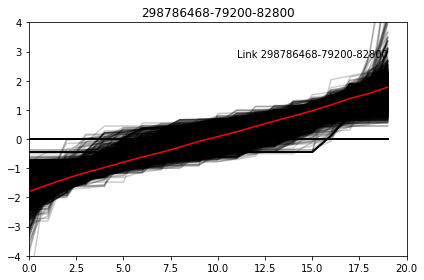

298822843-79200-82800
[152746500, 82800, 86400]: 1.2425944190019063
[547531528, 82800, 86400]: 1.0959852044973537
[547531527, 82800, 86400]: 0.3721091287959076
[420135389, 82800, 86400]: 1.2425944190019063
[8838071, 82800, 86400]: 0.7570087225840373
[301677886, 82800, 86400]: 1.2425944190019063
[152978752, 82800, 86400]: 0.8436644267209061
[547531535, 82800, 86400]: 1.2425944190019063
[547531525, 82800, 86400]: 1.2425944190019063
[159632718, 82800, 86400]: 0.36470889008326557
[547531531, 82800, 86400]: 0.5618192127871391
[547531534, 82800, 86400]: 0.538611485502599
[547531536, 82800, 86400]: 1.153521773327627
[47876615, 82800, 86400]: 4.65495412920599
[515675204, 82800, 86400]: 0.8213571177524163
[153947334, 82800, 86400]: 0.6836356625180571
[103934334, 82800, 86400]: 1.2425944190019063
[153947335, 82800, 86400]: 0.71966461190821
[301677885, 82800, 86400]: 1.2425944190019063
[634307497, 82800, 86400]: 1.2425944190019063
[157490277, 82800, 86400]: 1.2425944190019063
[297830232, 82800, 8

[718964925, 0, 3600]: 1.2425944190019063
[681329981, 0, 3600]: 0.9757912118876862
[152977263, 0, 3600]: 0.400822229890771
[104082897, 0, 3600]: 1.2425944190019063
[697819362, 0, 3600]: 1.2425944190019063
[440530040, 0, 3600]: 1.2425944190019063
[462409678, 0, 3600]: 0.7079859761221107
[299045404, 0, 3600]: 0.713362866994722
[154537264, 0, 3600]: 1.237051953683276
[286685259, 0, 3600]: 0.7368383140843017
[161620472, 0, 3600]: 0.4950209692013387
[153035112, 0, 3600]: 1.2425944190019063
[547531512, 0, 3600]: 0.3920047593527281
[154534948, 0, 3600]: 1.2425944190019063
[154149756, 0, 3600]: 0.4122541656856401
[152679220, 0, 3600]: 1.0211283250512413
[141129794, 0, 3600]: 0.37140330895166274
[779578736, 0, 3600]: 0.4076367387224415
[160451372, 0, 3600]: 2.819533668126426
[440530050, 0, 3600]: 1.2425944190019063
[161620465, 0, 3600]: 0.6017614422889875
[153000853, 0, 3600]: 0.448942894916016
[152980882, 0, 3600]: 0.8049043586932006
[228275491, 0, 3600]: 0.7474186200580607
[154150230, 0, 3600]

[228275492, 0, 3600]: 0.7179554127308745
[441304000, 0, 3600]: 1.2425944190019063
[440530033, 0, 3600]: 1.427230432053027
[153947368, 0, 3600]: 0.32126941945271015
[440530028, 0, 3600]: 1.2425944190019063
[154535123, 0, 3600]: 1.7570754736539707
[153947369, 0, 3600]: 0.33027312660080227
[245336350, 0, 3600]: 0.6473844721328059
[153019267, 0, 3600]: 0.8249473108081412
[160451389, 0, 3600]: 1.2425944190019063
[104082899, 0, 3600]: 1.2425944190019063
[154150694, 0, 3600]: 2.1214186467242486
[152978735, 0, 3600]: 1.0809220989023731
[152967644, 0, 3600]: 1.0115151993528193
[153053653, 0, 3600]: 1.2425944190019063
[152746502, 0, 3600]: 0.7398815481060101
[141129793, 0, 3600]: 0.31933713235666494
[152925430, 0, 3600]: 1.2425944190019063
[153947081, 0, 3600]: 0.3869129671532568
[141130095, 0, 3600]: 4.65495412920599
[423239435, 0, 3600]: 0.4150823150561502
[244021195, 0, 3600]: 0.5910163314387666
[299893500, 0, 3600]: 0.48386674434741844
[174924978, 0, 3600]: 0.6500657357860374
[462409673, 0, 

[344864778, 10800, 14400]: 0.5805872201516792
[298616216, 10800, 14400]: 1.2425944190019063
[234345984, 10800, 14400]: 1.2425944190019063
[152668420, 10800, 14400]: 1.2425944190019063
[780970471, 10800, 14400]: 1.2425944190019063
[22810923, 10800, 14400]: 1.2425944190019063
[771192183, 10800, 14400]: 1.2425944190019063
[189424066, 10800, 14400]: 1.2425944190019063
[153053665, 10800, 14400]: 1.2425944190019063
[309449104, 10800, 14400]: 4.65495412920599
[152746471, 10800, 14400]: 0.6015606825632112
[780970472, 10800, 14400]: 1.2425944190019063
[104081741, 10800, 14400]: 1.0372125362586748
[780526402, 10800, 14400]: 0.5150441798792937
[238618792, 10800, 14400]: 1.2425944190019063
[440536721, 10800, 14400]: 1.5301749139424288
[153019254, 10800, 14400]: 1.2425944190019063
[230916281, 10800, 14400]: 0.6196867030215455
[154538079, 10800, 14400]: 1.2425944190019063
[47876613, 10800, 14400]: 0.3621973594471696
[153019265, 10800, 14400]: 1.2425944190019063
[344864777, 10800, 14400]: 0.394543058

[153050014, 25200, 28800]: 0.47001568539487726
[152967671, 25200, 28800]: 0.3861168071599591
[46430972, 25200, 28800]: 1.2425944190019063
[153024149, 25200, 28800]: 0.7445183213126223
[160444155, 25200, 28800]: 1.1568656458232827
[153050016, 25200, 28800]: 1.2425944190019063
[665834891, 25200, 28800]: 1.2251995371116309
[665834890, 25200, 28800]: 1.2425944190019063
[160444152, 25200, 28800]: 0.8293506653964555
[153947384, 25200, 28800]: 0.3873926472145293
[252392928, 25200, 28800]: 1.2425944190019063
[515675225, 25200, 28800]: 0.5388222507111139
[60712845, 25200, 28800]: 1.2425944190019063
[298616217, 50400, 54000]: 1.2425944190019063
[502501389, 50400, 54000]: 4.65495412920599
[502501393, 50400, 54000]: 0.31719528794243046
[8035515, 50400, 54000]: 1.2425944190019063
[298703055, 61200, 64800]: 0.577356731297436
[519178540, 61200, 64800]: 0.5242889147237106
[441250621, 61200, 64800]: 0.43975591107222817
[152656718, 61200, 64800]: 0.40445379413161475
[152668408, 61200, 64800]: 0.92450408

[152900379, 7200, 10800]: 0.7132815321136897
[46594667, 7200, 10800]: 1.2425944190019063
[238611393, 7200, 10800]: 1.2425944190019063
[238618781, 7200, 10800]: 1.2425944190019063
[780526395, 7200, 10800]: 0.4822505423620219
[152900382, 7200, 10800]: 0.7816920645611942
[417068018, 7200, 10800]: 1.2425944190019063
[423239442, 7200, 10800]: 1.351194367246535
[420135410, 7200, 10800]: 1.2425944190019063
[152980841, 7200, 10800]: 0.3430804669693804
[160470011, 7200, 10800]: 1.2425944190019063
[558124107, 7200, 10800]: 1.2425944190019063
[440536703, 7200, 10800]: 0.6377004671166946
[221553426, 7200, 10800]: 0.525947867745351
[245334310, 7200, 10800]: 1.2425944190019063
[319899461, 7200, 10800]: 1.2425944190019063
[530633122, 7200, 10800]: 1.1598185225127062
[46594669, 7200, 10800]: 1.2425944190019063
[152900429, 7200, 10800]: 0.8591315299605522
[319899451, 7200, 10800]: 1.2425944190019063
[152967212, 7200, 10800]: 1.2425944190019063
[152900384, 7200, 10800]: 0.7176530121680893
[141129782, 72

[153044292, 7200, 10800]: 0.7409731216189923
[152900383, 7200, 10800]: 1.0820959262286443
[438177909, 7200, 10800]: 0.5200216016379142
[437986296, 54000, 57600]: 1.2425944190019063
[161620525, 28800, 32400]: 1.2425944190019063
[161620523, 28800, 32400]: 1.2425944190019063
[516841608, 28800, 32400]: 1.2425944190019063
[161620524, 28800, 32400]: 1.2425944190019063
[443439111, 28800, 32400]: 0.38787612373745733
[161620520, 28800, 32400]: 1.2425944190019063
[161620526, 28800, 32400]: 1.2425944190019063
[161620528, 28800, 32400]: 1.2425944190019063
[152656834, 28800, 32400]: 0.7592369050621484
[161620522, 28800, 32400]: 1.2425944190019063
[152656833, 28800, 32400]: 0.7499116419834926
[441250604, 28800, 32400]: 0.3713048975259831
[161620519, 28800, 32400]: 1.2425944190019063
[161620521, 28800, 32400]: 1.2425944190019063
[697192647, 64800, 68400]: 1.2425944190019063
[697192650, 64800, 68400]: 0.7407447903530938
[103934325, 64800, 68400]: 0.39619579652108666
[697192646, 64800, 68400]: 0.714921

[298843858, 79200, 82800]: 0.8944234995070117
[502511282, 79200, 82800]: 0.5083335135610361
[152668411, 79200, 82800]: 0.6644285576985887
[344851279, 79200, 82800]: 0.3686213089839244
[152654156, 79200, 82800]: 0.34345144250982507
[152924208, 79200, 82800]: 0.3735308732815534
[441265810, 79200, 82800]: 0.40130599215859697
[234352596, 79200, 82800]: 0.5608773981532051
[344851276, 79200, 82800]: 0.3635801830279855
[314499045, 79200, 82800]: 0.43105356362094754
[245334393, 79200, 82800]: 1.1479214488833505
[252835207, 79200, 82800]: 0.8499548899265018
[153947386, 79200, 82800]: 0.47217807933009515
[480289621, 79200, 82800]: 0.33804730707412217
[153004061, 79200, 82800]: 0.429312087244677
[153035191, 79200, 82800]: 0.7298965791275419
[188842330, 79200, 82800]: 0.7860082647074316
[442373710, 79200, 82800]: 0.36440079907025746
[160438442, 79200, 82800]: 1.1978873401349817
[152976624, 79200, 82800]: 0.7286091195506963
[440644904, 79200, 82800]: 0.5184418853004114
[480289637, 79200, 82800]: 0.

[298932006, 79200, 82800]: 0.3693994813204482
[161620498, 79200, 82800]: 0.5223853163566562
[441265799, 79200, 82800]: 0.3630009080176946
[160449037, 79200, 82800]: 0.7109118824899522
[780483743, 79200, 82800]: 0.9470126708727928
[487855864, 79200, 82800]: 0.3539183009542629
[161620478, 79200, 82800]: 2.169824095379711
[781830254, 79200, 82800]: 1.2033726538584415
[152679405, 79200, 82800]: 1.3076885925032777
[153043599, 79200, 82800]: 1.00269824883264
[298703032, 79200, 82800]: 0.7559008090455918
[160462990, 79200, 82800]: 0.2968530606840656
[159740338, 79200, 82800]: 0.9743930499203287
[678035897, 79200, 82800]: 1.500878077400417
[298234501, 79200, 82800]: 0.3961304049346967
[320136000, 79200, 82800]: 0.9235746000702559
[22810759, 79200, 82800]: 0.4277266887610798
[298822858, 79200, 82800]: 1.0553638993958394
[153019292, 79200, 82800]: 0.6309016832159517
[463524793, 79200, 82800]: 0.8427531229770047
[160458424, 79200, 82800]: 0.5000255938267942
[153798137, 79200, 82800]: 0.4980162037

[152679372, 79200, 82800]: 0.9695829482717694
[297996746, 79200, 82800]: 1.1918051190227035
[228275509, 79200, 82800]: 1.4616365454151328
[320064977, 79200, 82800]: 1.2425944190019063
[160443450, 79200, 82800]: 0.47399998106961067
[104081738, 79200, 82800]: 0.7298746803336574
[505168991, 79200, 82800]: 0.5213094351655239
[157489531, 79200, 82800]: 0.6771416808432763
[780964776, 79200, 82800]: 0.33033712808476035
[152679279, 79200, 82800]: 0.690364285496679
[344851273, 79200, 82800]: 0.3580796555414347
[152746391, 79200, 82800]: 0.46793674402164503
[298877134, 79200, 82800]: 0.4917100821970775
[298925926, 79200, 82800]: 0.5430065790845502
[780989738, 79200, 82800]: 1.7976666480289174
[491822821, 79200, 82800]: 0.7188681745138066
[152746448, 79200, 82800]: 0.8146345768806655
[408268176, 79200, 82800]: 0.3940889538495354
[251098642, 79200, 82800]: 0.4924802543739658
[159740342, 79200, 82800]: 0.8848978742871354
[463524792, 79200, 82800]: 0.9982374753988759
[320135998, 79200, 82800]: 1.084

[423724815, 79200, 82800]: 0.3539364992705748
[424918855, 79200, 82800]: 0.7789587640696326
[234439477, 79200, 82800]: 0.9530066043676183
[385621391, 79200, 82800]: 1.0877173714262816
[34700812, 79200, 82800]: 0.33530618765951054
[153035146, 79200, 82800]: 1.2425944190019063
[152995668, 79200, 82800]: 0.8448113541908949
[299081212, 79200, 82800]: 1.2425944190019063
[420076292, 79200, 82800]: 1.2425944190019063
[155685567, 79200, 82800]: 0.48564851026203043
[153055990, 79200, 82800]: 0.6510901715944775
[8035452, 79200, 82800]: 0.678233186583841
[248762962, 79200, 82800]: 0.4741615338744886
[439048438, 79200, 82800]: 0.727095314718205
[46262600, 79200, 82800]: 0.47291729400312804
[480289612, 79200, 82800]: 0.9334794045641516
[781786569, 79200, 82800]: 0.5921346859880031
[463524785, 79200, 82800]: 0.8924132260414366
[81869222, 79200, 82800]: 0.5620577226636247
[299094984, 79200, 82800]: 1.6265287899731313
[152924204, 79200, 82800]: 1.2425944190019063
[188842344, 79200, 82800]: 0.337225672

[188842346, 79200, 82800]: 0.331737270598138
[34700803, 79200, 82800]: 0.7924887980700575
[152679318, 79200, 82800]: 0.6810180176726688
[780483745, 79200, 82800]: 0.9914442782904488
[516508097, 79200, 82800]: 1.2415672107383224
[152900417, 79200, 82800]: 1.2425944190019063
[153053686, 79200, 82800]: 0.5463497988223244
[153035199, 79200, 82800]: 1.2425944190019063
[8578423, 79200, 82800]: 1.2425944190019063
[152668415, 79200, 82800]: 1.1822457790219059
[420076116, 79200, 82800]: 2.616576065891476
[153000826, 79200, 82800]: 0.4595810592612522
[152924205, 79200, 82800]: 1.2425944190019063
[153035254, 79200, 82800]: 0.28488446984699617
[153947387, 79200, 82800]: 0.5708116193988525
[441250589, 79200, 82800]: 0.7496624558669834
[153021410, 79200, 82800]: 0.33932361893183555
[502511294, 79200, 82800]: 0.5774997774345237
[480289617, 79200, 82800]: 0.4894143448641737
[441265802, 79200, 82800]: 0.3551378697820346
[46429888, 79200, 82800]: 0.4473135975207972
[154149753, 79200, 82800]: 1.166061025

[104082898, 79200, 82800]: 1.0961195412221518
[502501390, 79200, 82800]: 0.32885909723044526
[152966821, 79200, 82800]: 0.33881731129846765
[153053626, 79200, 82800]: 1.2425944190019063
[251098065, 79200, 82800]: 0.3796925323377866
[153019257, 79200, 82800]: 1.2355477834615134
[480289566, 79200, 82800]: 2.4271196155334054
[649730263, 79200, 82800]: 0.7906490176663398
[152656949, 79200, 82800]: 0.4820456915578645
[189452925, 79200, 82800]: 0.5149861928827733
[463337415, 79200, 82800]: 0.7509869270133577
[610571163, 79200, 82800]: 0.49748080522685734
[153035196, 79200, 82800]: 0.7975909326575208
[298786494, 79200, 82800]: 1.0631076594644155
[152679410, 79200, 82800]: 0.49666872910233967
[152665016, 79200, 82800]: 1.040986981722689
[298822855, 79200, 82800]: 1.2207560701436124
[153004063, 79200, 82800]: 0.7101124042197858
[153053635, 79200, 82800]: 1.2425944190019063
[275345116, 79200, 82800]: 1.2425944190019063
[502511309, 79200, 82800]: 0.3237231898304575
[153053636, 79200, 82800]: 1.44

[152679308, 79200, 82800]: 0.6383396298568706
[610571170, 79200, 82800]: 0.8584697254387487
[34700797, 79200, 82800]: 0.3286933836803831
[418178088, 79200, 82800]: 0.8709981596086959
[152679283, 79200, 82800]: 0.7576306918433624
[189424082, 79200, 82800]: 0.40668315611656014
[220393428, 79200, 82800]: 0.40417035361547027
[572708714, 79200, 82800]: 1.7817494699831835
[46430970, 79200, 82800]: 0.5146589512839816
[153945671, 79200, 82800]: 0.30989551071234306
[152665037, 79200, 82800]: 0.35599087695658954
[189452945, 79200, 82800]: 0.42029473898707587
[152654158, 79200, 82800]: 0.39327267046744174
[649730259, 79200, 82800]: 0.35097568052972267
[480289603, 79200, 82800]: 1.3515859431775528
[153019289, 79200, 82800]: 0.7361789147574445
[423724803, 79200, 82800]: 0.39342202359326706
[195407912, 79200, 82800]: 0.7632926602744543
[325598325, 79200, 82800]: 2.304773251574393
[299094972, 79200, 82800]: 0.44323650842870277
[152679276, 79200, 82800]: 1.2425944190019063
[188842230, 79200, 82800]: 0

[325598341, 79200, 82800]: 0.5027537292337374
[248762944, 79200, 82800]: 0.6199153985521981
[152746450, 79200, 82800]: 0.805741761963799
[423724812, 79200, 82800]: 0.28464390924926014
[298623917, 79200, 82800]: 0.5986884906458606
[152995665, 79200, 82800]: 0.5076341278470524
[5069463, 79200, 82800]: 0.5763655894918732
[189677002, 79200, 82800]: 0.3166338595921939
[298843857, 79200, 82800]: 0.7962219731800887
[152967676, 79200, 82800]: 1.0637728197021308
[152746380, 79200, 82800]: 1.1281473968521558
[152746413, 79200, 82800]: 0.36011433752606914
[152679309, 79200, 82800]: 0.5270956824322971
[188842240, 79200, 82800]: 0.7464431163631055
[220393423, 79200, 82800]: 0.33341044275381326
[8035557, 79200, 82800]: 0.7909938074176965
[153004056, 79200, 82800]: 1.0500576829936095
[320136006, 79200, 82800]: 0.7057980913703811
[325598338, 79200, 82800]: 2.01183495024886
[344864793, 79200, 82800]: 0.47568232333696936
[195407888, 79200, 82800]: 0.5253169360693276
[153947395, 79200, 82800]: 0.43610531

[152924199, 79200, 82800]: 1.2425944190019063
[153049970, 79200, 82800]: 0.4390552589551215
[8838080, 79200, 82800]: 1.3847386734977765
[153000841, 79200, 82800]: 0.6628866043467481
[152679184, 79200, 82800]: 0.3225861000220004
[188842251, 79200, 82800]: 0.6672942181657486
[298822846, 79200, 82800]: 0.5367011615684877
[298822848, 79200, 82800]: 0.3708489781172163
[297998497, 79200, 82800]: 1.2425944190019063
[172232826, 79200, 82800]: 0.3196654575553089
[442373728, 79200, 82800]: 0.7324100153416465
[502511307, 79200, 82800]: 0.4347839679715349
[153050034, 79200, 82800]: 0.42143840300857255
[780989739, 79200, 82800]: 1.2566853839729912
[152656805, 79200, 82800]: 0.30173885705769193
[172232824, 79200, 82800]: 0.36553900472661055
[158618963, 79200, 82800]: 0.2949299873305276
[158618962, 79200, 82800]: 0.3615443223669651
[188842318, 79200, 82800]: 0.7319557167017682
[344864787, 79200, 82800]: 0.4259949937551499
[441304018, 79200, 82800]: 0.3408353486250564
[217603104, 79200, 82800]: 0.3226

[516508094, 79200, 82800]: 1.185706597376574
[463321548, 79200, 82800]: 0.407692540723669
[228275513, 79200, 82800]: 0.7022699581499213
[298786476, 79200, 82800]: 0.7333211543711747
[385334088, 79200, 82800]: 0.6378294243127166
[678035893, 79200, 82800]: 1.5311397211530229
[188842327, 79200, 82800]: 0.3985576530690845
[252835206, 79200, 82800]: 0.8741938436440891
[152679206, 79200, 82800]: 0.7403671350878851
[217531002, 79200, 82800]: 1.2425944190019063
[297970845, 79200, 82800]: 0.5987547604985475
[441304020, 79200, 82800]: 0.3788782980066367
[152746495, 79200, 82800]: 1.2425944190019063
[298703044, 79200, 82800]: 0.345013155107254
[152967193, 79200, 82800]: 1.073842527051676
[298786505, 79200, 82800]: 0.6395165339171932
[188842311, 79200, 82800]: 0.666096013516127
[491822822, 79200, 82800]: 0.7311921627911095
[298932014, 79200, 82800]: 0.6111481614055643
[530633117, 79200, 82800]: 0.6275413142285178
[299094968, 79200, 82800]: 0.4672954101489164
[22810755, 79200, 82800]: 0.49314511101

[189676994, 79200, 82800]: 0.447262178382788
[327005894, 79200, 82800]: 0.8009229272916648
[610571158, 79200, 82800]: 0.29382775231076225
[60712874, 79200, 82800]: 3.1588623050958375
[153043549, 79200, 82800]: 0.8505122239742516
[423719034, 79200, 82800]: 1.1388934655231922
[610571161, 79200, 82800]: 0.30430914163714057
[438177910, 79200, 82800]: 0.9635395330029912
[298786037, 79200, 82800]: 0.6491029748205601
[152924945, 79200, 82800]: 0.5864149387788234
[440522452, 79200, 82800]: 0.750515802674302
[297881922, 79200, 82800]: 1.2425944190019063
[153050030, 79200, 82800]: 0.41511160903843247
[572708711, 79200, 82800]: 0.7542886260400675
[298930269, 79200, 82800]: 0.3648230085777073
[161620484, 79200, 82800]: 1.5790524541602153
[152654144, 79200, 82800]: 0.3975284267110834
[5135020, 79200, 82800]: 0.6110639031038707
[152895084, 79200, 82800]: 0.366825015357426
[188842294, 79200, 82800]: 0.4547760767945166
[153035153, 79200, 82800]: 0.8184881079627109
[152651306, 79200, 82800]: 0.28675361

[572708722, 79200, 82800]: 1.2600923035295668
[441455566, 79200, 82800]: 1.2280392456108513
[531317453, 79200, 82800]: 0.3411043064110002
[152976621, 79200, 82800]: 0.44705611149986957
[440644905, 79200, 82800]: 0.37501104745193364
[157488898, 79200, 82800]: 0.4091564083427102
[301724748, 79200, 82800]: 0.49792829909184716
[46594679, 79200, 82800]: 0.6056072045631862
[385334123, 79200, 82800]: 1.2425944190019063
[346316345, 79200, 82800]: 0.33107743970502856
[152977271, 79200, 82800]: 1.2425944190019063
[34700790, 79200, 82800]: 0.4714688303179094
[141129798, 79200, 82800]: 0.6634926056344204
[8035480, 79200, 82800]: 0.4547027923759121
[319927912, 79200, 82800]: 1.2425944190019063
[779578746, 79200, 82800]: 0.6305053685281017
[441497927, 79200, 82800]: 0.7897353530446367
[8035530, 79200, 82800]: 1.0694093528684077
[46414937, 79200, 82800]: 0.4792537385671371
[374771720, 79200, 82800]: 1.2425944190019063
[228275476, 79200, 82800]: 0.5259795101388401
[780964775, 79200, 82800]: 0.33207237

[153035160, 79200, 82800]: 0.5252990356719651
[298925967, 79200, 82800]: 0.9180672464962454
[516841610, 79200, 82800]: 0.4681547806781239
[191003457, 79200, 82800]: 0.775158228112816
[423724805, 79200, 82800]: 0.32683345309542816
[188842236, 79200, 82800]: 0.31350003477614596
[141129797, 79200, 82800]: 0.9187491406956474
[589546201, 79200, 82800]: 1.6893418485235432
[188842268, 79200, 82800]: 0.4731900229063034
[441465377, 79200, 82800]: 1.0851862627959878
[299032768, 79200, 82800]: 0.5197015445114072
[152656857, 79200, 82800]: 0.3867436634919028
[153004047, 79200, 82800]: 0.7055039670280704
[153035180, 79200, 82800]: 0.42253451769119005
[525675118, 79200, 82800]: 0.8935525369446594
[152924141, 79200, 82800]: 1.2425944190019063
[252392956, 79200, 82800]: 0.27712818440387427
[46429876, 79200, 82800]: 0.7190231358247731
[153019261, 79200, 82800]: 0.5052517817166999
[189468782, 79200, 82800]: 0.5847704155124116
[154534954, 79200, 82800]: 0.44441141254887445
[298925927, 79200, 82800]: 0.52

[154534949, 79200, 82800]: 0.4598265272600842
[161620488, 79200, 82800]: 0.5849207753474135
[46429866, 79200, 82800]: 1.633958818775639
[344851282, 79200, 82800]: 0.37374916671340713
[298930271, 79200, 82800]: 0.39428294017252535
[152668394, 79200, 82800]: 0.7380677285904524
[152656952, 79200, 82800]: 0.36424521497889106
[8035465, 79200, 82800]: 0.3030246875036
[319927893, 79200, 82800]: 0.7303677390741548
[676152424, 79200, 82800]: 0.9165601395691779
[153022715, 79200, 82800]: 0.3671519264426365
[248762954, 79200, 82800]: 0.38856260039204127
[408268174, 79200, 82800]: 0.37954094878910505
[153035154, 79200, 82800]: 0.6962717327199778
[159740341, 79200, 82800]: 1.0068900185299487
[153041117, 79200, 82800]: 0.8657784696423557
[153001159, 79200, 82800]: 0.8979522233586348
[344864792, 79200, 82800]: 0.412086678874005
[298782715, 79200, 82800]: 0.4613106633780899
[480289618, 79200, 82800]: 0.536218998910194
[676436351, 79200, 82800]: 1.3560887693562473
[152924943, 79200, 82800]: 0.454229600

[8578397, 79200, 82800]: 1.2425944190019063
[234352595, 79200, 82800]: 0.5184568775082339
[297826868, 79200, 82800]: 0.4775455657984119
[34700785, 79200, 82800]: 0.3551052006744864
[298925941, 79200, 82800]: 0.3896962387791222
[152746444, 79200, 82800]: 0.8124078922845768
[442373729, 79200, 82800]: 0.7927350459223194
[298237451, 79200, 82800]: 1.206580768021594
[46429870, 79200, 82800]: 1.2039778441852338
[779578756, 79200, 82800]: 1.264593707105741
[189663729, 79200, 82800]: 0.9022133572602168
[152679403, 79200, 82800]: 1.728155070396555
[152679180, 79200, 82800]: 0.33579227177366366
[188842222, 79200, 82800]: 0.30326381425506665
[438177902, 79200, 82800]: 1.2425944190019063
[159740415, 79200, 82800]: 0.6725265910395547
[442373714, 79200, 82800]: 0.32347856304529393
[298932013, 79200, 82800]: 0.564601483946208
[152665061, 79200, 82800]: 0.9194942962914969
[298925928, 79200, 82800]: 0.9582228842990257
[441290397, 79200, 82800]: 0.5344168318445335
[157489538, 79200, 82800]: 0.3284220569

[152967674, 79200, 82800]: 1.2425944190019063
[152679315, 79200, 82800]: 0.8460347934717918
[589546227, 79200, 82800]: 0.6921062272581469
[298925960, 79200, 82800]: 0.3017506854684352
[153004062, 79200, 82800]: 0.8399834001657274
[152746378, 79200, 82800]: 1.0978257090509485
[298944609, 79200, 82800]: 0.3089696669209026
[152976632, 79200, 82800]: 1.5619307392879227
[189452920, 79200, 82800]: 0.5062296972214068
[440522450, 79200, 82800]: 0.38395522726781023
[325598327, 79200, 82800]: 0.4158888254358625
[674556441, 79200, 82800]: 0.3575759301427002
[234439478, 79200, 82800]: 0.9991843959836606
[610577097, 79200, 82800]: 0.7467759725479308
[60712872, 79200, 82800]: 0.5862948744565625
[297883458, 79200, 82800]: 0.41750324925697896
[46414967, 79200, 82800]: 0.8488701984892698
[152746496, 79200, 82800]: 1.2425944190019063
[152966818, 79200, 82800]: 0.3465322487362636
[152746369, 79200, 82800]: 0.7718777582765511
[286685247, 79200, 82800]: 0.3756726502881385
[252835224, 79200, 82800]: 0.30852

[228275470, 79200, 82800]: 0.5185164296836616
[252392952, 79200, 82800]: 0.6418109829745103
[153019294, 79200, 82800]: 0.7785020842206093
[423724799, 79200, 82800]: 0.3382124590361861
[153035197, 79200, 82800]: 1.2425944190019063
[516841614, 79200, 82800]: 0.555162924412769
[22810769, 79200, 82800]: 1.0451147184476226
[160466238, 79200, 82800]: 0.9298162608775286
[46932865, 79200, 82800]: 1.2171924228957844
[301724744, 79200, 82800]: 1.0150687549594908
[480289640, 79200, 82800]: 0.8824616963288798
[46932863, 79200, 82800]: 1.1935282659567832
[152976626, 79200, 82800]: 0.695925886712283
[153044290, 79200, 82800]: 0.4681130006324121
[298699135, 79200, 82800]: 0.840629173913216
[697192593, 79200, 82800]: 1.5130632504831834
[547531551, 79200, 82800]: 0.5436727909286351
[480289593, 79200, 82800]: 0.5541142521686884
[259110129, 79200, 82800]: 1.2425944190019063
[153022657, 79200, 82800]: 0.3032594542747078
[423729708, 79200, 82800]: 1.2425944190019063
[480289611, 79200, 82800]: 0.50357428077

[780211971, 79200, 82800]: 1.2883234562184254
[153021398, 79200, 82800]: 1.2425944190019063
[154539320, 79200, 82800]: 0.7753574184682425
[153006805, 79200, 82800]: 1.1859548586443054
[547531553, 79200, 82800]: 1.2425944190019063
[463337412, 79200, 82800]: 0.6253020918883176
[152924134, 79200, 82800]: 0.7753681647882953
[8838079, 79200, 82800]: 1.3691913398557811
[443405852, 79200, 82800]: 0.5094354473263987
[159740348, 18000, 21600]: 0.7200792402534113
[298843839, 18000, 21600]: 1.2425944190019063
[437982140, 18000, 21600]: 0.708861016008329
[491822827, 18000, 21600]: 0.4944087263984892
[152978767, 18000, 21600]: 0.3358095017617265
[298925953, 18000, 21600]: 0.44851146837403943
[152978768, 18000, 21600]: 1.2425944190019063
[298865291, 18000, 21600]: 1.2425944190019063
[676940734, 18000, 21600]: 1.2425944190019063
[298865292, 18000, 21600]: 1.2425944190019063
[298843840, 18000, 21600]: 1.2425944190019063
[491822828, 18000, 21600]: 0.5078525016816026
[437982139, 18000, 21600]: 0.7084150

[780964773, 46800, 50400]: 0.721866121307085
[298726734, 46800, 50400]: 0.6120391747032078
[8035439, 46800, 50400]: 1.2425944190019063
[244021204, 46800, 50400]: 0.6852031403456658
[153022676, 46800, 50400]: 1.1998330953041716
[159740426, 46800, 50400]: 1.2425944190019063
[81797898, 46800, 50400]: 1.2425944190019063
[779578735, 46800, 50400]: 0.8027336113393839
[153043526, 46800, 50400]: 1.2425944190019063
[154150699, 46800, 50400]: 1.0525311464091522
[676166103, 46800, 50400]: 0.445274858638239
[159380622, 46800, 50400]: 1.2425944190019063
[546853681, 46800, 50400]: 0.6028458250162336
[385334094, 46800, 50400]: 1.1371324315307052
[443397607, 46800, 50400]: 0.4643302385887872
[60712858, 46800, 50400]: 0.3807095058245935
[244021203, 46800, 50400]: 0.678546054959738
[502502575, 46800, 50400]: 0.35896675598212807
[160444159, 46800, 50400]: 0.4647479723857964
[441304013, 46800, 50400]: 0.7207616426398077
[385334104, 46800, 50400]: 1.0315532252868305
[152967818, 46800, 50400]: 0.33914494748

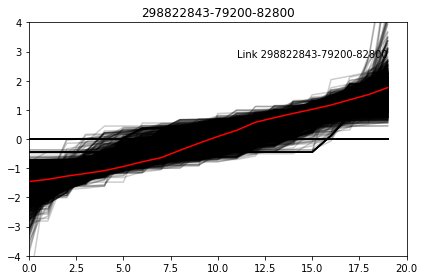

298786466-79200-82800
[152746500, 82800, 86400]: 1.5500491293925893
[547531528, 82800, 86400]: 1.4136838054317142
[547531527, 82800, 86400]: 0.5649391327736671
[420135389, 82800, 86400]: 1.5500491293925893
[8838071, 82800, 86400]: 1.0537361754787105
[301677886, 82800, 86400]: 1.5500491293925893
[152978752, 82800, 86400]: 1.0607259480719613
[547531535, 82800, 86400]: 1.5500491293925893
[547531525, 82800, 86400]: 1.5500491293925893
[159632718, 82800, 86400]: 0.37884577185533286
[547531531, 82800, 86400]: 0.8395194393413611
[547531534, 82800, 86400]: 0.8203621015530793
[547531536, 82800, 86400]: 1.4669513087828931
[47876615, 82800, 86400]: 4.719533518936848
[515675204, 82800, 86400]: 1.1154220214891146
[153947334, 82800, 86400]: 1.005365387321493
[103934334, 82800, 86400]: 1.5500491293925893
[153947335, 82800, 86400]: 1.0213069615724948
[301677885, 82800, 86400]: 1.5500491293925893
[634307497, 82800, 86400]: 1.5500491293925893
[157490277, 82800, 86400]: 1.5500491293925893
[297830232, 8280

[152978672, 0, 3600]: 0.8833757741225927
[547531516, 0, 3600]: 0.2520433441671374
[440521424, 0, 3600]: 0.45449329074753486
[297971534, 0, 3600]: 4.719533518936848
[157488722, 0, 3600]: 1.5500491293925893
[152967148, 0, 3600]: 4.719533518936848
[152679218, 0, 3600]: 1.5438479756646601
[780911242, 0, 3600]: 0.7780606020514362
[104081781, 0, 3600]: 1.5500491293925893
[153019269, 0, 3600]: 0.5071779846073613
[152679413, 0, 3600]: 0.6461430203064263
[160451376, 0, 3600]: 1.5500491293925893
[299893502, 0, 3600]: 1.0637011142760007
[174924979, 0, 3600]: 0.747113744131772
[718963842, 0, 3600]: 1.5500491293925893
[104082865, 0, 3600]: 1.5500491293925893
[718963897, 0, 3600]: 2.1415777127464426
[159632877, 0, 3600]: 1.2048140861057512
[547531510, 0, 3600]: 0.29120226365592977
[152978671, 0, 3600]: 0.48172614569745553
[275539107, 0, 3600]: 1.8404459582644723
[104082923, 0, 3600]: 1.0784058824252682
[157489829, 0, 3600]: 0.6898541064937667
[5135005, 0, 3600]: 1.490561880578004
[153947337, 0, 3600

[152895056, 0, 3600]: 1.5500491293925893
[134801107, 0, 3600]: 1.5500491293925893
[688769623, 0, 3600]: 0.42852825870361955
[152679221, 0, 3600]: 1.02347789810329
[718963662, 0, 3600]: 1.5500491293925893
[681329980, 0, 3600]: 0.3868310572561339
[441497930, 0, 3600]: 1.5500491293925893
[298337589, 0, 3600]: 1.257766049120747
[420095473, 0, 3600]: 1.2268047786694516
[423239429, 0, 3600]: 0.5593448726426529
[688769627, 0, 3600]: 0.49929897386764466
[675092021, 0, 3600]: 0.8630452469133485
[299893498, 0, 3600]: 0.7308165207539518
[159632858, 0, 3600]: 1.5500491293925893
[299081200, 0, 3600]: 0.5371997430722784
[104081780, 0, 3600]: 1.5500491293925893
[385619164, 0, 3600]: 0.5105905708118694
[299893499, 0, 3600]: 0.8412672478861929
[420095474, 0, 3600]: 1.5500491293925893
[438172985, 0, 3600]: 1.551630672195099
[153946072, 0, 3600]: 1.5500491293925893
[152679414, 0, 3600]: 1.0274017991265176
[711385801, 0, 3600]: 1.2100687994713883
[152995654, 0, 3600]: 1.5500491293925893
[344851269, 0, 360

[711385802, 10800, 14400]: 0.5500660372168124
[153019248, 10800, 14400]: 1.5500491293925893
[238618789, 10800, 14400]: 1.5500491293925893
[298616195, 10800, 14400]: 1.5500491293925893
[697192649, 68400, 72000]: 1.4253954518926861
[697192648, 68400, 72000]: 1.5500491293925893
[153035114, 68400, 72000]: 1.5500491293925893
[697192623, 68400, 72000]: 1.049738184277078
[441315037, 68400, 72000]: 1.3272604216295378
[234332717, 3600, 7200]: 1.5500491293925893
[153035119, 3600, 7200]: 1.5500491293925893
[152925434, 3600, 7200]: 1.5500491293925893
[160462985, 3600, 7200]: 1.5500491293925893
[153035249, 3600, 7200]: 1.5500491293925893
[153035118, 3600, 7200]: 1.5500491293925893
[160444149, 3600, 7200]: 1.5500491293925893
[298930273, 3600, 7200]: 1.5500491293925893
[160462988, 3600, 7200]: 1.5500491293925893
[160462986, 3600, 7200]: 1.5500491293925893
[153035250, 3600, 7200]: 1.5500491293925893
[298925920, 3600, 7200]: 1.5500491293925893
[126243421, 3600, 7200]: 1.5500491293925893
[189465475, 360

[297882686, 61200, 64800]: 0.33079273861610753
[152679274, 61200, 64800]: 0.752280917117809
[298699139, 61200, 64800]: 0.686439242133374
[373003260, 61200, 64800]: 0.7196845822940977
[695018705, 61200, 64800]: 1.24744712656125
[420076103, 61200, 64800]: 0.9146092945819578
[152668404, 61200, 64800]: 0.5329373533427437
[152967668, 61200, 64800]: 1.5500491293925893
[441250624, 61200, 64800]: 0.6964003896563986
[519178541, 61200, 64800]: 0.6925551529477428
[152924165, 61200, 64800]: 1.2819059248275555
[228275506, 61200, 64800]: 1.5500491293925893
[154149777, 61200, 64800]: 0.5199211578056012
[298930275, 61200, 64800]: 1.5500491293925893
[441315035, 61200, 64800]: 1.1194239711594296
[552008936, 61200, 64800]: 0.675926553225075
[8578406, 61200, 64800]: 1.5500491293925893
[152924176, 61200, 64800]: 1.3631756679323217
[373003259, 61200, 64800]: 0.4808815047762504
[441315036, 61200, 64800]: 1.5500491293925893
[298703037, 61200, 64800]: 1.29379892031239
[420076102, 61200, 64800]: 0.9959838390446

[152900441, 7200, 10800]: 1.3517153721667725
[417068017, 7200, 10800]: 1.5500491293925893
[397153549, 7200, 10800]: 0.8359844799705417
[298549749, 7200, 10800]: 0.6736132924273979
[153043517, 7200, 10800]: 0.5424707710372444
[463524776, 7200, 10800]: 0.7269756769781617
[238618777, 7200, 10800]: 1.5500491293925893
[385793312, 7200, 10800]: 0.5162733352298946
[159740419, 7200, 10800]: 1.5500491293925893
[154149772, 7200, 10800]: 1.5500491293925893
[438177907, 7200, 10800]: 0.32969355729764704
[441304006, 7200, 10800]: 1.5500491293925893
[247141051, 7200, 10800]: 1.0224662201765433
[221553422, 7200, 10800]: 1.303166604930904
[319899452, 7200, 10800]: 1.5500491293925893
[159632887, 7200, 10800]: 0.5774853622288316
[152900438, 7200, 10800]: 1.2349479666148004
[221553420, 7200, 10800]: 0.8314501332753182
[493523041, 7200, 10800]: 0.8457644173522969
[154150232, 7200, 10800]: 0.4853228497870673
[152967205, 7200, 10800]: 0.7834948274289524
[515863910, 7200, 10800]: 1.5500491293925893
[297829485

[152978699, 57600, 61200]: 1.5500491293925893
[441250617, 57600, 61200]: 0.35994899720013496
[441250616, 57600, 61200]: 0.3677667261045604
[191003438, 57600, 61200]: 1.5500491293925893
[441250615, 57600, 61200]: 0.697002593708584
[191003420, 57600, 61200]: 1.5500491293925893
[441250611, 57600, 61200]: 0.617139608028687
[441250614, 57600, 61200]: 0.37117094385801297
[441250612, 57600, 61200]: 0.3945007126108284
[504476752, 57600, 61200]: 4.719533518936848
[441250613, 57600, 61200]: 0.43344888484364014
[483472252, 36000, 39600]: 0.8993198853858714
[319929468, 36000, 39600]: 1.5500491293925893
[298237463, 36000, 39600]: 1.5500491293925893
[319929467, 36000, 39600]: 1.5500491293925893
[515102686, 36000, 39600]: 1.5500491293925893
[104082905, 36000, 39600]: 1.5500491293925893
[298237466, 36000, 39600]: 1.0201132543380051
[483472250, 36000, 39600]: 4.719533518936848
[161620469, 36000, 39600]: 1.5500491293925893
[298237462, 36000, 39600]: 4.719533518936848
[298237465, 36000, 39600]: 1.5500491

[191620663, 79200, 82800]: 1.1317751925498643
[22810756, 79200, 82800]: 0.37041435253441957
[153053621, 79200, 82800]: 1.0170703143662403
[676950799, 79200, 82800]: 0.3689809795844133
[153019295, 79200, 82800]: 1.3674291868508168
[154534951, 79200, 82800]: 0.6498554814704047
[459670471, 79200, 82800]: 0.705988334534666
[346316341, 79200, 82800]: 0.49242492250975645
[418178084, 79200, 82800]: 0.9397779714654221
[440644896, 79200, 82800]: 0.5027988494469828
[153035274, 79200, 82800]: 0.5541091910324926
[160444349, 79200, 82800]: 0.6776084575608934
[152679374, 79200, 82800]: 0.7025469402728062
[153945673, 79200, 82800]: 0.26513001385972956
[275345111, 79200, 82800]: 1.397542455013828
[297975534, 79200, 82800]: 0.37673663088447557
[298616206, 79200, 82800]: 0.4254138497415302
[711367803, 79200, 82800]: 0.901053795267521
[153044324, 79200, 82800]: 0.4762771211130047
[301603270, 79200, 82800]: 0.6294563230583763
[189676995, 79200, 82800]: 0.5606213888724034
[141129799, 79200, 82800]: 0.97894

[34700792, 79200, 82800]: 0.4944598790453865
[480289604, 79200, 82800]: 1.6596349783343194
[153035190, 79200, 82800]: 1.041364665039298
[153035168, 79200, 82800]: 0.9150256647479226
[441265807, 79200, 82800]: 0.25290605290092405
[410013928, 79200, 82800]: 1.3836033224345479
[152924140, 79200, 82800]: 1.5500491293925893
[385621390, 79200, 82800]: 0.8762241703323954
[152665015, 79200, 82800]: 0.8390488844958968
[515699259, 79200, 82800]: 0.7636071649019436
[420076109, 79200, 82800]: 1.3851469868182833
[152978771, 79200, 82800]: 1.137347303369511
[320136009, 79200, 82800]: 0.6933193290316574
[299018407, 79200, 82800]: 0.4133471778736188
[189452928, 79200, 82800]: 0.2553449196640568
[152679372, 79200, 82800]: 0.9114864490541987
[297996746, 79200, 82800]: 1.5030488134967206
[228275509, 79200, 82800]: 1.4998066409308466
[320064977, 79200, 82800]: 1.5500491293925893
[160443450, 79200, 82800]: 0.4891186959067715
[104081738, 79200, 82800]: 0.6656602874043667
[505168991, 79200, 82800]: 0.3871038

[22810768, 79200, 82800]: 0.8769455548220292
[8035519, 79200, 82800]: 0.5842102584890388
[480289568, 79200, 82800]: 2.2325692704242894
[424918859, 79200, 82800]: 0.8084511522127028
[502511275, 79200, 82800]: 1.5500491293925893
[46429874, 79200, 82800]: 1.7520652966011478
[299045398, 79200, 82800]: 1.5500491293925893
[104082939, 79200, 82800]: 0.6899510118868846
[251098779, 79200, 82800]: 1.3374691107766046
[298029510, 79200, 82800]: 0.9021879549517818
[298925924, 79200, 82800]: 0.778519627291878
[301677372, 79200, 82800]: 0.501090853500415
[502511304, 79200, 82800]: 0.28633360512472444
[423239445, 79200, 82800]: 1.061569617064725
[252835217, 79200, 82800]: 0.6611438266275668
[423724815, 79200, 82800]: 0.1297575739309114
[424918855, 79200, 82800]: 0.8594236113107321
[234439477, 79200, 82800]: 0.8401013831671591
[385621391, 79200, 82800]: 0.91753230628617
[34700812, 79200, 82800]: 0.2470641188421919
[153035146, 79200, 82800]: 1.5500491293925893
[152995668, 79200, 82800]: 1.06105575416875

[161620504, 79200, 82800]: 1.9662543055176138
[346316342, 79200, 82800]: 0.42782167653797926
[251098648, 79200, 82800]: 0.49303093548212884
[420076114, 79200, 82800]: 2.6289249428204884
[153053556, 79200, 82800]: 0.22978952566432687
[152994917, 79200, 82800]: 1.1084480584286804
[298237446, 79200, 82800]: 1.169724828319244
[153041326, 79200, 82800]: 0.48953042318481405
[487855862, 79200, 82800]: 0.6527739200956636
[480289607, 79200, 82800]: 0.5718733793672272
[104082935, 79200, 82800]: 0.8642290299915846
[275345099, 79200, 82800]: 1.388420796770296
[153045273, 79200, 82800]: 0.2778480430540068
[160440239, 79200, 82800]: 0.8478166054080565
[298877132, 79200, 82800]: 0.7162877460534217
[154149751, 79200, 82800]: 0.9420242069129287
[298925939, 79200, 82800]: 0.33509005537820113
[188842346, 79200, 82800]: 0.5489310521796208
[34700803, 79200, 82800]: 0.6038083291252035
[152679318, 79200, 82800]: 0.7713107856765463
[780483745, 79200, 82800]: 1.0015804924401581
[516508097, 79200, 82800]: 1.375

[153053622, 79200, 82800]: 0.8484963108568954
[153947392, 79200, 82800]: 0.5412874411765576
[188842326, 79200, 82800]: 0.9729211496779752
[152679191, 79200, 82800]: 0.9662561075466917
[252835215, 79200, 82800]: 0.41188697144935094
[665834899, 79200, 82800]: 0.5127087894267737
[297998493, 79200, 82800]: 0.7228955595747805
[160469977, 79200, 82800]: 1.1352317923865114
[103934330, 79200, 82800]: 0.3502865771045348
[160438437, 79200, 82800]: 2.3593142239380365
[463337410, 79200, 82800]: 0.45554557209013363
[676950802, 79200, 82800]: 0.4973243262183697
[152746407, 79200, 82800]: 0.42810534448918913
[188842278, 79200, 82800]: 1.4748519283812873
[152679195, 79200, 82800]: 0.9156909509181118
[502511267, 79200, 82800]: 1.5500491293925893
[152966825, 79200, 82800]: 0.35181728607205326
[775436078, 79200, 82800]: 1.3150734865016045
[420076279, 79200, 82800]: 0.8905103864600896
[487825348, 79200, 82800]: 0.4394306651042924
[155685562, 79200, 82800]: 0.5001975584768559
[152668387, 79200, 82800]: 0.4

[153022728, 79200, 82800]: 0.5344478971606313
[298925965, 79200, 82800]: 0.9874512219259288
[154539330, 79200, 82800]: 1.5500491293925893
[152679202, 79200, 82800]: 0.6910833707481021
[188842249, 79200, 82800]: 0.5377837957331166
[251098641, 79200, 82800]: 0.5042391940749875
[487855856, 79200, 82800]: 0.48291458626667394
[463321552, 79200, 82800]: 0.40616059289282114
[103934331, 79200, 82800]: 0.3663217579555876
[502508488, 79200, 82800]: 0.392659641246901
[188842269, 79200, 82800]: 0.427527651222106
[245333284, 79200, 82800]: 0.7137333019732077
[649730258, 79200, 82800]: 1.063313195282854
[440644897, 79200, 82800]: 0.6906988631576059
[153044323, 79200, 82800]: 0.5918030175816084
[5069461, 79200, 82800]: 0.4238273932227747
[188842307, 79200, 82800]: 0.6247817344566803
[8035565, 79200, 82800]: 1.138199500625052
[153004069, 79200, 82800]: 1.0282877329230762
[153004050, 79200, 82800]: 1.1038063547461174
[8578347, 79200, 82800]: 1.2248655630043614
[409377699, 79200, 82800]: 0.6056846743797

[502511308, 79200, 82800]: 0.397064581822188
[195407914, 79200, 82800]: 0.31780779460312786
[344851288, 79200, 82800]: 0.3607936706929802
[152967871, 79200, 82800]: 0.34652558394625105
[160469994, 79200, 82800]: 1.5500491293925893
[440521434, 79200, 82800]: 0.8788944023210391
[160443455, 79200, 82800]: 0.34433509913741306
[463337423, 79200, 82800]: 0.6942397450434253
[516841622, 79200, 82800]: 0.8080369221388011
[487855865, 79200, 82800]: 0.7369256052387729
[234352587, 79200, 82800]: 0.6687036768768372
[160469978, 79200, 82800]: 1.080038658749747
[424918869, 79200, 82800]: 0.8509926593765244
[153035159, 79200, 82800]: 0.588294960157052
[153053560, 79200, 82800]: 0.20334338239813565
[238610488, 79200, 82800]: 2.379684629350131
[104082894, 79200, 82800]: 0.931895068976815
[301724743, 79200, 82800]: 1.0729726947439284
[160458421, 79200, 82800]: 0.6841919353784683
[327005891, 79200, 82800]: 0.39035722815541535
[153045277, 79200, 82800]: 0.7176568963885391
[91978059, 79200, 82800]: 0.194435

[152679316, 79200, 82800]: 0.8477876115650159
[442373620, 79200, 82800]: 0.38415464395894006
[34700791, 79200, 82800]: 0.4591845589076706
[441455570, 79200, 82800]: 0.9741174867250675
[252835487, 79200, 82800]: 0.6129152029701446
[297998496, 79200, 82800]: 1.487527239046459
[188842315, 79200, 82800]: 0.6246897163781434
[152679402, 79200, 82800]: 1.6809053662508224
[480289592, 79200, 82800]: 0.3981986077239206
[8035471, 79200, 82800]: 0.42371578189526515
[275345103, 79200, 82800]: 1.441693662579108
[153035161, 79200, 82800]: 0.7999299571321298
[298944622, 79200, 82800]: 0.5990667406809875
[152665017, 79200, 82800]: 0.9890115249899112
[188842282, 79200, 82800]: 0.7023207127077442
[46429878, 79200, 82800]: 1.2625665074506276
[325598323, 79200, 82800]: 1.0377430499692675
[298925968, 79200, 82800]: 0.7168158062208116
[320064973, 79200, 82800]: 1.5500491293925893
[154534955, 79200, 82800]: 0.5777652705951587
[297881923, 79200, 82800]: 1.5500491293925893
[252835225, 79200, 82800]: 0.444681367

[385331943, 79200, 82800]: 0.32110763815232746
[153798139, 79200, 82800]: 0.573091473259745
[325598332, 79200, 82800]: 0.8510051372394882
[515699258, 79200, 82800]: 0.8126056275552356
[153000830, 79200, 82800]: 0.27609861738514796
[301724740, 79200, 82800]: 1.1819438561235298
[153030728, 79200, 82800]: 1.5500491293925893
[480289595, 79200, 82800]: 0.3942860275375246
[189424075, 79200, 82800]: 1.5500491293925893
[153006803, 79200, 82800]: 0.8627584898816875
[153021413, 79200, 82800]: 0.9580584544080639
[411394831, 79200, 82800]: 0.26898249138439834
[463321555, 79200, 82800]: 0.23525117752966104
[697192598, 79200, 82800]: 1.4422643303547842
[153019307, 79200, 82800]: 0.8852252434241258
[104082938, 79200, 82800]: 0.974778725764456
[441455567, 79200, 82800]: 1.1008769892151276
[191620661, 79200, 82800]: 1.2853918437756364
[152746386, 79200, 82800]: 1.0847977504072475
[161620486, 79200, 82800]: 1.3541895184911084
[301854508, 79200, 82800]: 0.31518537159482396
[459670478, 79200, 82800]: 0.66

[301724764, 79200, 82800]: 1.0971387569657354
[409377703, 79200, 82800]: 0.4647993716127118
[251101617, 79200, 82800]: 0.8300369568097384
[8578425, 79200, 82800]: 1.5500491293925893
[252392953, 79200, 82800]: 0.6369074898320914
[153035167, 79200, 82800]: 0.6702330662352101
[8035460, 79200, 82800]: 0.6736225066049253
[676436349, 79200, 82800]: 0.6360128098304177
[480289638, 79200, 82800]: 0.877931658421042
[153004065, 79200, 82800]: 0.8067112885769749
[424918873, 79200, 82800]: 0.8522571912066172
[46262605, 79200, 82800]: 0.6592887155787512
[245334386, 79200, 82800]: 1.359392076369203
[153041716, 79200, 82800]: 0.3854666346612176
[243630882, 79200, 82800]: 1.2744754262018152
[34700786, 79200, 82800]: 1.0884387291757907
[22810758, 79200, 82800]: 0.3498202412686868
[298822841, 79200, 82800]: 0.3859083045799741
[301677367, 79200, 82800]: 0.5106493674865539
[516841617, 79200, 82800]: 0.3845869684807714
[34700798, 79200, 82800]: 0.21683453252429297
[152924158, 79200, 82800]: 1.29923347305102

[153019261, 79200, 82800]: 0.7180053260420388
[189468782, 79200, 82800]: 0.8306387904541399
[154534954, 79200, 82800]: 0.5702360661343596
[298925927, 79200, 82800]: 0.7036151066228964
[463524783, 79200, 82800]: 1.5500491293925893
[152679361, 79200, 82800]: 0.23286308358291435
[385332400, 79200, 82800]: 0.6865704216061979
[301724746, 79200, 82800]: 0.6761428728552057
[152900397, 79200, 82800]: 0.9497342681324226
[153035275, 79200, 82800]: 0.5179883668575717
[438172973, 79200, 82800]: 1.5622308241540146
[491822820, 79200, 82800]: 0.7097655929459712
[153049962, 79200, 82800]: 0.21176190820050464
[153004036, 79200, 82800]: 1.3976643306047187
[152967600, 79200, 82800]: 0.9199673528939729
[153053620, 79200, 82800]: 1.085323580987216
[152994912, 79200, 82800]: 0.9569016267291568
[299094982, 79200, 82800]: 0.691865530458556
[153019240, 79200, 82800]: 1.5307142058385521
[152966816, 79200, 82800]: 0.3971553534402843
[298503438, 79200, 82800]: 1.5500491293925893
[153035195, 79200, 82800]: 0.80654

[423729712, 79200, 82800]: 1.5500491293925893
[411394827, 79200, 82800]: 0.45884213877993896
[412914962, 79200, 82800]: 1.5500491293925893
[286684918, 79200, 82800]: 1.0818738908091343
[440521432, 79200, 82800]: 1.2204670156482635
[487825347, 79200, 82800]: 0.4257246119919925
[153049902, 79200, 82800]: 1.1531503996169108
[103934328, 79200, 82800]: 0.39353294503914993
[152651325, 79200, 82800]: 0.9641920182111126
[297883452, 79200, 82800]: 1.3097759006235314
[228275472, 79200, 82800]: 0.38971004262286313
[437838455, 79200, 82800]: 0.9138730230928931
[385334122, 79200, 82800]: 1.5500491293925893
[480289573, 79200, 82800]: 1.9105509440079909
[502501386, 79200, 82800]: 1.5500491293925893
[438177898, 79200, 82800]: 1.0088696293760582
[153055999, 79200, 82800]: 3.735918656913205
[160466239, 79200, 82800]: 1.5629413608721265
[152679373, 79200, 82800]: 1.3087453083939848
[298843856, 79200, 82800]: 0.7893244155373597
[46414966, 79200, 82800]: 0.5325921859585182
[40754097, 79200, 82800]: 1.50452

[385334126, 79200, 82800]: 1.5500491293925893
[439048437, 79200, 82800]: 0.9406208735760345
[152665014, 79200, 82800]: 0.592959544245672
[152977272, 79200, 82800]: 1.316350065148104
[410013929, 79200, 82800]: 1.3718705218857483
[22810749, 79200, 82800]: 0.4253772594410863
[81797653, 79200, 82800]: 0.548090751478103
[153049972, 79200, 82800]: 0.3844829894312825
[298237458, 79200, 82800]: 1.122544188656557
[442373711, 79200, 82800]: 0.3515170485337444
[301677359, 79200, 82800]: 0.41423856053212166
[34700801, 79200, 82800]: 0.354243793280917
[152966822, 79200, 82800]: 0.3571137611023001
[8578426, 79200, 82800]: 1.5500491293925893
[275345106, 79200, 82800]: 1.3203947904576785
[438177901, 79200, 82800]: 0.7000698234115269
[675344454, 79200, 82800]: 0.6521108210443088
[298925937, 79200, 82800]: 0.3351522403194588
[547531547, 79200, 82800]: 1.0024997806879643
[408268173, 79200, 82800]: 0.5541196235647151
[195407907, 79200, 82800]: 0.4756897790791223
[298944610, 79200, 82800]: 0.42773742531930

[440521433, 79200, 82800]: 1.0174519831088051
[153001127, 79200, 82800]: 0.5710827167964867
[34700789, 79200, 82800]: 0.769226083774806
[245333410, 79200, 82800]: 0.42213687473030836
[610571160, 79200, 82800]: 0.34304045616607165
[298699134, 79200, 82800]: 0.7747549111525333
[157489534, 79200, 82800]: 1.4816009318817704
[252835220, 79200, 82800]: 0.47244034075056546
[188842301, 79200, 82800]: 0.4034190636805752
[159380626, 79200, 82800]: 1.0773010744353881
[252835208, 79200, 82800]: 0.8420923009015714
[153019280, 79200, 82800]: 1.0418723960294611
[420076282, 79200, 82800]: 1.476593854160994
[297975537, 79200, 82800]: 0.4431500233465971
[459670498, 79200, 82800]: 0.39470789807243695
[298703042, 79200, 82800]: 0.4452205680980045
[104081819, 79200, 82800]: 0.4449894354640255
[245334396, 79200, 82800]: 0.9206984194813131
[188842291, 79200, 82800]: 0.38748061351724267
[159740340, 79200, 82800]: 1.1983438739075536
[34700799, 79200, 82800]: 0.23099575043470819
[298234503, 79200, 82800]: 1.550

[442372760, 79200, 82800]: 0.40682696472055485
[220393425, 79200, 82800]: 0.38968854726394353
[46932861, 79200, 82800]: 1.381447329824949
[238609960, 79200, 82800]: 1.2953719034839402
[408268180, 79200, 82800]: 0.3769601845211605
[423724813, 79200, 82800]: 0.32631757999488387
[152651321, 79200, 82800]: 1.1366208667346307
[259111671, 79200, 82800]: 1.5500491293925893
[423724831, 79200, 82800]: 0.6942976737398463
[245334394, 79200, 82800]: 1.460555821542333
[385334118, 79200, 82800]: 1.5500491293925893
[195407916, 79200, 82800]: 0.3800863412630584
[572708710, 79200, 82800]: 1.188085430450968
[159740343, 79200, 82800]: 0.9271204389372001
[298925979, 79200, 82800]: 1.09991927040163
[252392940, 79200, 82800]: 0.6223559009275615
[487825349, 79200, 82800]: 0.36007098623799266
[188842261, 79200, 82800]: 0.36923855925080934
[153053685, 79200, 82800]: 0.6485105585141536
[153004044, 79200, 82800]: 0.9129938138291173
[411394823, 79200, 82800]: 0.5366529839215861
[299032765, 79200, 82800]: 0.361687

[152967825, 46800, 50400]: 1.202154248548771
[298834964, 46800, 50400]: 0.455097665721073
[418094197, 46800, 50400]: 0.2948333955998201
[152654146, 46800, 50400]: 0.6444045457786379
[649730253, 46800, 50400]: 1.3928878714124842
[152960512, 46800, 50400]: 0.8904980435755168
[385334093, 46800, 50400]: 1.0945155486493954
[154539327, 46800, 50400]: 0.7893437095643125
[385334103, 46800, 50400]: 1.4285871109977288
[443414627, 46800, 50400]: 0.777530691563715
[780964773, 46800, 50400]: 1.0287702067401525
[298726734, 46800, 50400]: 0.39615639361095534
[8035439, 46800, 50400]: 1.5500491293925893
[244021204, 46800, 50400]: 0.899565219814142
[153022676, 46800, 50400]: 1.400998604561389
[159740426, 46800, 50400]: 1.5500491293925893
[81797898, 46800, 50400]: 1.5500491293925893
[779578735, 46800, 50400]: 1.0329825349526813
[153043526, 46800, 50400]: 1.5500491293925893
[154150699, 46800, 50400]: 1.2466728753032157
[676166103, 46800, 50400]: 0.32180068805480877
[159380622, 46800, 50400]: 1.55004912939

[154537319, 72000, 75600]: 1.5500491293925893
[154537321, 72000, 75600]: 1.5500491293925893
[154537296, 72000, 75600]: 1.5500491293925893
[152900422, 72000, 75600]: 1.5500491293925893


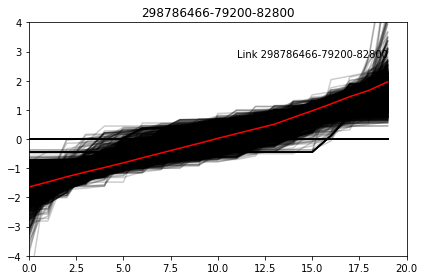

298786464-79200-82800
[152746500, 82800, 86400]: 1.722061978060316
[547531528, 82800, 86400]: 1.596383032206143
[547531527, 82800, 86400]: 0.8321681265916816
[420135389, 82800, 86400]: 1.722061978060316
[8838071, 82800, 86400]: 1.2800265386917995
[301677886, 82800, 86400]: 1.722061978060316
[152978752, 82800, 86400]: 1.3392094170936557
[547531535, 82800, 86400]: 1.722061978060316
[547531525, 82800, 86400]: 1.722061978060316
[159632718, 82800, 86400]: 0.4603406748034309
[547531531, 82800, 86400]: 0.9056258587078758
[547531534, 82800, 86400]: 0.8996412842808541
[547531536, 82800, 86400]: 1.6475187492477896
[47876615, 82800, 86400]: 4.756812925985693
[515675204, 82800, 86400]: 1.3675071119473758
[153947334, 82800, 86400]: 1.2393521709014494
[103934334, 82800, 86400]: 1.722061978060316
[153947335, 82800, 86400]: 1.190339805809739
[301677885, 82800, 86400]: 1.722061978060316
[634307497, 82800, 86400]: 1.722061978060316
[157490277, 82800, 86400]: 1.722061978060316
[297830232, 82800, 86400]: 

[297971534, 0, 3600]: 4.756812925985693
[157488722, 0, 3600]: 1.722061978060316
[152967148, 0, 3600]: 4.756812925985693
[152679218, 0, 3600]: 1.7298266398628788
[780911242, 0, 3600]: 1.0757352571243934
[104081781, 0, 3600]: 1.722061978060316
[153019269, 0, 3600]: 0.7726203419102546
[152679413, 0, 3600]: 0.7989346407698257
[160451376, 0, 3600]: 1.722061978060316
[299893502, 0, 3600]: 1.2994156728853352
[174924979, 0, 3600]: 1.066672460020074
[718963842, 0, 3600]: 1.722061978060316
[104082865, 0, 3600]: 1.722061978060316
[718963897, 0, 3600]: 1.9597466369276657
[159632877, 0, 3600]: 1.3989620118655364
[547531510, 0, 3600]: 0.383872617339026
[152978671, 0, 3600]: 0.6752697773197452
[275539107, 0, 3600]: 2.1557220845037937
[104082923, 0, 3600]: 1.3992213350983784
[157489829, 0, 3600]: 1.0084829858454607
[5135005, 0, 3600]: 1.793577349887039
[153947337, 0, 3600]: 0.7330304797994315
[420135390, 0, 3600]: 2.376273367967745
[298503435, 0, 3600]: 2.0609497822585703
[718963664, 0, 3600]: 1.72206

[423239431, 0, 3600]: 0.44312307535160694
[152679219, 0, 3600]: 1.5868462181844096
[160451374, 0, 3600]: 2.7705388535078166
[320136003, 0, 3600]: 1.722061978060316
[153019266, 0, 3600]: 0.9693164978914774
[299893501, 0, 3600]: 1.4070371734131037
[152651318, 0, 3600]: 0.9643592084052326
[153019270, 0, 3600]: 1.1668267075465564
[127127899, 0, 3600]: 1.4861572109358487
[244021197, 0, 3600]: 1.722061978060316
[228275498, 0, 3600]: 1.0743092526265705
[440530037, 0, 3600]: 1.722061978060316
[423239430, 0, 3600]: 0.4626117012677054
[104082864, 0, 3600]: 1.722061978060316
[141129795, 0, 3600]: 0.7423085729656087
[675092019, 0, 3600]: 1.1309626554371928
[299081199, 0, 3600]: 1.118048063687412
[160455795, 0, 3600]: 1.6804312685168534
[493523037, 0, 3600]: 1.1722984432217722
[152679297, 0, 3600]: 1.9597466369277539
[245338047, 0, 3600]: 0.75509387329234
[319950437, 0, 3600]: 1.722061978060316
[251098736, 0, 3600]: 1.722061978060316
[159632856, 0, 3600]: 1.5739884649823304
[675346499, 0, 3600]: 1.

[134801096, 3600, 7200]: 1.722061978060316
[152925433, 3600, 7200]: 1.722061978060316
[153035243, 3600, 7200]: 1.722061978060316
[141129801, 3600, 7200]: 1.722061978060316
[440622911, 3600, 7200]: 1.722061978060316
[298623925, 25200, 28800]: 1.0991693052138929
[154535093, 25200, 28800]: 0.8464400925046638
[259111292, 25200, 28800]: 1.0664340263138692
[104334702, 25200, 28800]: 0.9524217087514516
[230916295, 25200, 28800]: 1.342969546277257
[153022658, 25200, 28800]: 1.722061978060316
[610942260, 25200, 28800]: 1.722061978060316
[160451393, 25200, 28800]: 0.40361664987071294
[153947080, 25200, 28800]: 0.5602471950771876
[159740395, 25200, 28800]: 1.722061978060316
[441462652, 25200, 28800]: 0.805157209487633
[298865303, 25200, 28800]: 0.7102834249527163
[189677023, 25200, 28800]: 1.722061978060316
[298549720, 25200, 28800]: 1.722061978060316
[160451453, 25200, 28800]: 0.7343081027496862
[195407902, 25200, 28800]: 1.722061978060316
[153044317, 25200, 28800]: 1.5489003716512153
[153022803

[152668419, 61200, 64800]: 1.722061978060316
[8578388, 61200, 64800]: 1.0937006893926997
[152668407, 61200, 64800]: 0.5412314692314948
[152679275, 61200, 64800]: 1.722061978060316
[298930277, 61200, 64800]: 1.6936102432697144
[228275500, 61200, 64800]: 1.722061978060316
[695018706, 61200, 64800]: 1.05829183566422
[154149776, 61200, 64800]: 0.9943768819122681
[441315034, 61200, 64800]: 1.722061978060316
[152656719, 61200, 64800]: 0.8721175296815493
[385619160, 61200, 64800]: 1.147695784531732
[298847947, 61200, 64800]: 1.722061978060316
[152924127, 61200, 64800]: 0.7460600343346235
[152924173, 61200, 64800]: 1.2917442381626991
[423729720, 61200, 64800]: 1.268086996519337
[228275502, 61200, 64800]: 1.722061978060316
[154149778, 61200, 64800]: 0.4864261766646354
[298699138, 61200, 64800]: 0.9738532495080682
[413320306, 61200, 64800]: 1.4135470452091707
[413320311, 61200, 64800]: 1.5027447847059816
[253717639, 61200, 64800]: 0.3049339781419633
[160462993, 61200, 64800]: 1.722061978060316
[

[152967203, 7200, 10800]: 0.9618253352841333
[153043513, 7200, 10800]: 2.8397777797047516
[441479962, 7200, 10800]: 1.4058176556949074
[711385799, 7200, 10800]: 1.2273620888878884
[319899455, 7200, 10800]: 1.722061978060316
[153041110, 7200, 10800]: 1.6638871397400516
[742334384, 7200, 10800]: 1.722061978060316
[238618782, 7200, 10800]: 1.722061978060316
[152900379, 7200, 10800]: 1.200222098455129
[46594667, 7200, 10800]: 1.722061978060316
[238611393, 7200, 10800]: 1.722061978060316
[238618781, 7200, 10800]: 1.722061978060316
[780526395, 7200, 10800]: 0.8356784789847744
[152900382, 7200, 10800]: 1.3255944400335642
[417068018, 7200, 10800]: 1.722061978060316
[423239442, 7200, 10800]: 1.8817953617079408
[420135410, 7200, 10800]: 1.722061978060316
[152980841, 7200, 10800]: 0.5636474343459348
[160470011, 7200, 10800]: 1.722061978060316
[558124107, 7200, 10800]: 1.722061978060316
[440536703, 7200, 10800]: 1.0933671562533473
[221553426, 7200, 10800]: 1.0324768563939624
[245334310, 7200, 1080

[427846840, 7200, 10800]: 1.71589189396661
[152679225, 7200, 10800]: 1.722061978060316
[515863913, 7200, 10800]: 1.722061978060316
[152960501, 7200, 10800]: 2.2883905477972157
[189468780, 7200, 10800]: 1.3082826907573972
[152967202, 7200, 10800]: 0.9047077618723476
[530633123, 7200, 10800]: 1.202631844451633
[157489810, 7200, 10800]: 0.9538253563386395
[441250590, 7200, 10800]: 0.9885982421271604
[153044292, 7200, 10800]: 1.1890422376707295
[152900383, 7200, 10800]: 1.6360263943057833
[438177909, 7200, 10800]: 0.9850370110582698
[437986296, 54000, 57600]: 1.722061978060316
[161620525, 28800, 32400]: 1.722061978060316
[161620523, 28800, 32400]: 1.722061978060316
[516841608, 28800, 32400]: 1.722061978060316
[161620524, 28800, 32400]: 1.722061978060316
[443439111, 28800, 32400]: 0.5973481774622242
[161620520, 28800, 32400]: 1.722061978060316
[161620526, 28800, 32400]: 1.722061978060316
[161620528, 28800, 32400]: 1.722061978060316
[152656834, 28800, 32400]: 1.28312397746832
[161620522, 288

[463321549, 79200, 82800]: 0.4659531481269746
[153044293, 79200, 82800]: 0.7966806372309889
[46429881, 79200, 82800]: 1.8023081258067901
[423729714, 79200, 82800]: 1.722061978060316
[275345124, 79200, 82800]: 1.6720699790303817
[780549448, 79200, 82800]: 1.722061978060316
[153019299, 79200, 82800]: 0.6308582223455159
[152900389, 79200, 82800]: 0.8458087234687776
[188842245, 79200, 82800]: 0.6409618474933791
[418178082, 79200, 82800]: 0.7982378175709867
[152746382, 79200, 82800]: 1.4853771161659193
[47876606, 79200, 82800]: 1.722061978060316
[8035444, 79200, 82800]: 0.4502850923064496
[515699253, 79200, 82800]: 2.2149918331560867
[228275471, 79200, 82800]: 0.5429975134501812
[410013917, 79200, 82800]: 1.10838179763723
[299094939, 79200, 82800]: 1.020093126288231
[189677011, 79200, 82800]: 0.5398060952741474
[160449032, 79200, 82800]: 1.63403653153426
[191620663, 79200, 82800]: 1.338886509527398
[22810756, 79200, 82800]: 0.40110908685080565
[153053621, 79200, 82800]: 1.077806887940001
[6

[152980834, 79200, 82800]: 0.5007466370932548
[259110130, 79200, 82800]: 1.722061978060316
[301677360, 79200, 82800]: 0.5783309595766171
[153043583, 79200, 82800]: 0.5147197947198645
[298877133, 79200, 82800]: 1.0450353451881245
[153044332, 79200, 82800]: 1.0650441258228123
[441465379, 79200, 82800]: 0.8384206582236843
[188842325, 79200, 82800]: 0.7882103931801918
[8035455, 79200, 82800]: 0.8976161253030036
[385796161, 79200, 82800]: 1.1491229225793853
[104082881, 79200, 82800]: 1.427512303124484
[463524787, 79200, 82800]: 1.0778571813462758
[411394824, 79200, 82800]: 0.40145239600408467
[385334134, 79200, 82800]: 1.216807685610022
[298029519, 79200, 82800]: 0.7659498208984982
[152679359, 79200, 82800]: 0.3968090823775403
[160438446, 79200, 82800]: 0.6869431962180352
[459670479, 79200, 82800]: 1.1966853433040514
[153053563, 79200, 82800]: 0.49641877767788356
[502511301, 79200, 82800]: 0.305483008058311
[442372759, 79200, 82800]: 0.5857284032717699
[463524780, 79200, 82800]: 1.722061978

[153030228, 79200, 82800]: 1.722061978060316
[8578385, 79200, 82800]: 0.8330223604641641
[412914961, 79200, 82800]: 1.318980998950191
[152679197, 79200, 82800]: 1.0456839729272274
[46429873, 79200, 82800]: 2.4054151867205587
[8578416, 79200, 82800]: 1.722061978060316
[441265811, 79200, 82800]: 1.4251800069118061
[152656824, 79200, 82800]: 0.6108952074586654
[152679210, 79200, 82800]: 1.2857303335738044
[547531504, 79200, 82800]: 0.43039069496092364
[153000825, 79200, 82800]: 0.48733515895392293
[154534960, 79200, 82800]: 0.5663324266214548
[298503411, 79200, 82800]: 0.6594519938476326
[160469976, 79200, 82800]: 1.4753522599113322
[420076110, 79200, 82800]: 1.9170549669883838
[286685266, 79200, 82800]: 0.40705099345606094
[674556446, 79200, 82800]: 1.1598609150736987
[8578353, 79200, 82800]: 1.6336325653634505
[153004058, 79200, 82800]: 1.2355360335139092
[160440590, 79200, 82800]: 1.1663578822389198
[8578345, 79200, 82800]: 1.1418125851639382
[188842306, 79200, 82800]: 0.74128128668601

[259110128, 79200, 82800]: 1.722061978060316
[298877131, 79200, 82800]: 1.0591996410700948
[248762950, 79200, 82800]: 0.7468138471374799
[153049901, 79200, 82800]: 1.0785005312531712
[8035564, 79200, 82800]: 1.339251909182962
[697192600, 79200, 82800]: 1.722061978060316
[152978772, 79200, 82800]: 1.404384497981274
[157489540, 79200, 82800]: 0.6617670199772978
[589546205, 79200, 82800]: 1.2262887203219266
[152679193, 79200, 82800]: 0.7970618713730444
[420076286, 79200, 82800]: 2.5446428924565625
[443405861, 79200, 82800]: 1.40748723069793
[153053627, 79200, 82800]: 1.722061978060316
[153019275, 79200, 82800]: 0.45824389828045486
[320064980, 79200, 82800]: 1.7141641345275642
[301724747, 79200, 82800]: 0.7897545211538632
[188842302, 79200, 82800]: 0.6824087569181183
[297993204, 79200, 82800]: 0.7222319676736074
[46932869, 79200, 82800]: 1.4559601714543378
[459670499, 79200, 82800]: 0.6347160301753725
[420076108, 79200, 82800]: 1.6818213952664915
[589546208, 79200, 82800]: 0.40787278453716

[8578396, 79200, 82800]: 1.722061978060316
[441250610, 79200, 82800]: 0.9821364230050493
[152679282, 79200, 82800]: 1.2625022646226767
[309449107, 79200, 82800]: 0.7630420097360773
[153004068, 79200, 82800]: 0.6350755037665202
[320135992, 79200, 82800]: 1.4992237443945233
[153019236, 79200, 82800]: 0.8100884107882756
[161620490, 79200, 82800]: 0.9969487686046287
[153947385, 79200, 82800]: 0.8655381166362132
[589546206, 79200, 82800]: 0.5506592945270794
[153948622, 79200, 82800]: 4.338248782006183
[153035162, 79200, 82800]: 0.9564325472030465
[188842247, 79200, 82800]: 0.8791973223283569
[234352580, 79200, 82800]: 1.4030591256434573
[8578435, 79200, 82800]: 2.089708964495936
[572708716, 79200, 82800]: 0.715276788788428
[502511306, 79200, 82800]: 1.2086790297279593
[152900400, 79200, 82800]: 0.7507565622923805
[298877136, 79200, 82800]: 1.0276435047779455
[188842290, 79200, 82800]: 0.4324093833890377
[155685561, 79200, 82800]: 0.7155075129309614
[152994913, 79200, 82800]: 1.2664810872803

[298786496, 79200, 82800]: 0.9989731394236684
[301677363, 79200, 82800]: 0.756269085840216
[152679196, 79200, 82800]: 1.0720886356970254
[153035218, 79200, 82800]: 1.2664320293500935
[440530036, 79200, 82800]: 0.248396142488193
[298237457, 79200, 82800]: 1.5340409695347679
[298825164, 79200, 82800]: 0.5223531491787958
[610976571, 79200, 82800]: 1.4183003587608856
[301677370, 79200, 82800]: 0.8212488214245434
[374833925, 79200, 82800]: 0.7156492580987646
[259111668, 79200, 82800]: 1.722061978060316
[104082870, 79200, 82800]: 1.3612614357333317
[325598337, 79200, 82800]: 1.2605149085443688
[34700808, 79200, 82800]: 0.6343963908760465
[678316016, 79200, 82800]: 1.7589501283429125
[423724816, 79200, 82800]: 0.4709360605174343
[104082872, 79200, 82800]: 1.7159028663221625
[463337411, 79200, 82800]: 0.8610349802032109
[153000831, 79200, 82800]: 0.4856987670347385
[152652990, 79200, 82800]: 1.2550865207181774
[320135999, 79200, 82800]: 1.248869376902551
[298707574, 79200, 82800]: 0.8310283024

[104082912, 79200, 82800]: 1.1715561630318265
[152976619, 79200, 82800]: 1.722061978060316
[160440586, 79200, 82800]: 1.275343332129861
[325598341, 79200, 82800]: 0.9735016814934796
[248762944, 79200, 82800]: 0.7678149652050412
[152746450, 79200, 82800]: 0.5691085782189662
[423724812, 79200, 82800]: 0.5930559463940401
[298623917, 79200, 82800]: 0.8107726319247612
[152995665, 79200, 82800]: 0.959714084428847
[5069463, 79200, 82800]: 0.39782382206116207
[189677002, 79200, 82800]: 0.6523514031456389
[298843857, 79200, 82800]: 1.0868448936005077
[152967676, 79200, 82800]: 1.5675749154600436
[152746380, 79200, 82800]: 1.4915164258372378
[152746413, 79200, 82800]: 0.6574571686220356
[152679309, 79200, 82800]: 0.7051898309130409
[188842240, 79200, 82800]: 0.36815337042561563
[220393423, 79200, 82800]: 0.40466208127687736
[8035557, 79200, 82800]: 1.2506101068065731
[153004056, 79200, 82800]: 1.5556830862582778
[320136006, 79200, 82800]: 1.0379373587812706
[325598338, 79200, 82800]: 2.459790688

[248762958, 79200, 82800]: 0.6274046243542368
[195407910, 79200, 82800]: 0.5422306003657426
[238609965, 79200, 82800]: 1.3989683744109351
[152967746, 79200, 82800]: 1.644291774119181
[189663721, 79200, 82800]: 1.8475834960081308
[104081820, 79200, 82800]: 0.6797894201015084
[678316018, 79200, 82800]: 1.866622633357745
[153004054, 79200, 82800]: 1.5959730519623456
[188842320, 79200, 82800]: 0.9035816907993566
[153053683, 79200, 82800]: 0.9562340552421388
[251098936, 79200, 82800]: 1.722061978060316
[152924199, 79200, 82800]: 1.722061978060316
[153049970, 79200, 82800]: 0.5490458054407974
[8838080, 79200, 82800]: 1.0894052996594166
[153000841, 79200, 82800]: 0.785971767046594
[152679184, 79200, 82800]: 0.5029272776468762
[188842251, 79200, 82800]: 0.905843143133399
[298822846, 79200, 82800]: 0.3367791629693139
[298822848, 79200, 82800]: 0.5528356311070144
[297998497, 79200, 82800]: 1.722061978060316
[172232826, 79200, 82800]: 0.458939041724739
[442373728, 79200, 82800]: 0.434851667726404

[46932864, 79200, 82800]: 1.2041243375257513
[423729709, 79200, 82800]: 1.722061978060316
[217603105, 79200, 82800]: 0.6307928018568385
[252392947, 79200, 82800]: 1.2589174038429543
[22810762, 79200, 82800]: 0.6048681493523016
[297826869, 79200, 82800]: 0.9202222786656409
[153035158, 79200, 82800]: 0.8640710632745963
[154149755, 79200, 82800]: 1.062574029892778
[301724762, 79200, 82800]: 0.9059577072938786
[152994903, 79200, 82800]: 0.533014025003405
[154535120, 79200, 82800]: 0.9258108144770693
[153049909, 79200, 82800]: 0.5549543895578394
[153024147, 79200, 82800]: 0.6210700751557586
[299045408, 79200, 82800]: 0.8953976016028666
[385334135, 79200, 82800]: 0.904951053464291
[188842253, 79200, 82800]: 0.9302796968405993
[152895079, 79200, 82800]: 0.8853556011210552
[127127911, 79200, 82800]: 0.5541259604561429
[189424076, 79200, 82800]: 1.722061978060316
[153798135, 79200, 82800]: 0.7965771369341442
[46932873, 79200, 82800]: 1.4245566912473393
[152679404, 79200, 82800]: 2.0307673790904

[189424094, 79200, 82800]: 0.8256201090734001
[297882687, 79200, 82800]: 0.862585505597796
[152895046, 79200, 82800]: 0.9404883021399345
[410013913, 79200, 82800]: 0.45483014807756905
[104082907, 79200, 82800]: 1.3877205546117677
[298925982, 79200, 82800]: 0.7132023484637591
[46414962, 79200, 82800]: 1.776594806676646
[46262599, 79200, 82800]: 1.722061978060316
[188842252, 79200, 82800]: 0.8977131427049828
[463524795, 79200, 82800]: 1.348766850362765
[251098646, 79200, 82800]: 0.8144935126880496
[487825346, 79200, 82800]: 0.6872798603157937
[188842348, 79200, 82800]: 0.6247806735761238
[423724830, 79200, 82800]: 0.8985369556329388
[344864788, 79200, 82800]: 0.6592175610638231
[228275478, 79200, 82800]: 0.6641358648361301
[297883459, 79200, 82800]: 1.2843518941665442
[252835223, 79200, 82800]: 0.608962166477662
[161620479, 79200, 82800]: 2.2097250615681685
[152746484, 79200, 82800]: 0.48937028568517016
[423724835, 79200, 82800]: 1.0938239064428181
[160451442, 79200, 82800]: 0.9611349623

[153019306, 79200, 82800]: 1.722061978060316
[441455565, 79200, 82800]: 1.3966988185176554
[155685565, 79200, 82800]: 1.9883689233798638
[153049974, 79200, 82800]: 0.5351259251889743
[418178079, 79200, 82800]: 1.805522688166245
[299759156, 79200, 82800]: 1.722061978060316
[423719037, 79200, 82800]: 0.5199391595420335
[275345114, 79200, 82800]: 1.313953192196246
[459670496, 79200, 82800]: 0.6403794419862403
[297975532, 79200, 82800]: 0.942679040115751
[238609961, 79200, 82800]: 1.7104862958475375
[440644906, 79200, 82800]: 0.4297683232747325
[676152421, 79200, 82800]: 1.0209055190286815
[152995670, 79200, 82800]: 0.46671855951658764
[161620474, 79200, 82800]: 1.1139838443524093
[152679201, 79200, 82800]: 0.8992219121259339
[463337404, 79200, 82800]: 0.634383779167714
[502501400, 79200, 82800]: 0.3665381611320346
[502511310, 79200, 82800]: 0.45151101818625206
[188842328, 79200, 82800]: 0.7544234509727854
[153043602, 79200, 82800]: 1.0523473299494395
[153006812, 79200, 82800]: 0.927238876

[160469982, 79200, 82800]: 0.45142860990155753
[188842266, 79200, 82800]: 0.3990159472663112
[298925942, 79200, 82800]: 0.3714120046814206
[441455559, 79200, 82800]: 0.6036302645123057
[610571178, 79200, 82800]: 0.46428802467403174
[780549447, 79200, 82800]: 1.8731437126994164
[188842280, 79200, 82800]: 1.608782285196916
[711367804, 79200, 82800]: 1.2667142765394581
[245334302, 79200, 82800]: 1.3793415245614649
[502501394, 79200, 82800]: 1.722061978060316
[152900437, 79200, 82800]: 1.0891621644086351
[152746372, 79200, 82800]: 1.6570555674419734
[373003232, 79200, 82800]: 1.8196348286291775
[46414944, 79200, 82800]: 0.9869279722373826
[152679285, 79200, 82800]: 1.6488134079335934
[301724763, 79200, 82800]: 1.248723505971033
[188842333, 79200, 82800]: 1.722061978060316
[104082913, 79200, 82800]: 1.192028257715293
[275345121, 79200, 82800]: 1.4715342486576763
[298559014, 79200, 82800]: 1.35603827861194
[459684534, 79200, 82800]: 1.5184851620901416
[665834897, 79200, 82800]: 0.40421973792

[152653014, 79200, 82800]: 0.5643870790290314
[153044309, 79200, 82800]: 1.3800488323181588
[8035566, 79200, 82800]: 0.6928641186609562
[152746381, 79200, 82800]: 1.4876645663978159
[141130093, 79200, 82800]: 1.73291841137134
[463524781, 79200, 82800]: 1.722061978060316
[153049915, 79200, 82800]: 0.32156525296734007
[572708712, 79200, 82800]: 1.0317293217281251
[188842276, 79200, 82800]: 1.8251590411080618
[344851264, 79200, 82800]: 0.7819931541010472
[298925923, 79200, 82800]: 0.981866715240767
[152924946, 79200, 82800]: 0.8079069786643733
[245336353, 79200, 82800]: 2.1843228034798003
[298932005, 79200, 82800]: 0.6043218838496931
[491822824, 79200, 82800]: 0.7501822423428043
[152977264, 79200, 82800]: 1.3335635547368965
[649730255, 79200, 82800]: 0.5887697335551261
[297971530, 79200, 82800]: 1.5290019770098575
[195407908, 79200, 82800]: 0.4393616648089776
[159740897, 79200, 82800]: 0.5923503987532454
[154535121, 79200, 82800]: 0.6792545128597183
[152978734, 79200, 82800]: 0.8839650526

[152895047, 79200, 82800]: 1.1318352693960172
[5069458, 79200, 82800]: 0.5889168295858934
[245330477, 79200, 82800]: 0.847543452342964
[531293333, 79200, 82800]: 0.6308936226676051
[505168800, 79200, 82800]: 1.219312298155767
[676152422, 79200, 82800]: 1.6282259050917014
[423724818, 79200, 82800]: 0.43594291360679793
[676148902, 79200, 82800]: 0.5770354263882489
[423724817, 79200, 82800]: 0.4396086511550955
[441462657, 79200, 82800]: 1.4187252218146094
[779578742, 79200, 82800]: 0.9830007571389392
[344851277, 79200, 82800]: 0.7057890743632091
[8578433, 79200, 82800]: 2.0086940174815324
[152924908, 79200, 82800]: 0.6801371322788008
[441250594, 79200, 82800]: 1.0287834624375118
[298925925, 79200, 82800]: 1.0573601791070322
[686244249, 79200, 82800]: 1.722061978060316
[420076288, 79200, 82800]: 2.0915128335124282
[259109270, 79200, 82800]: 0.9930035062598664
[152679182, 79200, 82800]: 0.5963080736081453
[298786472, 79200, 82800]: 0.6023717292147489
[161620489, 79200, 82800]: 0.81503679090

[275345095, 79200, 82800]: 1.6051089023772802
[442373723, 79200, 82800]: 0.5299439392257264
[420076115, 79200, 82800]: 2.8024276898023084
[34700787, 79200, 82800]: 1.4384025325019902
[248762949, 79200, 82800]: 0.6954816032348738
[152967872, 79200, 82800]: 0.6190648079557828
[443405858, 79200, 82800]: 0.6805933744251711
[480289569, 79200, 82800]: 1.644665427937142
[697192631, 79200, 82800]: 1.1535114059075768
[420076285, 79200, 82800]: 2.068140390723156
[346316346, 79200, 82800]: 0.822037580358442
[531743751, 79200, 82800]: 0.4349509861726979
[153022716, 79200, 82800]: 0.6416424218408041
[8035559, 79200, 82800]: 1.374200839469949
[297883454, 79200, 82800]: 1.2443673889476812
[259109268, 79200, 82800]: 1.2516001443067826
[487825345, 79200, 82800]: 0.6834687450816119
[275345109, 79200, 82800]: 1.1951113811691572
[8578354, 79200, 82800]: 1.3718616266171664
[152679370, 79200, 82800]: 1.1157712860178008
[610571173, 79200, 82800]: 1.553074573355696
[76191298, 79200, 82800]: 0.8926717317023458

[153798140, 79200, 82800]: 1.1169961548603076
[153041327, 79200, 82800]: 1.4805328354245355
[252392942, 79200, 82800]: 0.45545801461870844
[104081818, 79200, 82800]: 0.7598291302061672
[298925964, 79200, 82800]: 0.5130865962524973
[385619275, 79200, 82800]: 0.9791699221193326
[153044302, 79200, 82800]: 0.6751766851261596
[298822847, 79200, 82800]: 0.6136581101032703
[252835210, 79200, 82800]: 0.6733680238264066
[153049966, 79200, 82800]: 0.47113090282654363
[674556448, 79200, 82800]: 1.2154440204166765
[135719161, 79200, 82800]: 0.5344164709789362
[152924129, 79200, 82800]: 0.8076878424431304
[301854510, 79200, 82800]: 1.015320627182256
[299032766, 79200, 82800]: 0.3785302361774393
[463337403, 79200, 82800]: 0.642256593014584
[442372760, 79200, 82800]: 0.6433581689298292
[220393425, 79200, 82800]: 0.407285748446165
[46932861, 79200, 82800]: 1.4878518113940498
[238609960, 79200, 82800]: 1.4827826060736735
[408268180, 79200, 82800]: 0.5732936167352491
[423724813, 79200, 82800]: 0.5368645

[81797898, 46800, 50400]: 1.722061978060316
[779578735, 46800, 50400]: 1.014111999561584
[153043526, 46800, 50400]: 1.722061978060316
[154150699, 46800, 50400]: 1.5562762137985204
[676166103, 46800, 50400]: 0.5229728780816598
[159380622, 46800, 50400]: 1.722061978060316
[546853681, 46800, 50400]: 1.0006565069183544
[385334094, 46800, 50400]: 1.5011664953396533
[443397607, 46800, 50400]: 0.8846637450004493
[60712858, 46800, 50400]: 0.4447035083862021
[244021203, 46800, 50400]: 1.2017741632158032
[502502575, 46800, 50400]: 0.5100540263754574
[160444159, 46800, 50400]: 0.385980519363245
[441304013, 46800, 50400]: 1.2350247242683492
[385334104, 46800, 50400]: 1.484236501036752
[152967818, 46800, 50400]: 0.7077363368163273
[676950786, 46800, 50400]: 1.722061978060316
[153022674, 46800, 50400]: 1.472116760338579
[780970466, 46800, 50400]: 0.7174660093615267
[153022673, 46800, 50400]: 1.4188041133892704
[515675209, 46800, 50400]: 1.1898786256869156
[152746397, 46800, 50400]: 1.722061978060316

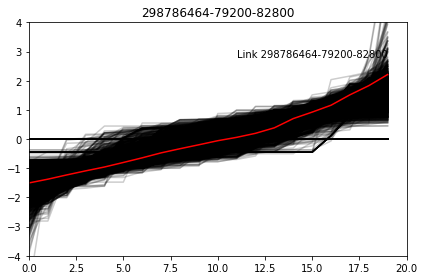

298786471-79200-82800
[152746500, 82800, 86400]: 1.473524770617951
[547531528, 82800, 86400]: 1.3354345643597603
[547531527, 82800, 86400]: 0.422472168450414
[420135389, 82800, 86400]: 1.473524770617951
[8838071, 82800, 86400]: 0.9498714311542692
[301677886, 82800, 86400]: 1.473524770617951
[152978752, 82800, 86400]: 0.834700132371964
[547531535, 82800, 86400]: 1.473524770617951
[547531525, 82800, 86400]: 1.473524770617951
[159632718, 82800, 86400]: 0.5035949657093216
[547531531, 82800, 86400]: 0.9245780077656018
[547531534, 82800, 86400]: 0.90283227914559
[547531536, 82800, 86400]: 1.3893029141875726
[47876615, 82800, 86400]: 4.69666684121555
[515675204, 82800, 86400]: 0.9693662777546836
[153947334, 82800, 86400]: 0.9218149208319248
[103934334, 82800, 86400]: 1.473524770617951
[153947335, 82800, 86400]: 0.998747409397322
[301677885, 82800, 86400]: 1.473524770617951
[634307497, 82800, 86400]: 1.473524770617951
[157490277, 82800, 86400]: 1.473524770617951
[297830232, 82800, 86400]: 0.99

[141129794, 0, 3600]: 0.45287661293582
[779578736, 0, 3600]: 0.30709115976067924
[160451372, 0, 3600]: 2.5721859334201724
[440530050, 0, 3600]: 1.473524770617951
[161620465, 0, 3600]: 0.4314506304405771
[153000853, 0, 3600]: 0.4460276545473746
[152980882, 0, 3600]: 0.5821673616754376
[228275491, 0, 3600]: 0.7363318599514169
[154150230, 0, 3600]: 2.162408471724473
[152996534, 0, 3600]: 1.473524770617951
[104082880, 0, 3600]: 1.473524770617951
[152967646, 0, 3600]: 0.5648455509700341
[423239438, 0, 3600]: 0.5035624304843921
[675092020, 0, 3600]: 0.71761237131763
[697819363, 0, 3600]: 1.473524770617951
[423724842, 0, 3600]: 1.4442277503272118
[157489834, 0, 3600]: 0.6454117800682019
[152978672, 0, 3600]: 0.6961145398954613
[547531516, 0, 3600]: 0.3947127722431625
[440521424, 0, 3600]: 0.335467129278286
[297971534, 0, 3600]: 4.69666684121555
[157488722, 0, 3600]: 1.473524770617951
[152967148, 0, 3600]: 4.69666684121555
[152679218, 0, 3600]: 1.4885224667986188
[780911242, 0, 3600]: 0.557901

[441304011, 0, 3600]: 4.69666684121555
[152679382, 0, 3600]: 0.9061568646764192
[440530048, 0, 3600]: 1.473524770617951
[104082858, 0, 3600]: 1.3714140192312165
[153947087, 0, 3600]: 0.74173764932121
[154535124, 0, 3600]: 0.5174717415471687
[697819364, 0, 3600]: 1.473524770617951
[154537265, 0, 3600]: 1.4510324391423701
[718963676, 0, 3600]: 1.473524770617951
[234345996, 0, 3600]: 4.69666684121555
[441304001, 0, 3600]: 1.0261946418536207
[502501384, 0, 3600]: 1.473524770617951
[153006793, 0, 3600]: 1.392013942149363
[152895056, 0, 3600]: 1.473524770617951
[134801107, 0, 3600]: 1.473524770617951
[688769623, 0, 3600]: 0.3214619851277212
[152679221, 0, 3600]: 1.0145245159400686
[718963662, 0, 3600]: 1.473524770617951
[681329980, 0, 3600]: 0.3529740610084948
[441497930, 0, 3600]: 1.473524770617951
[298337589, 0, 3600]: 1.440907832665683
[420095473, 0, 3600]: 1.3834759731385504
[423239429, 0, 3600]: 0.3897574336906787
[688769627, 0, 3600]: 0.3136012226437954
[675092021, 0, 3600]: 0.70552096

[780970475, 10800, 14400]: 1.473524770617951
[104081800, 10800, 14400]: 0.8463404542425697
[234345983, 10800, 14400]: 1.473524770617951
[780970468, 10800, 14400]: 1.473524770617951
[8035490, 10800, 14400]: 1.473524770617951
[189424065, 10800, 14400]: 1.473524770617951
[22810921, 10800, 14400]: 1.2113448822573423
[298616215, 10800, 14400]: 1.473524770617951
[711385802, 10800, 14400]: 0.29569081168951483
[153019248, 10800, 14400]: 1.473524770617951
[238618789, 10800, 14400]: 1.473524770617951
[298616195, 10800, 14400]: 1.473524770617951
[697192649, 68400, 72000]: 1.2097825754410498
[697192648, 68400, 72000]: 1.473524770617951
[153035114, 68400, 72000]: 1.473524770617951
[697192623, 68400, 72000]: 1.0561897137205551
[441315037, 68400, 72000]: 1.1239515574181178
[234332717, 3600, 7200]: 1.473524770617951
[153035119, 3600, 7200]: 1.473524770617951
[152925434, 3600, 7200]: 1.473524770617951
[160462985, 3600, 7200]: 1.473524770617951
[153035249, 3600, 7200]: 1.473524770617951
[153035118, 3600

[46430972, 25200, 28800]: 1.473524770617951
[153024149, 25200, 28800]: 0.9489636774828683
[160444155, 25200, 28800]: 1.459061527598254
[153050016, 25200, 28800]: 1.473524770617951
[665834891, 25200, 28800]: 1.5318997788286313
[665834890, 25200, 28800]: 1.473524770617951
[160444152, 25200, 28800]: 0.9331582214302074
[153947384, 25200, 28800]: 0.3783045040595764
[252392928, 25200, 28800]: 1.473524770617951
[515675225, 25200, 28800]: 0.215787382875213
[60712845, 25200, 28800]: 1.473524770617951
[298616217, 50400, 54000]: 1.473524770617951
[502501389, 50400, 54000]: 4.69666684121555
[502501393, 50400, 54000]: 0.369877303762343
[8035515, 50400, 54000]: 1.473524770617951
[298703055, 61200, 64800]: 0.7576501516620987
[519178540, 61200, 64800]: 0.8484551887069183
[441250621, 61200, 64800]: 0.42044550725378876
[152656718, 61200, 64800]: 0.543875036739585
[152668408, 61200, 64800]: 0.6474001227777989
[152679310, 61200, 64800]: 1.473524770617951
[152679385, 61200, 64800]: 0.7875703911755423
[7805

[245334306, 7200, 10800]: 1.473524770617951
[440644909, 7200, 10800]: 1.473524770617951
[610577100, 7200, 10800]: 1.6045716146087454
[610577098, 7200, 10800]: 0.6396790637399821
[152900419, 7200, 10800]: 1.2711417781003997
[152679214, 7200, 10800]: 1.473524770617951
[440644908, 7200, 10800]: 0.35168995825397253
[493523040, 7200, 10800]: 1.473524770617951
[245334309, 7200, 10800]: 1.473524770617951
[423239441, 7200, 10800]: 0.2770779695574721
[299094938, 7200, 10800]: 0.4197476889844984
[152967203, 7200, 10800]: 0.821155926227611
[153043513, 7200, 10800]: 2.309807950861169
[441479962, 7200, 10800]: 0.8240647247168624
[711385799, 7200, 10800]: 0.6786253492161214
[319899455, 7200, 10800]: 1.473524770617951
[153041110, 7200, 10800]: 1.177576377940526
[742334384, 7200, 10800]: 1.473524770617951
[238618782, 7200, 10800]: 1.473524770617951
[152900379, 7200, 10800]: 0.9769231904972531
[46594667, 7200, 10800]: 1.473524770617951
[238611393, 7200, 10800]: 1.473524770617951
[238618781, 7200, 10800

[483472249, 36000, 39600]: 4.69666684121555
[393521944, 36000, 39600]: 1.473524770617951
[483472253, 36000, 39600]: 1.473524770617951
[298237467, 36000, 39600]: 1.473524770617951
[483472254, 36000, 39600]: 0.9525189997499323
[297996744, 36000, 39600]: 1.473524770617951
[319929465, 36000, 39600]: 1.473524770617951
[319929466, 36000, 39600]: 1.473524770617951
[298237464, 36000, 39600]: 1.0561897137180365
[697192636, 79200, 82800]: 1.9549035256283542
[516841619, 79200, 82800]: 0.664178194216862
[298944621, 79200, 82800]: 0.6187312329803426
[298947985, 79200, 82800]: 0.3689713167784898
[589546217, 79200, 82800]: 0.2742488611475871
[153019298, 79200, 82800]: 0.26740559485949367
[320064974, 79200, 82800]: 1.473524770617951
[298925978, 79200, 82800]: 0.8101438189235556
[153022736, 79200, 82800]: 0.6893980695179128
[502511303, 79200, 82800]: 0.33425208743676693
[157489536, 79200, 82800]: 1.0050870689280234
[325598329, 79200, 82800]: 0.5129381296203168
[189452923, 79200, 82800]: 0.1988189305149

[423729714, 79200, 82800]: 1.473524770617951
[275345124, 79200, 82800]: 1.4151841149069344
[780549448, 79200, 82800]: 1.473524770617951
[153019299, 79200, 82800]: 0.27882793425737734
[152900389, 79200, 82800]: 0.5124819830719141
[188842245, 79200, 82800]: 0.2638739355001499
[418178082, 79200, 82800]: 1.3153663853816706
[152746382, 79200, 82800]: 0.8298615987272583
[47876606, 79200, 82800]: 1.473524770617951
[8035444, 79200, 82800]: 0.2798222429554022
[515699253, 79200, 82800]: 2.8167591802087917
[228275471, 79200, 82800]: 0.31530946121907416
[410013917, 79200, 82800]: 0.8235918646078885
[299094939, 79200, 82800]: 0.7641231301511442
[189677011, 79200, 82800]: 0.24743746952306525
[160449032, 79200, 82800]: 1.0663670221710646
[191620663, 79200, 82800]: 1.0334224419420204
[22810756, 79200, 82800]: 0.47930413446832865
[153053621, 79200, 82800]: 1.0839887794034837
[676950799, 79200, 82800]: 0.28897812869686573
[153019295, 79200, 82800]: 1.1154243827917358
[154534951, 79200, 82800]: 0.4780154

[298786501, 79200, 82800]: 1.3260479707575668
[480289643, 79200, 82800]: 0.7542944827913323
[697192672, 79200, 82800]: 0.5004406365605436
[152978773, 79200, 82800]: 0.7275376418989528
[189677012, 79200, 82800]: 0.2554222567537733
[153035193, 79200, 82800]: 0.8483727314291322
[159740376, 79200, 82800]: 0.960866510358239
[34700817, 79200, 82800]: 0.11394446002260246
[153035257, 79200, 82800]: 1.473524770617951
[153035182, 79200, 82800]: 0.30495657941129756
[153006807, 79200, 82800]: 1.4623747548490709
[442373725, 79200, 82800]: 0.5206504947690922
[154149750, 79200, 82800]: 0.8998996075782859
[188842233, 79200, 82800]: 0.1833072847235729
[46414948, 79200, 82800]: 0.6920405464540984
[676950779, 79200, 82800]: 0.6820141569603867
[152653013, 79200, 82800]: 0.2563095634307431
[152995664, 79200, 82800]: 0.4603365262087253
[480289565, 79200, 82800]: 2.4640563308242758
[34700792, 79200, 82800]: 0.35604030925205843
[480289604, 79200, 82800]: 1.4321633741362598
[153035190, 79200, 82800]: 0.9510691

[298925973, 79200, 82800]: 0.9869733297520731
[179351239, 79200, 82800]: 1.2002392740560435
[245333409, 79200, 82800]: 0.5897746197078162
[157489541, 79200, 82800]: 0.572809739646008
[152668382, 79200, 82800]: 1.2050662094882065
[157488902, 79200, 82800]: 0.09635407614837975
[153000827, 79200, 82800]: 0.4644833063128753
[442373716, 79200, 82800]: 1.359939966374799
[779578749, 79200, 82800]: 0.9384885305001971
[8578384, 79200, 82800]: 0.40014283293077596
[157489537, 79200, 82800]: 0.5542278610986049
[161620494, 79200, 82800]: 0.12334655892106886
[589546218, 79200, 82800]: 0.18977858336733178
[610571159, 79200, 82800]: 0.31772397784498935
[297998494, 79200, 82800]: 1.3468569626390032
[502511269, 79200, 82800]: 1.473524770617951
[153004039, 79200, 82800]: 1.402236843344519
[314499049, 79200, 82800]: 0.4880454141208229
[314499050, 79200, 82800]: 0.4438889512360865
[480289613, 79200, 82800]: 1.205882999519036
[251098778, 79200, 82800]: 1.1424825477818144
[251098647, 79200, 82800]: 0.2564096

[189452930, 79200, 82800]: 0.41634276666641085
[298925981, 79200, 82800]: 0.564347787627837
[245336351, 79200, 82800]: 1.1225058715339595
[245333411, 79200, 82800]: 0.6276138650693092
[161620514, 79200, 82800]: 1.4858472650011527
[299094971, 79200, 82800]: 0.5886000583442816
[217603102, 79200, 82800]: 0.9572227005406909
[189677006, 79200, 82800]: 0.3945773662038179
[516841623, 79200, 82800]: 0.4824400320811402
[245336352, 79200, 82800]: 1.568323756313637
[780483747, 79200, 82800]: 1.3484992230475576
[152976627, 79200, 82800]: 0.1594826493018493
[153035179, 79200, 82800]: 0.33612599926260955
[153947390, 79200, 82800]: 0.3835478842860768
[189452946, 79200, 82800]: 0.44380995950489033
[441250598, 79200, 82800]: 0.6037833838007569
[152668412, 79200, 82800]: 1.1491304392673134
[409377698, 79200, 82800]: 0.5752993488262302
[159740346, 79200, 82800]: 0.8880369972693422
[420076291, 79200, 82800]: 1.473524770617951
[8035500, 79200, 82800]: 1.473524770617951
[299024303, 79200, 82800]: 0.48372311

[153044329, 79200, 82800]: 0.37261620002156765
[189663722, 79200, 82800]: 0.8387394508100042
[153035194, 79200, 82800]: 1.1633802366571573
[152746373, 79200, 82800]: 1.1388341015202577
[81869221, 79200, 82800]: 0.321012277527892
[153035189, 79200, 82800]: 0.7824923915804267
[238609963, 79200, 82800]: 1.473524770617951
[160440587, 79200, 82800]: 0.6893656232905971
[443405854, 79200, 82800]: 0.6951643129450852
[8035463, 79200, 82800]: 0.6701332461448902
[152978744, 79200, 82800]: 0.7948258936258293
[346316359, 79200, 82800]: 0.5868334273073303
[8035483, 79200, 82800]: 0.43187137166529316
[589546200, 79200, 82800]: 1.757464174354593
[188842340, 79200, 82800]: 0.6117280257172553
[385331944, 79200, 82800]: 0.5995215825559655
[60712867, 79200, 82800]: 0.6493526363536825
[344864791, 79200, 82800]: 0.3213914839901708
[152980850, 79200, 82800]: 1.8833887652536785
[152924133, 79200, 82800]: 0.5094889650742909
[780211970, 79200, 82800]: 1.1565354615546228
[152978774, 79200, 82800]: 0.681384748348

[325598325, 79200, 82800]: 2.2827147455734402
[299094972, 79200, 82800]: 0.6690317522519136
[152679276, 79200, 82800]: 1.473524770617951
[188842230, 79200, 82800]: 0.38403738266570864
[320136001, 79200, 82800]: 0.3373114287195335
[153035259, 79200, 82800]: 0.753094936330443
[46932862, 79200, 82800]: 1.4621094497012634
[298930268, 79200, 82800]: 0.27029199239896756
[153948621, 79200, 82800]: 0.27363669816176633
[152966823, 79200, 82800]: 0.20986810893500504
[153019303, 79200, 82800]: 1.1590560738983693
[152746412, 79200, 82800]: 0.2659493792093284
[420076107, 79200, 82800]: 0.8131738942397139
[8578436, 79200, 82800]: 1.4667771608726343
[153022728, 79200, 82800]: 0.7872629722781217
[298925965, 79200, 82800]: 1.2332385364058094
[154539330, 79200, 82800]: 1.473524770617951
[152679202, 79200, 82800]: 0.8203271659390214
[188842249, 79200, 82800]: 0.365201298239847
[251098641, 79200, 82800]: 0.3140531991059598
[487855856, 79200, 82800]: 0.5610021194905874
[463321552, 79200, 82800]: 0.24304511

[91978059, 79200, 82800]: 0.38466970865655564
[22810772, 79200, 82800]: 0.5881511253209246
[153945669, 79200, 82800]: 0.2493666467277844
[641396455, 79200, 82800]: 1.473524770617951
[152900433, 79200, 82800]: 0.9883856642521937
[152665011, 79200, 82800]: 0.13265298815012877
[259109263, 79200, 82800]: 0.4077966546874596
[423724832, 79200, 82800]: 0.4827620301859874
[103934329, 79200, 82800]: 0.6201799351468522
[301677357, 79200, 82800]: 0.2247281923310605
[245334399, 79200, 82800]: 1.473524770617951
[152746489, 79200, 82800]: 0.4591815014422418
[172232828, 79200, 82800]: 0.32940330031148607
[188842329, 79200, 82800]: 0.929867744565779
[8035554, 79200, 82800]: 0.5873116472655421
[697192627, 79200, 82800]: 1.7448768568946476
[153049911, 79200, 82800]: 0.42586754301576957
[247141044, 79200, 82800]: 0.4042897198718704
[439048430, 79200, 82800]: 1.0284347706020847
[438172969, 79200, 82800]: 0.2498292076558607
[189424081, 79200, 82800]: 0.4493614437870547
[46414949, 79200, 82800]: 0.273709226

[441455570, 79200, 82800]: 0.7155489250176306
[252835487, 79200, 82800]: 0.677135358162101
[297998496, 79200, 82800]: 1.4089952802991526
[188842315, 79200, 82800]: 0.5228637990527705
[152679402, 79200, 82800]: 1.3906967169456679
[480289592, 79200, 82800]: 0.36514032576347055
[8035471, 79200, 82800]: 0.6636292882215244
[275345103, 79200, 82800]: 1.3636866424022227
[153035161, 79200, 82800]: 0.8378298633511858
[298944622, 79200, 82800]: 0.7248420444228342
[152665017, 79200, 82800]: 0.7019737599501381
[188842282, 79200, 82800]: 0.5355104204835087
[46429878, 79200, 82800]: 1.038665717244372
[325598323, 79200, 82800]: 1.2026680734317396
[298925968, 79200, 82800]: 0.9023197553592542
[320064973, 79200, 82800]: 1.473524770617951
[154534955, 79200, 82800]: 0.41942444824730013
[297881923, 79200, 82800]: 1.473524770617951
[252835225, 79200, 82800]: 0.362543334821516
[297998499, 79200, 82800]: 1.473524770617951
[443405857, 79200, 82800]: 0.6030581370871348
[516841620, 79200, 82800]: 1.092214724469

[441455567, 79200, 82800]: 0.8330568833906832
[191620661, 79200, 82800]: 1.2005799978349228
[152746386, 79200, 82800]: 0.7924933410859141
[161620486, 79200, 82800]: 1.4109637836367679
[301854508, 79200, 82800]: 0.2718354321461421
[459670478, 79200, 82800]: 0.5930036471320619
[298822853, 79200, 82800]: 1.4403644141145846
[298822849, 79200, 82800]: 0.3813095358472208
[188842297, 79200, 82800]: 0.39376702633461735
[60712864, 79200, 82800]: 0.792286264923571
[301724765, 79200, 82800]: 1.082573641095399
[238610493, 79200, 82800]: 0.5037729980879011
[409377701, 79200, 82800]: 0.8493053867399609
[152679211, 79200, 82800]: 1.2906325829824365
[152656945, 79200, 82800]: 0.5548809940517291
[153041708, 79200, 82800]: 0.425896422586222
[441304019, 79200, 82800]: 0.3629226136344707
[463337405, 79200, 82800]: 0.15885600467065542
[153053684, 79200, 82800]: 0.648007830718627
[463321556, 79200, 82800]: 0.3868769018749139
[153019264, 79200, 82800]: 0.5342116095439178
[152665046, 79200, 82800]: 0.29846281

[243630882, 79200, 82800]: 0.9919372375659623
[34700786, 79200, 82800]: 1.0722889883003202
[22810758, 79200, 82800]: 0.4986300218428397
[298822841, 79200, 82800]: 0.6279445135696705
[301677367, 79200, 82800]: 0.28299891491859525
[516841617, 79200, 82800]: 0.3496293449072292
[34700798, 79200, 82800]: 0.32156509007998996
[152924158, 79200, 82800]: 1.1425902527662326
[676950776, 79200, 82800]: 1.006158897845213
[423724829, 79200, 82800]: 0.300429048270655
[161620477, 79200, 82800]: 1.7661036934369256
[153041107, 79200, 82800]: 1.473524770617951
[297998492, 79200, 82800]: 0.9404005853588265
[152665062, 79200, 82800]: 0.8629699838332171
[298925974, 79200, 82800]: 0.9850661106506734
[480289619, 79200, 82800]: 0.5169405015558828
[8035436, 79200, 82800]: 0.47152442420969864
[5069456, 79200, 82800]: 0.32270357207678246
[385334121, 79200, 82800]: 1.473524770617951
[423724826, 79200, 82800]: 0.1654290856035166
[60712863, 79200, 82800]: 0.7718790123451315
[463524789, 79200, 82800]: 1.2647659332572

[252392956, 79200, 82800]: 0.40256477025365417
[46429876, 79200, 82800]: 0.6137260815491367
[153019261, 79200, 82800]: 0.5436190998441962
[189468782, 79200, 82800]: 0.6649206825212914
[154534954, 79200, 82800]: 0.4117103796232019
[298925927, 79200, 82800]: 0.8438415288808246
[463524783, 79200, 82800]: 1.473524770617951
[152679361, 79200, 82800]: 0.35950214193077157
[385332400, 79200, 82800]: 0.5441221637724359
[301724746, 79200, 82800]: 0.5052099643597138
[152900397, 79200, 82800]: 1.0030642838831865
[153035275, 79200, 82800]: 0.29916448594296213
[438172973, 79200, 82800]: 1.334162623263634
[491822820, 79200, 82800]: 0.8639943682437379
[153049962, 79200, 82800]: 0.3778748495534208
[153004036, 79200, 82800]: 1.3193036168269257
[152967600, 79200, 82800]: 1.0914459989329115
[153053620, 79200, 82800]: 1.143757786442168
[152994912, 79200, 82800]: 0.9399136053369573
[299094982, 79200, 82800]: 0.512130436036257
[153019240, 79200, 82800]: 1.2911854422892308
[152966816, 79200, 82800]: 0.2130004

[502501386, 79200, 82800]: 1.473524770617951
[438177898, 79200, 82800]: 1.2396509822052728
[153055999, 79200, 82800]: 3.9985895567091982
[160466239, 79200, 82800]: 1.3429734554601822
[152679373, 79200, 82800]: 1.0165382828246075
[298843856, 79200, 82800]: 0.6552775657788497
[46414966, 79200, 82800]: 0.695277170164916
[40754097, 79200, 82800]: 1.4265612540968475
[610571180, 79200, 82800]: 0.22919854680561116
[152966898, 79200, 82800]: 0.5234849332439211
[160469995, 79200, 82800]: 1.473524770617951
[153053623, 79200, 82800]: 1.1775454123166667
[153948152, 79200, 82800]: 0.4301093645108534
[153948623, 79200, 82800]: 0.5966175804493647
[275345112, 79200, 82800]: 1.6160742216060864
[493523046, 79200, 82800]: 0.9774882906611018
[298786516, 79200, 82800]: 0.44785339119652195
[104081825, 79200, 82800]: 1.3729474137113375
[245334388, 79200, 82800]: 0.657216737444304
[152665043, 79200, 82800]: 0.2453443160136641
[297883455, 79200, 82800]: 0.6518488297623587
[153021412, 79200, 82800]: 0.874938163

[676166106, 79200, 82800]: 0.24788434183514446
[8035470, 79200, 82800]: 0.6076657847081922
[159740337, 79200, 82800]: 0.35086768293009224
[153019256, 79200, 82800]: 1.208774847183736
[22810764, 79200, 82800]: 0.2397655276903577
[160443448, 79200, 82800]: 0.4422885928777119
[423724821, 79200, 82800]: 0.2617281890740382
[298703028, 79200, 82800]: 0.47010899689840285
[161620516, 79200, 82800]: 1.2349555811329465
[385331947, 79200, 82800]: 0.39510970101379683
[297996748, 79200, 82800]: 1.473524770617951
[301854509, 79200, 82800]: 0.2377885732627616
[46430968, 79200, 82800]: 0.346486599672675
[298703048, 79200, 82800]: 0.24929754219904524
[589546223, 79200, 82800]: 0.2407041031646714
[299094983, 79200, 82800]: 0.5150992619473478
[298623912, 79200, 82800]: 0.2506968556896452
[8035468, 79200, 82800]: 0.5751893520592575
[46430974, 79200, 82800]: 1.130056330884357
[154149752, 79200, 82800]: 1.200690730568103
[160449031, 79200, 82800]: 1.4051406915071227
[22810754, 79200, 82800]: 0.4728386568454

[153022716, 79200, 82800]: 0.12687910668753868
[8035559, 79200, 82800]: 0.789358828036428
[297883454, 79200, 82800]: 0.7413052432787277
[259109268, 79200, 82800]: 0.7047309192476549
[487825345, 79200, 82800]: 0.16375196281777724
[275345109, 79200, 82800]: 0.9846377343406729
[8578354, 79200, 82800]: 1.0740151989137288
[152679370, 79200, 82800]: 1.1000462292583155
[610571173, 79200, 82800]: 1.2904534426165597
[76191298, 79200, 82800]: 0.5436780530995363
[8035469, 79200, 82800]: 0.5646149182071111
[160449034, 79200, 82800]: 0.9692052895300582
[46932857, 79200, 82800]: 1.473524770617951
[297975693, 79200, 82800]: 0.6869881662610594
[153041333, 79200, 82800]: 1.473524770617951
[299709197, 79200, 82800]: 0.6716012101925256
[297993206, 79200, 82800]: 0.6229397854070134
[780964781, 79200, 82800]: 1.473524770617951
[153041104, 79200, 82800]: 1.6418036484363079
[297970846, 79200, 82800]: 1.3541945996315634
[440521433, 79200, 82800]: 0.8400036884334793
[153001127, 79200, 82800]: 0.440660468645527

[34700813, 79200, 82800]: 0.3226324698933461
[153798140, 79200, 82800]: 0.5374754488959625
[153041327, 79200, 82800]: 0.9622019982643844
[252392942, 79200, 82800]: 0.8551407808103292
[104081818, 79200, 82800]: 0.49651169538082796
[298925964, 79200, 82800]: 0.6255446750244041
[385619275, 79200, 82800]: 1.519963131383267
[153044302, 79200, 82800]: 0.7151316510692785
[298822847, 79200, 82800]: 0.5367955905254231
[252835210, 79200, 82800]: 0.3261738810197844
[153049966, 79200, 82800]: 0.3969680351548716
[674556448, 79200, 82800]: 1.1486603495066283
[135719161, 79200, 82800]: 0.2988245084606265
[152924129, 79200, 82800]: 0.36755922519144985
[301854510, 79200, 82800]: 0.43815813186772257
[299032766, 79200, 82800]: 0.5852987016881122
[463337403, 79200, 82800]: 0.20312528705551283
[442372760, 79200, 82800]: 0.11334852651531307
[220393425, 79200, 82800]: 0.5465733061723475
[46932861, 79200, 82800]: 1.4008376828435636
[238609960, 79200, 82800]: 1.2119388946022593
[408268180, 79200, 82800]: 0.346

[154539327, 46800, 50400]: 0.6826929799196909
[385334103, 46800, 50400]: 1.4628682303008878
[443414627, 46800, 50400]: 0.7227916098128321
[780964773, 46800, 50400]: 0.9528371685441906
[298726734, 46800, 50400]: 0.6052927253266607
[8035439, 46800, 50400]: 1.473524770617951
[244021204, 46800, 50400]: 0.6816738581716867
[153022676, 46800, 50400]: 1.503822418840328
[159740426, 46800, 50400]: 1.473524770617951
[81797898, 46800, 50400]: 1.473524770617951
[779578735, 46800, 50400]: 1.1457264911291638
[153043526, 46800, 50400]: 1.473524770617951
[154150699, 46800, 50400]: 1.0012616206262448
[676166103, 46800, 50400]: 0.2813009834190033
[159380622, 46800, 50400]: 1.473524770617951
[546853681, 46800, 50400]: 0.8976844650349616
[385334094, 46800, 50400]: 1.4325175187022707
[443397607, 46800, 50400]: 0.581139688012803
[60712858, 46800, 50400]: 0.46912023468087294
[244021203, 46800, 50400]: 0.8542369056928877
[502502575, 46800, 50400]: 0.23868530305257019
[160444159, 46800, 50400]: 0.50883592071064

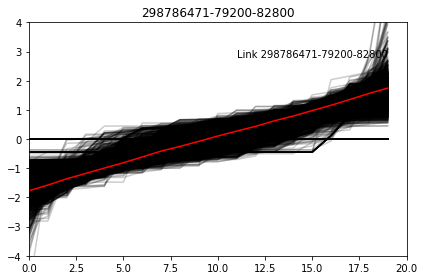

In [25]:
sz = 1580
centroids = {}
general_data = list()
for key in most_accessed_sequence:
    sequence = most_accessed_sequence[key]
    X = to_time_series_dataset(sequence)
    X = TimeSeriesScalerMeanVariance().fit_transform(X)
    X = TimeSeriesResampler(sz).fit_transform(X)
    links_data = list()
    centroids[key] = X[0]
    print(key)
    for other in data:
        Y = to_time_series_dataset(other[3:])
        Y = TimeSeriesScalerMeanVariance().fit_transform(Y)
        Y = TimeSeriesResampler(sz).fit_transform(Y)
        links_data.append(Y[0])
        general_data.append(Y[0])
        print(str(other[:3])+': '+str(DTWDistance(X[0], Y[0])))
    chartLinks(sz, X[0], links_data, key)

In [26]:
result = Kmeans(general_data, centroids, len(centroids), 1, w = 5)

1


In [17]:
print(result)

{11: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 33, 35, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 125, 126, 127, 129, 131, 132, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 149, 150, 151, 152, 153, 155, 157, 158, 159, 161, 162, 163, 166, 170, 173, 174, 176, 179, 182, 185, 188, 189, 190, 191, 193, 194, 200, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 224, 225, 226, 227, 230, 231, 233, 235, 236, 237, 238, 240, 241, 244, 246, 252, 258, 259, 261, 262, 263, 264, 265, 270, 272, 274, 276, 277, 278, 280, 281, 283, 293, 297, 300, 302, 303, 305, 307, 309, 310, 312, 315, 316, 317, 318, 319, 320, 322, 323, 324, 326, 327

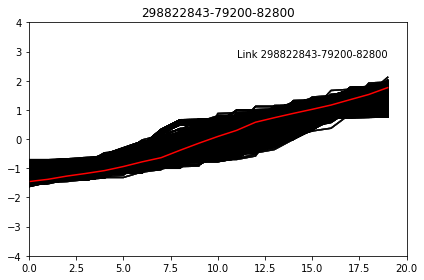

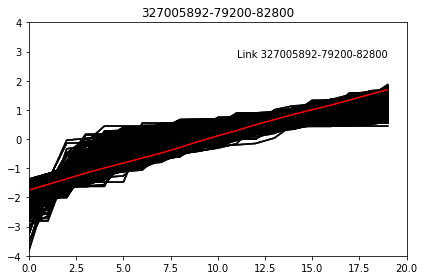

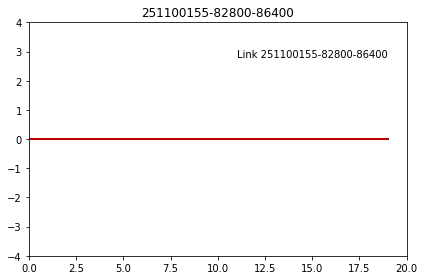

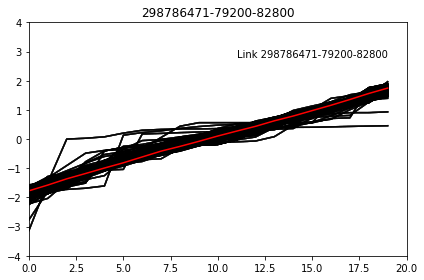

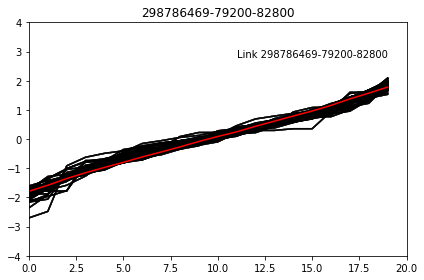

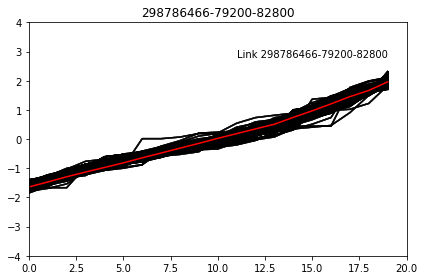

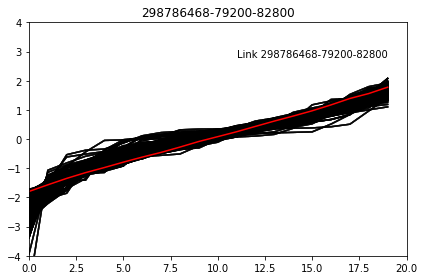

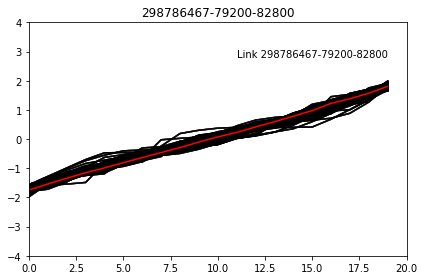

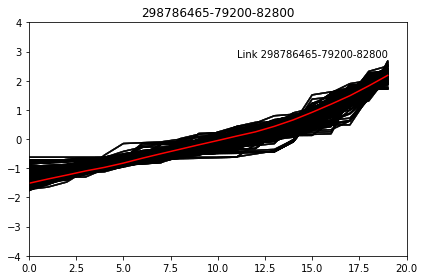

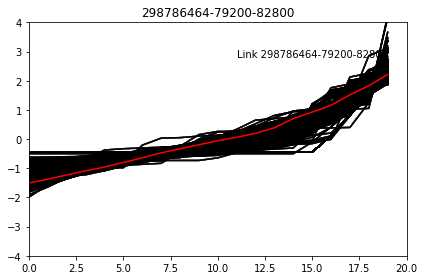

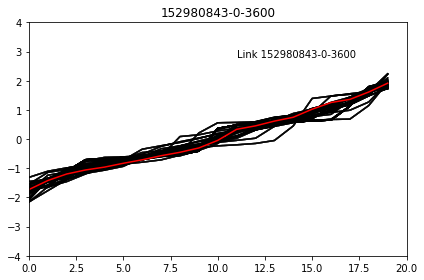

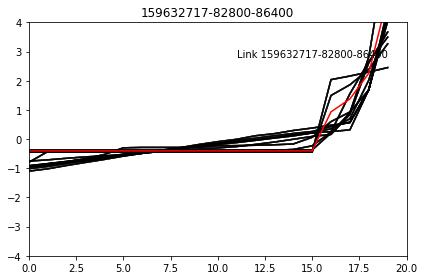

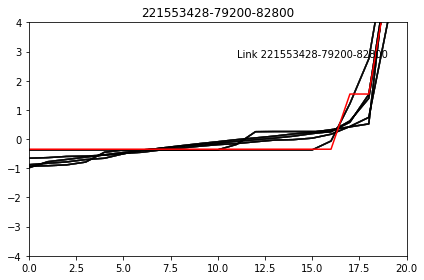

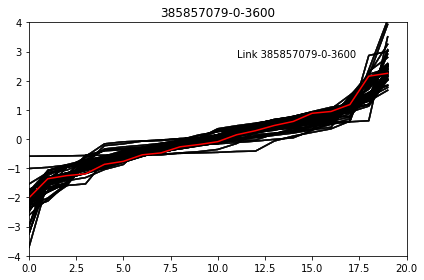

In [27]:
for key in result:
    centroid = centroids[key]
    data_cluster = list()
    print(key)
    for i in result[key]:
        data_cluster.append(general_data[i])
    print("Number of sequences: "+str(len(data_cluster)))
    chartLinks(sz, centroid, data_cluster, key)
    